In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, exists, basename, dirname
import os

from typing import List, Dict, Tuple, Union

LOG_PATH = join(".", "logs")
VGG16_LOGS = join(LOG_PATH, "VGG16", "Cifar10_32", "BP")
RESNET18_LOGS = join(LOG_PATH, "ResNet18", "Cifar10_32", "BP")
RESNET18PC_LOGS = join(LOG_PATH, "ResNet18_PC", "Cifar10_32", "BP")

PER_PIXEL_FILE_NAME = "perpixel_probe_performances.csv"

In [2]:
path = "./feature_maps"
if not exists(path):
    os.makedirs(path)

In [3]:
from matplotlib import rc

params = {
#           'text.latex.preamble': [r'\usepackage{gensymb}'],
          'axes.labelsize': 18, # fontsize for x and y labels (was 10)
          'axes.titlesize': 18,
          'font.size': 16, # was 10
          'legend.fontsize': 16, # was 10
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'font.family': 'serif',
          'figure.dpi': 350
}
#mpl.rcParams['figure.dpi'] = 900
import matplotlib
matplotlib.rcParams.update(params)
#rc('text', usetex=True)

In [4]:
resnet18 = join(RESNET18_LOGS, PER_PIXEL_FILE_NAME)
resnet18pc = join(RESNET18PC_LOGS, PER_PIXEL_FILE_NAME)
vgg16 = join(VGG16_LOGS, PER_PIXEL_FILE_NAME)

In [5]:
def read_file(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename, sep=';', index_col=0)

def get_layer_set(df: pd.DataFrame) -> List[str]:
    all_entries = df["name"].values
    layer_names = [l.split("-(")[0] for l in list(df["name"].values)]
    df['layer_name'] = layer_names
    return list(set(layer_names))

def grouped_by_layer(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    result = {}
    layers = get_layer_set(df)
    for layer in layers:
        per_layer = df[df["layer_name"] == layer]
        result[layer] = per_layer
    return result

def get_pixel_position(df: pd.DataFrame) -> pd.DataFrame:
    names = df["name"].values
    res_x, res_y = [], []
    for name in names:
        res = name.split("-(")[-1].replace(")", "").split(",")
        if len(res) == 1:
            res_x.append(1), res_y.append(1)
            continue
        str_x, str_y = res[0], res[1]
        x, y = int(str_x), int(str_y)
        res_x.append(x), res_y.append(y)
    return res_x, res_y

def obtain_max_heatmap_shape(res_x: List[int], res_y: List[int]) -> Tuple[int, int]:
    return np.max(res_x), np.max(res_y)

def build_heatmap(rx: List[int], ry: List[int]):
    x, y = obtain_max_heatmap_shape(rx, ry)
    return np.zeros((x+1, y+1))

def fill_heatmap(df: pd.DataFrame, heatmap: np.ndarray) -> np.ndarray:
    for x, y, eval_accuracy in zip(df["x"].values, df["y"].values, df["eval_acc"].values):
        heatmap[x, y] = eval_accuracy
    return heatmap

def get_heatmaps(file: str) -> Dict[str, np.ndarray]:
    df = read_file(file)
    df_grp_by_layer = grouped_by_layer(df)
    heatmaps = {}
    for layer_name, layer_df in df_grp_by_layer.items():
        if "fc" in layer_name:
            continue
        x, y = get_pixel_position(layer_df)
        layer_df["x"], layer_df["y"] = x, y
        heatmap = build_heatmap(x, y)
        filled_heatmap = fill_heatmap(layer_df, heatmap)
        heatmaps[layer_name] = filled_heatmap
    return heatmaps

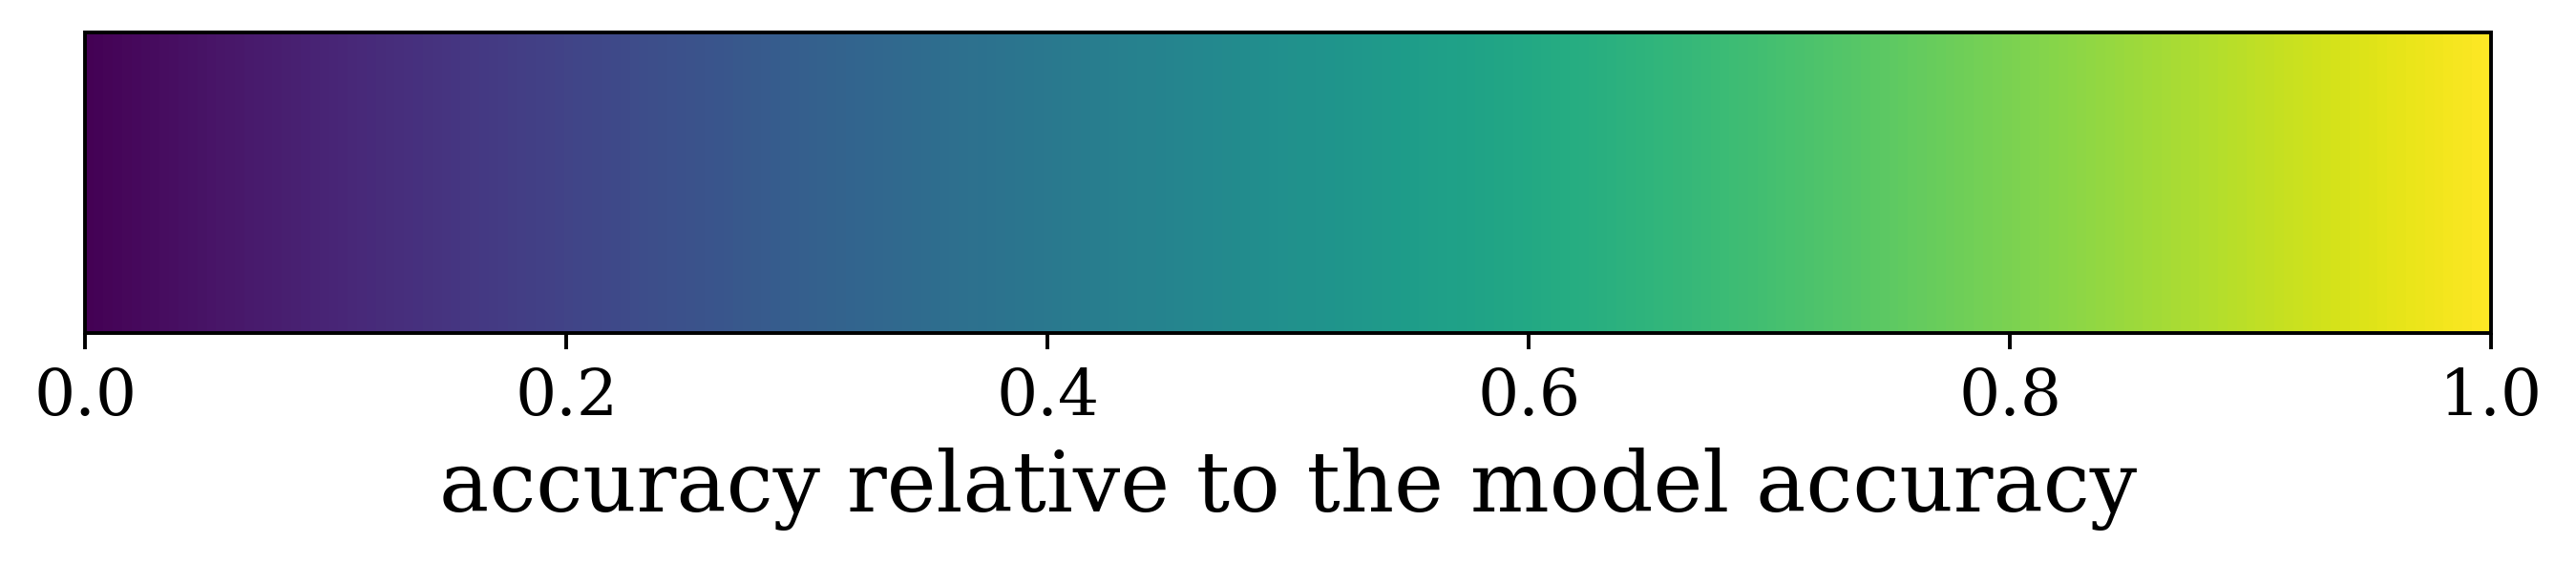

In [6]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(9, 1.5))
img = pl.imshow(a)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
cbar = pl.colorbar(orientation="horizontal", cax=cax)
cbar.set_label("accuracy relative to the model accuracy")
savepath = join(path, "colorbar.jpg")
pl.savefig(savepath)

<ipython-input-5-7e58538604f9>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df["x"], layer_df["y"] = x, y


conv1


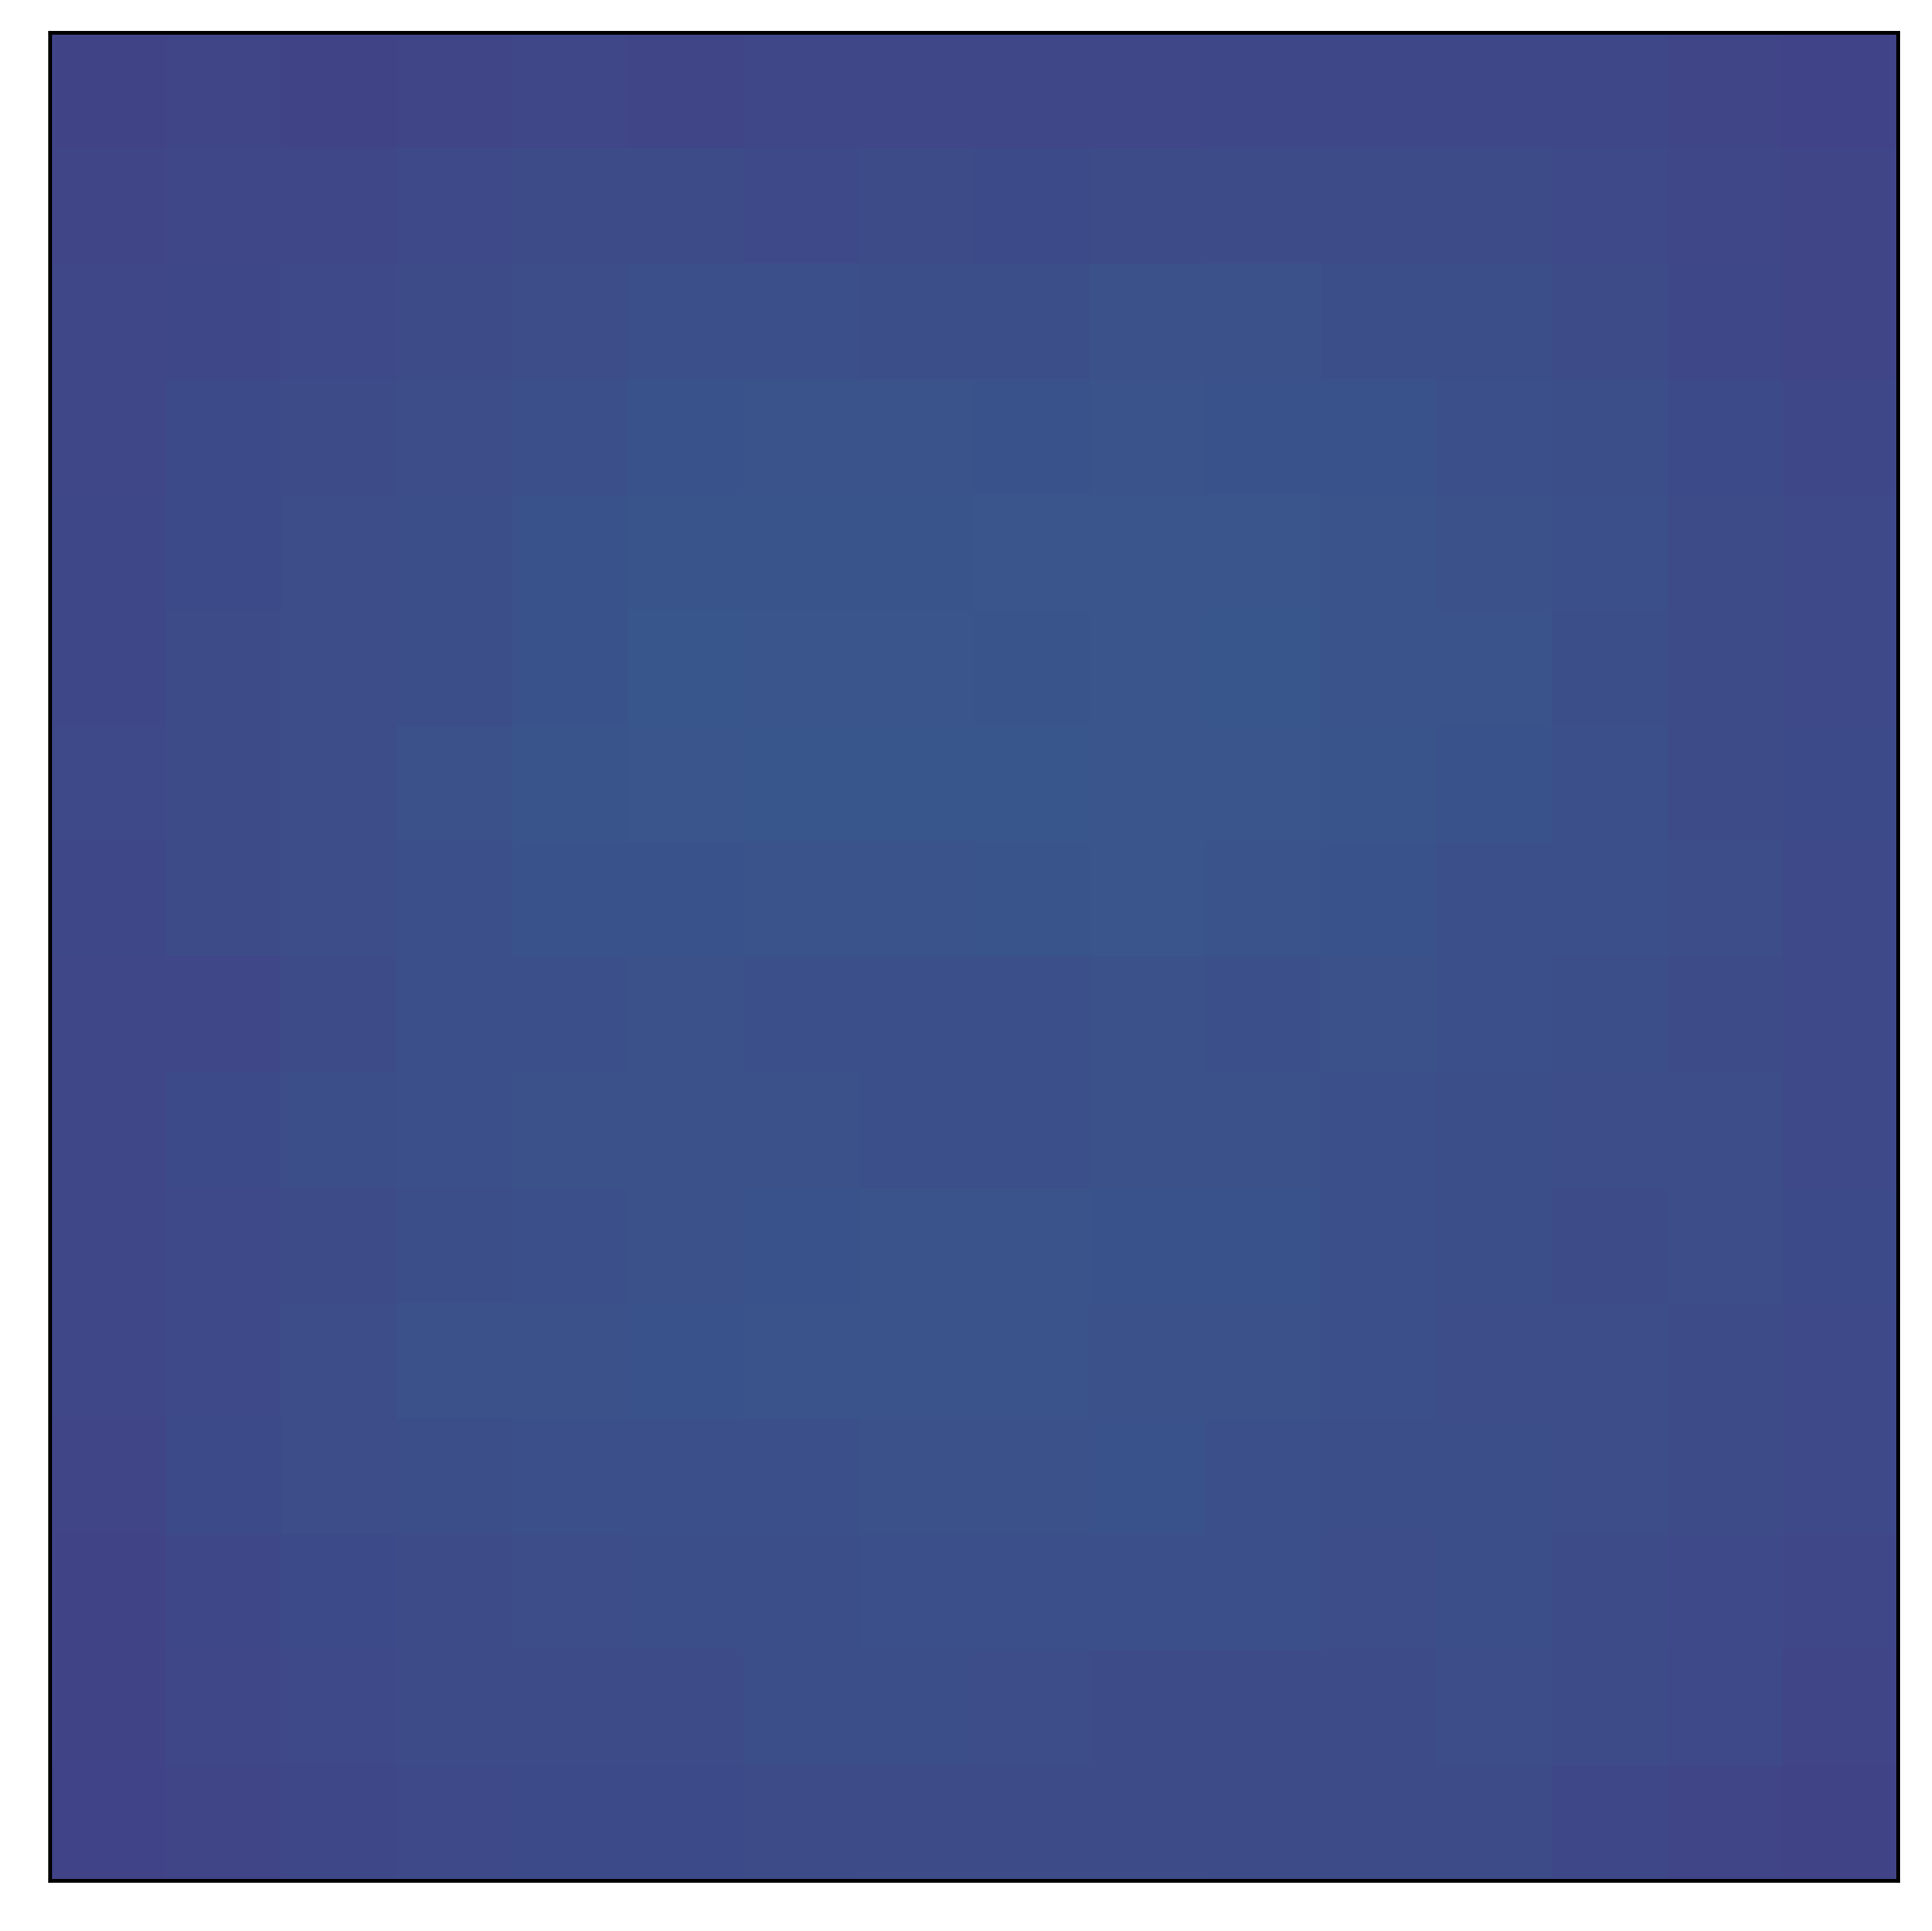

layer1-0-conv1


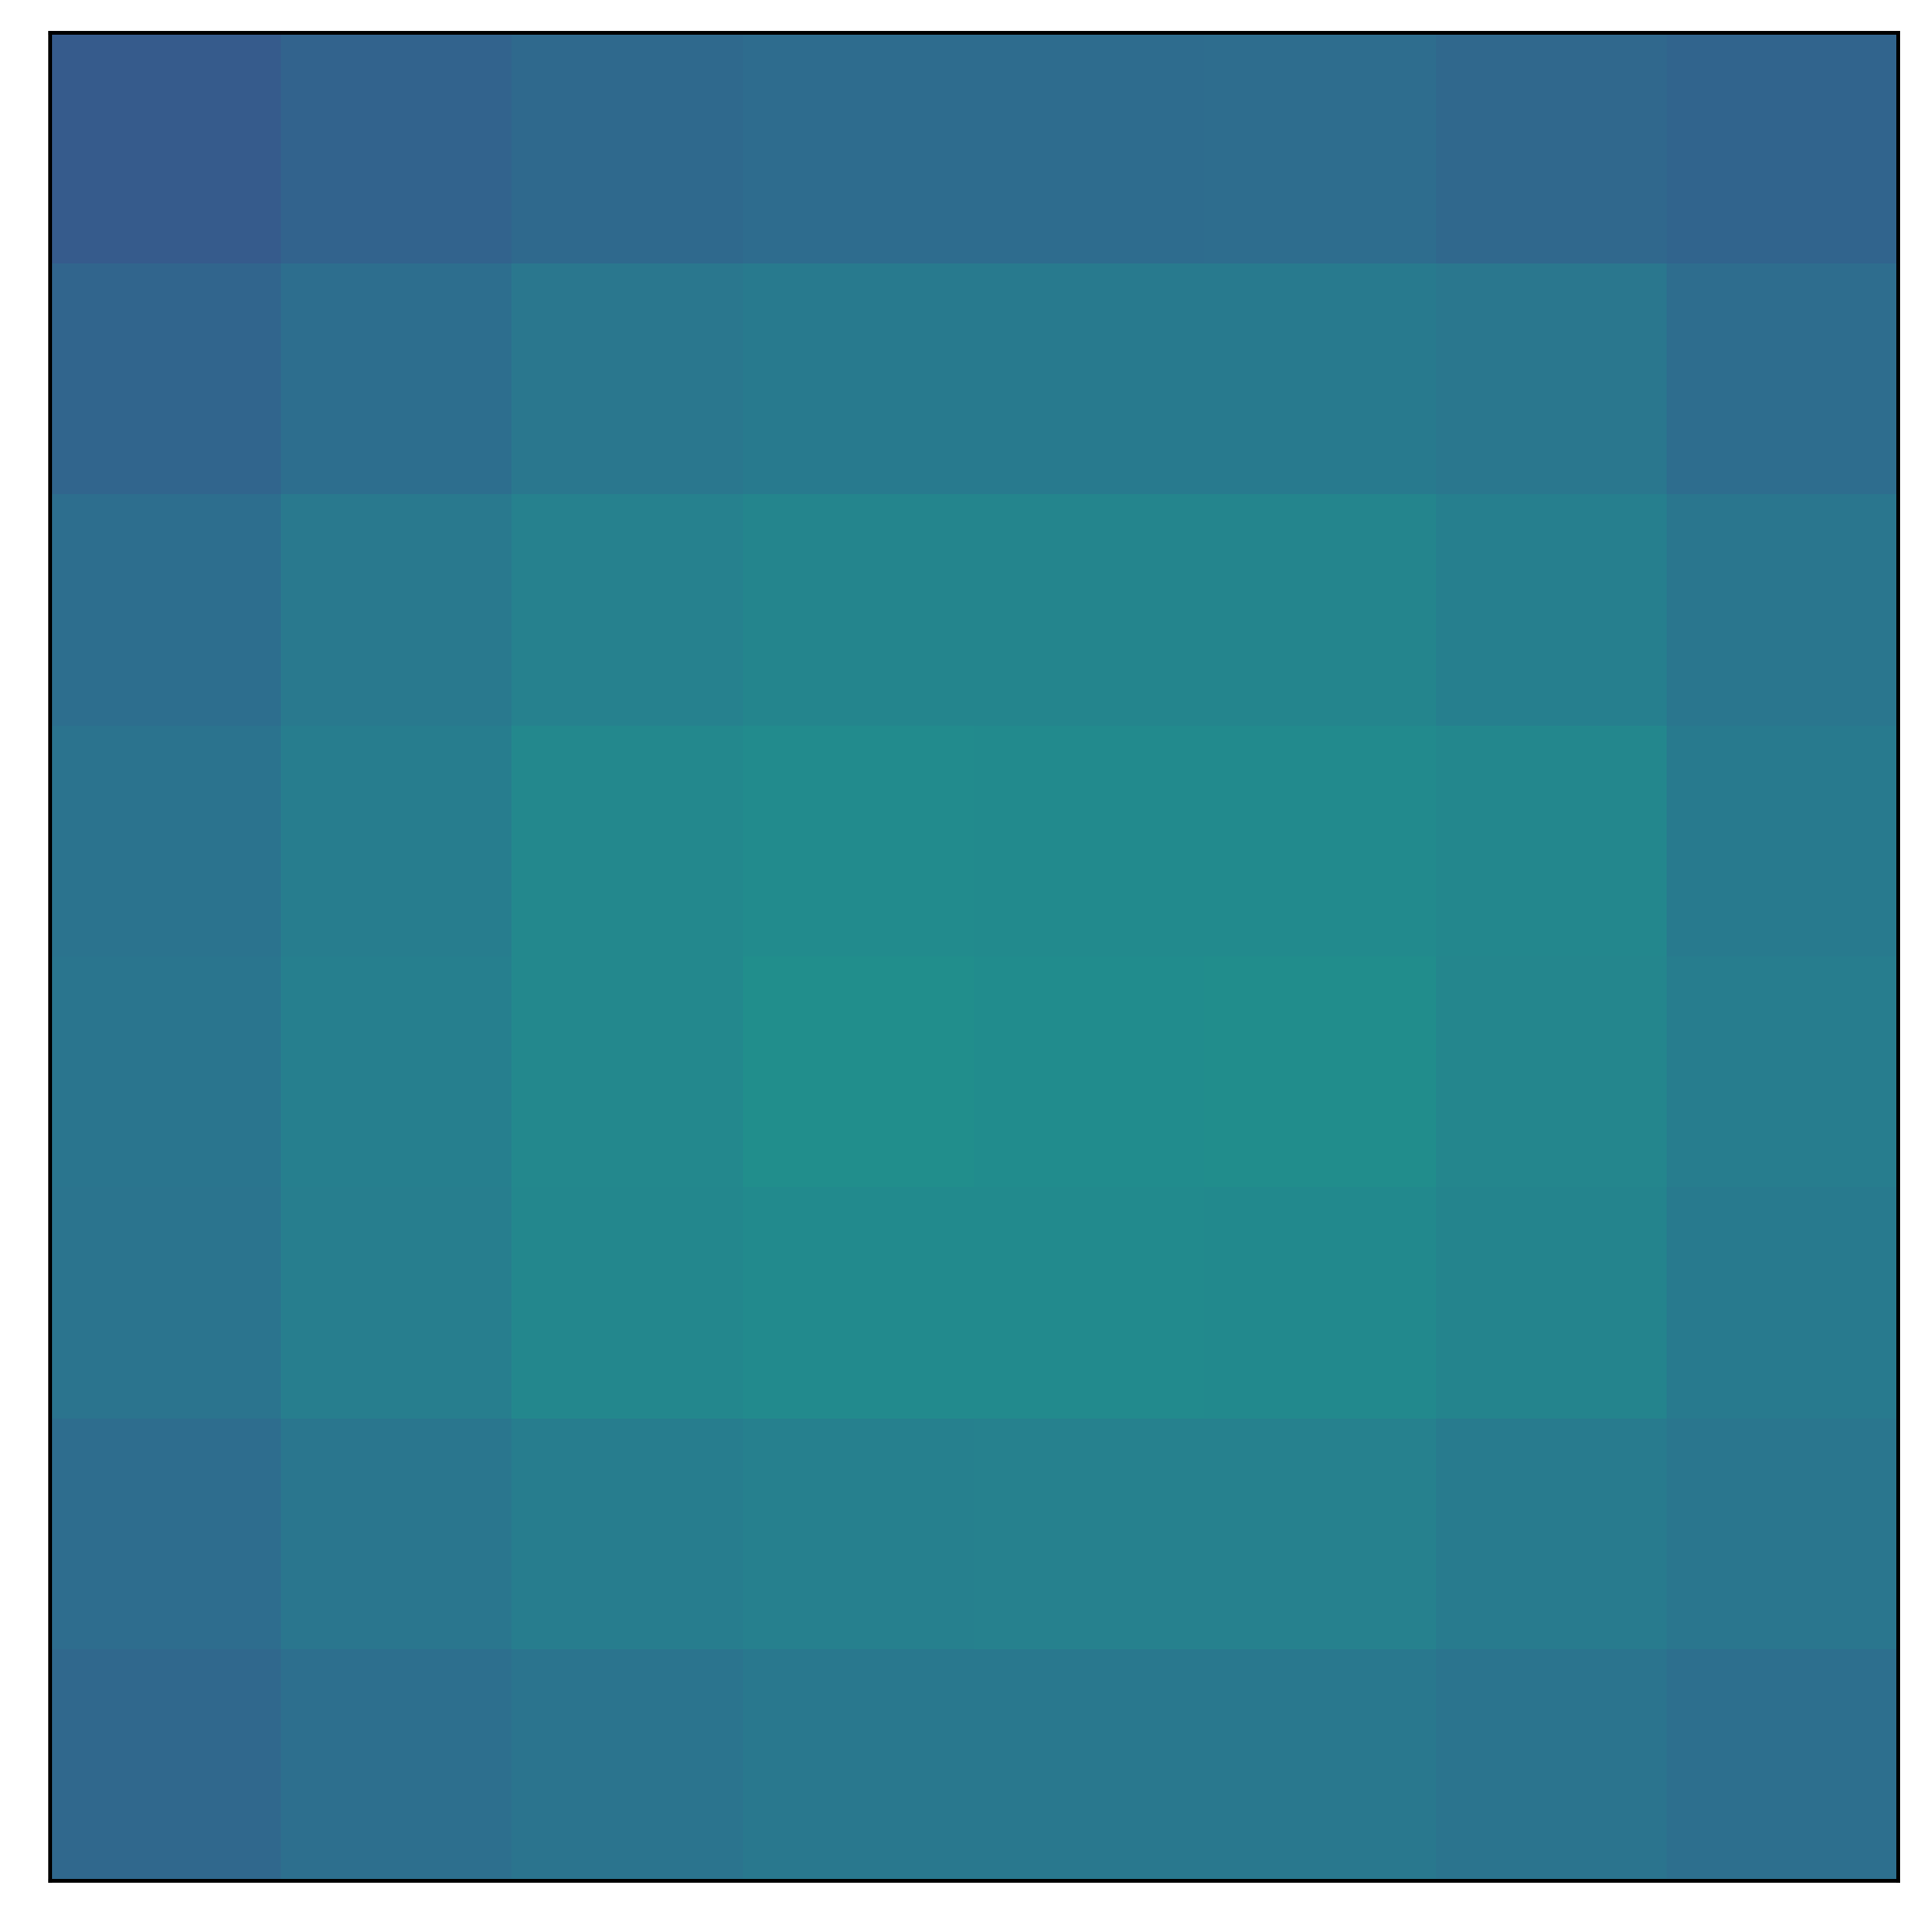

layer1-0-conv2


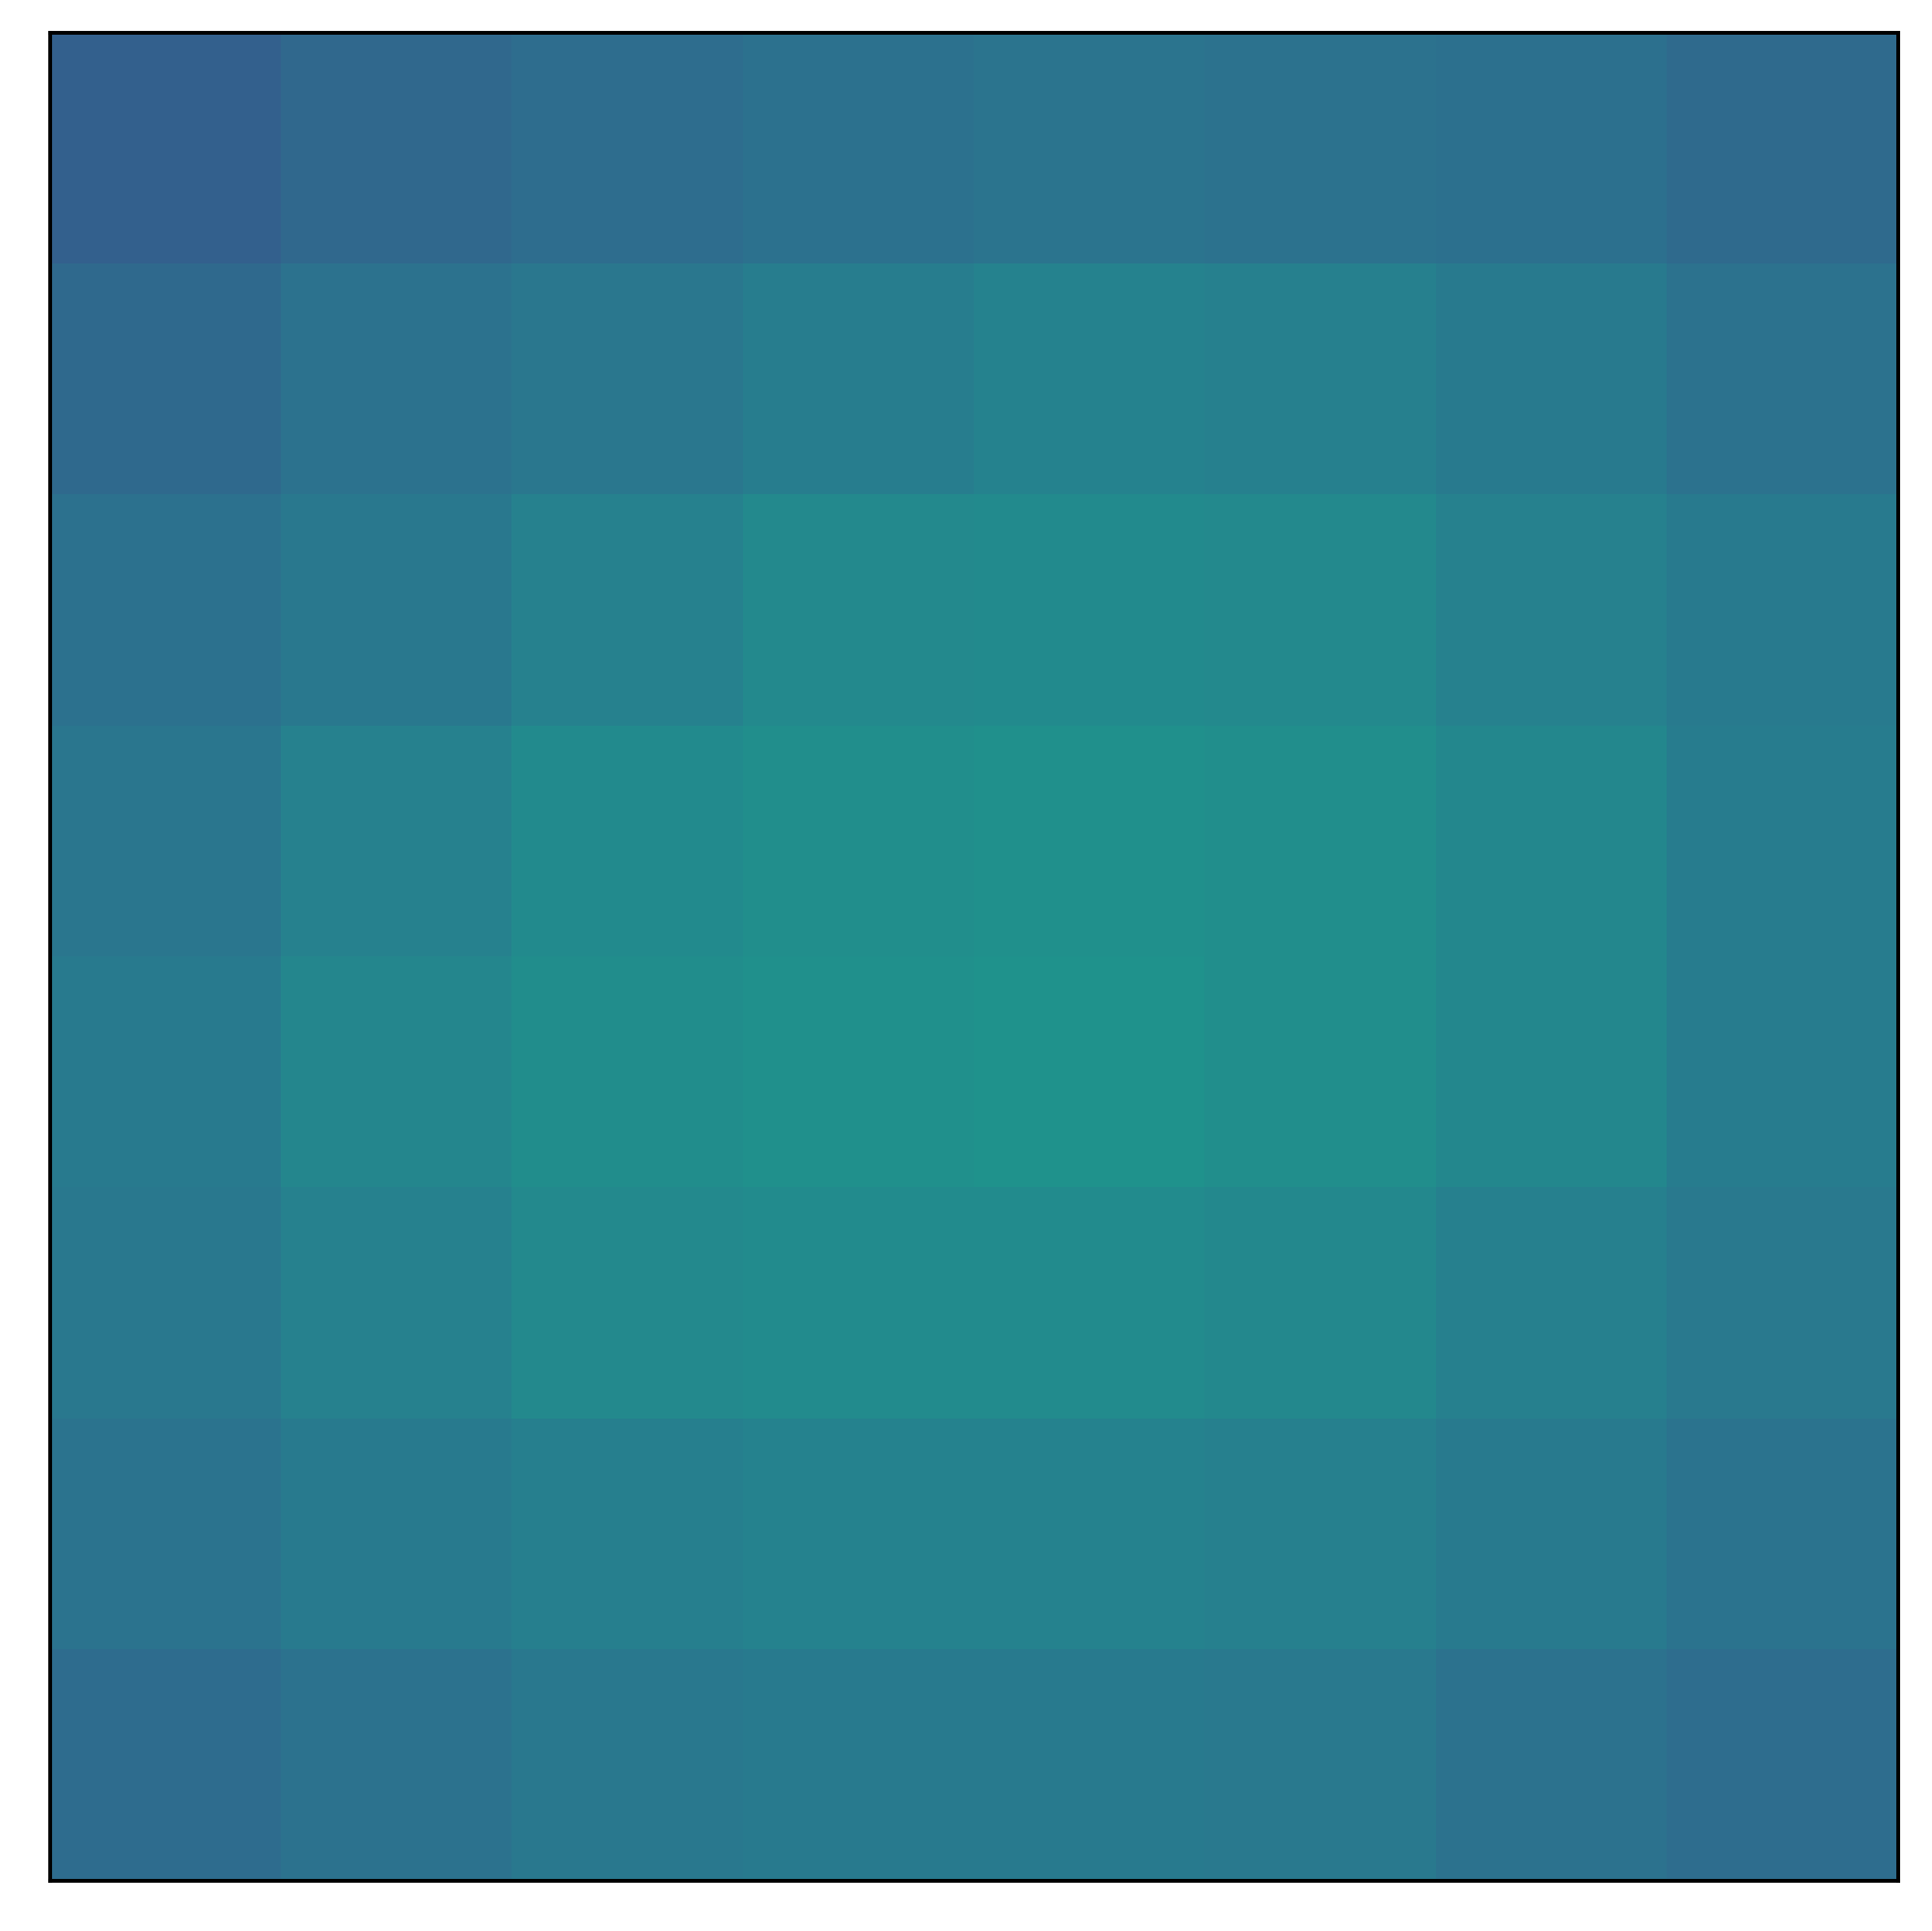

layer1-1-conv1


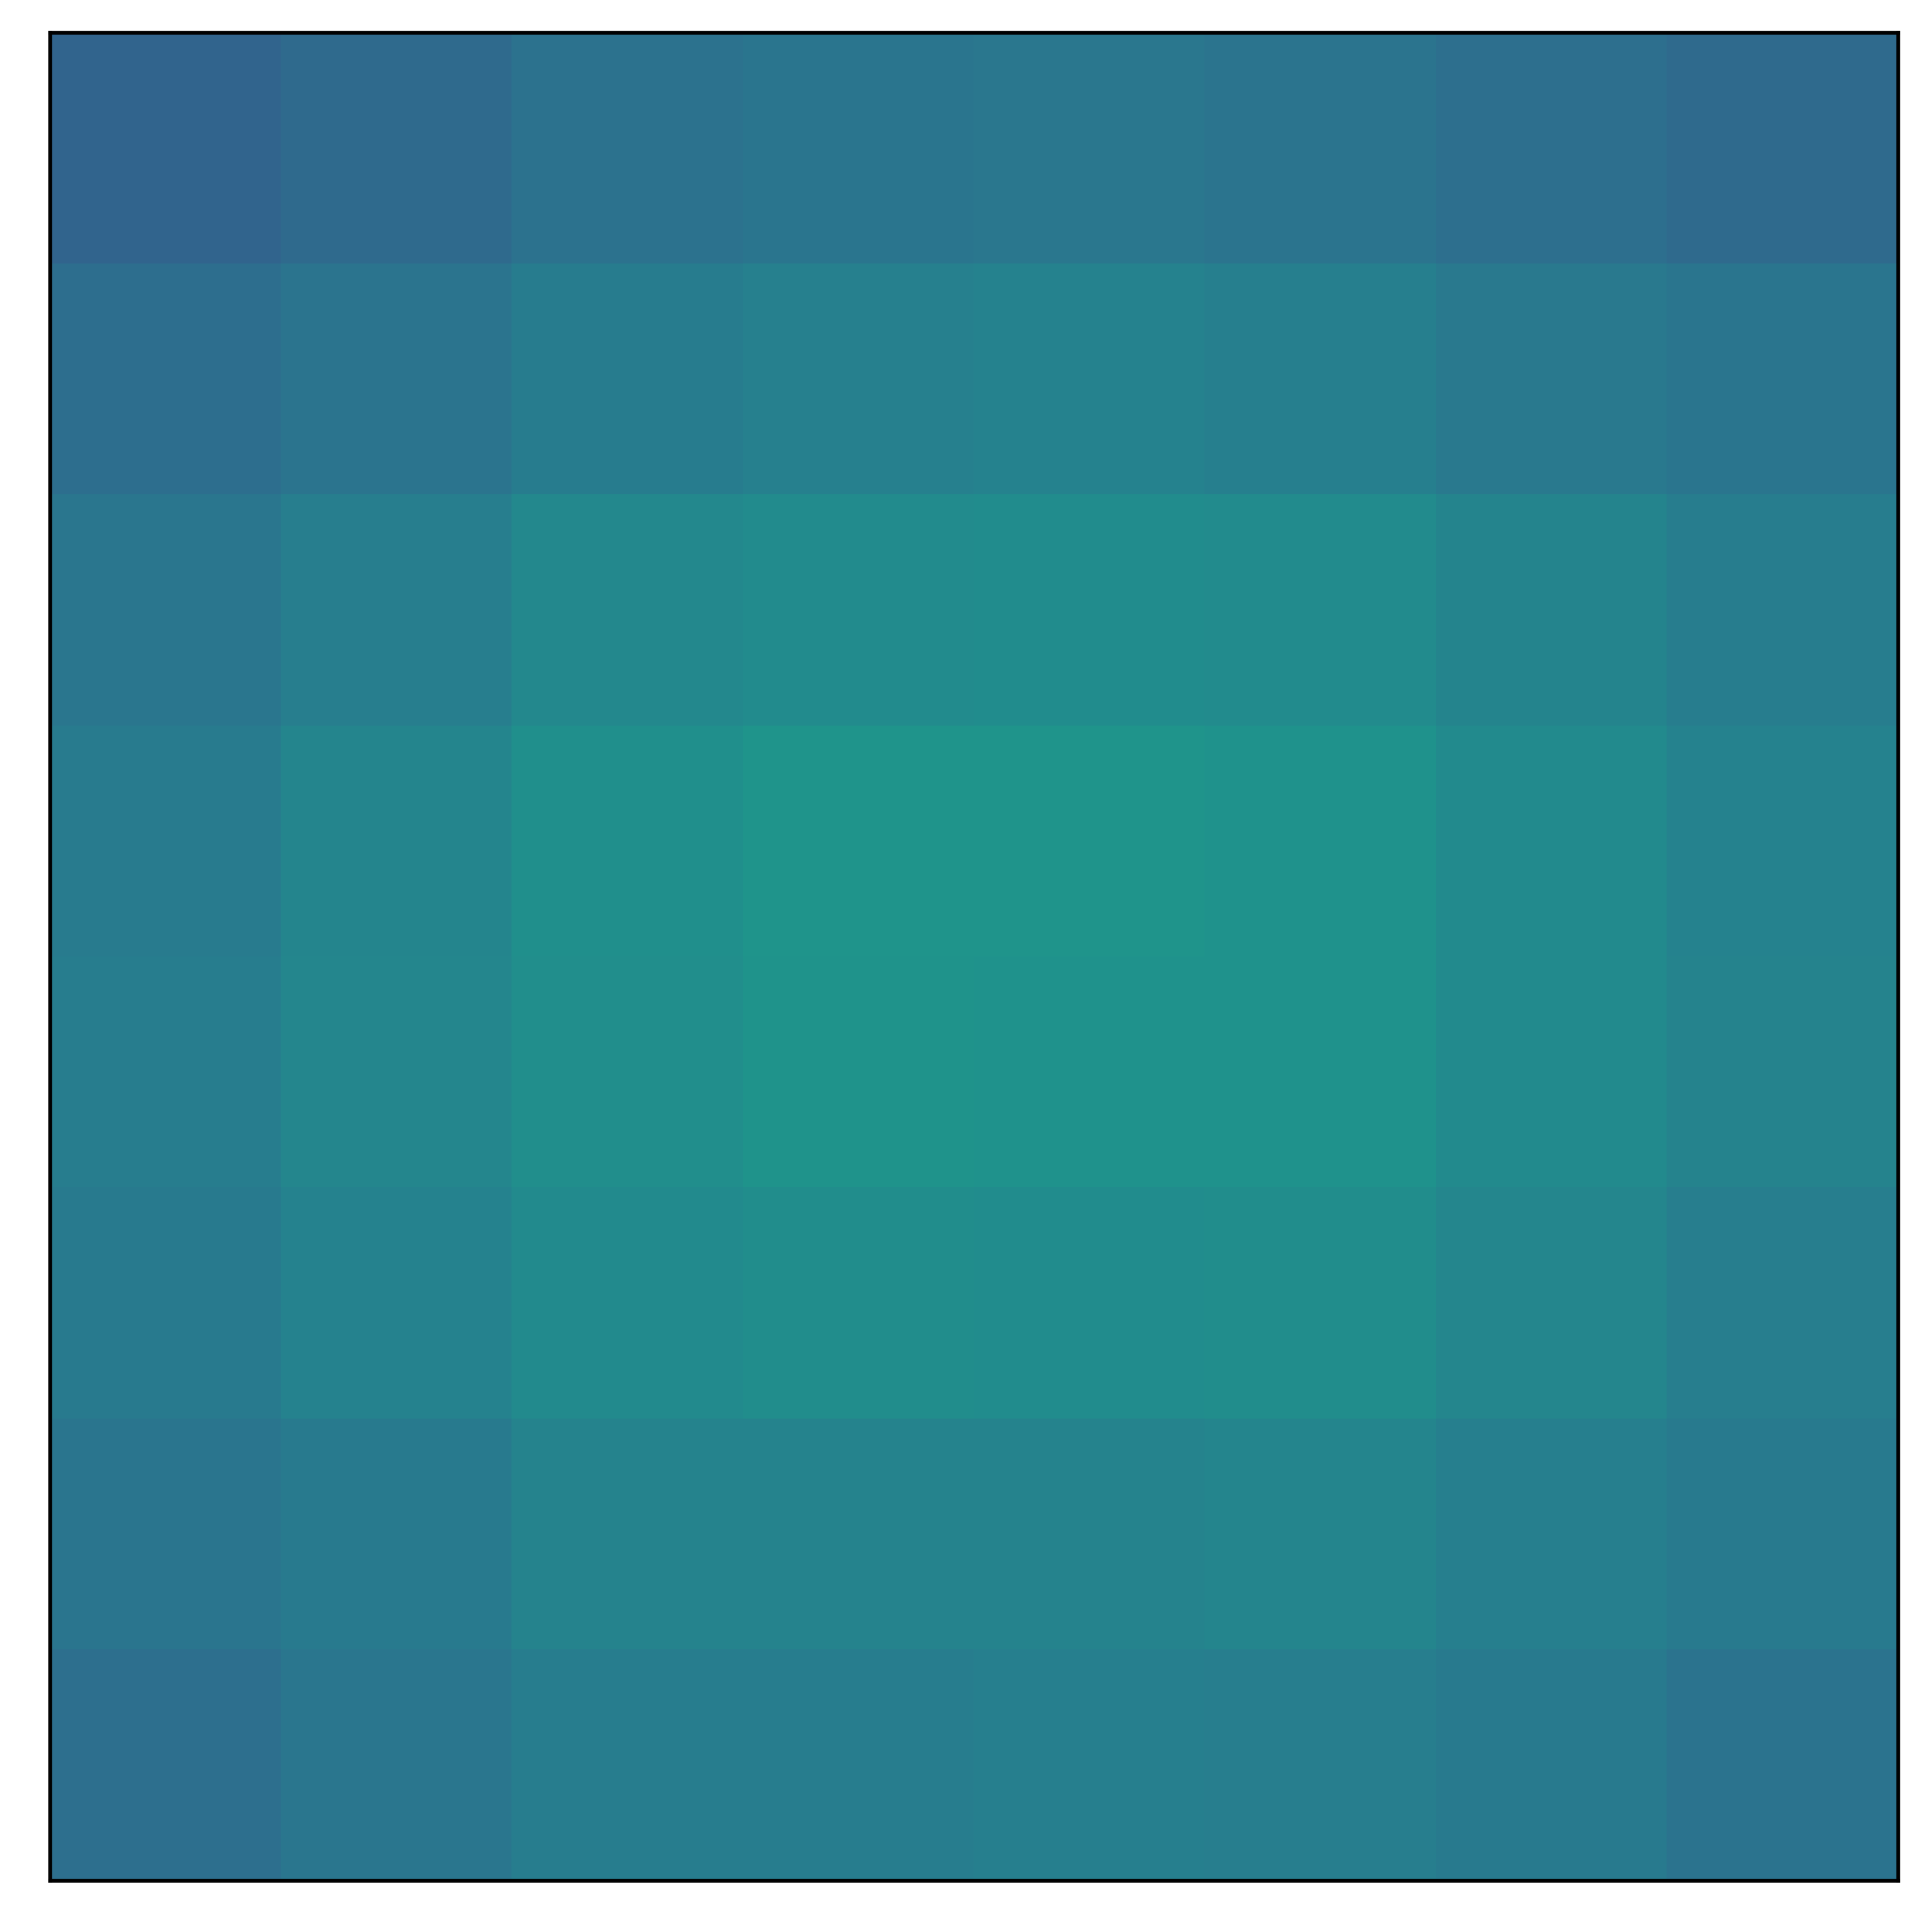

layer1-1-conv2


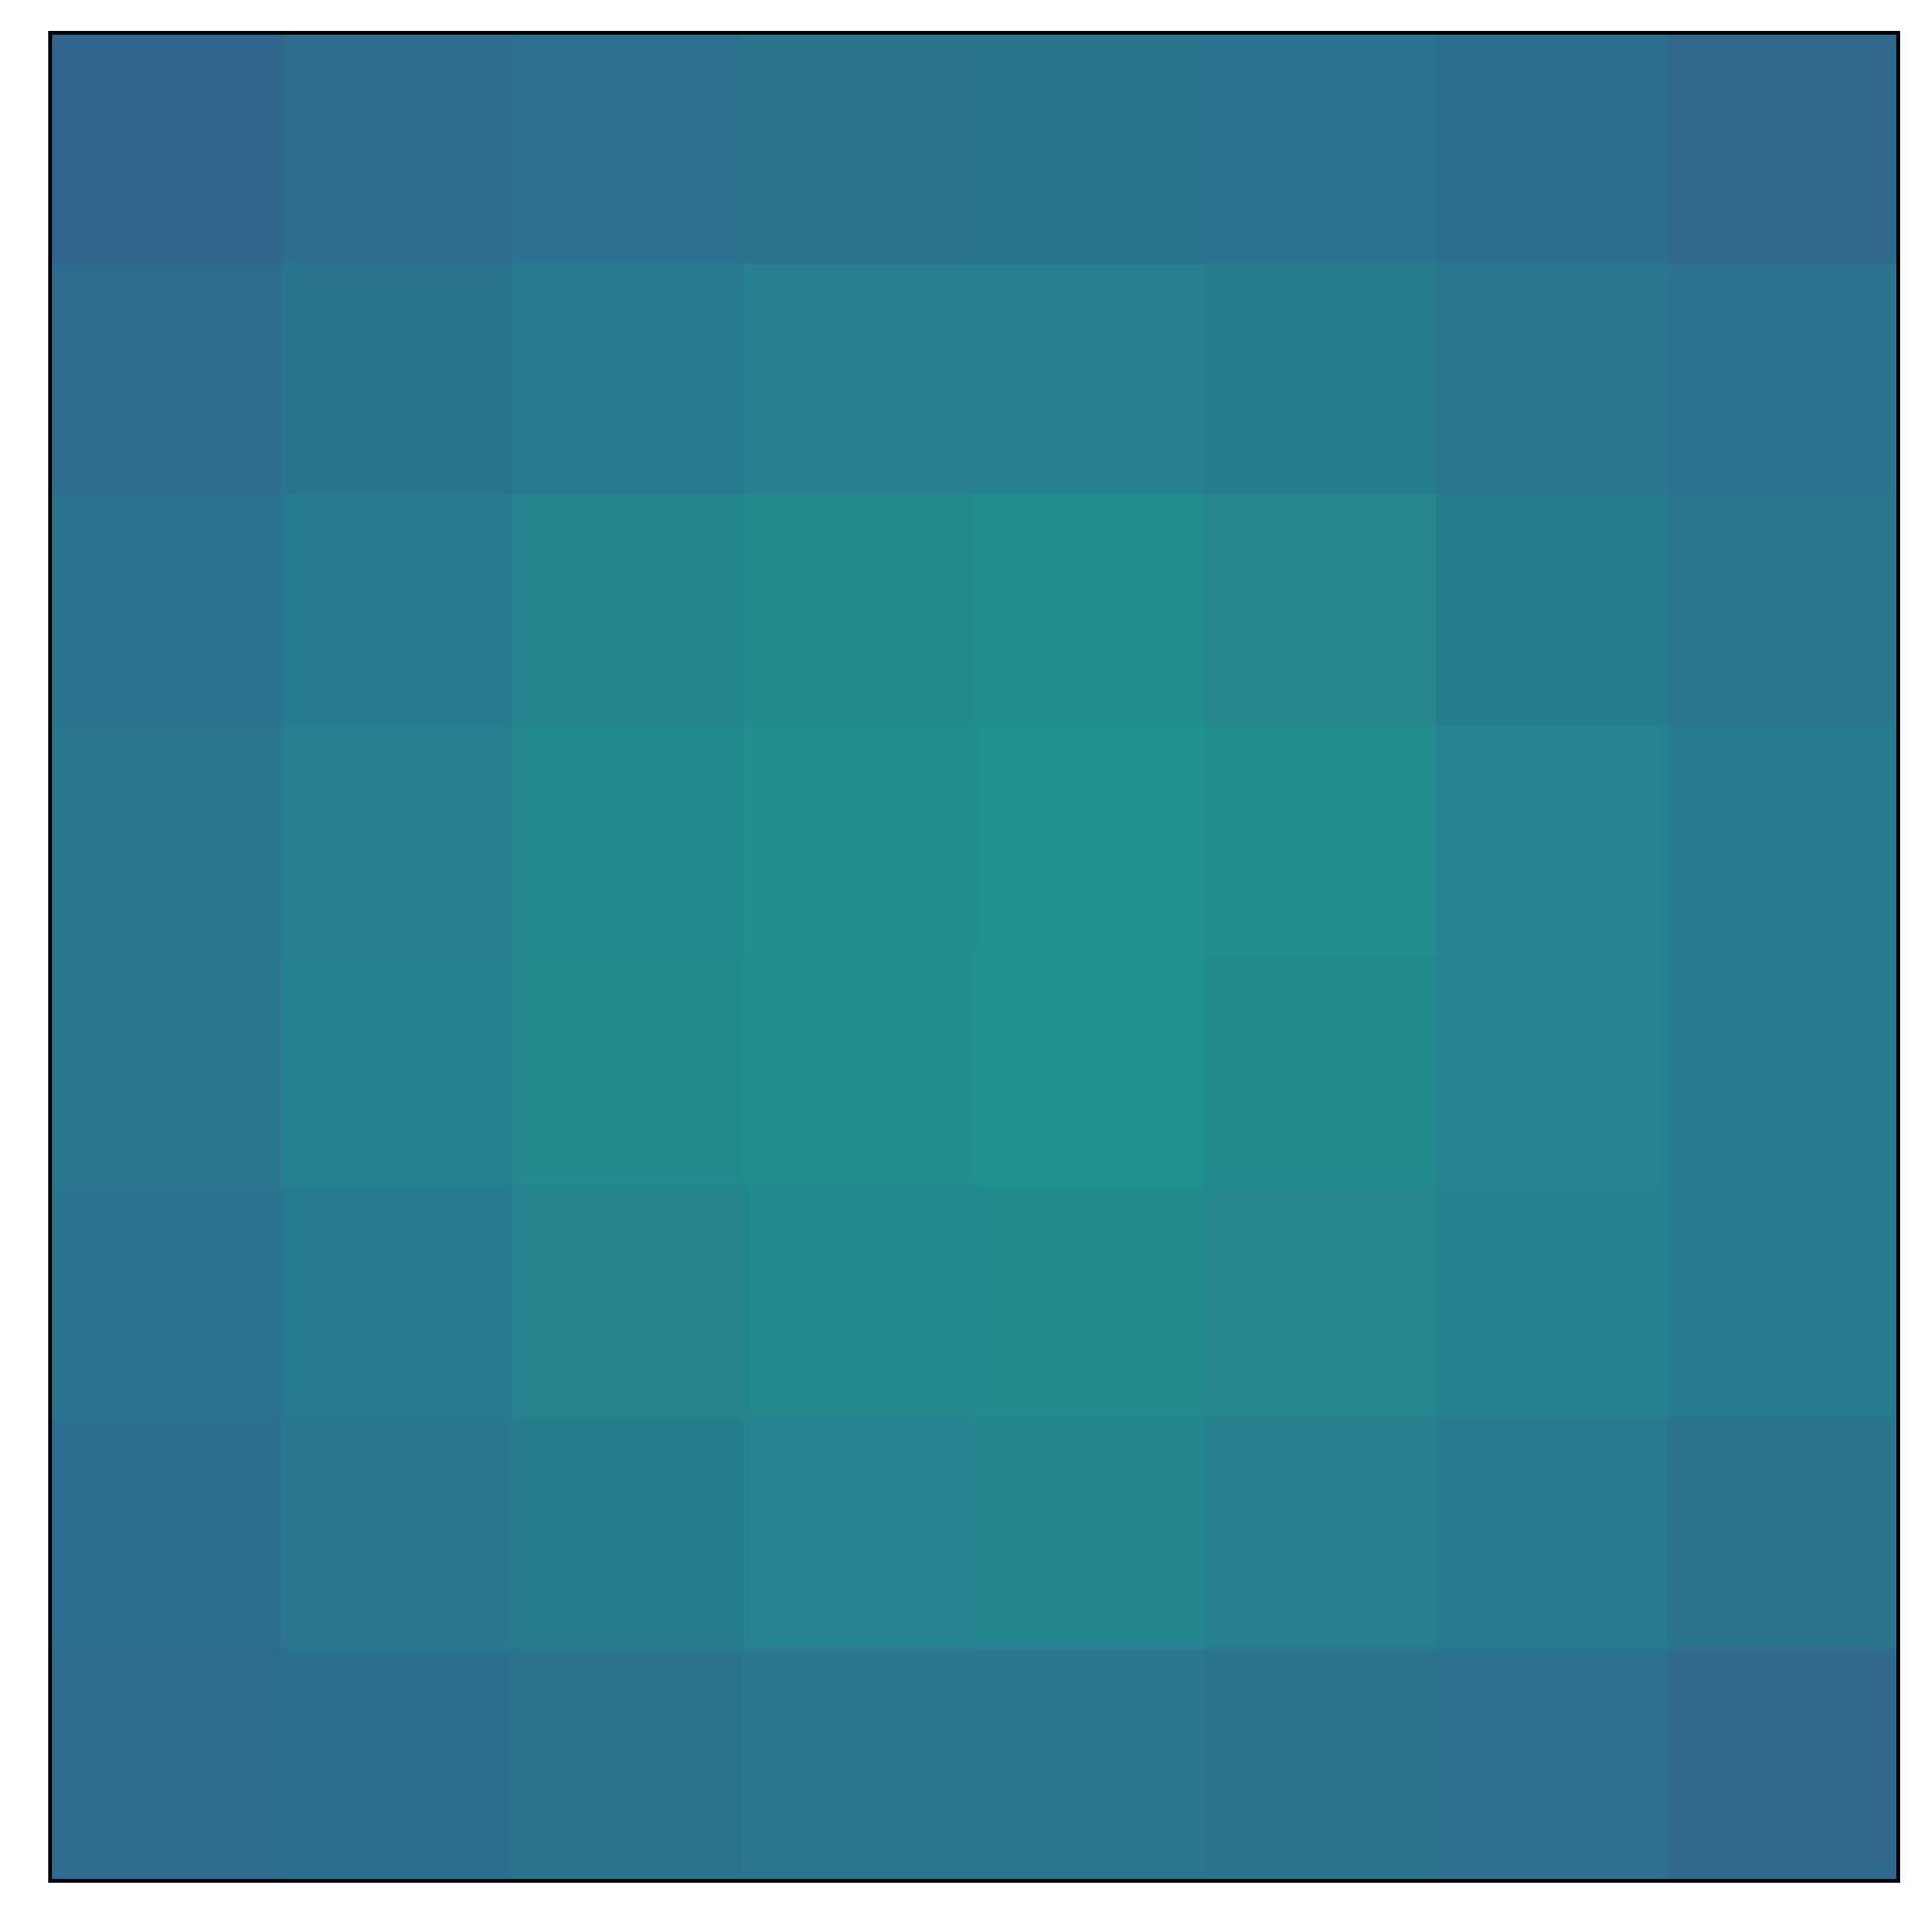

layer2-0-conv1


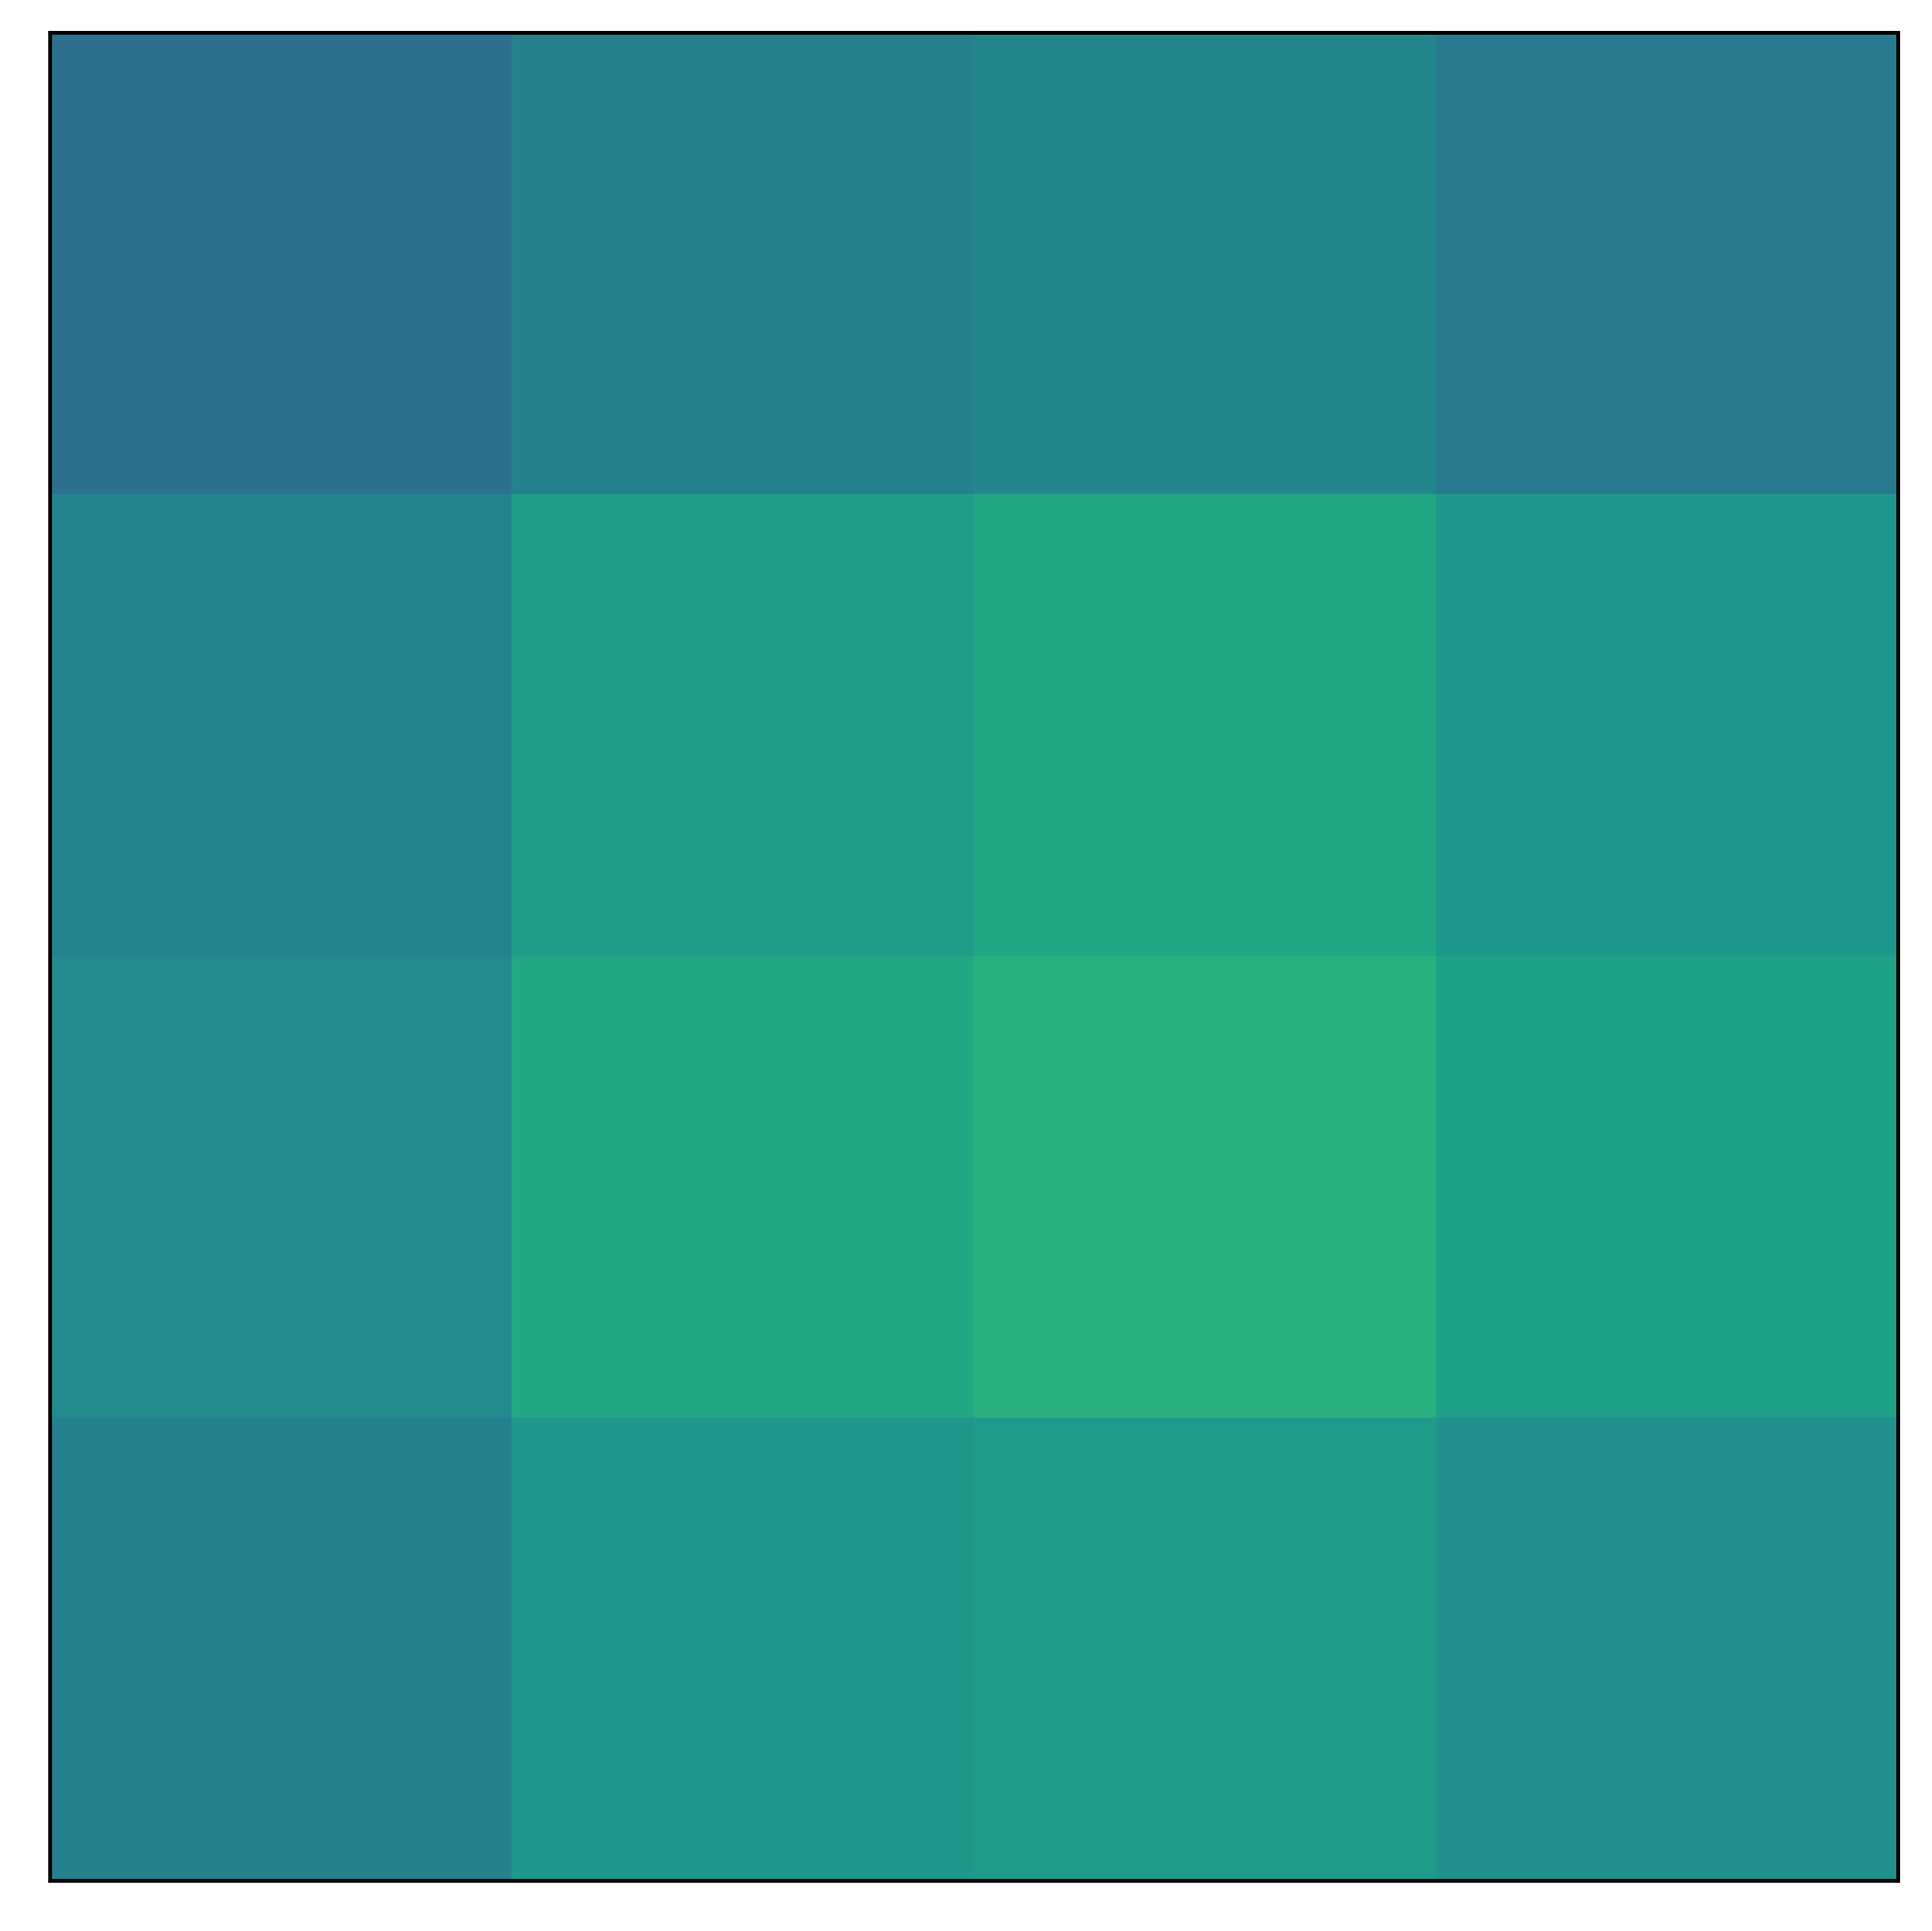

layer2-0-conv2


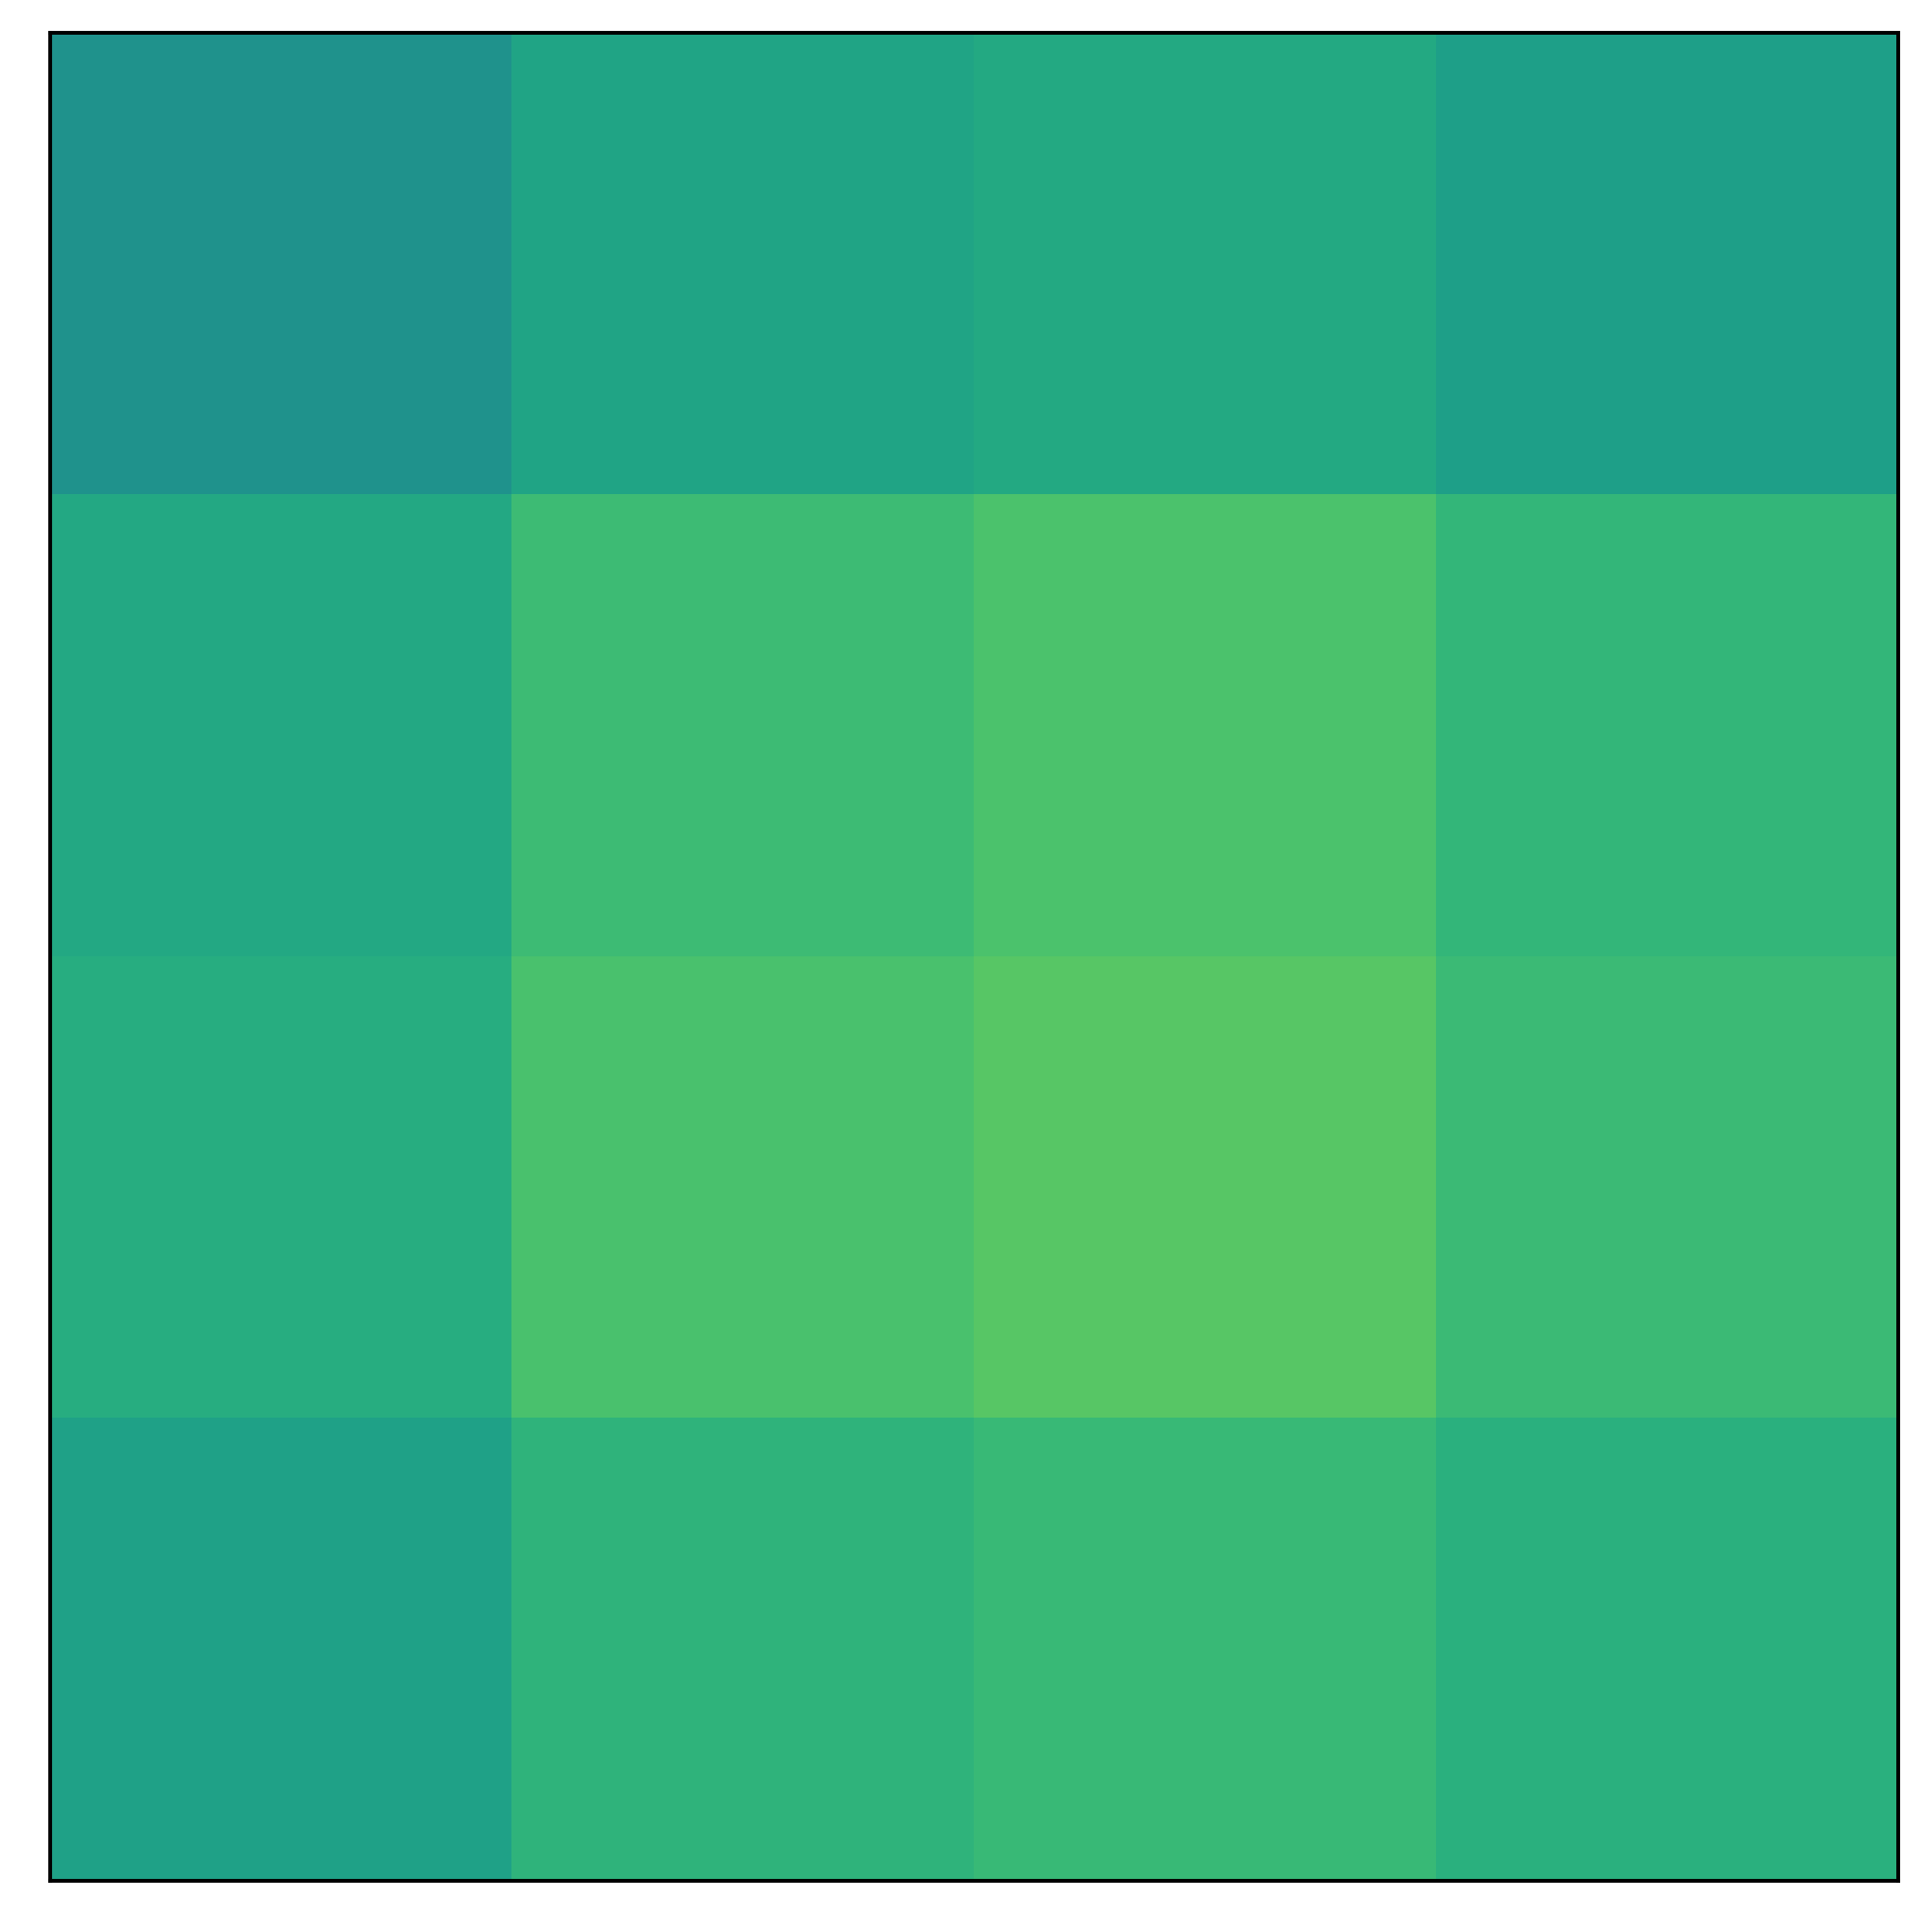

layer2-1-conv1


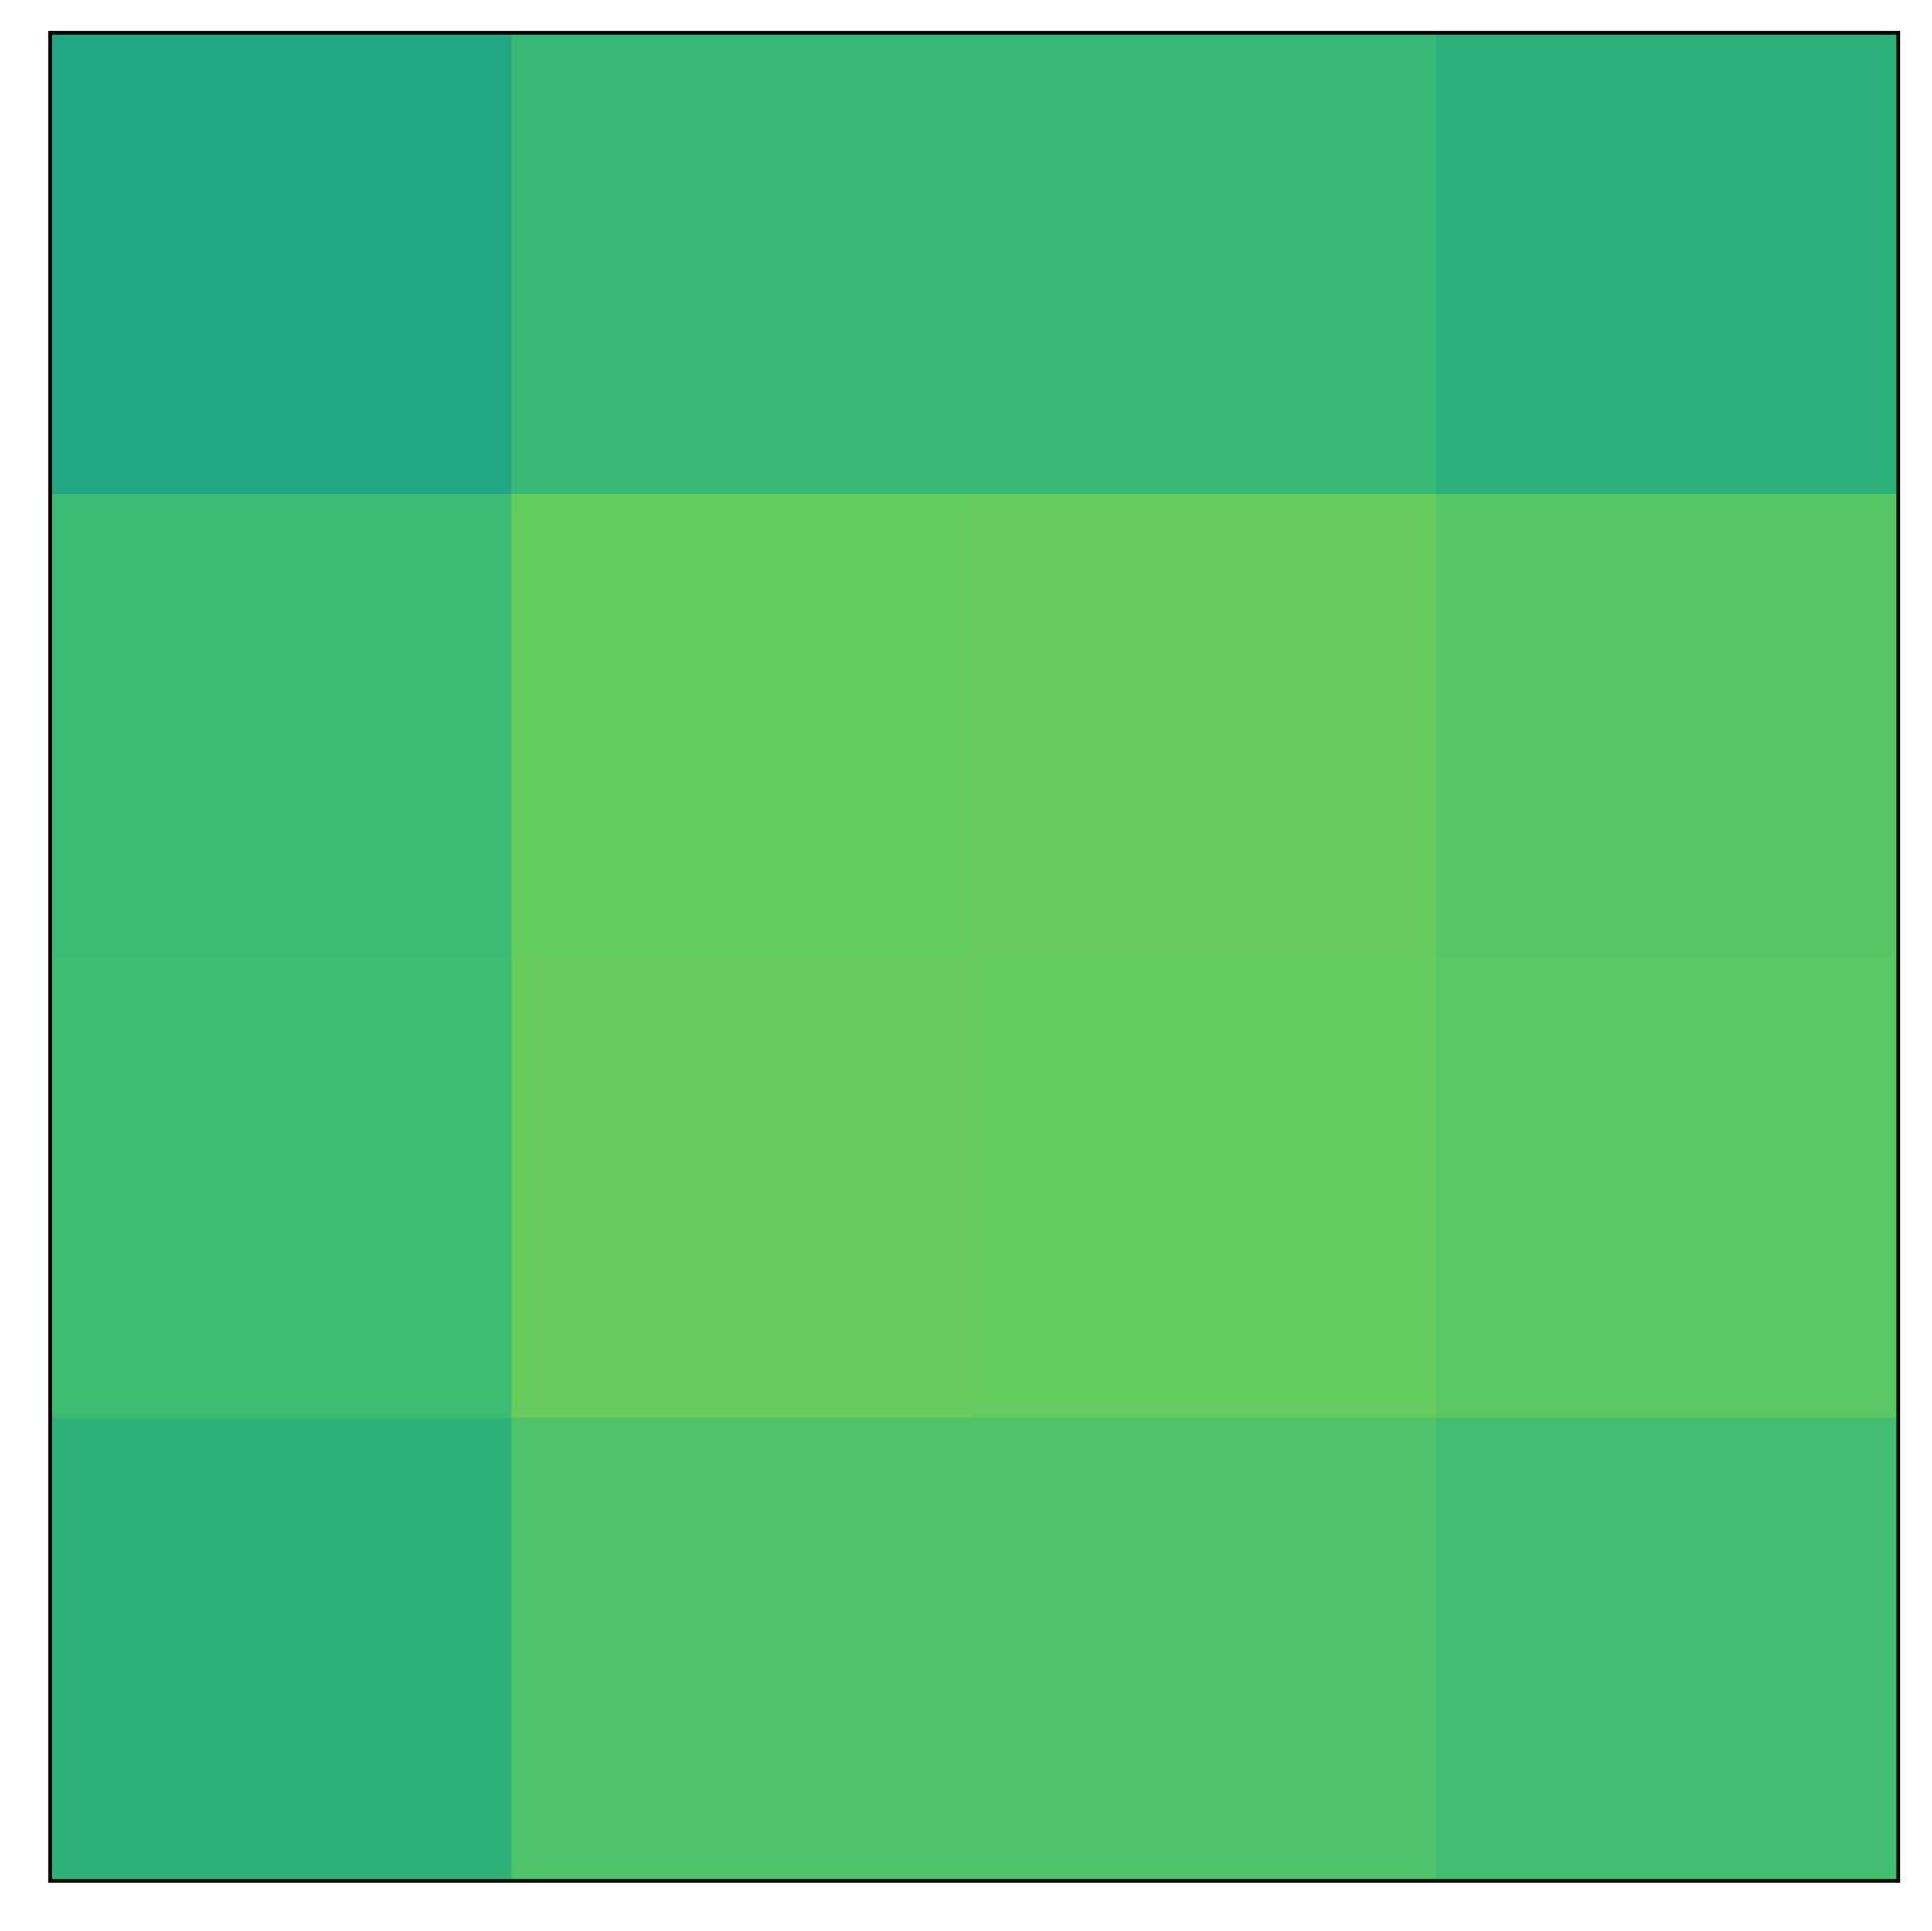

layer2-1-conv2


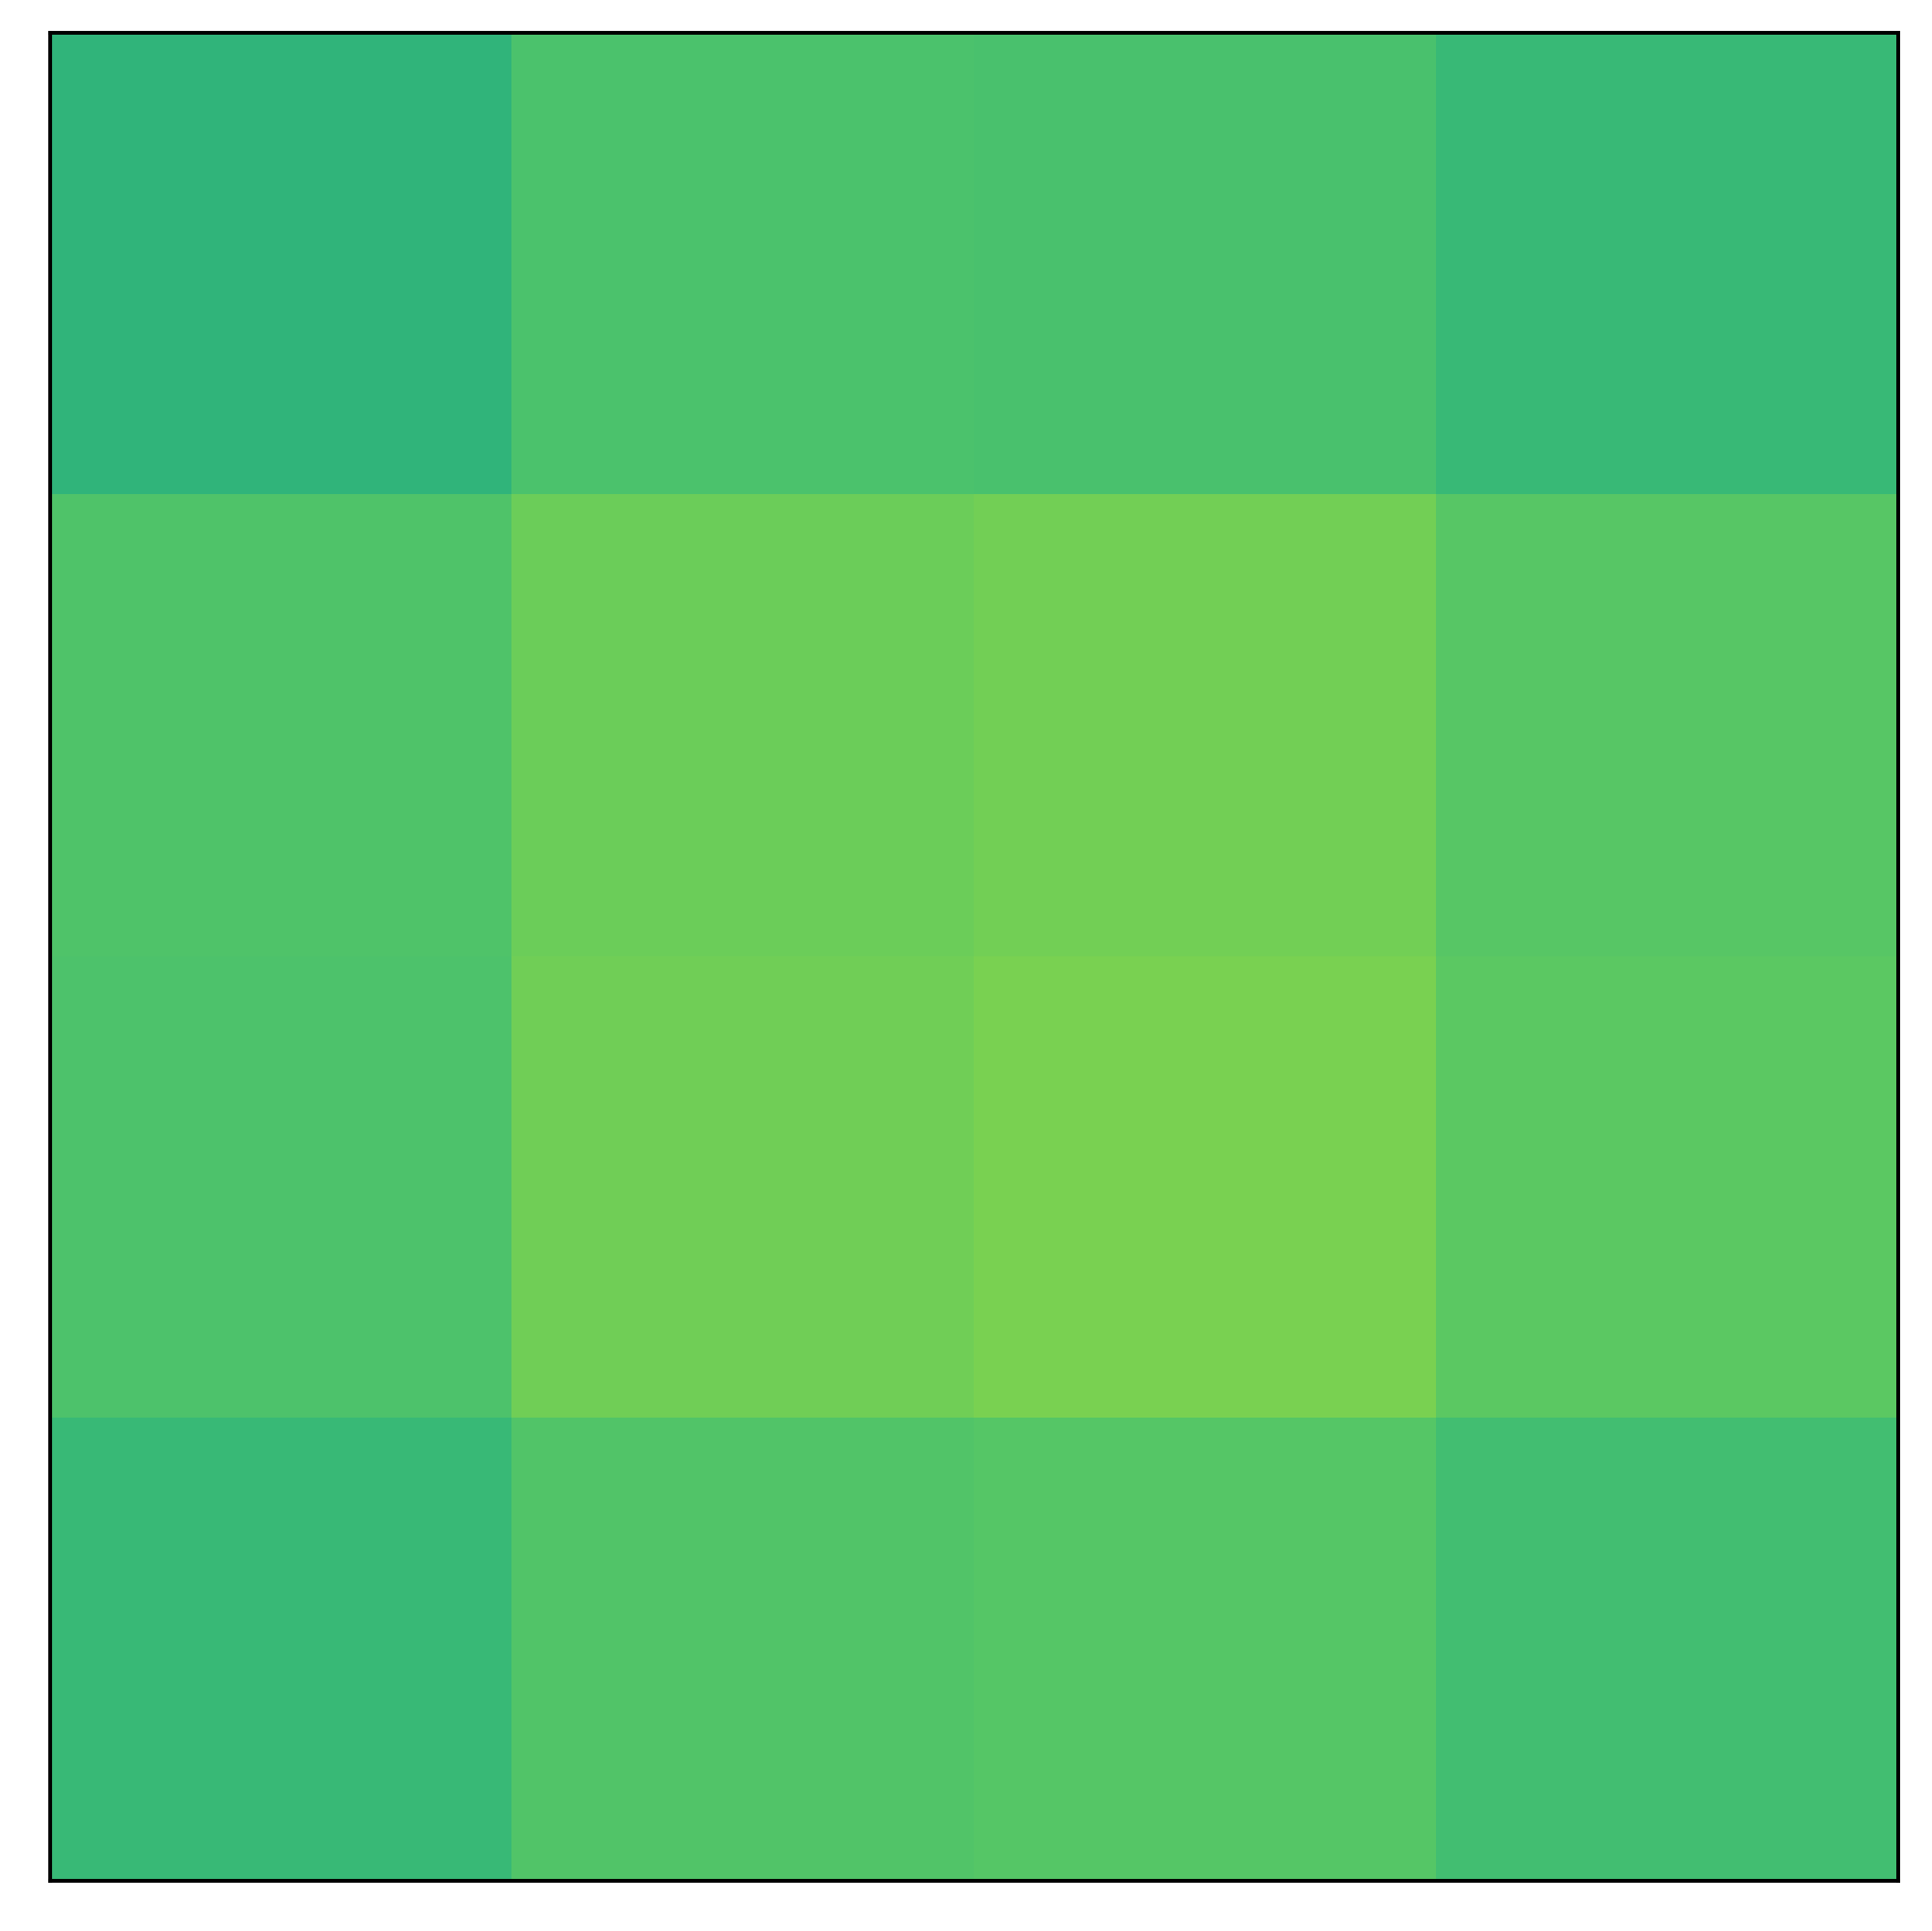

layer3-0-conv1


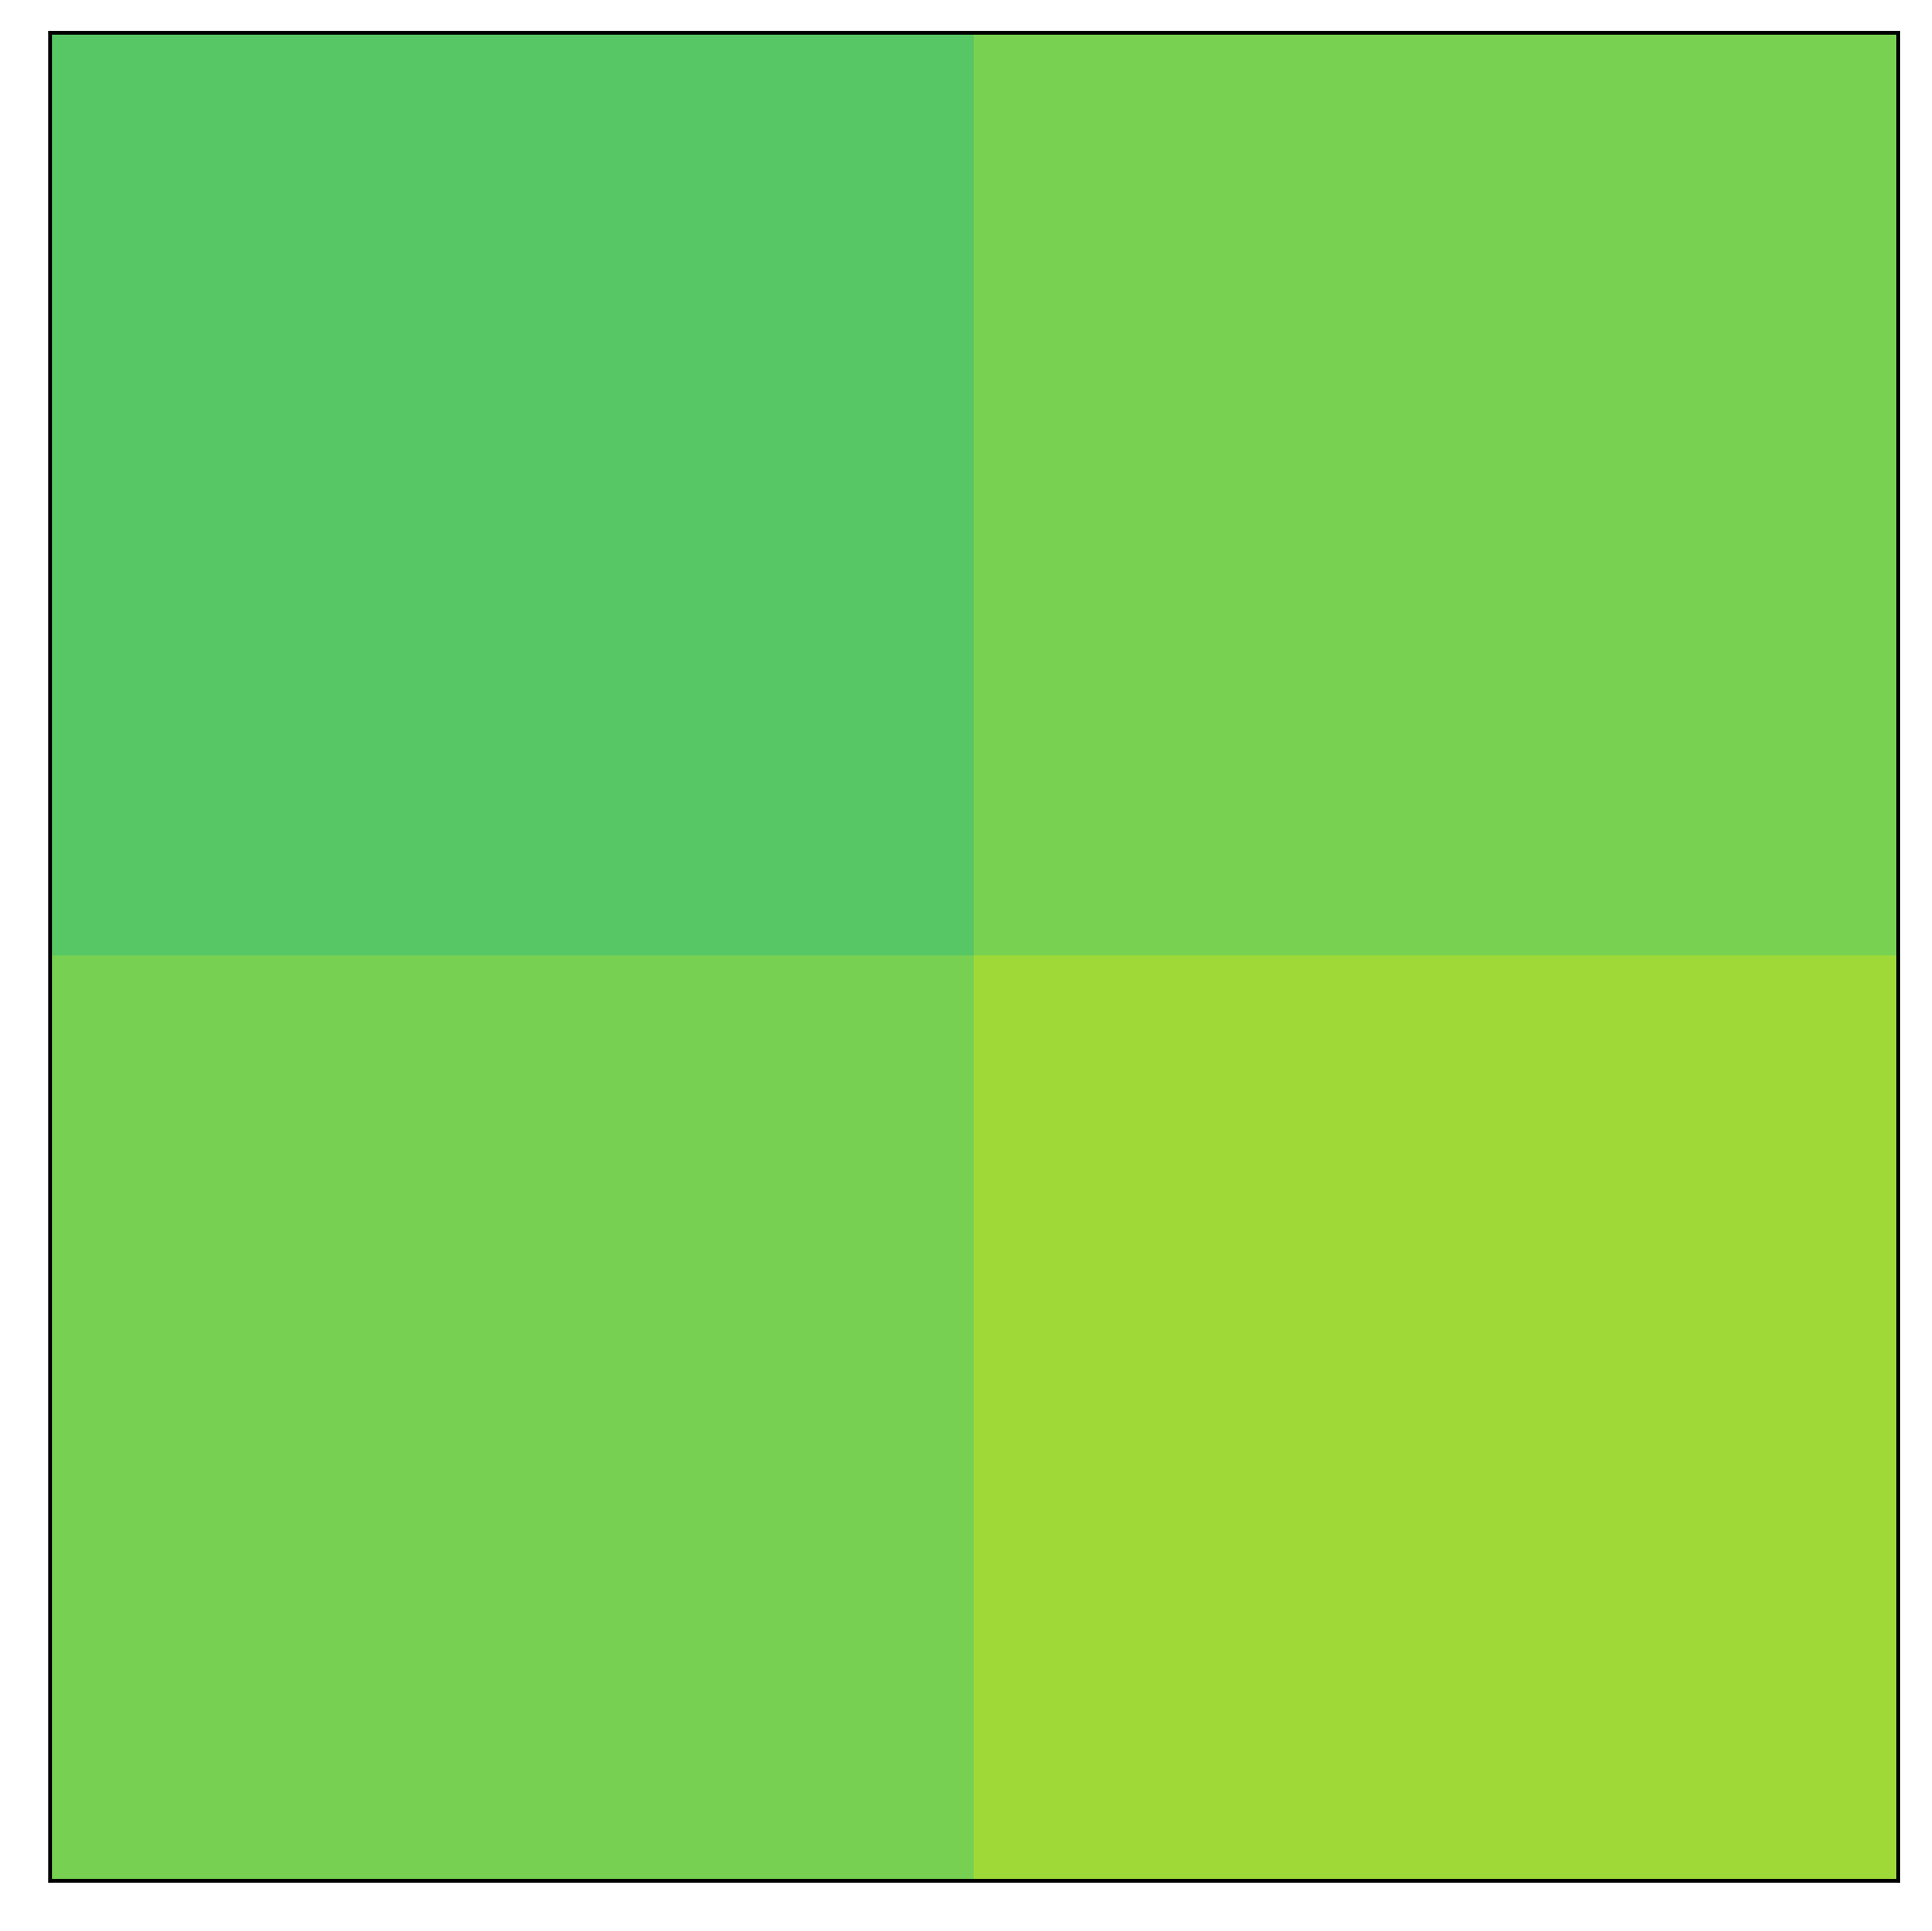

layer3-0-conv2


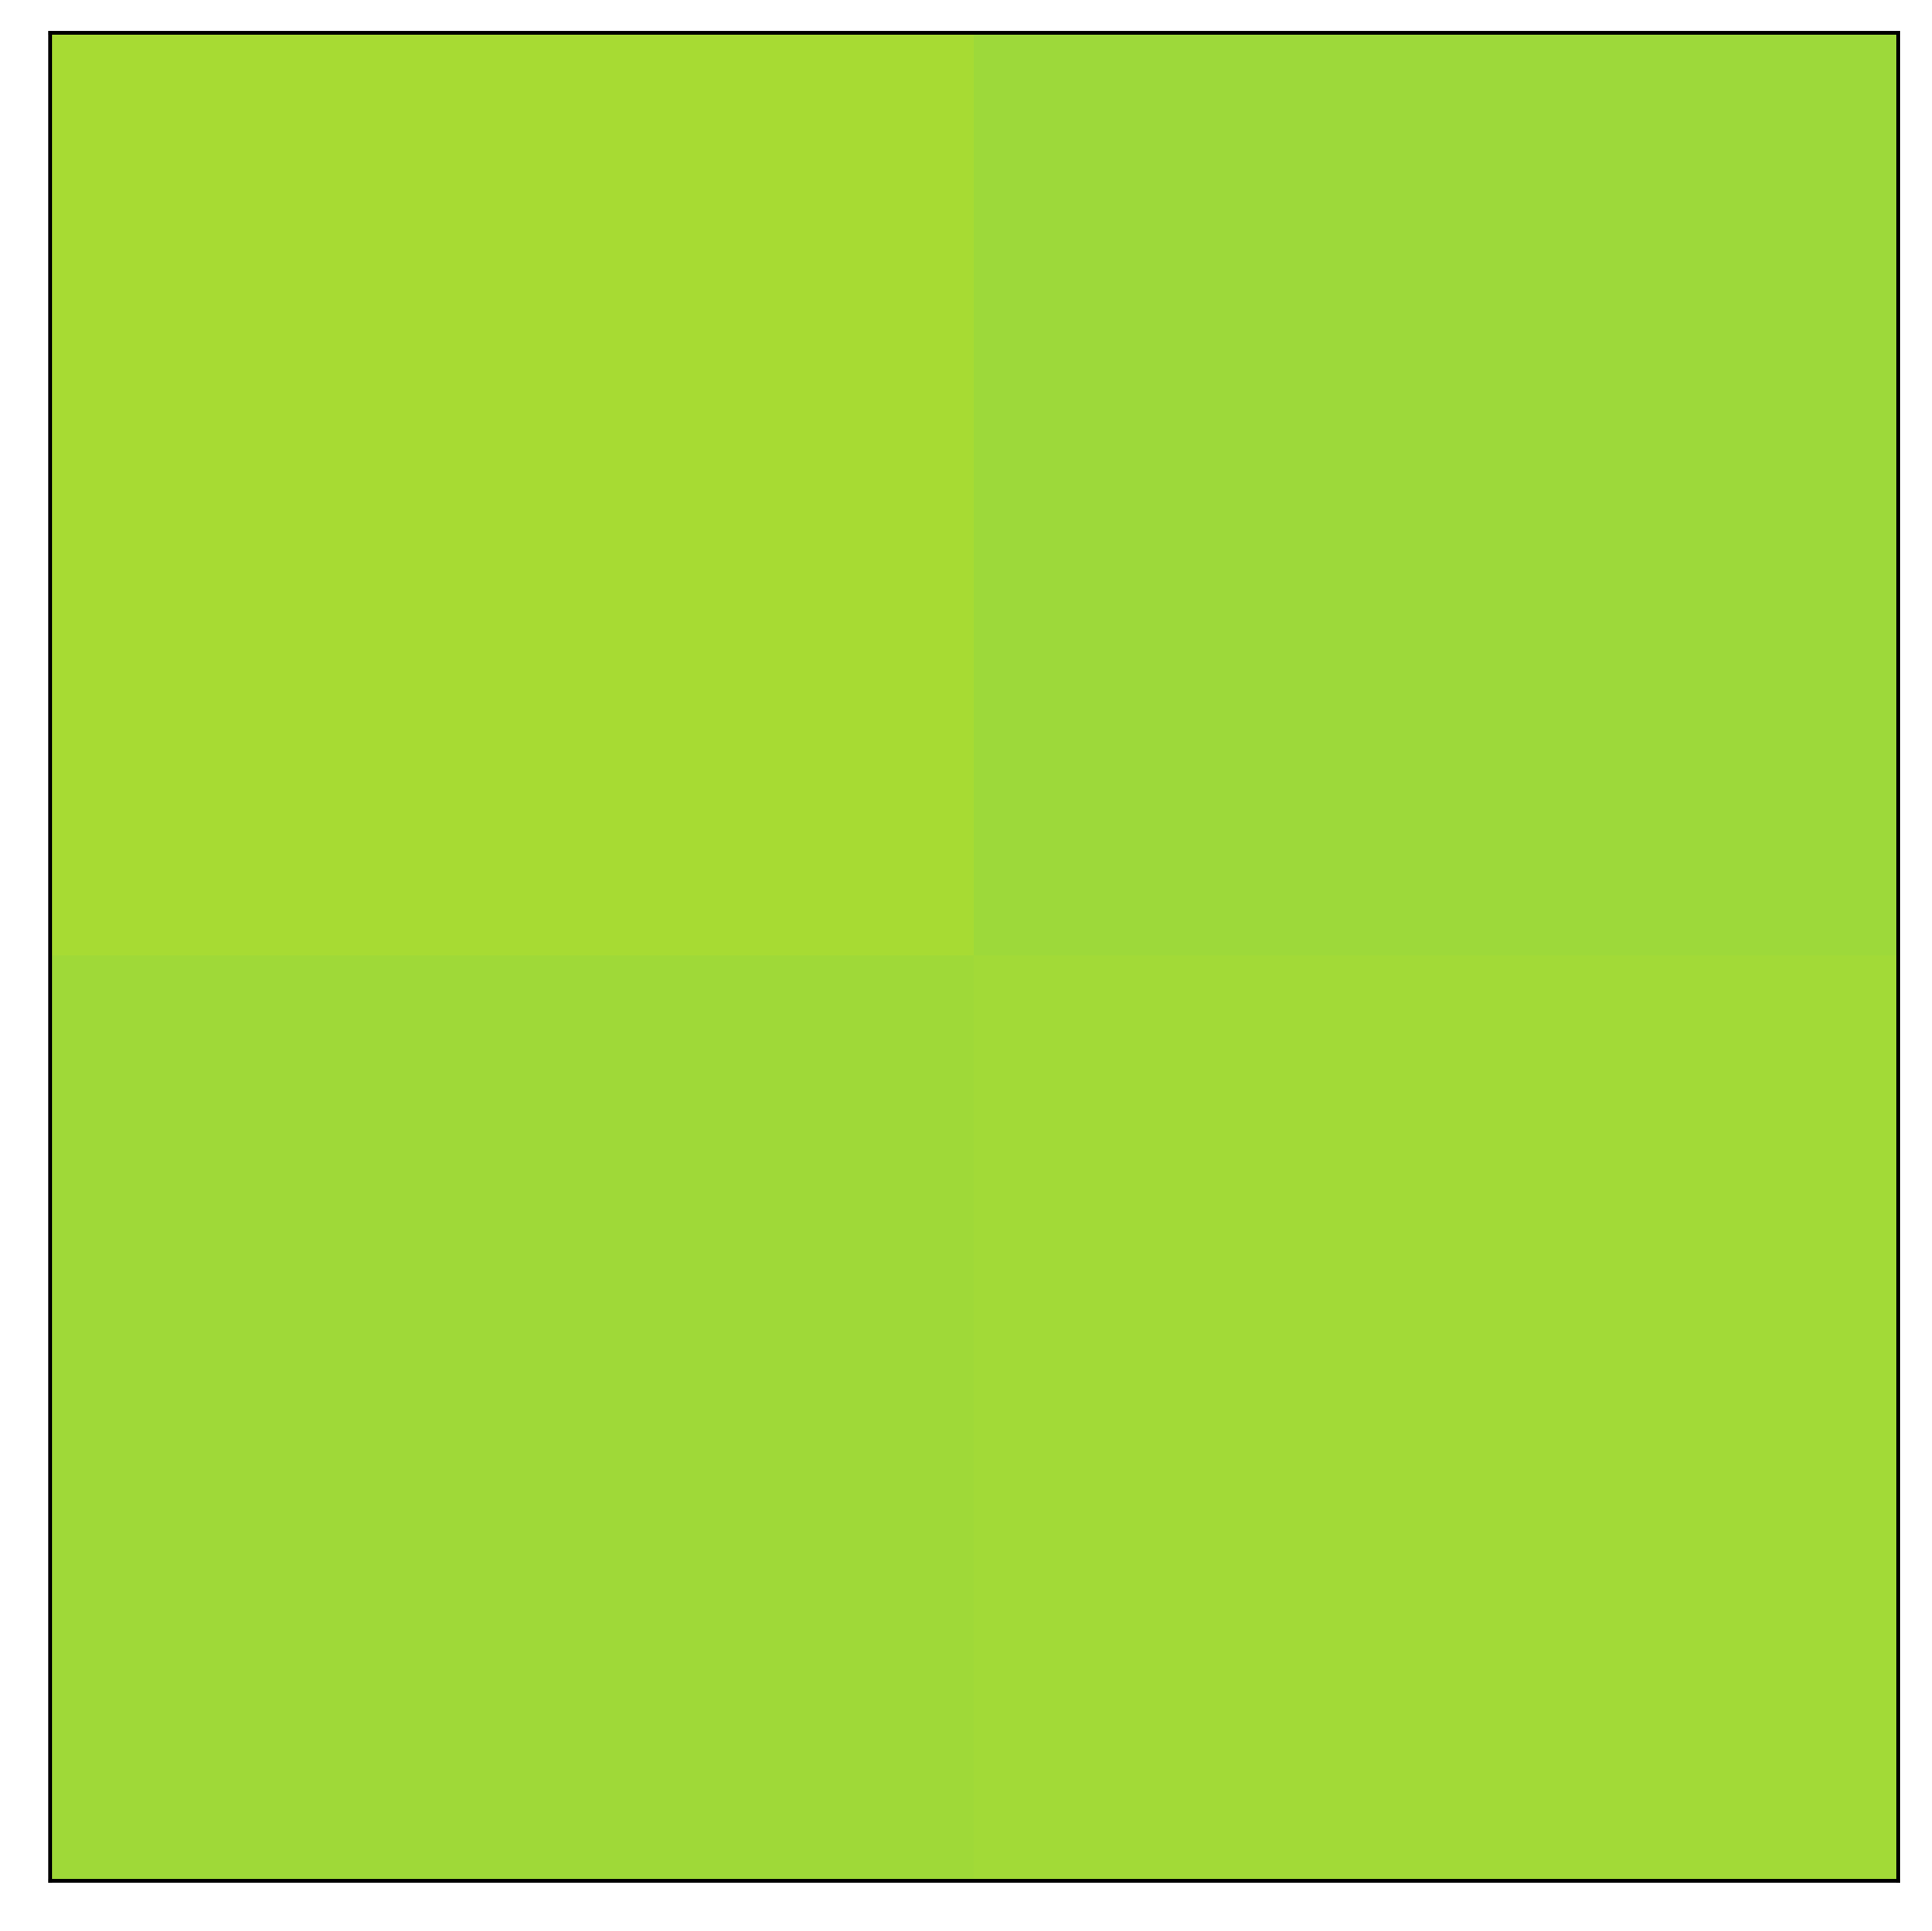

layer3-1-conv1


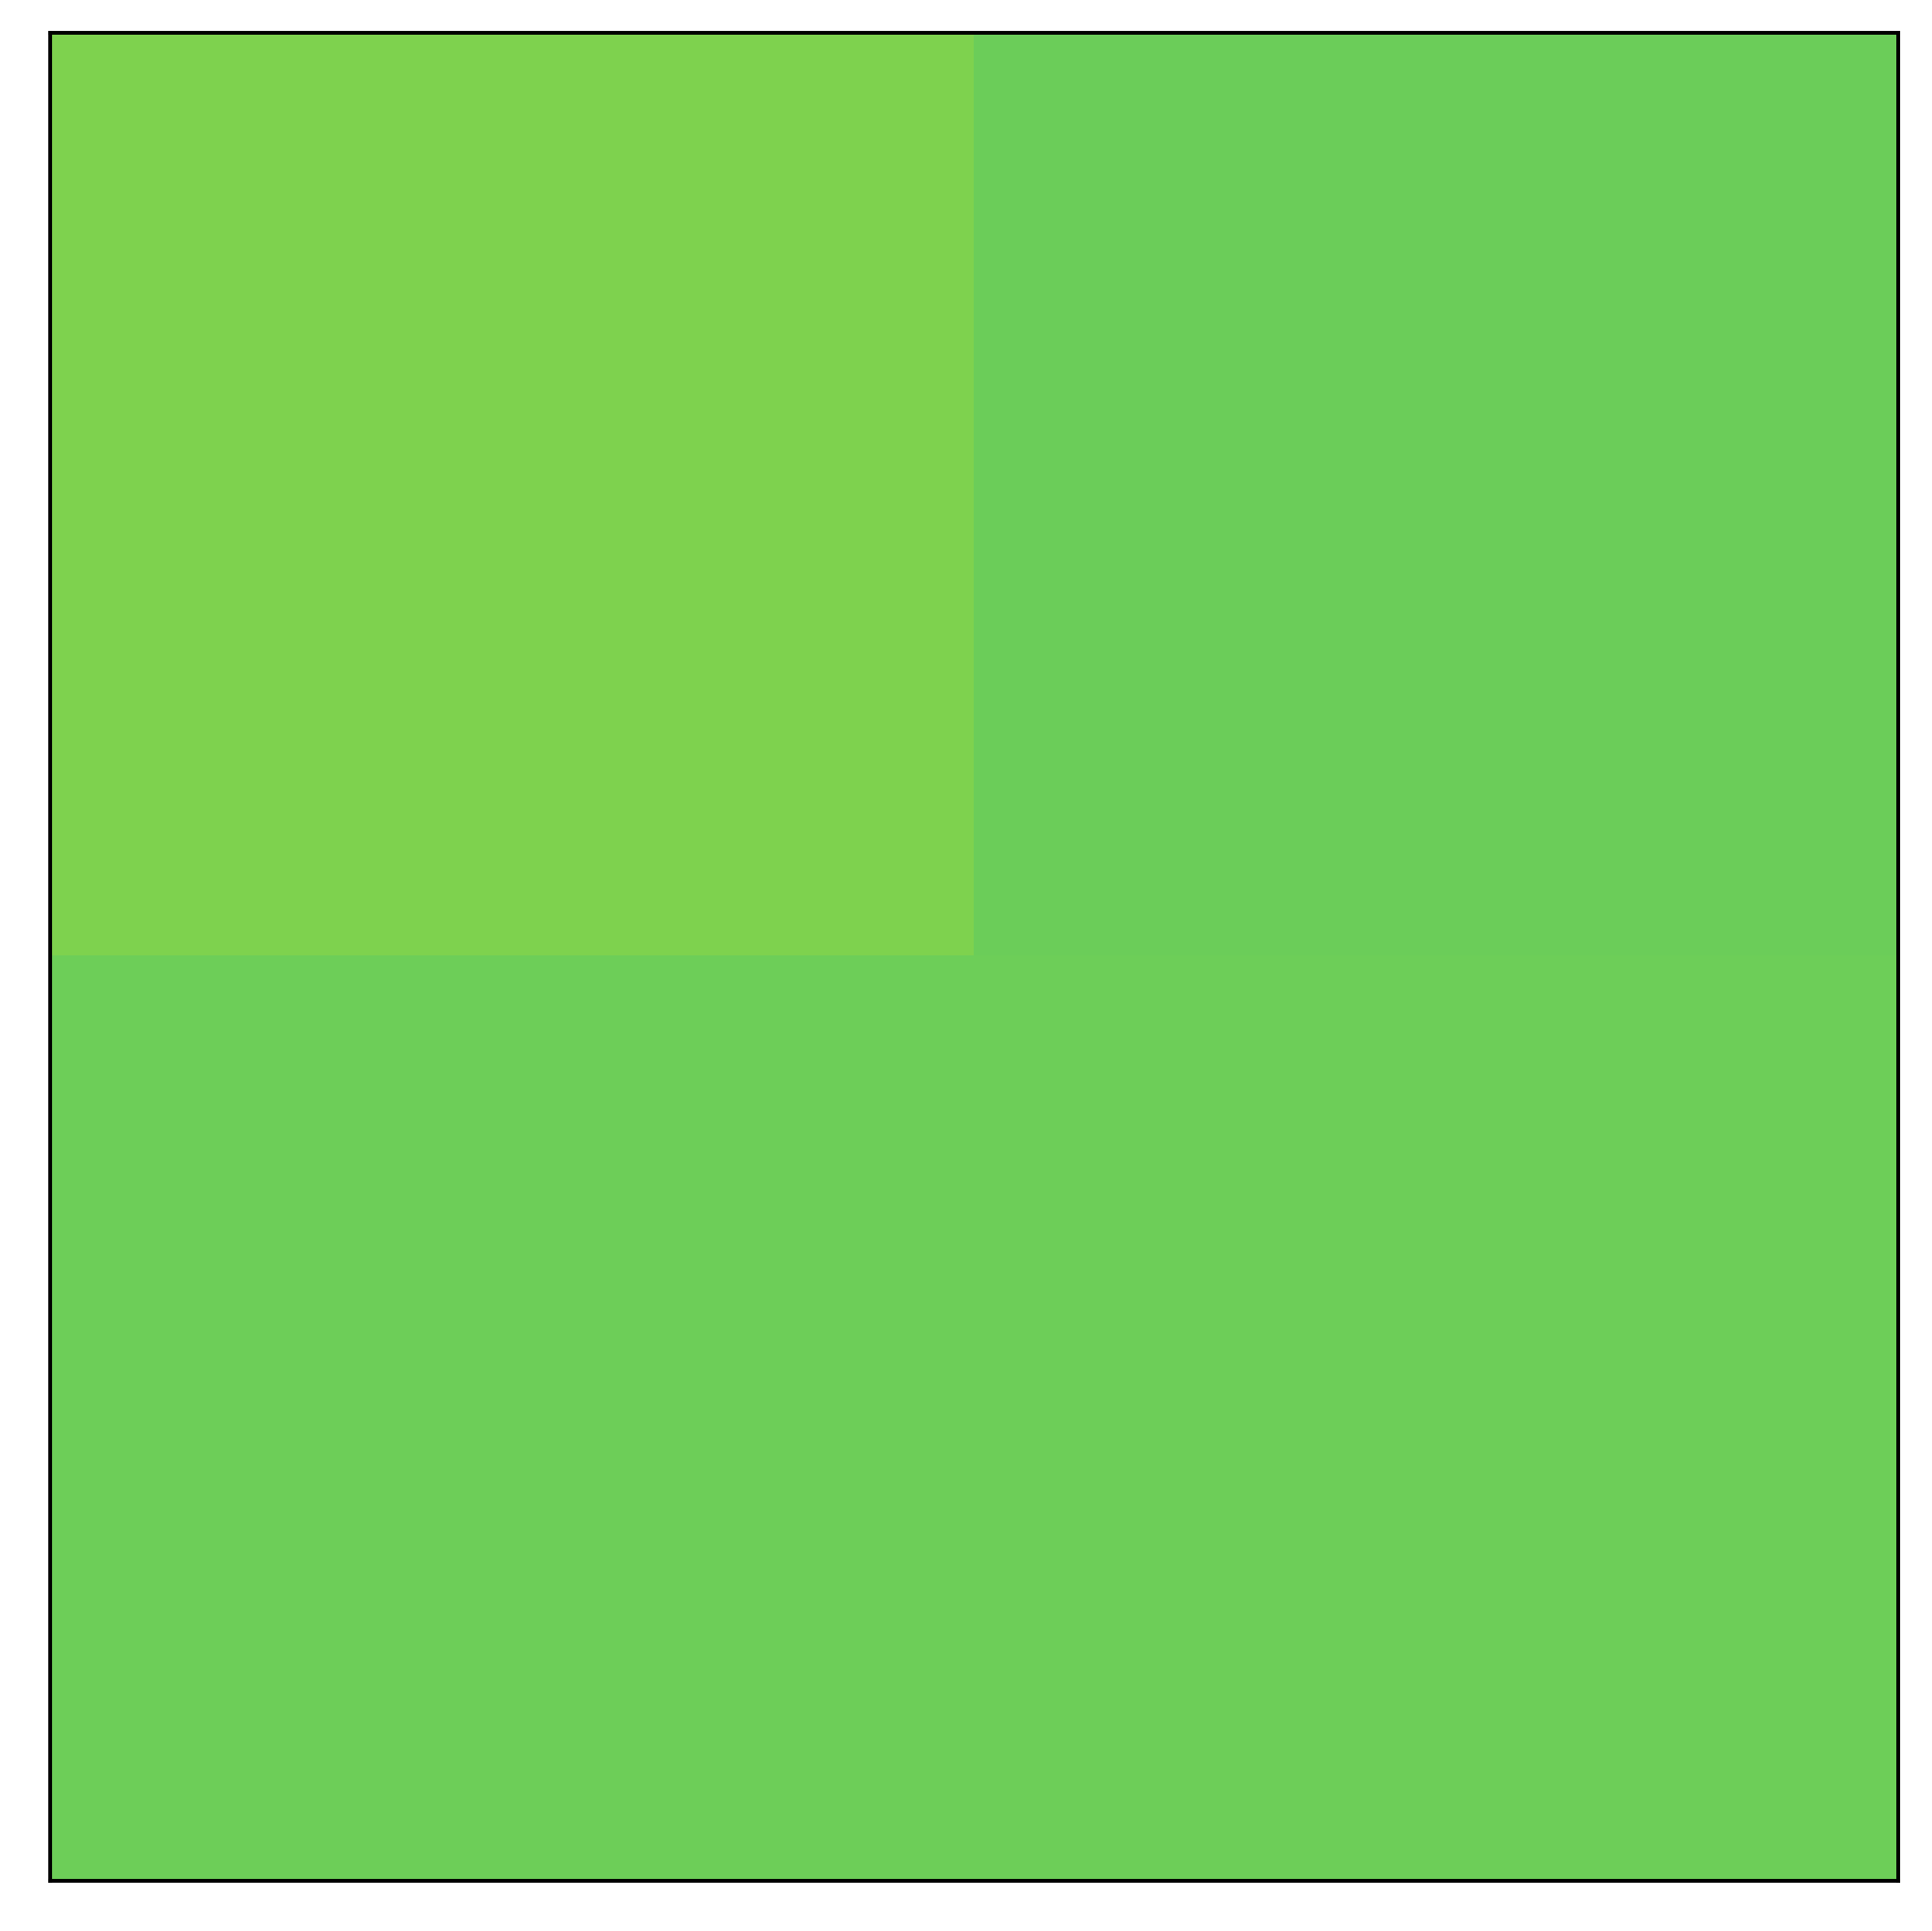

layer3-1-conv2


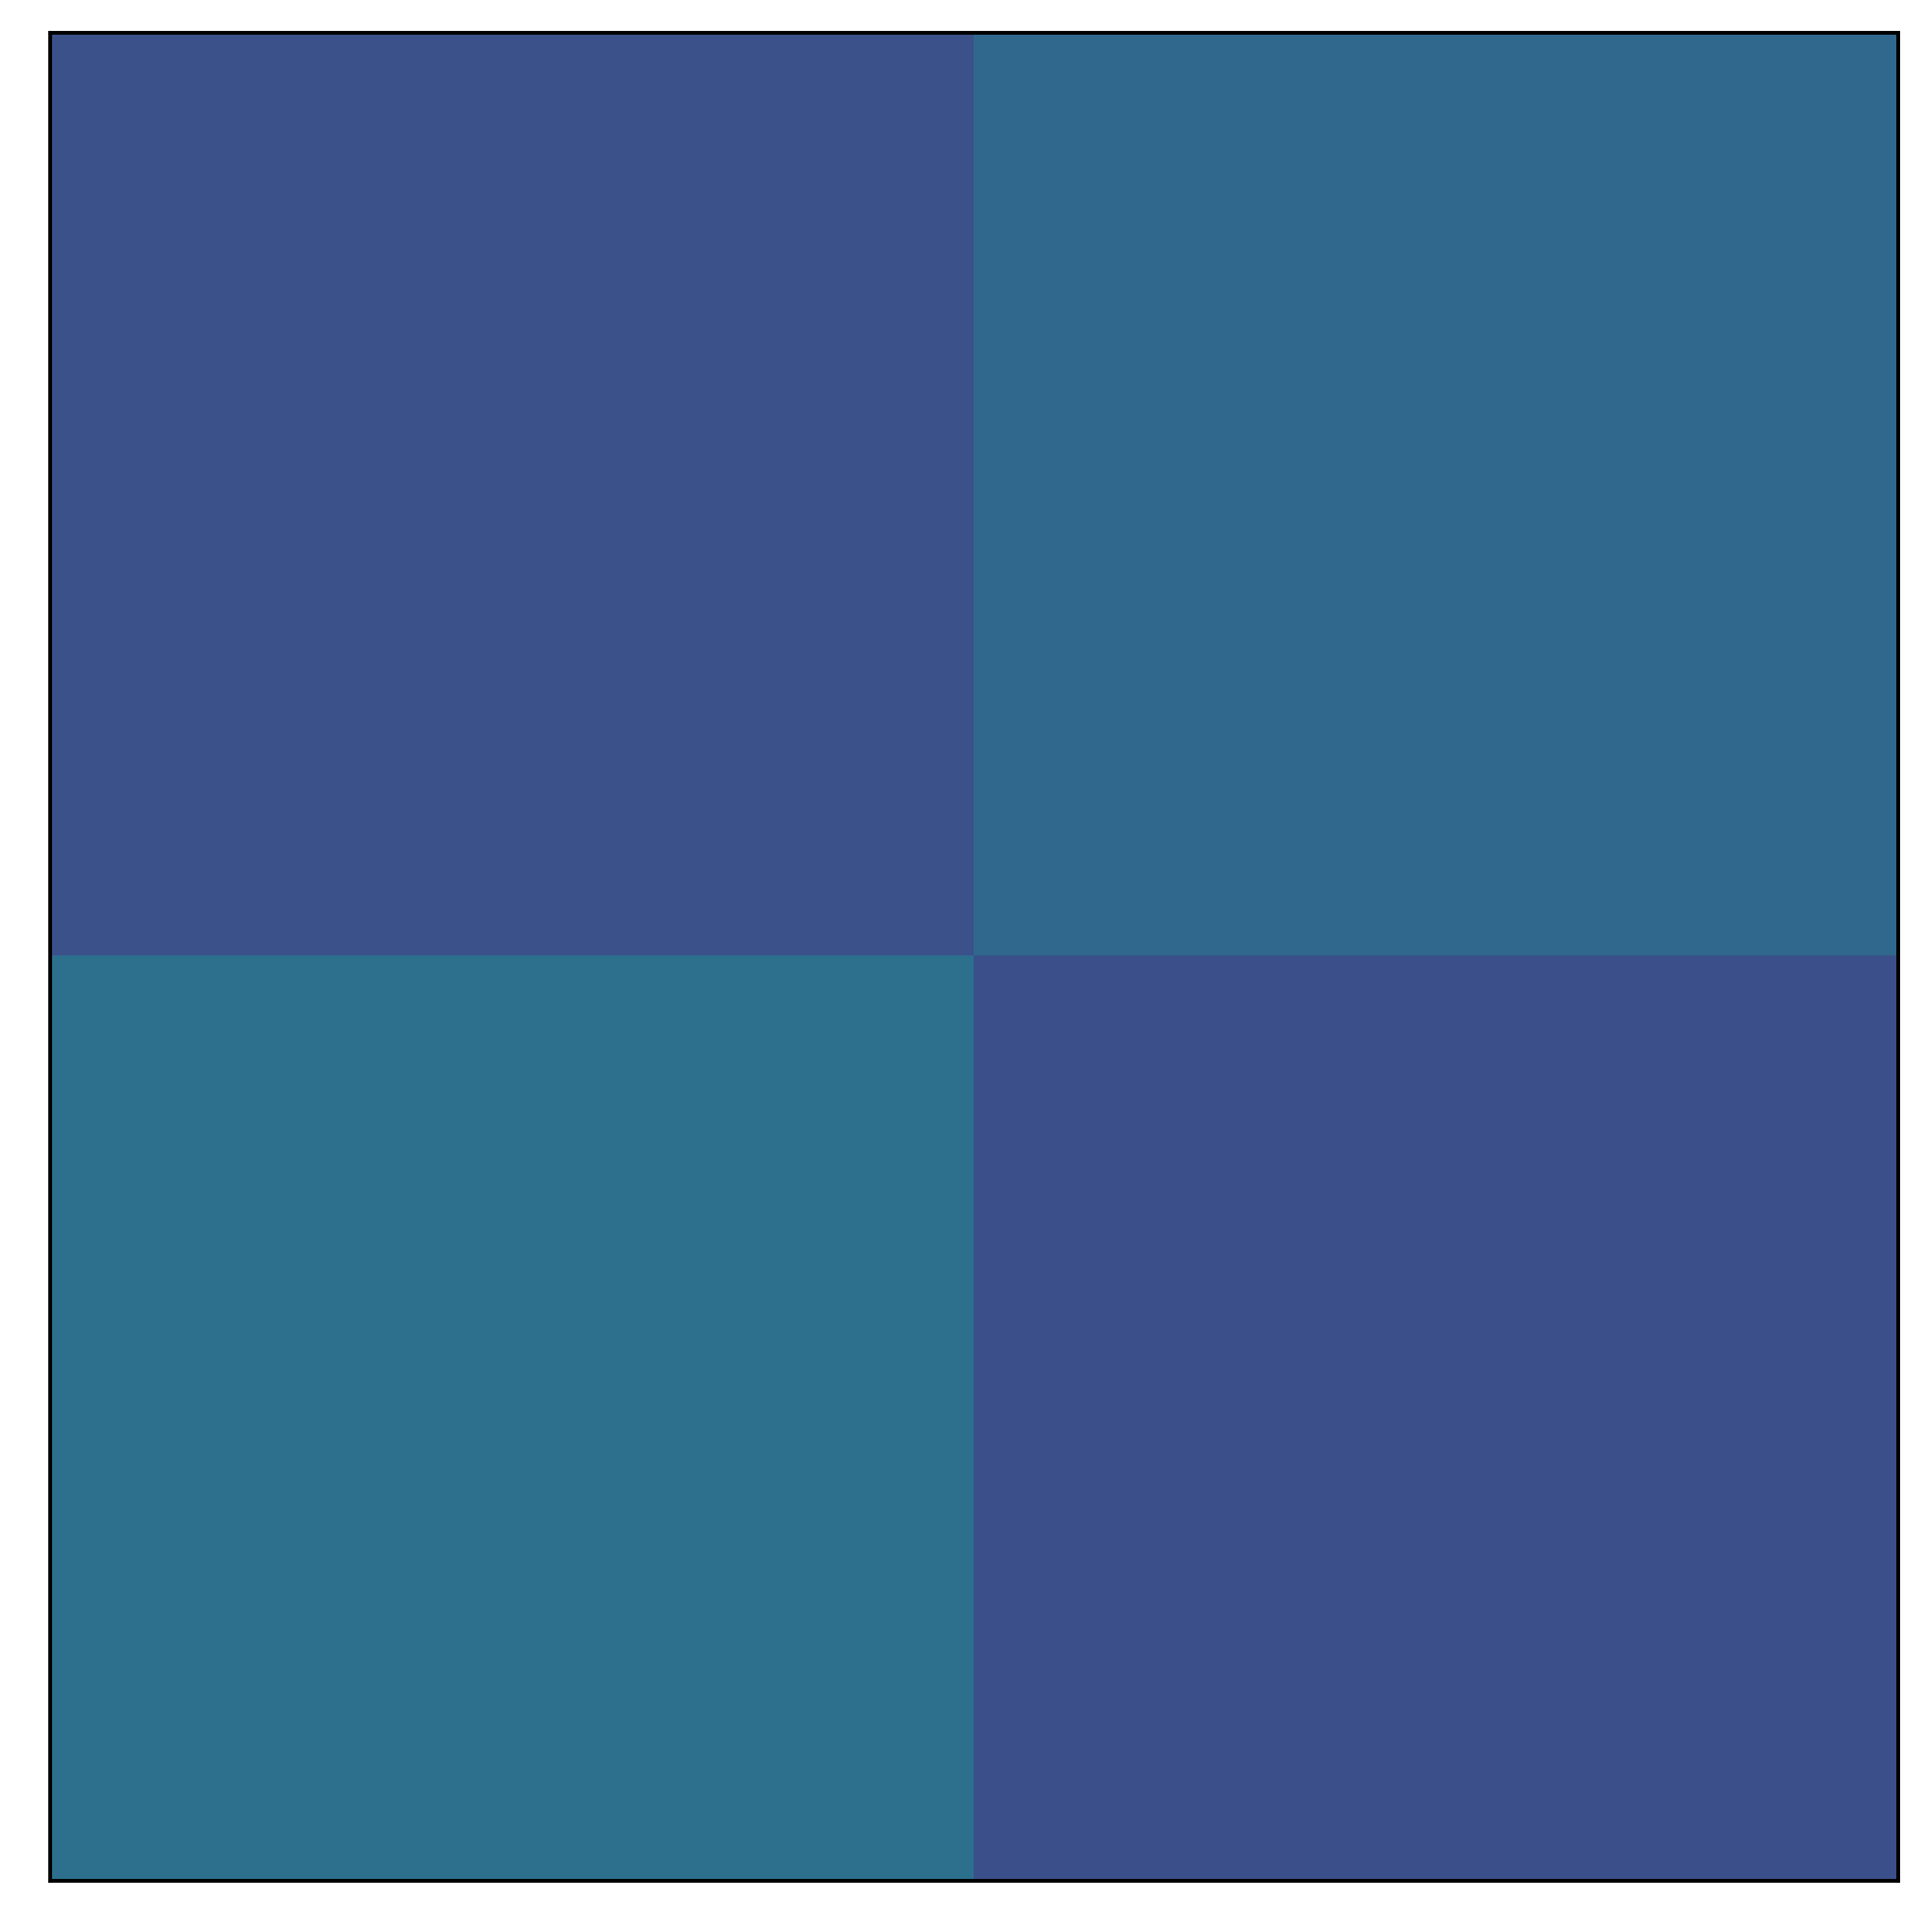

layer4-0-conv1


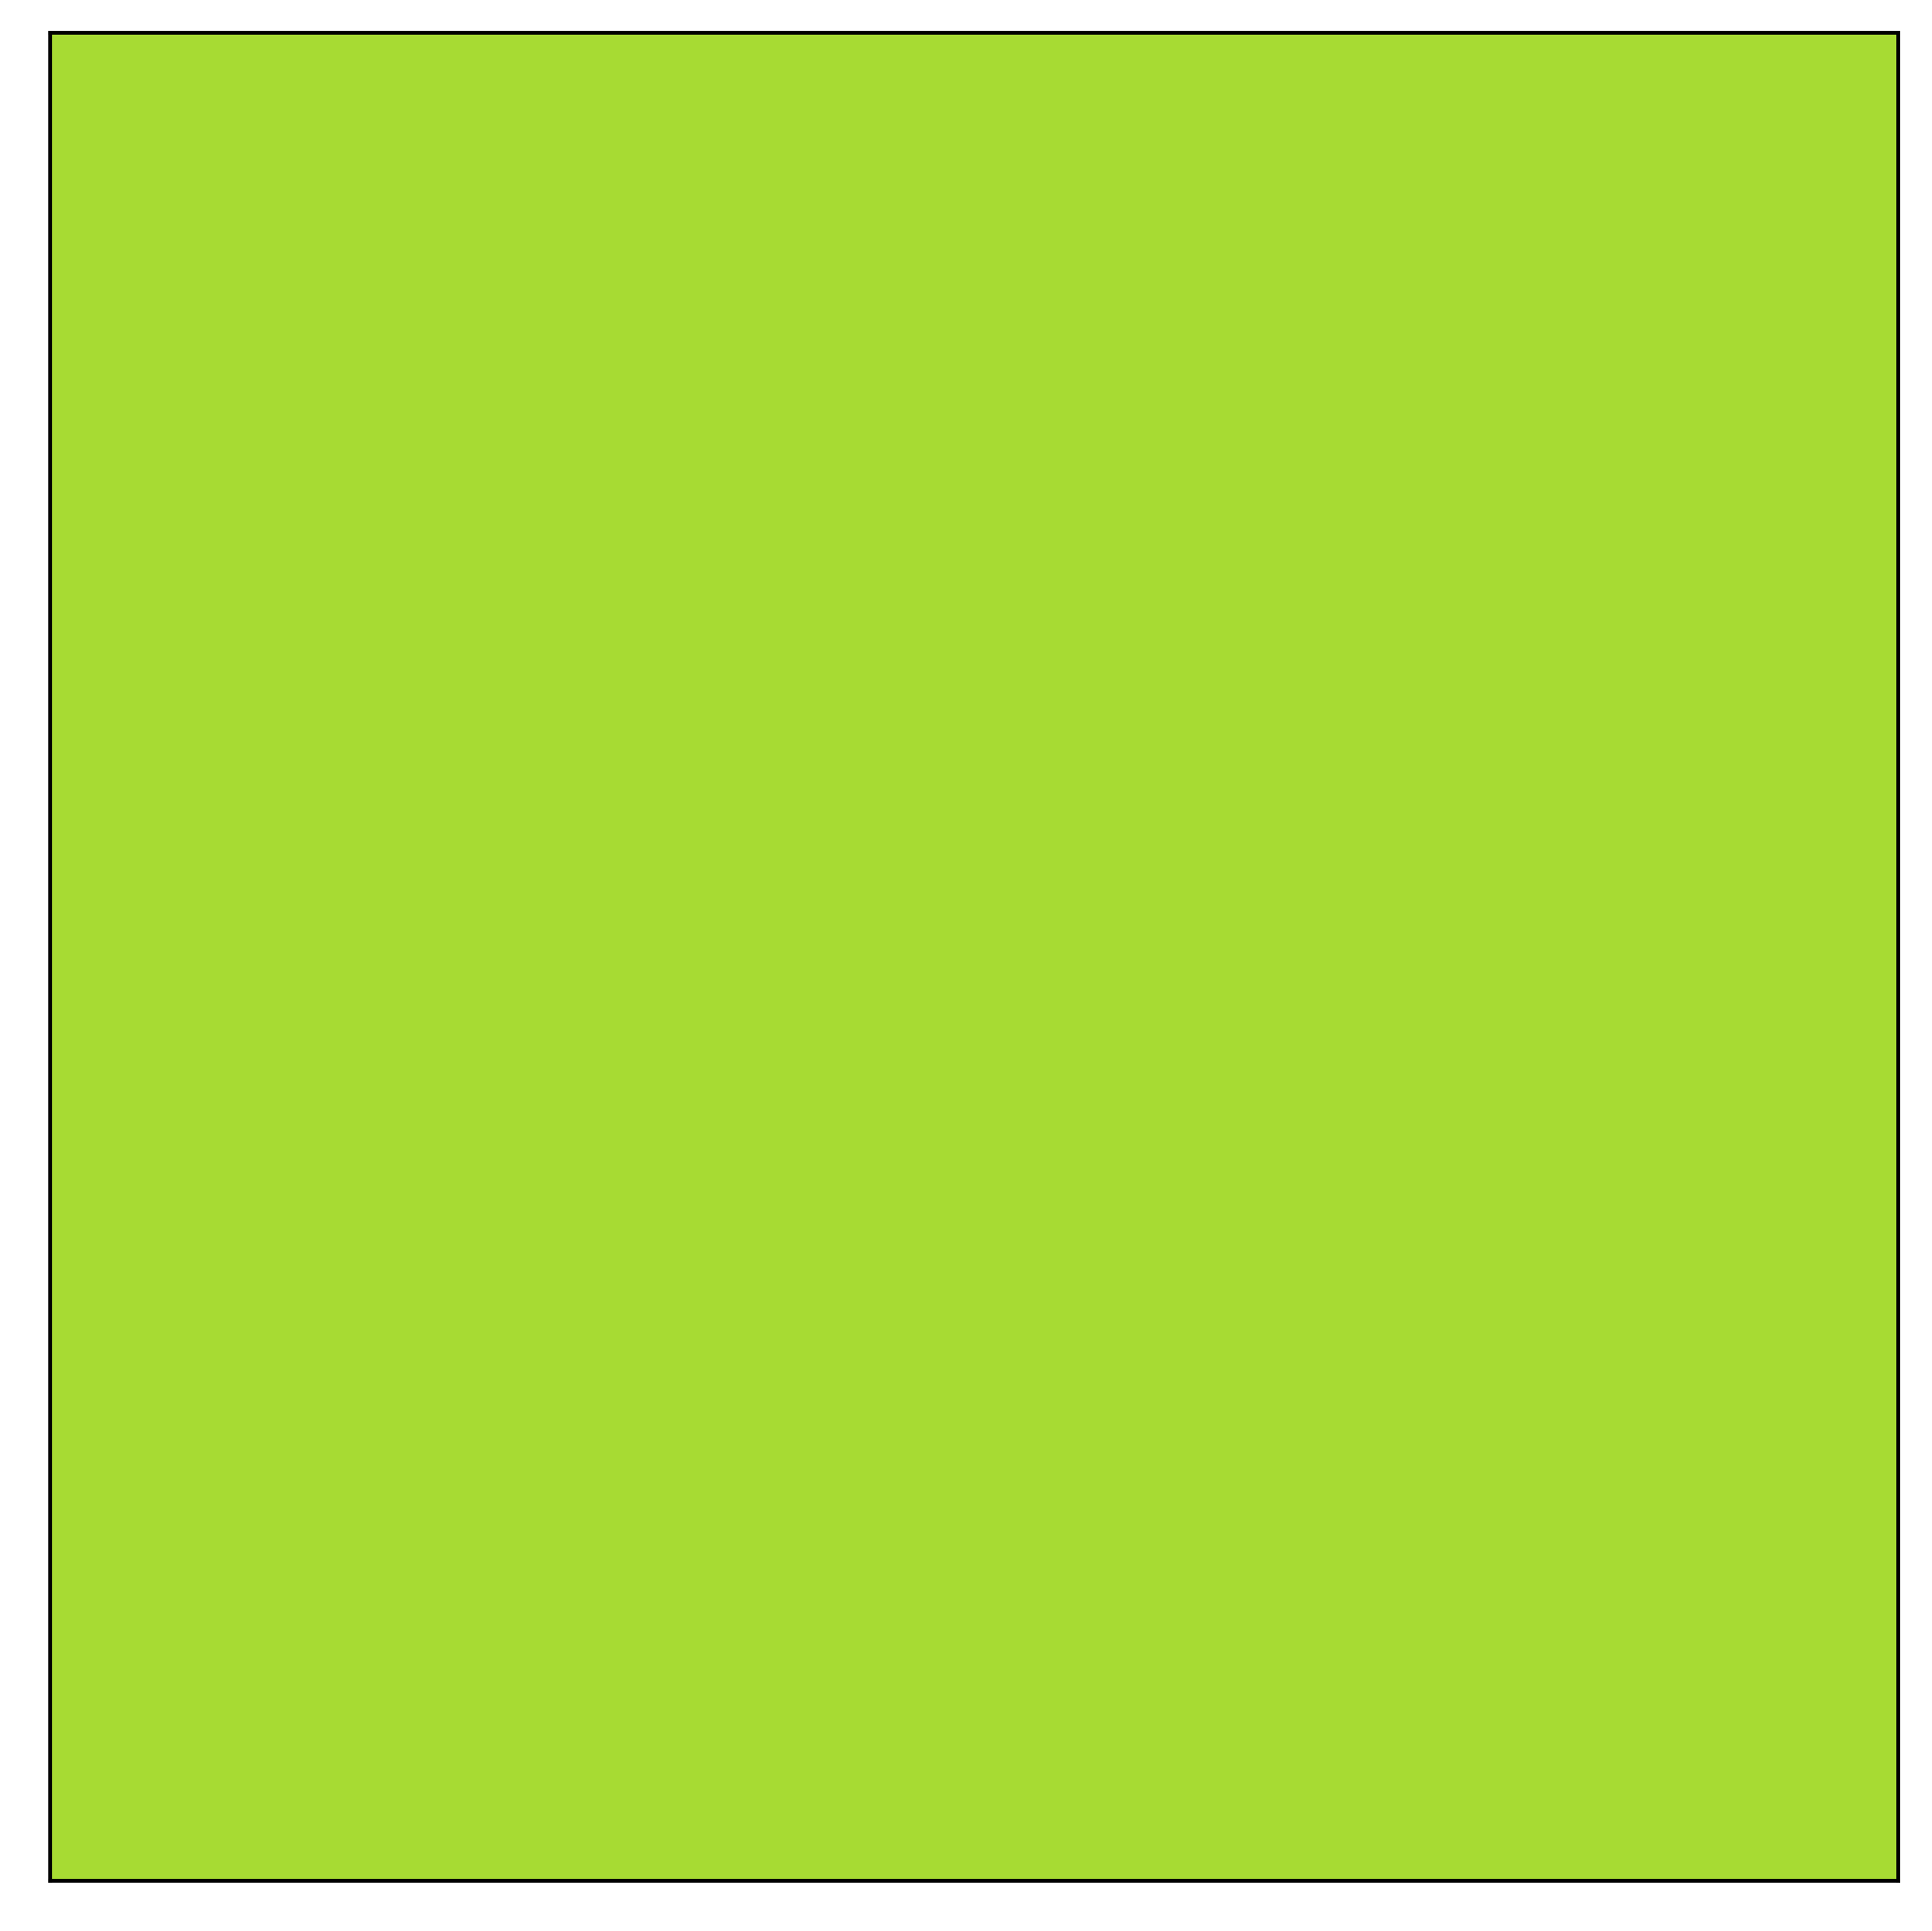

layer4-0-conv2


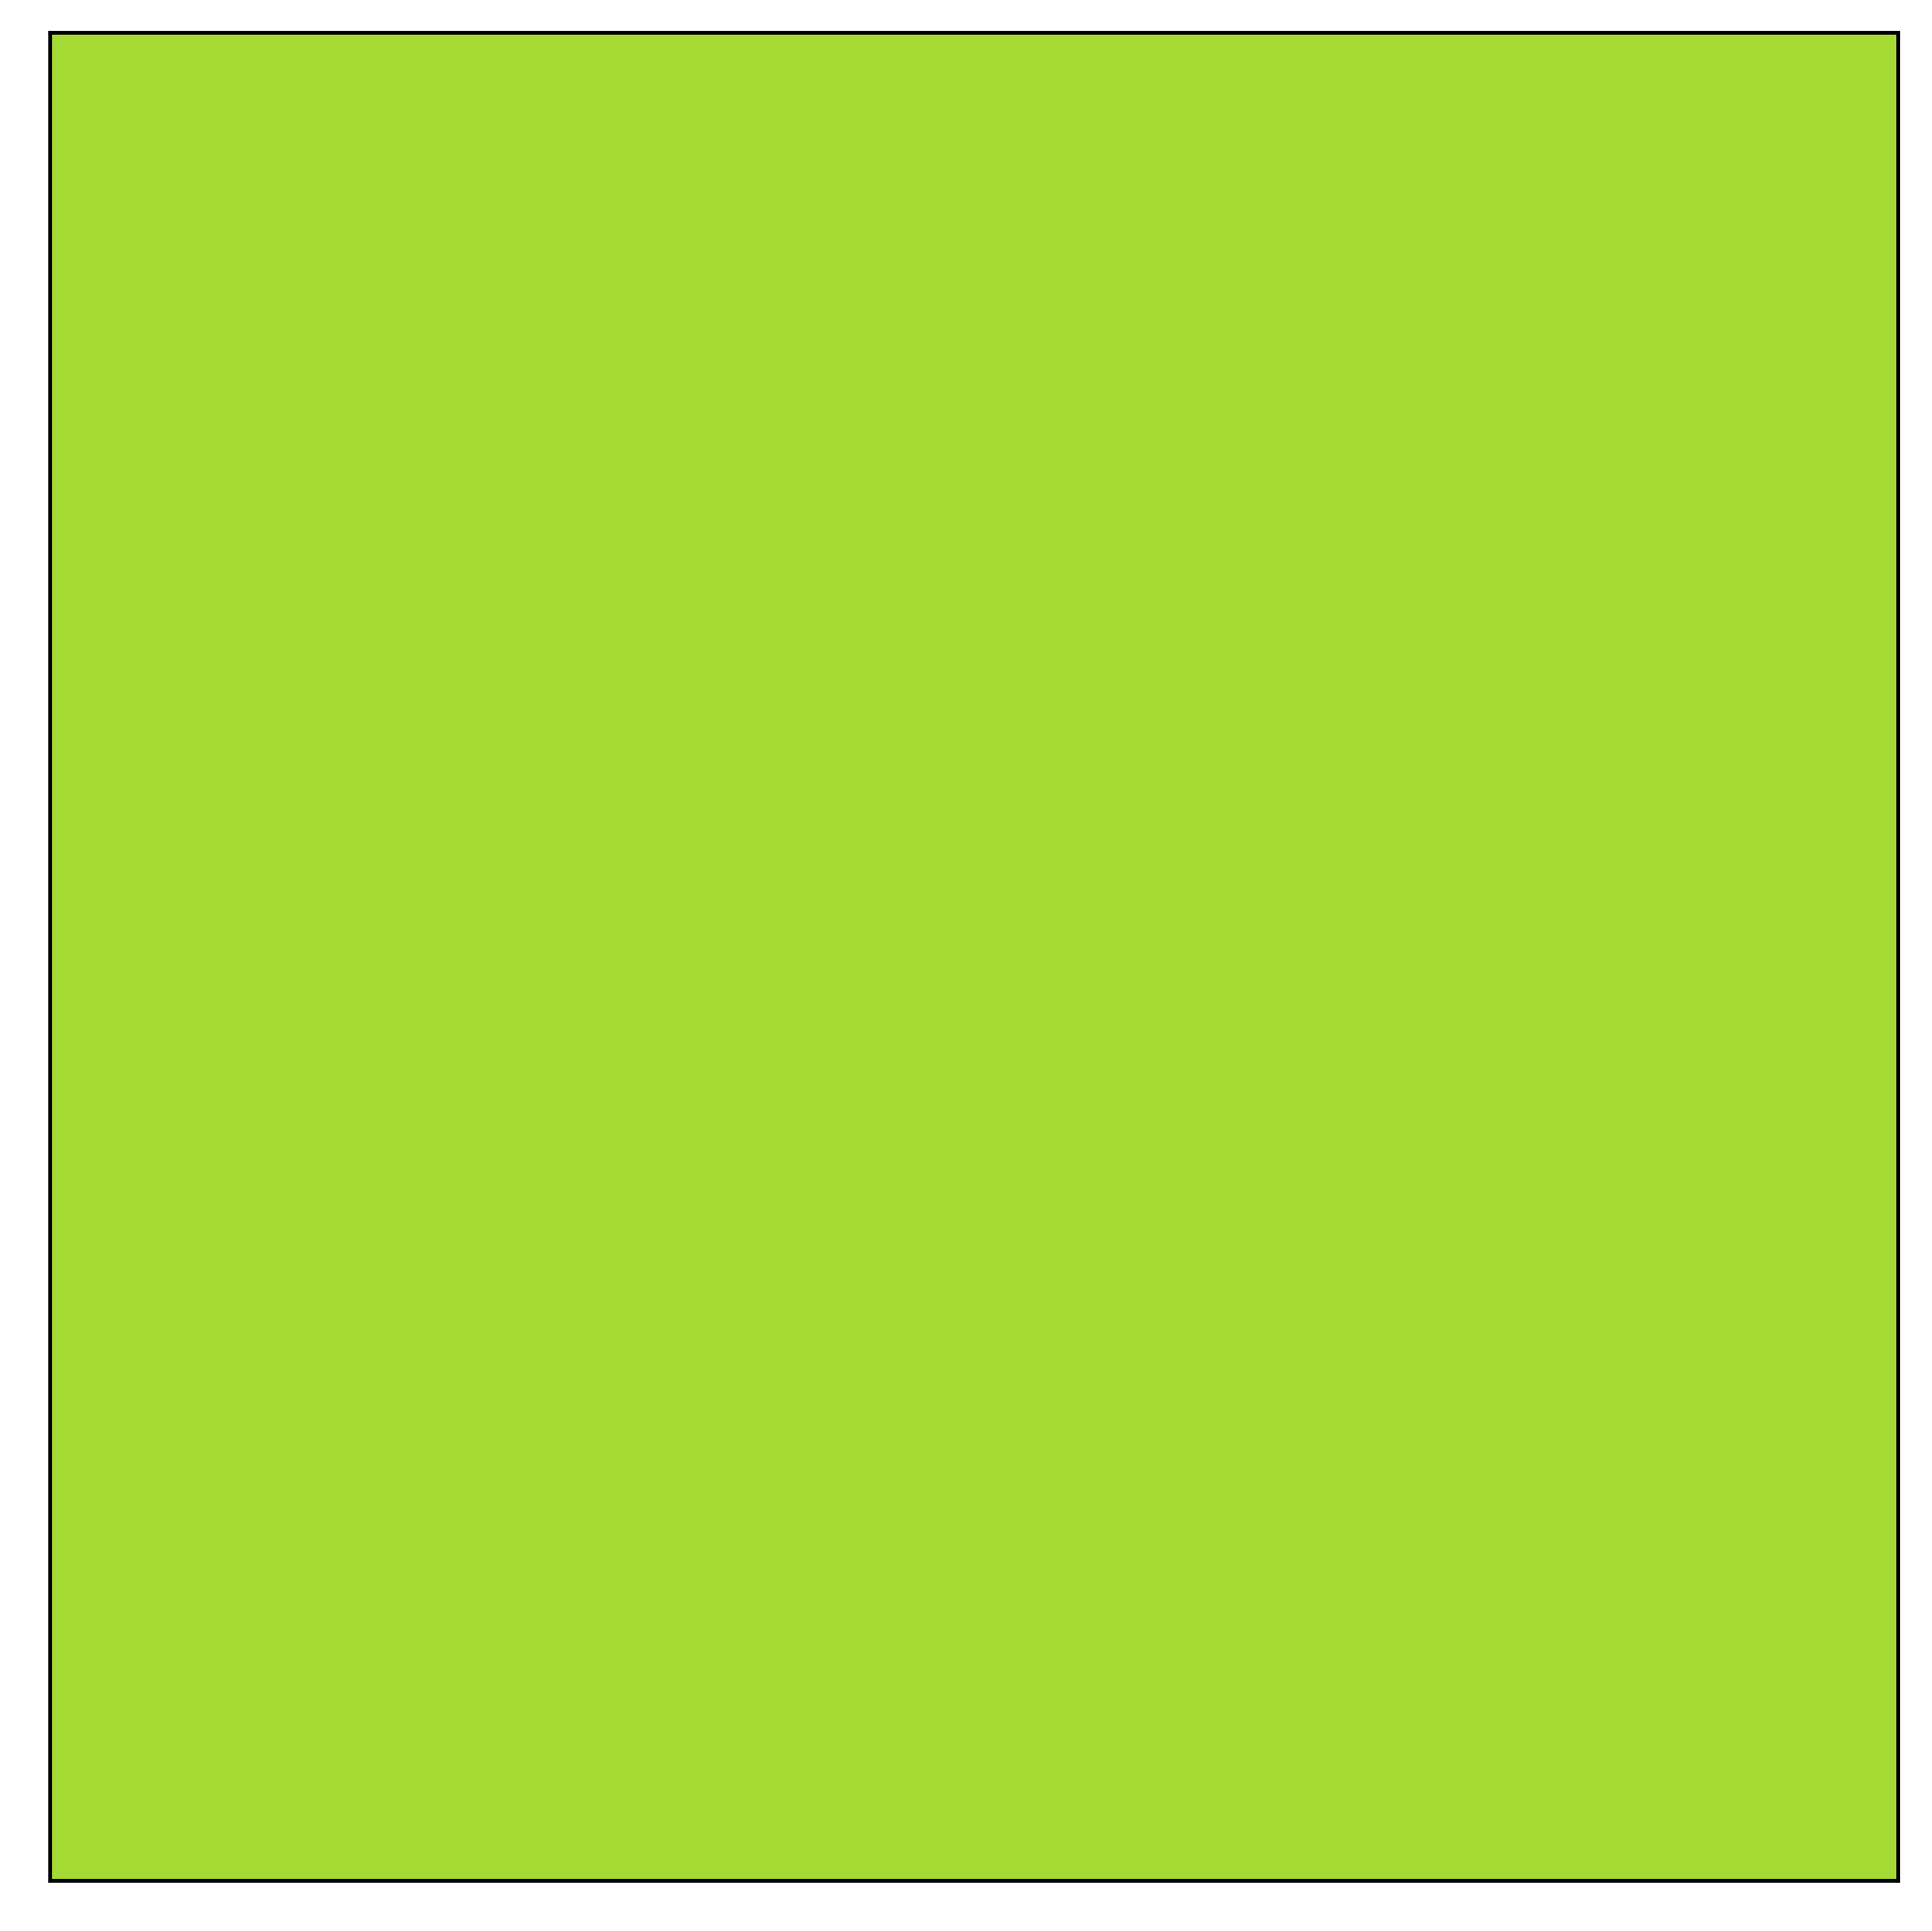

layer4-1-conv1


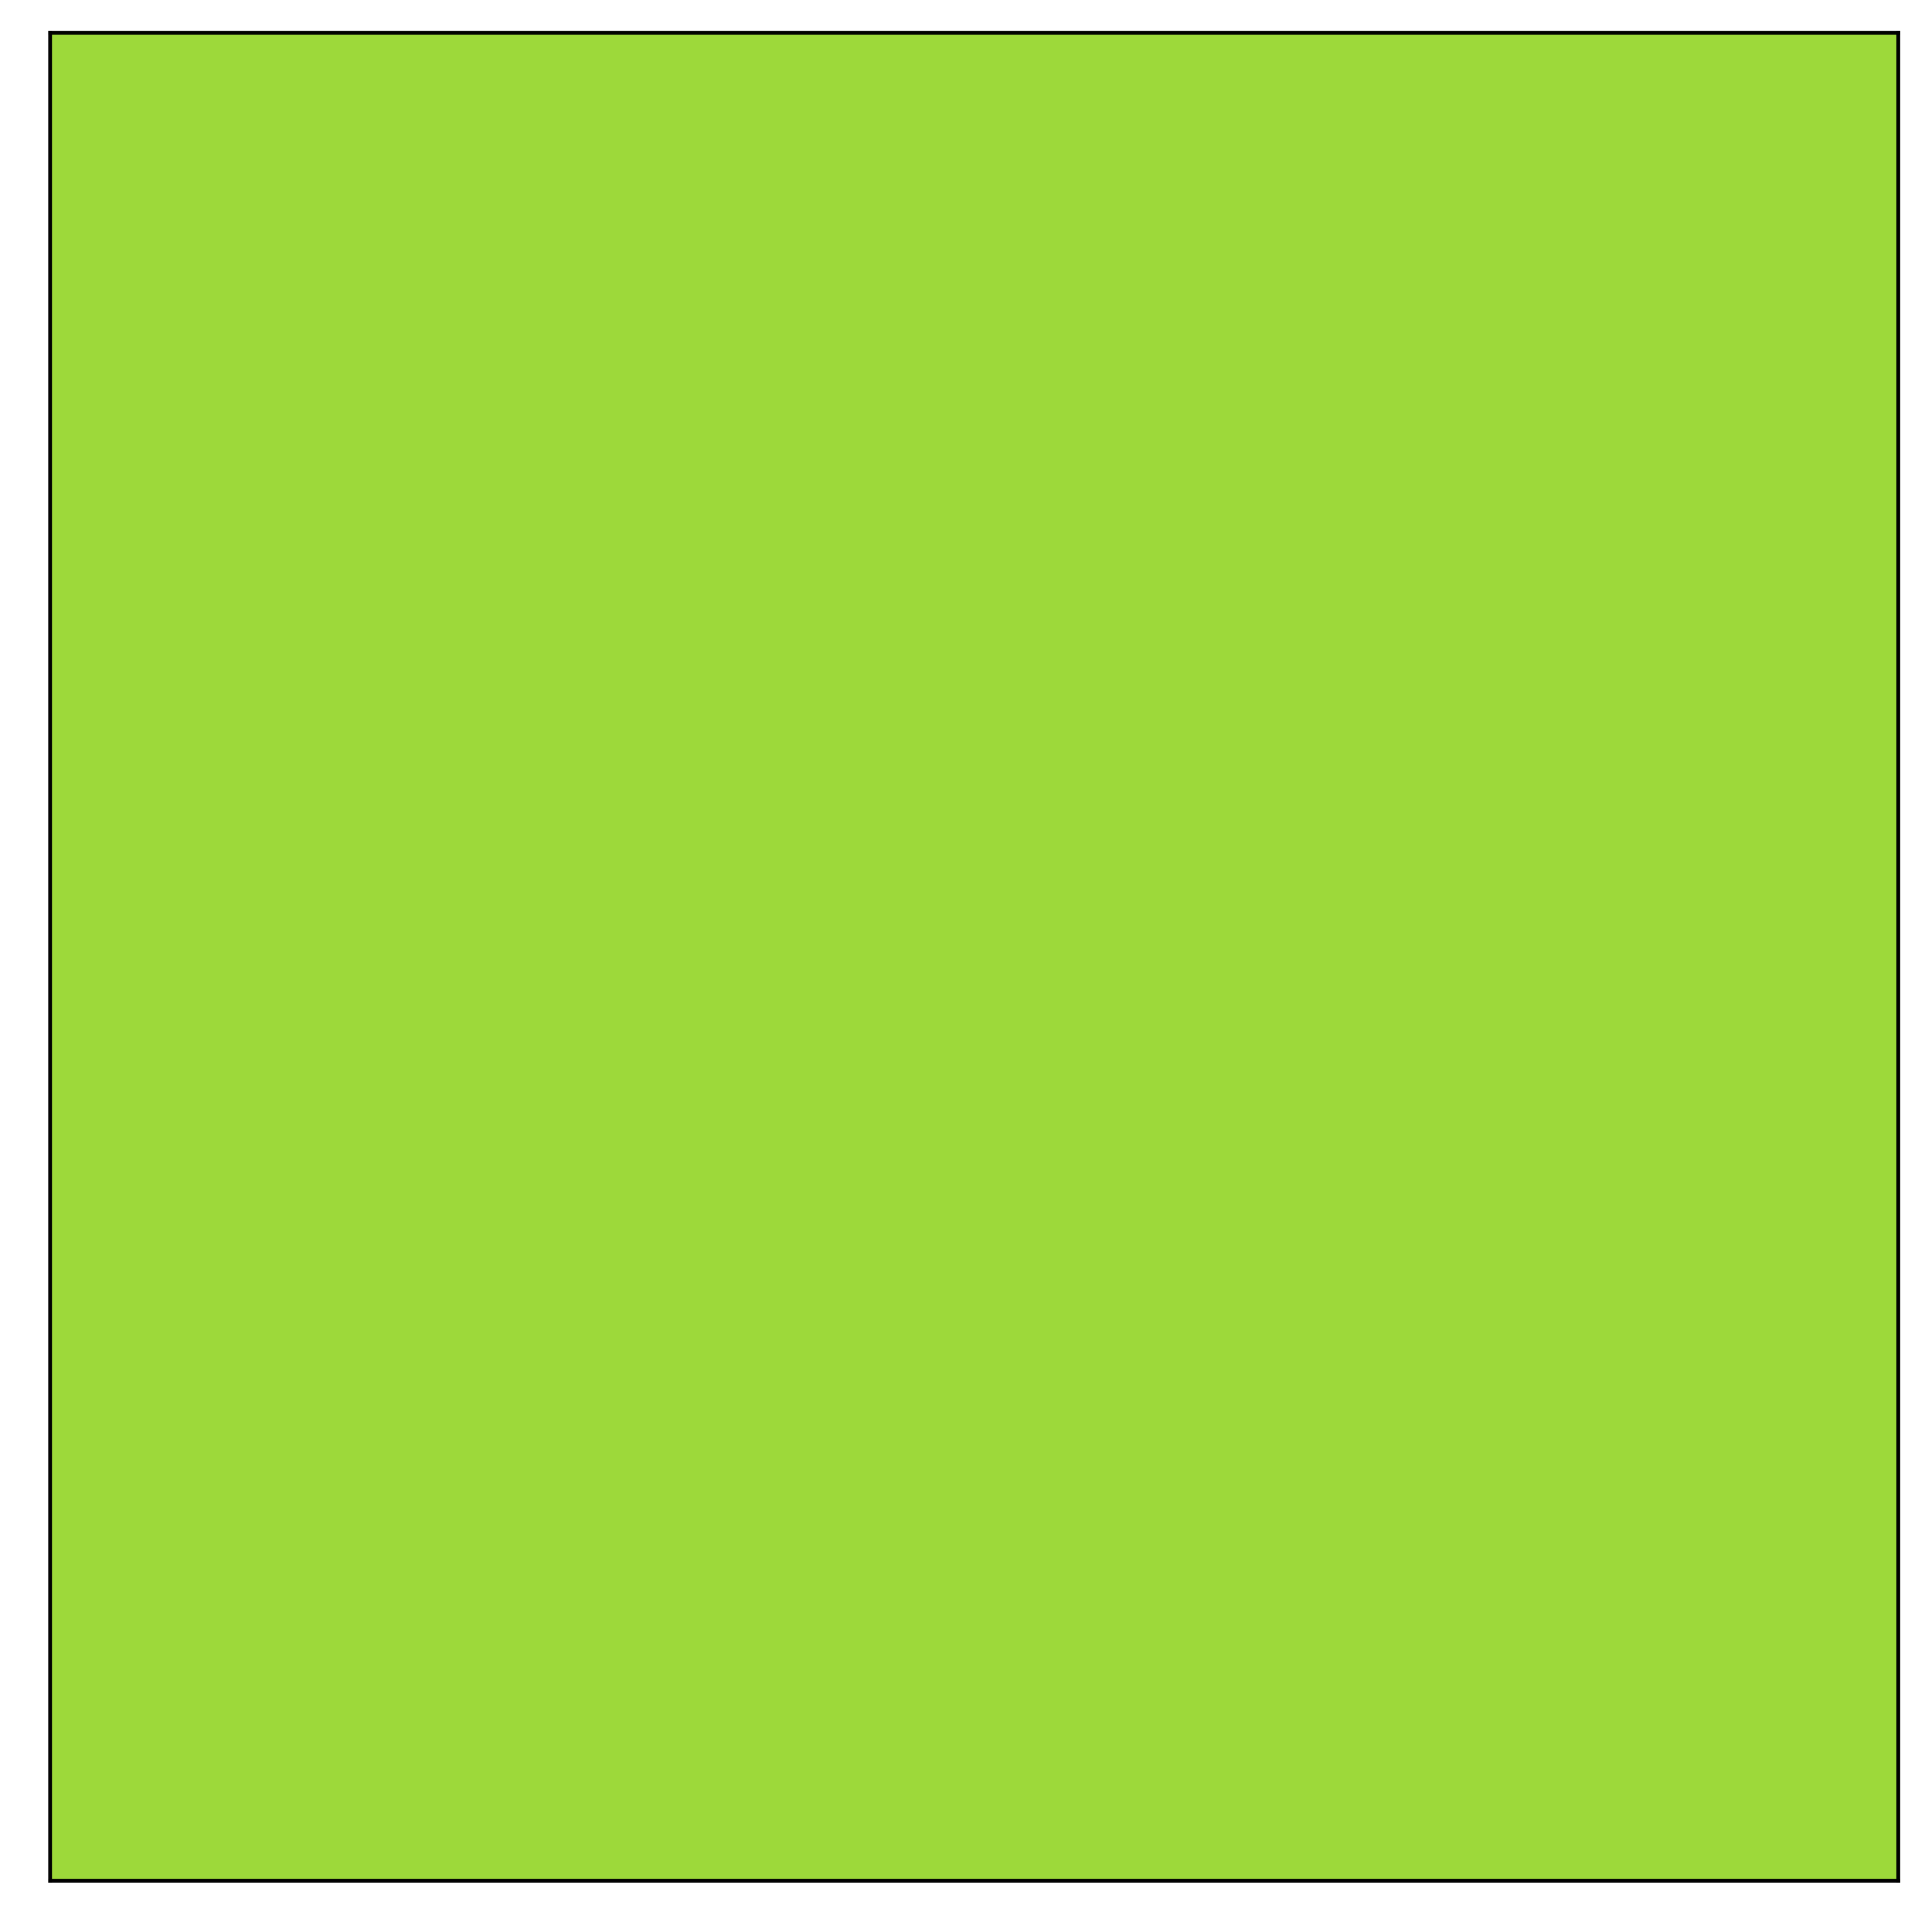

layer4-1-conv2


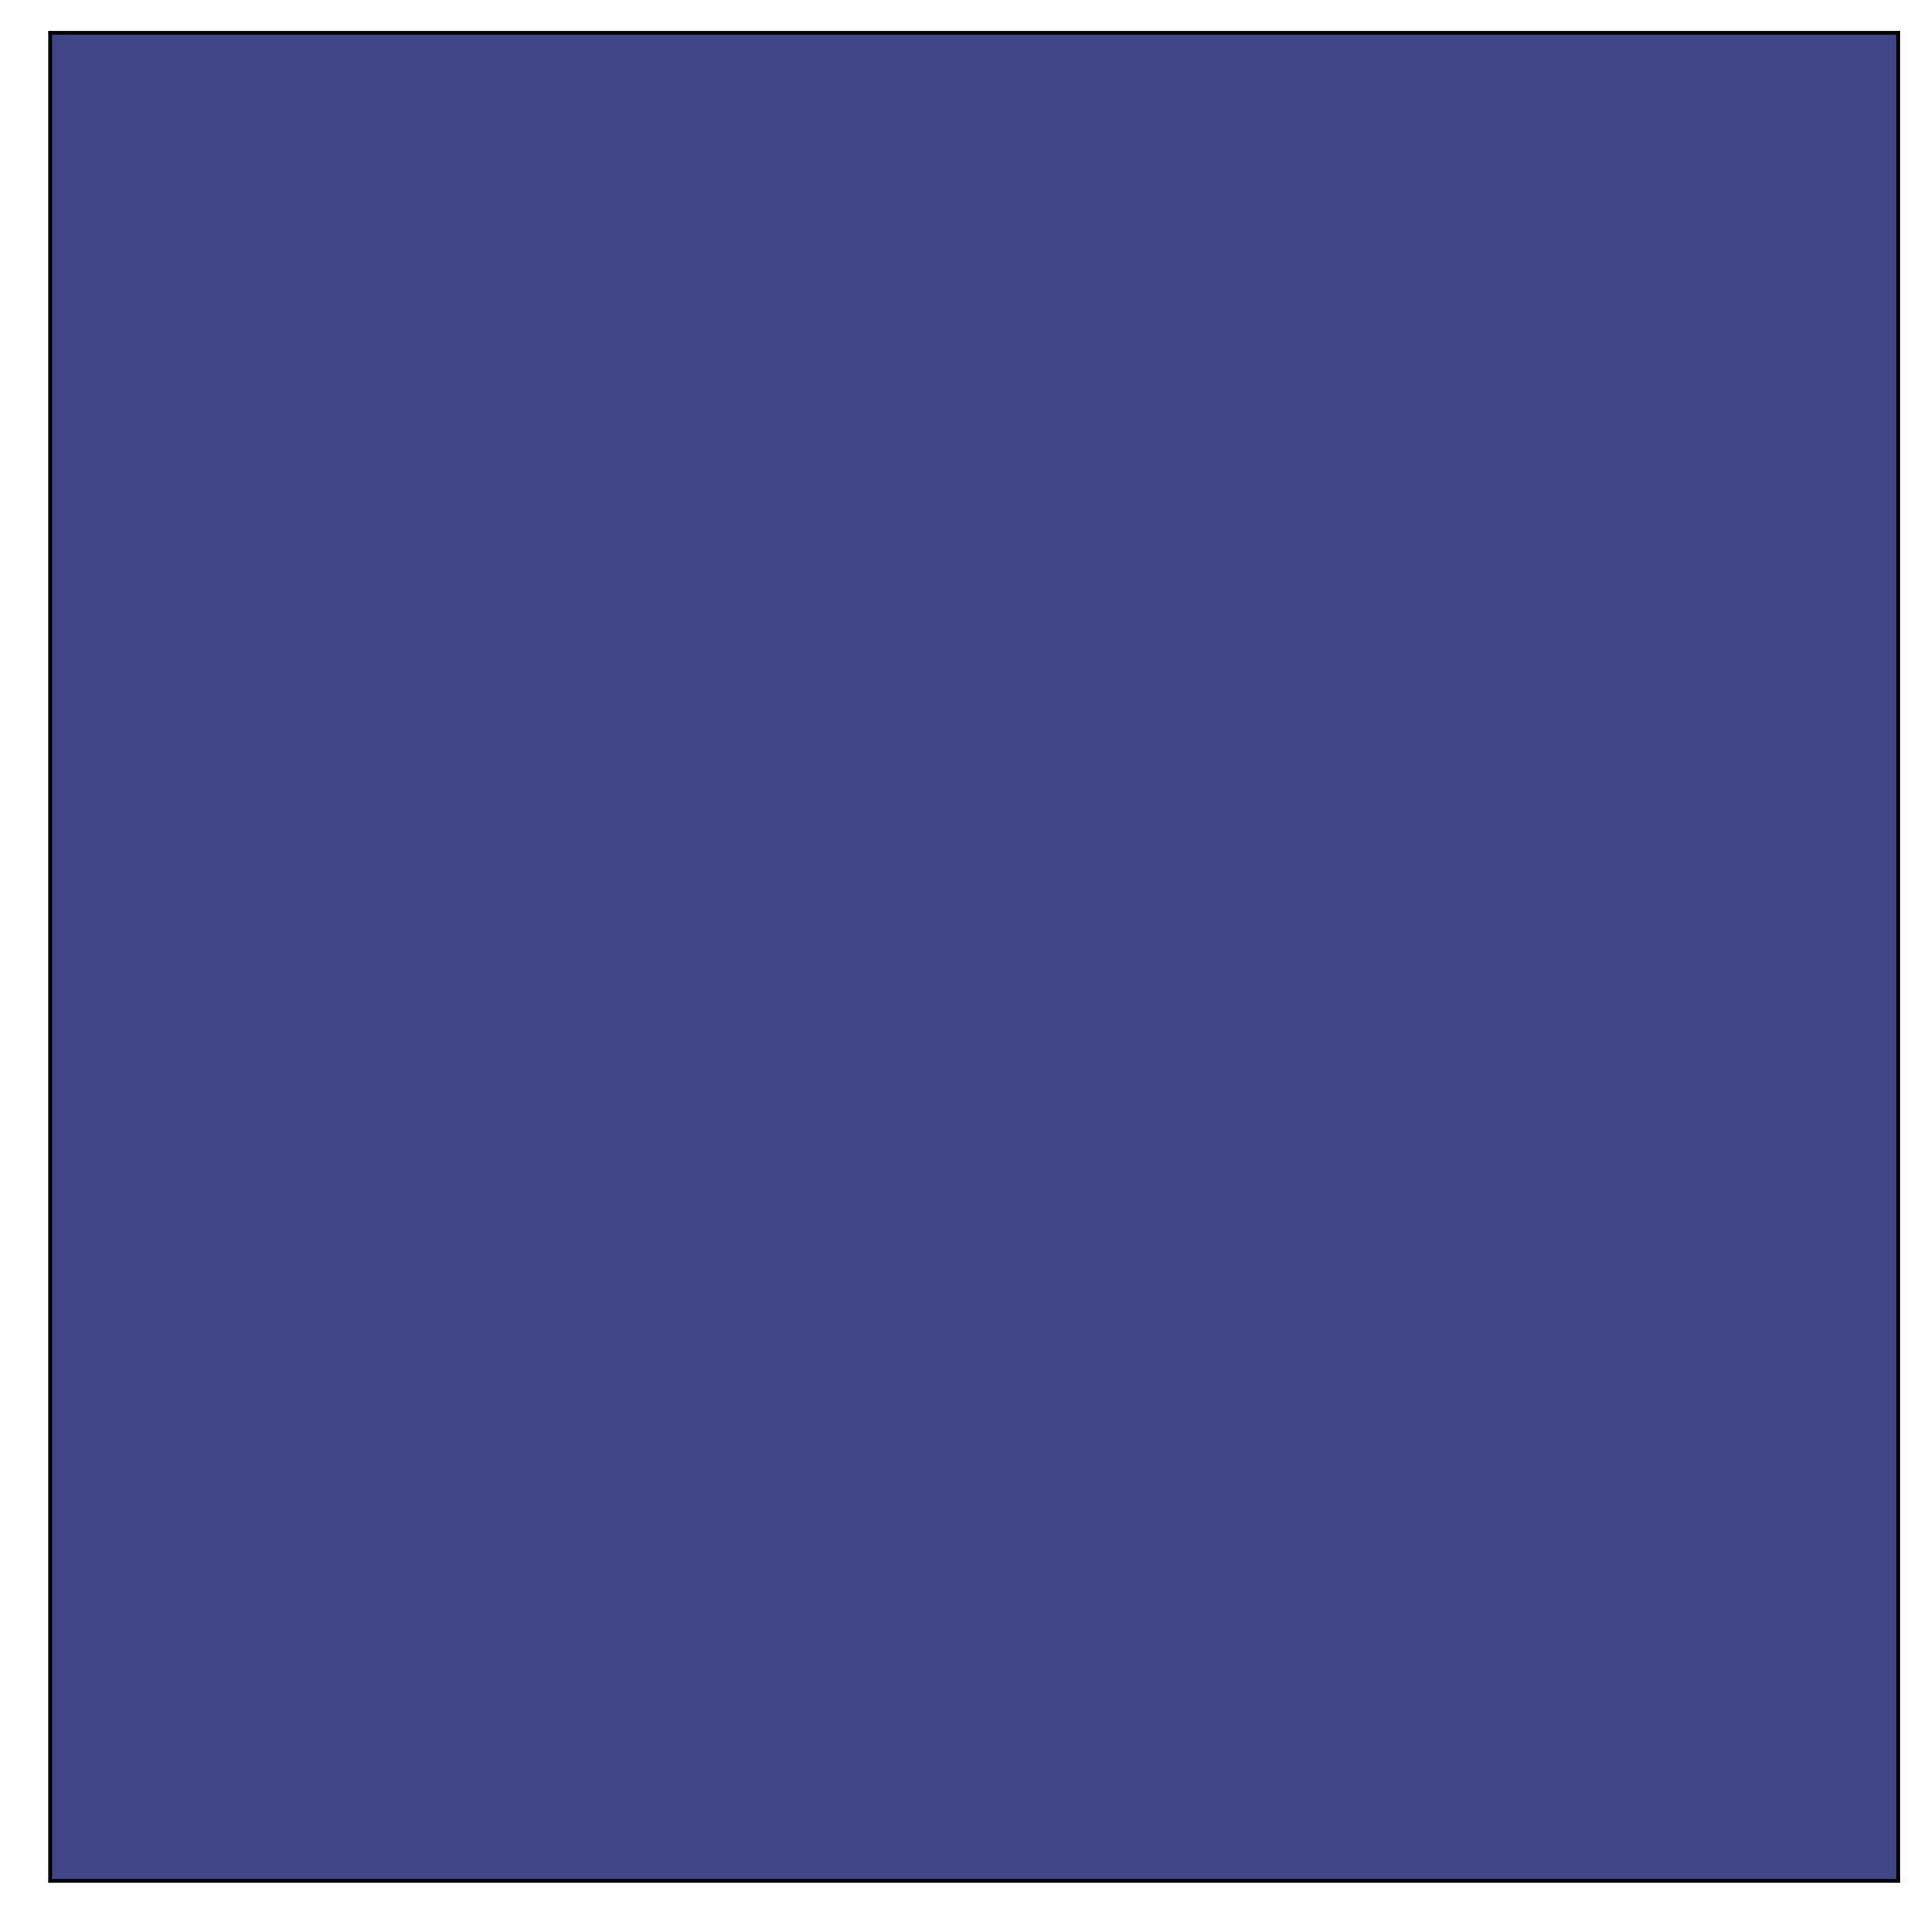

In [10]:
heatmaps = get_heatmaps(resnet18)

layers = [
    'train-conv1', 
    'train-layer1-0-conv1',
    'train-layer1-0-conv2', 
    'train-layer1-1-conv1',
    'train-layer1-1-conv2', 
  #  'train-layer2-0-downsample-0',
    'train-layer2-0-conv1',
    'train-layer2-0-conv2', 
    'train-layer2-1-conv1', 
    'train-layer2-1-conv2',
  #  'train-layer3-0-downsample-0', 
    'train-layer3-0-conv1',
    'train-layer3-0-conv2',
    'train-layer3-1-conv1',
    'train-layer3-1-conv2',
  #  'train-layer4-0-downsample-0',
    'train-layer4-0-conv1',
    'train-layer4-0-conv2',
    'train-layer4-1-conv1',
    'train-layer4-1-conv2',
]

images = []
for name in layers:
    heatmap = heatmaps[name]
    fig = plt.figure(figsize=(6,6))
    #plt.title(name.replace("train-", ""))
    print(name.replace("train-", ""))
    plt.imshow(heatmap)
    plt.clim((0.0, 1.0))
    plt.xticks([])
    plt.yticks([])
    #cbar = plt.colorbar()
    #cbar.set_label("Accuracy", rotation=270)
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.tight_layout()
    images.append(image)
    savepath = join(path, name.replace("train-", "") + ".png")
    plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
#imageio.mimsave('./resnet18_receptive_field.gif',images, fps=1)

<ipython-input-5-7e58538604f9>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df["x"], layer_df["y"] = x, y


conv1


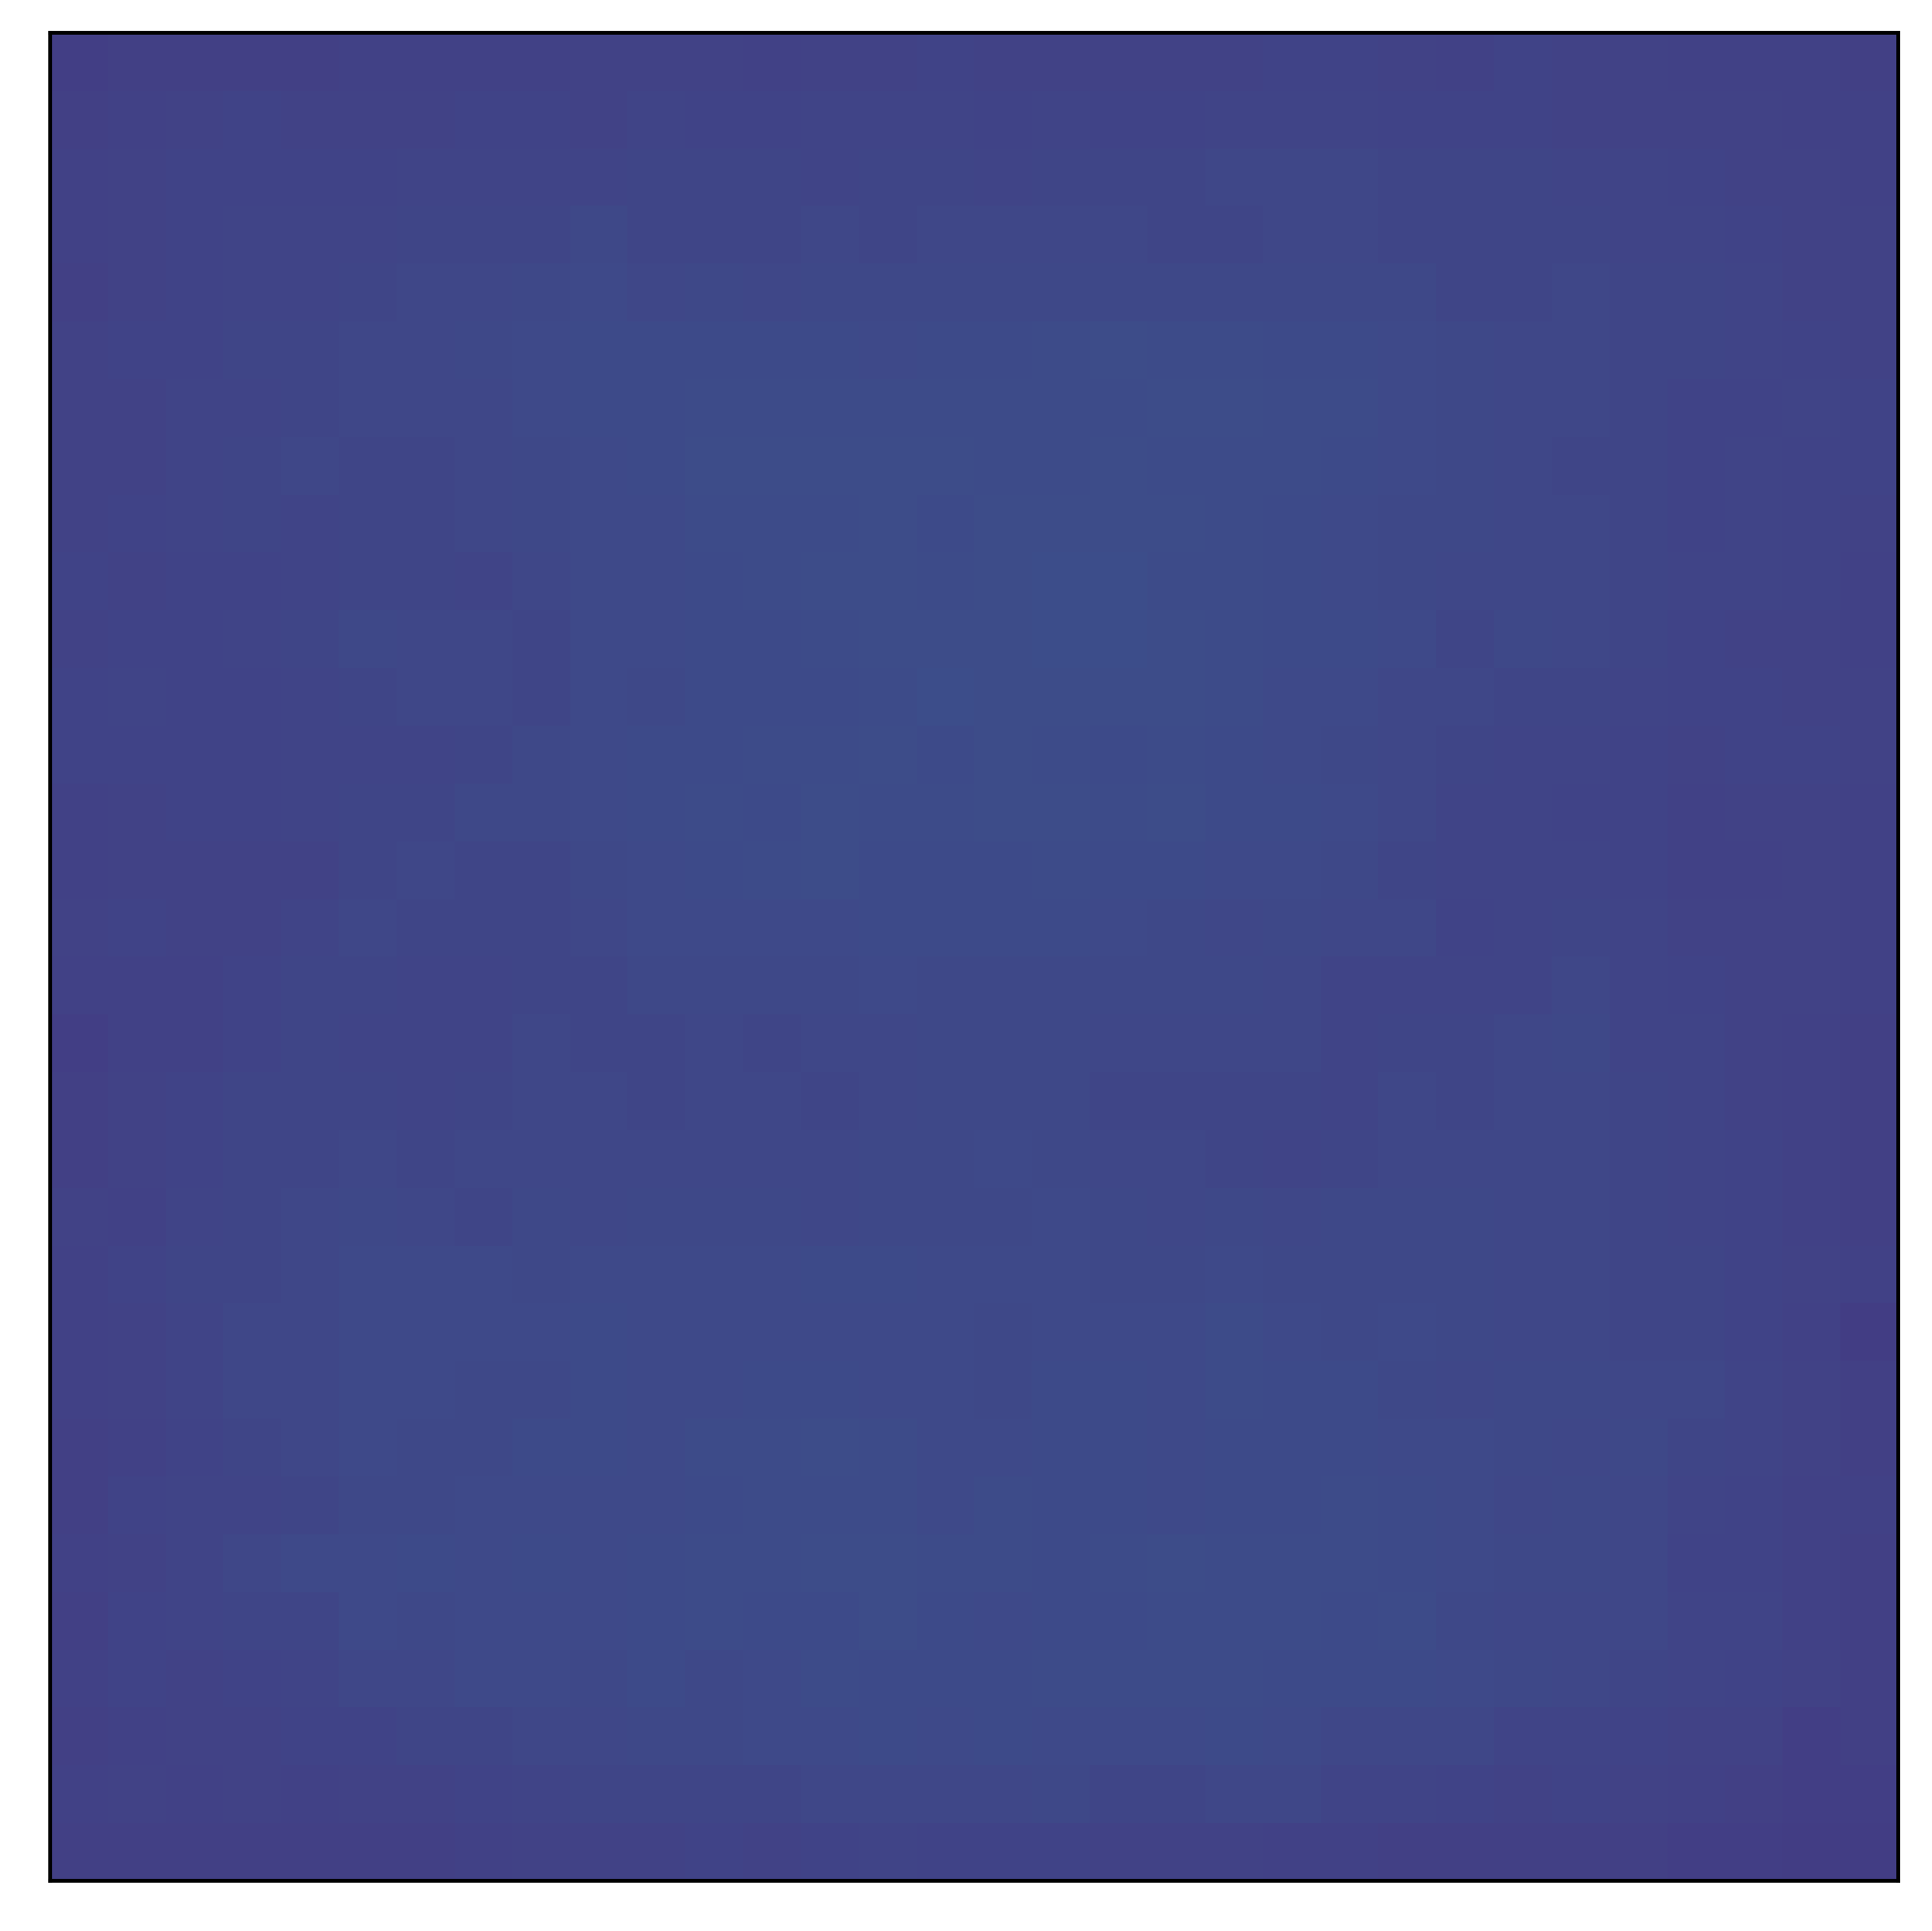

layer1-0-conv1


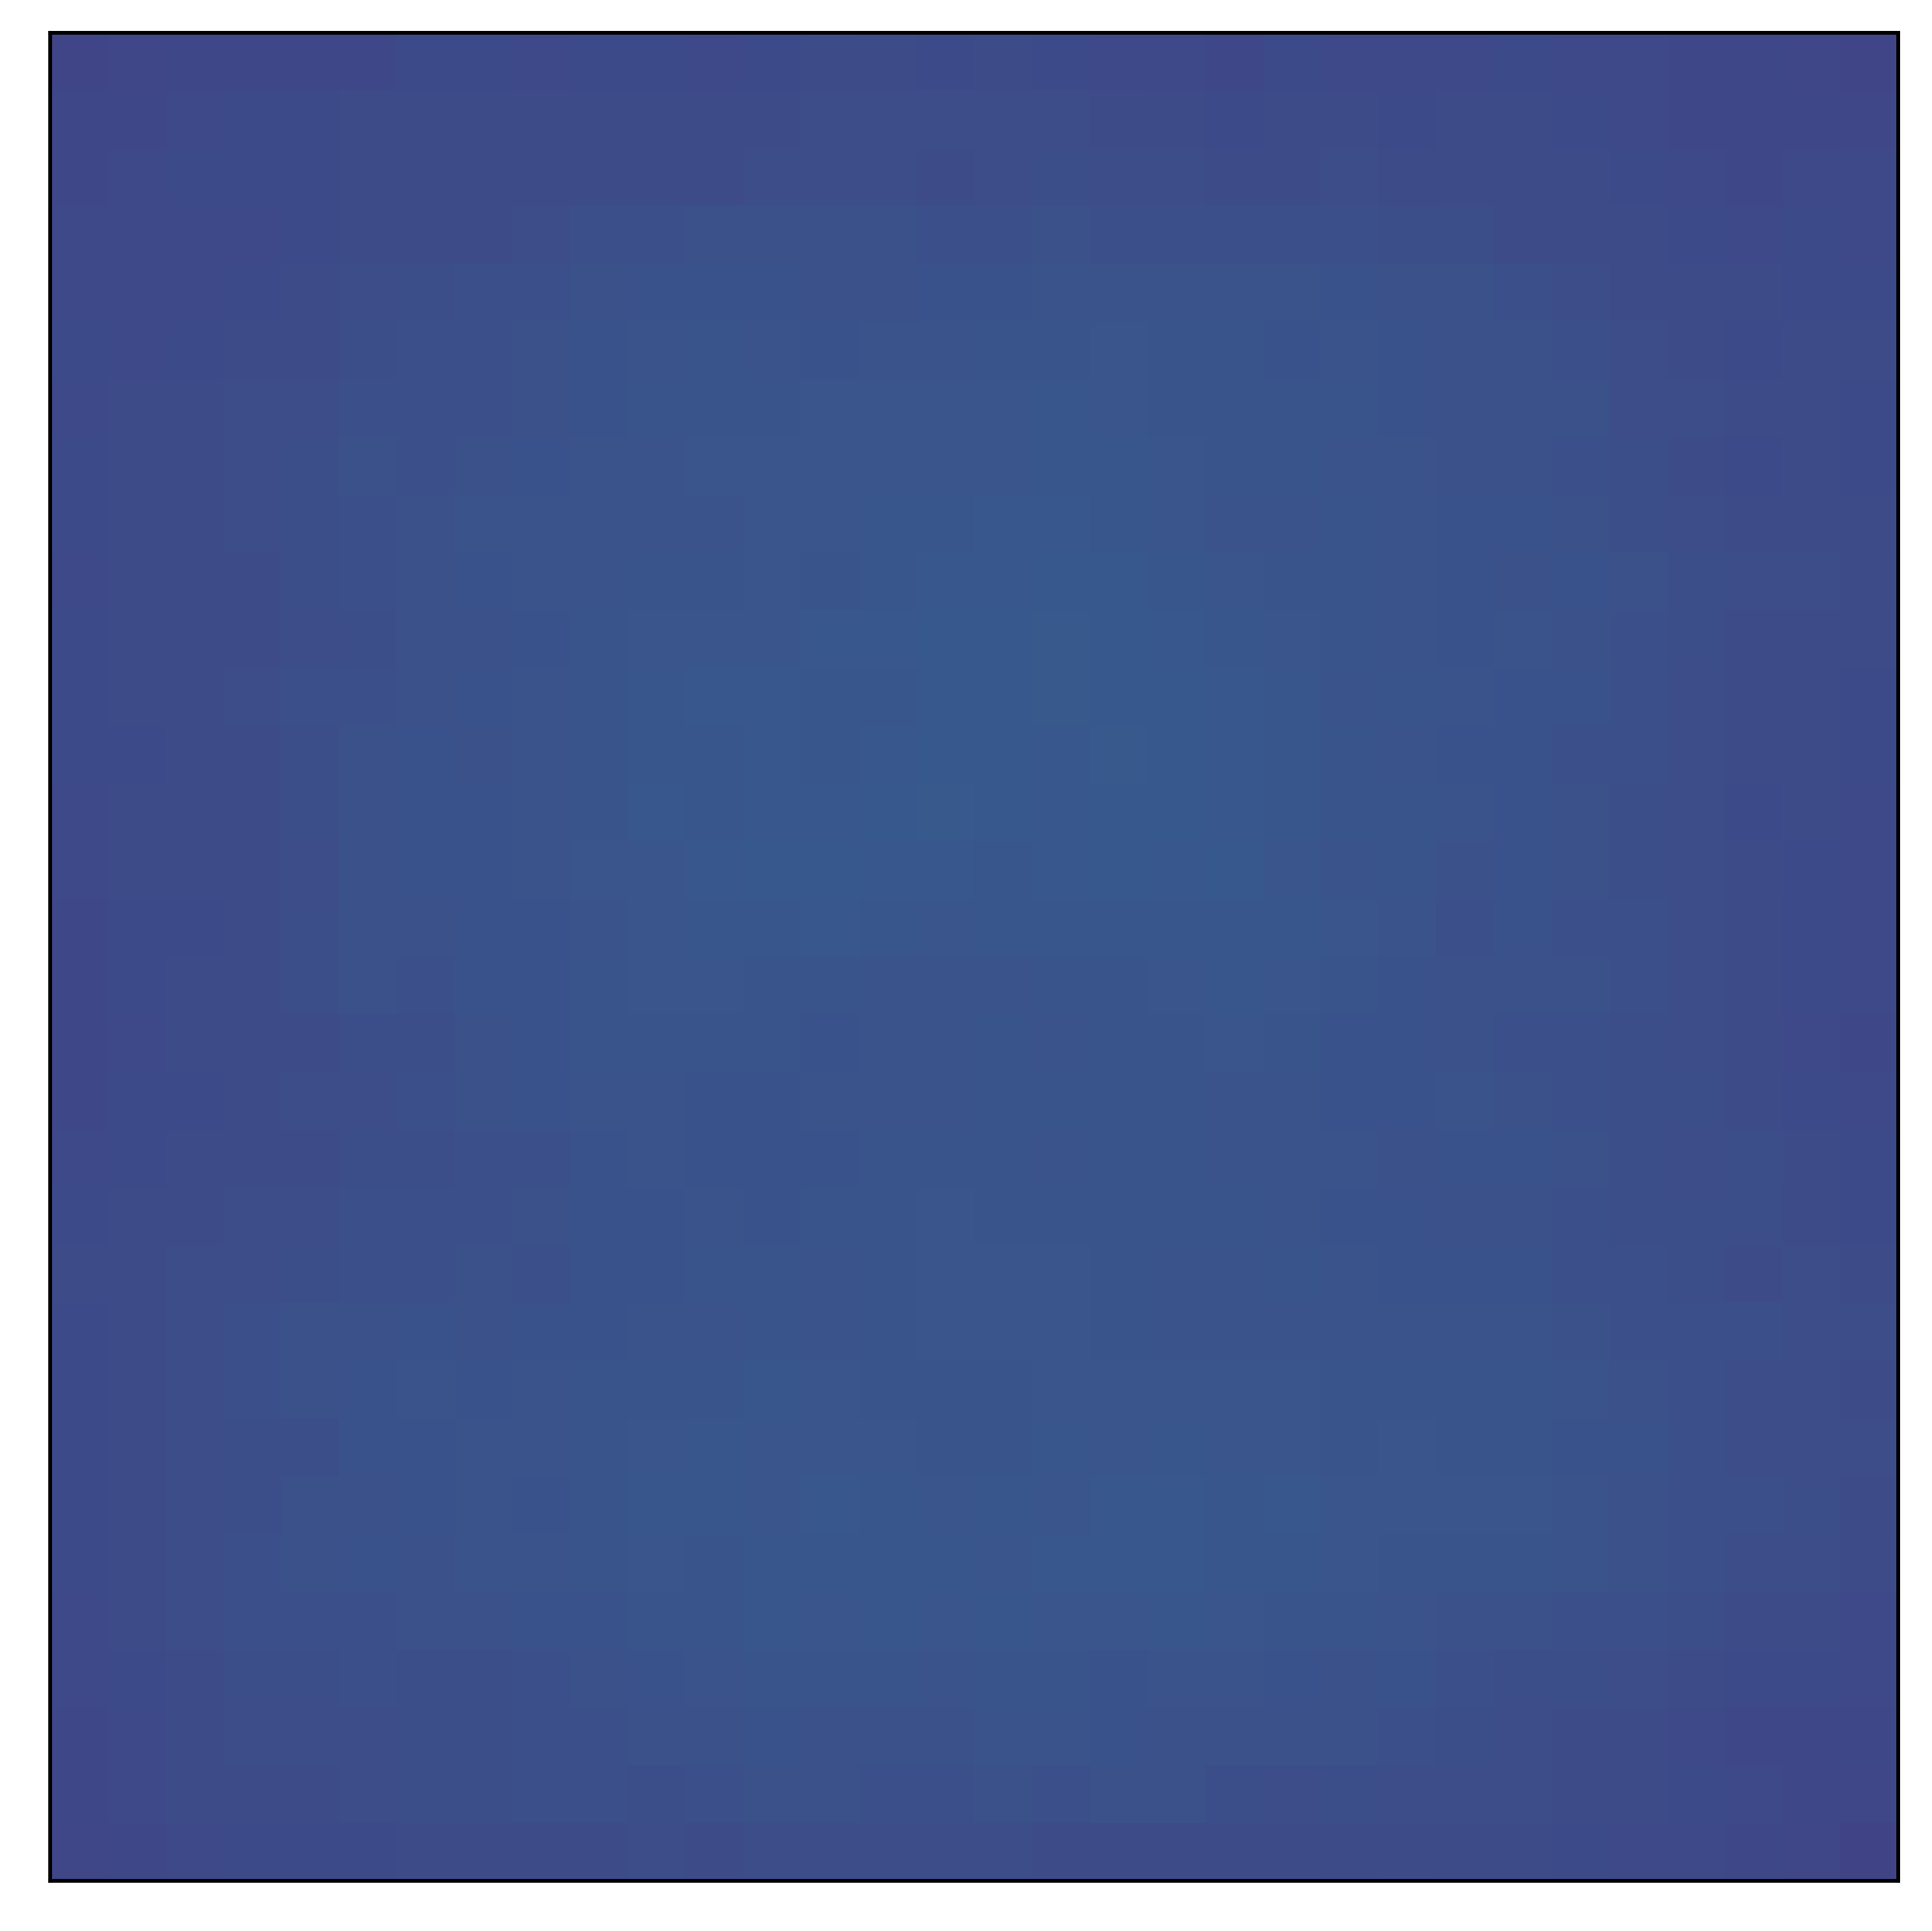

layer1-0-conv2


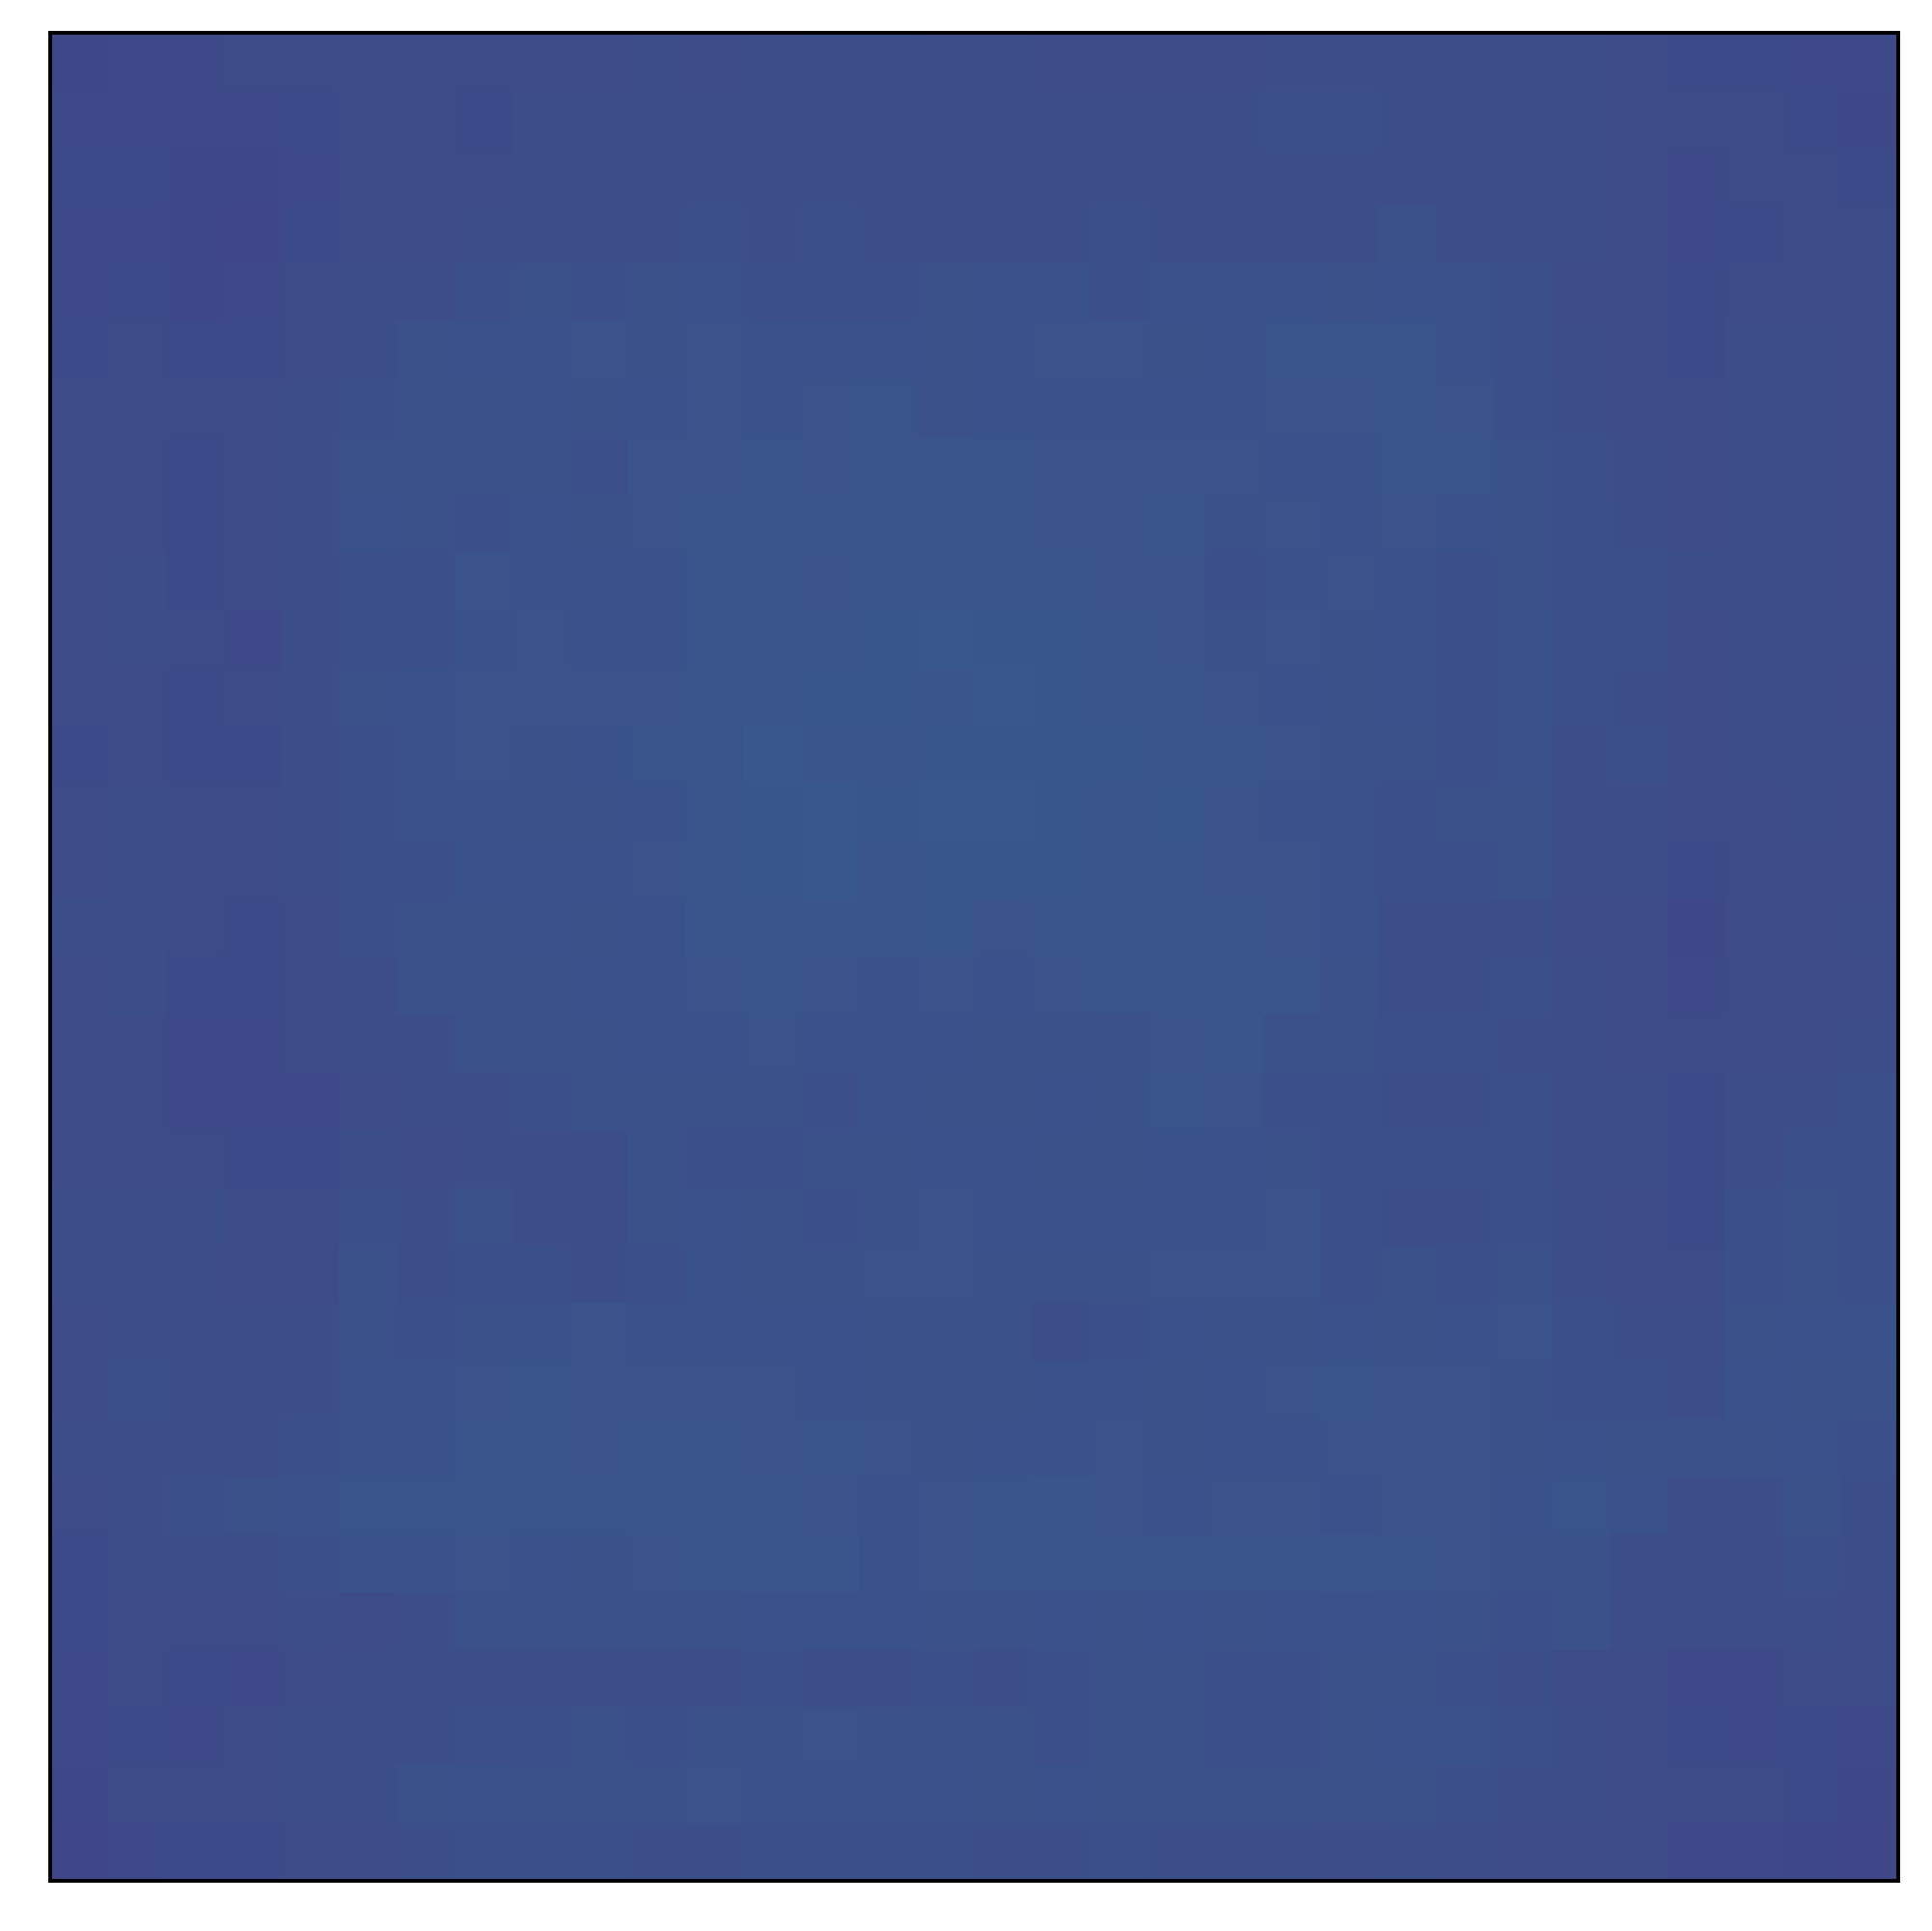

layer1-1-conv1


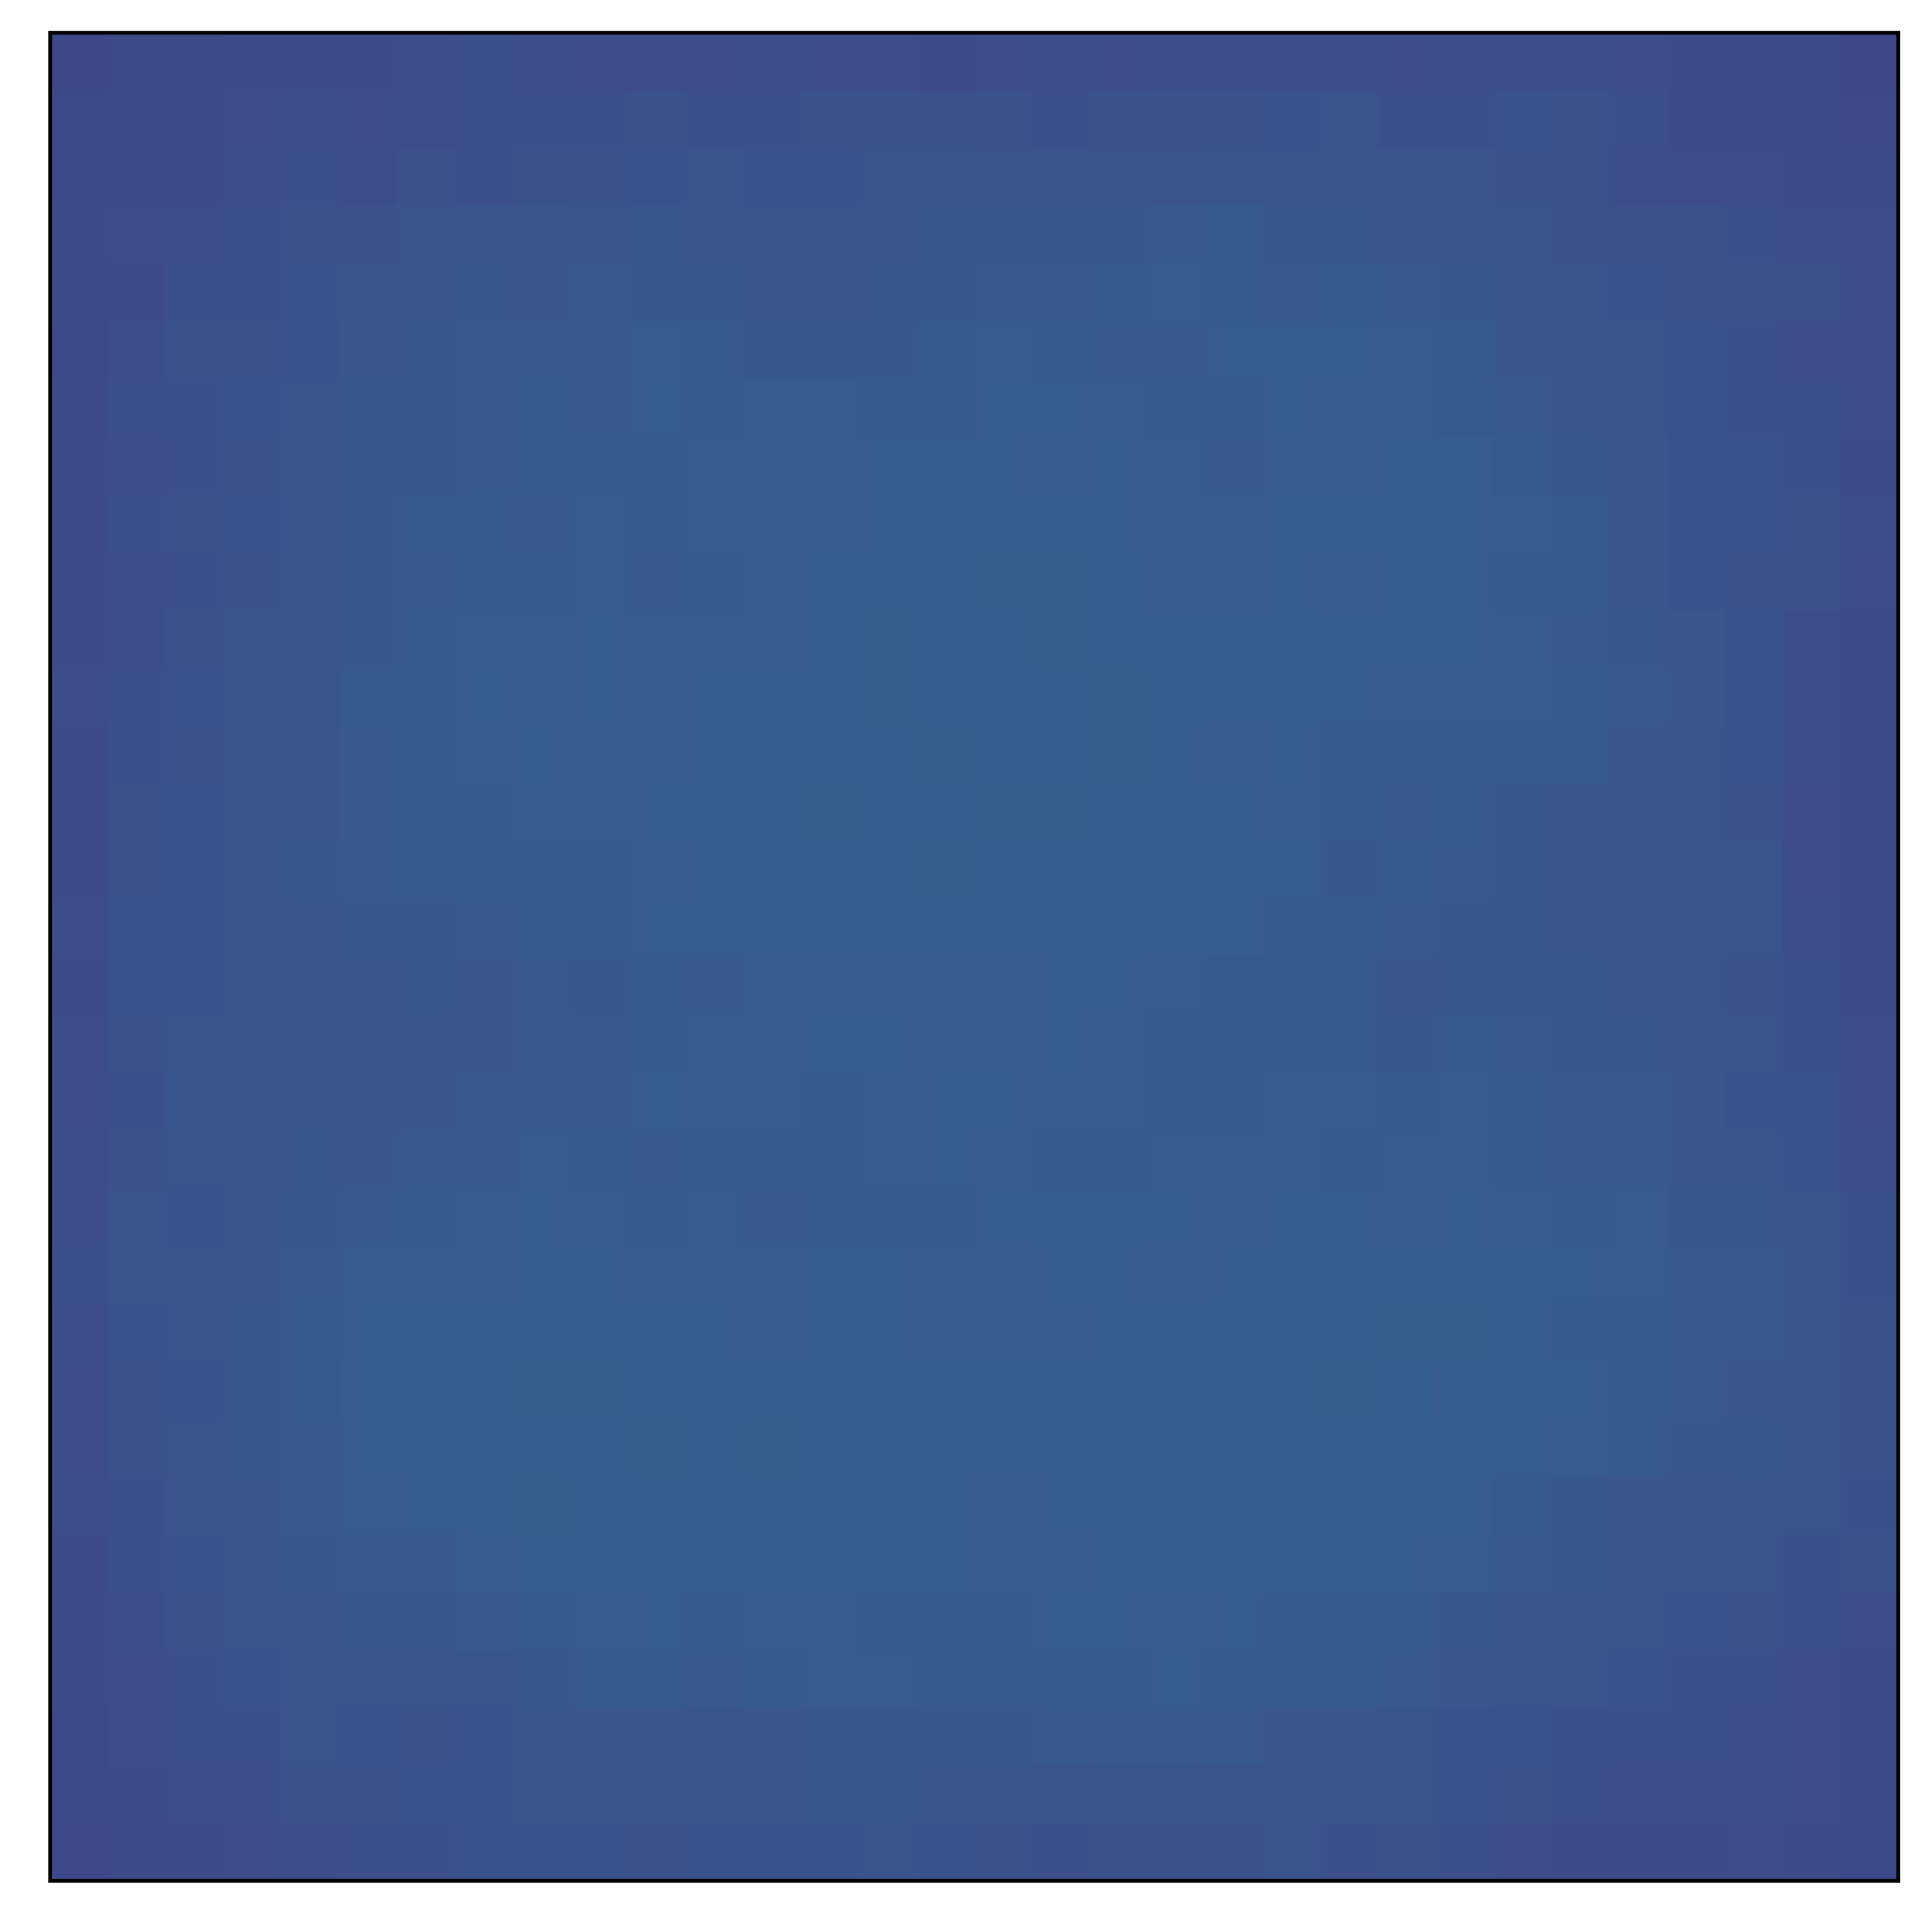

layer1-1-conv2


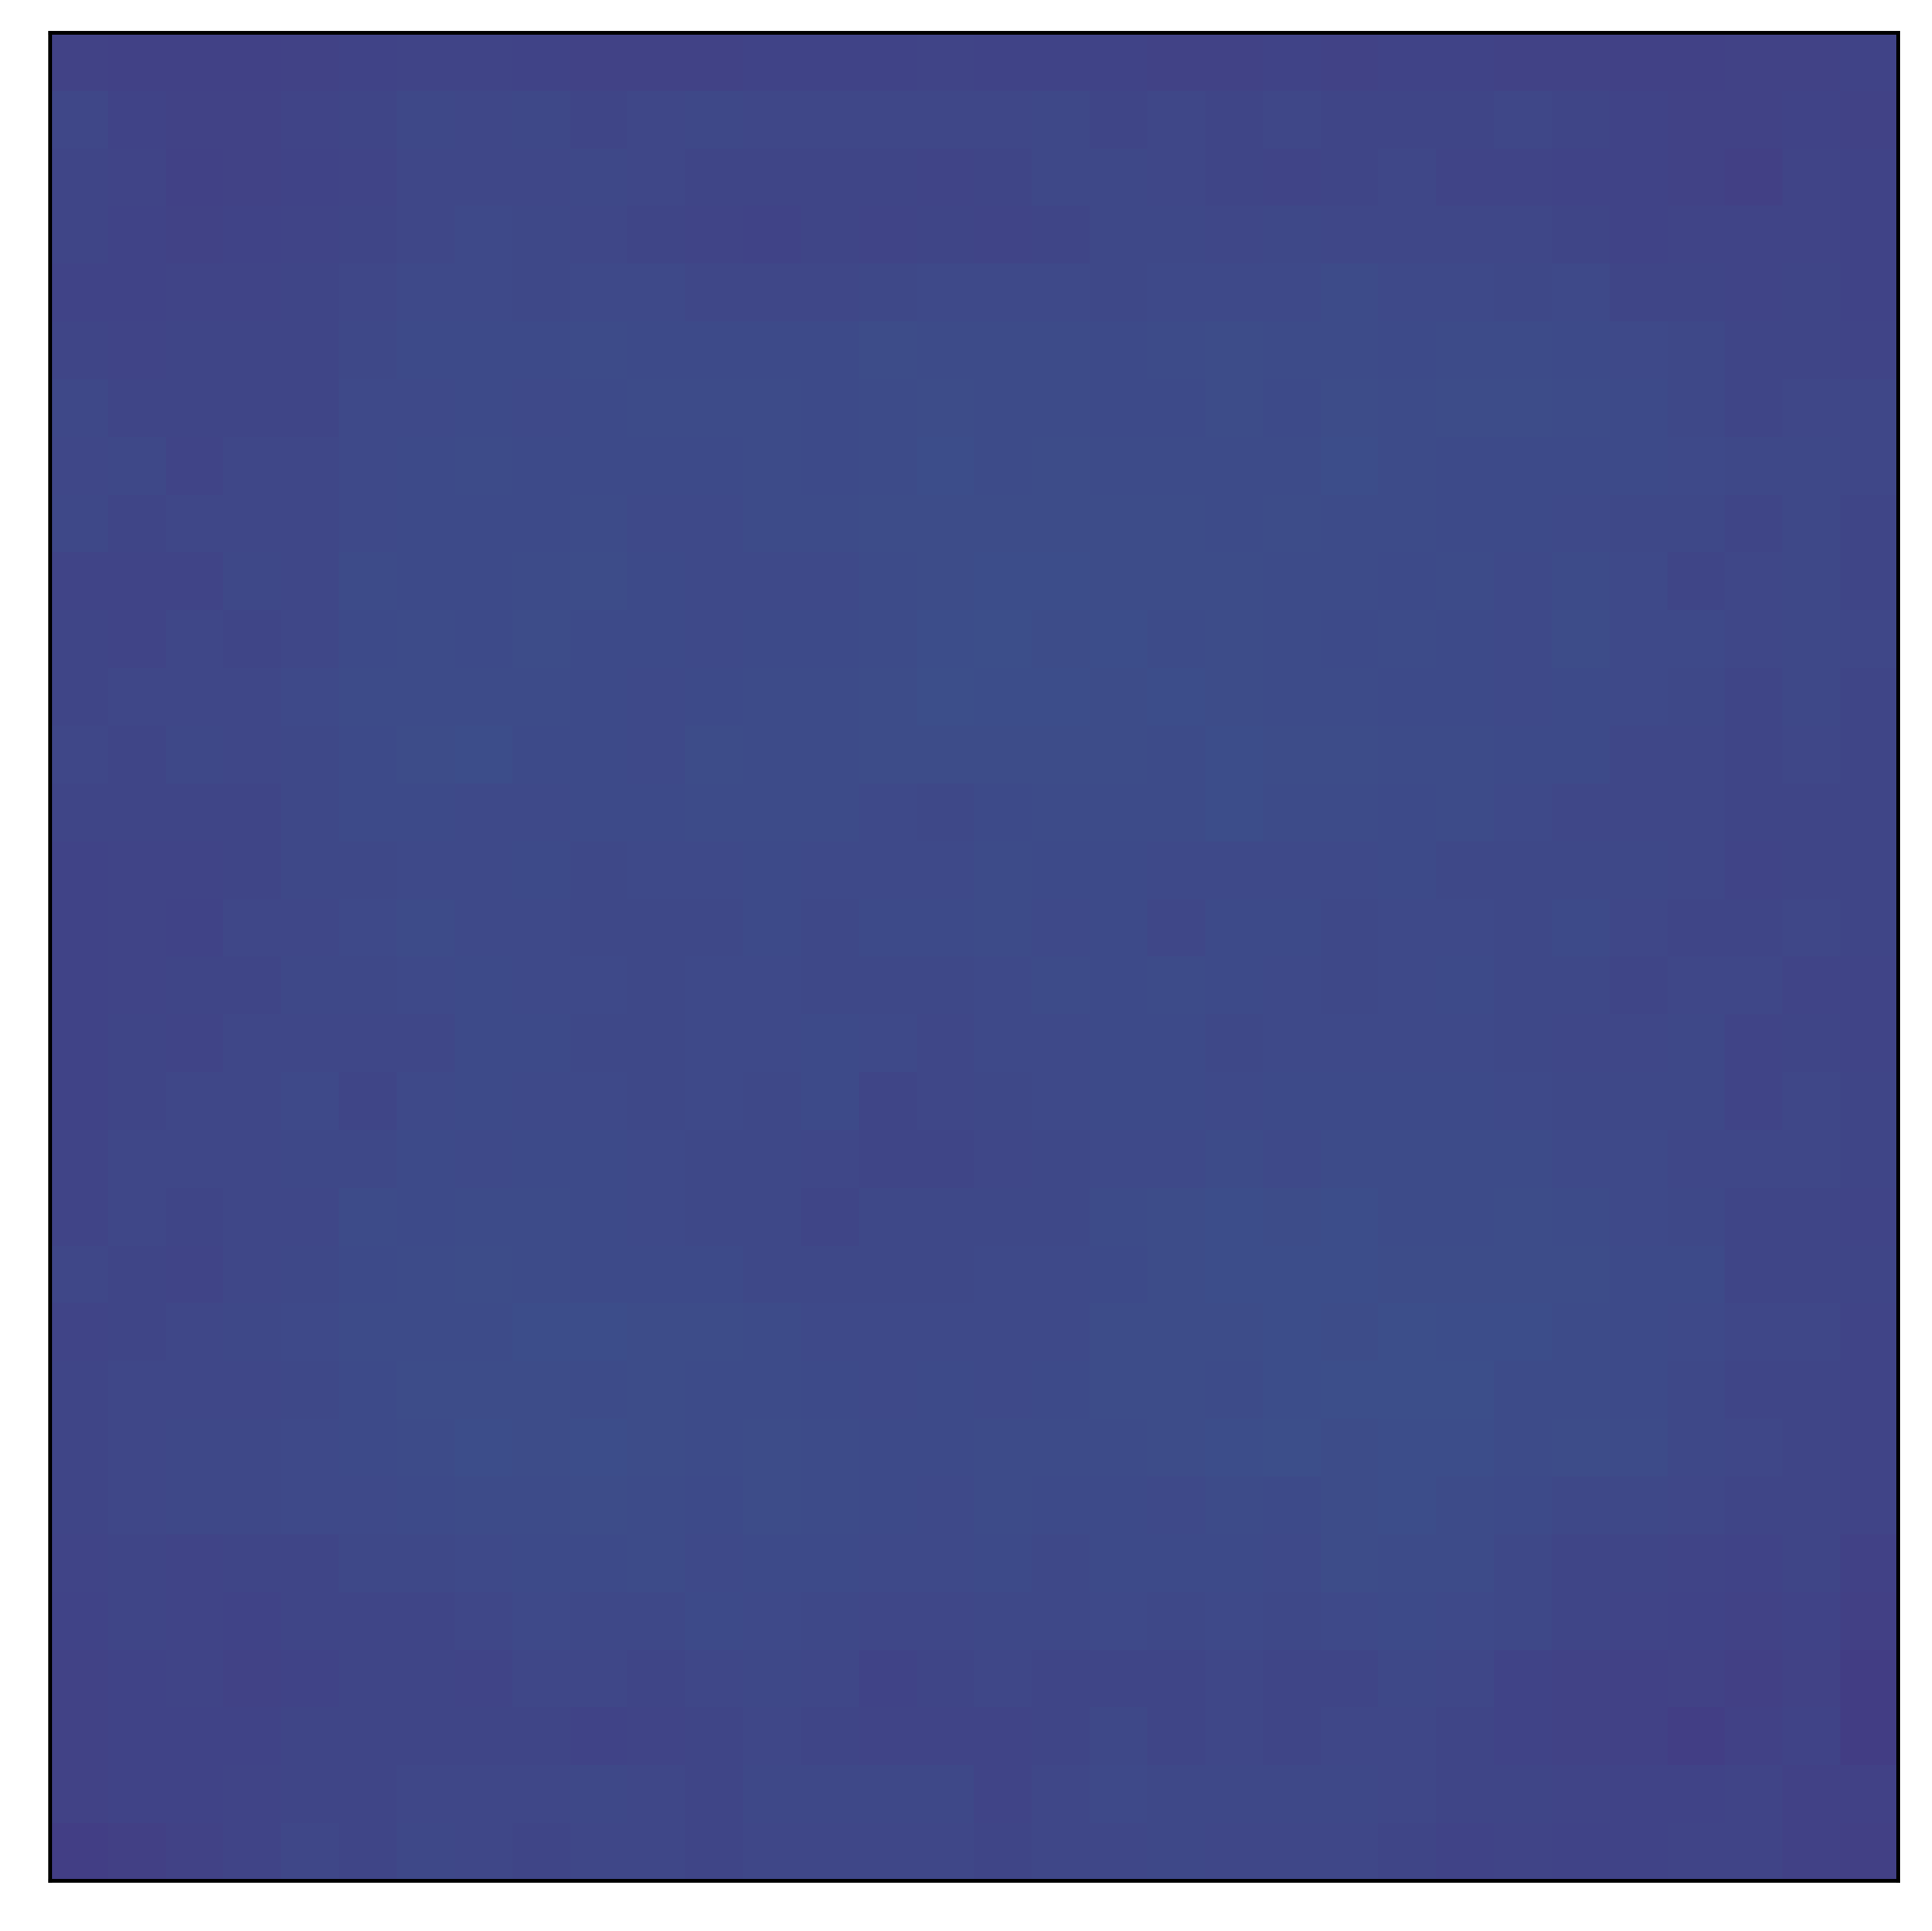

layer2-0-conv1


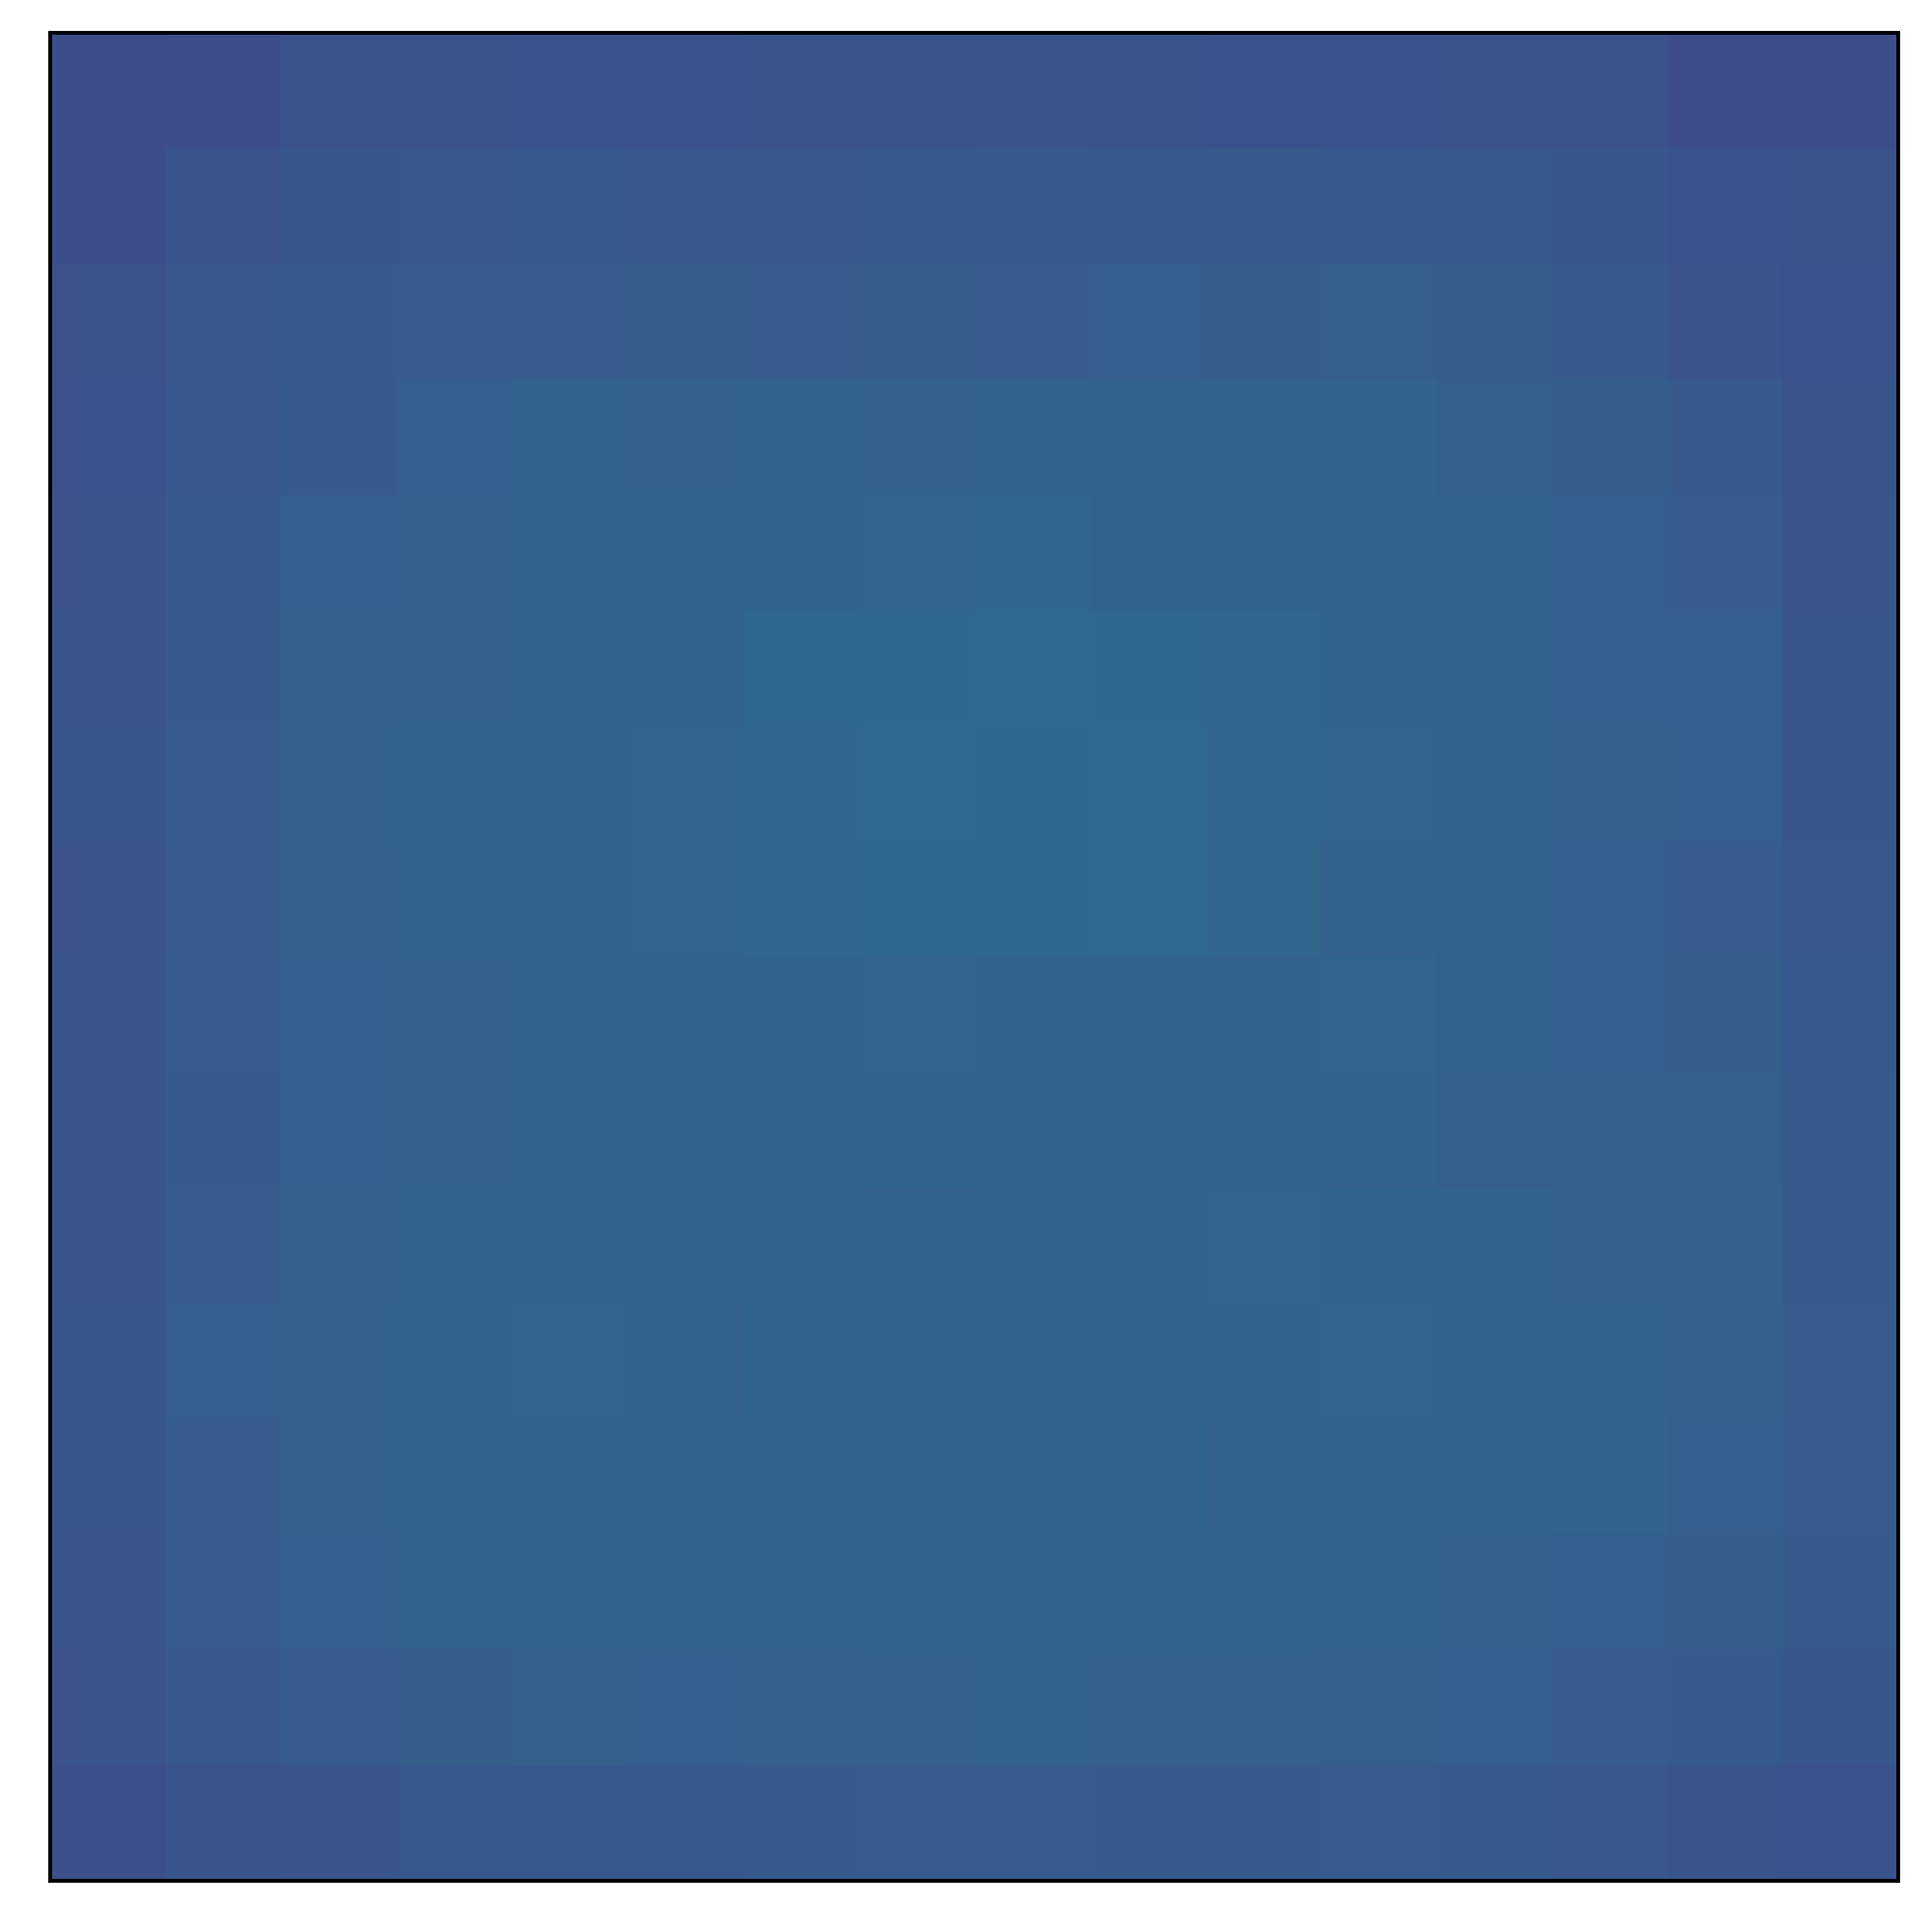

layer2-0-conv2


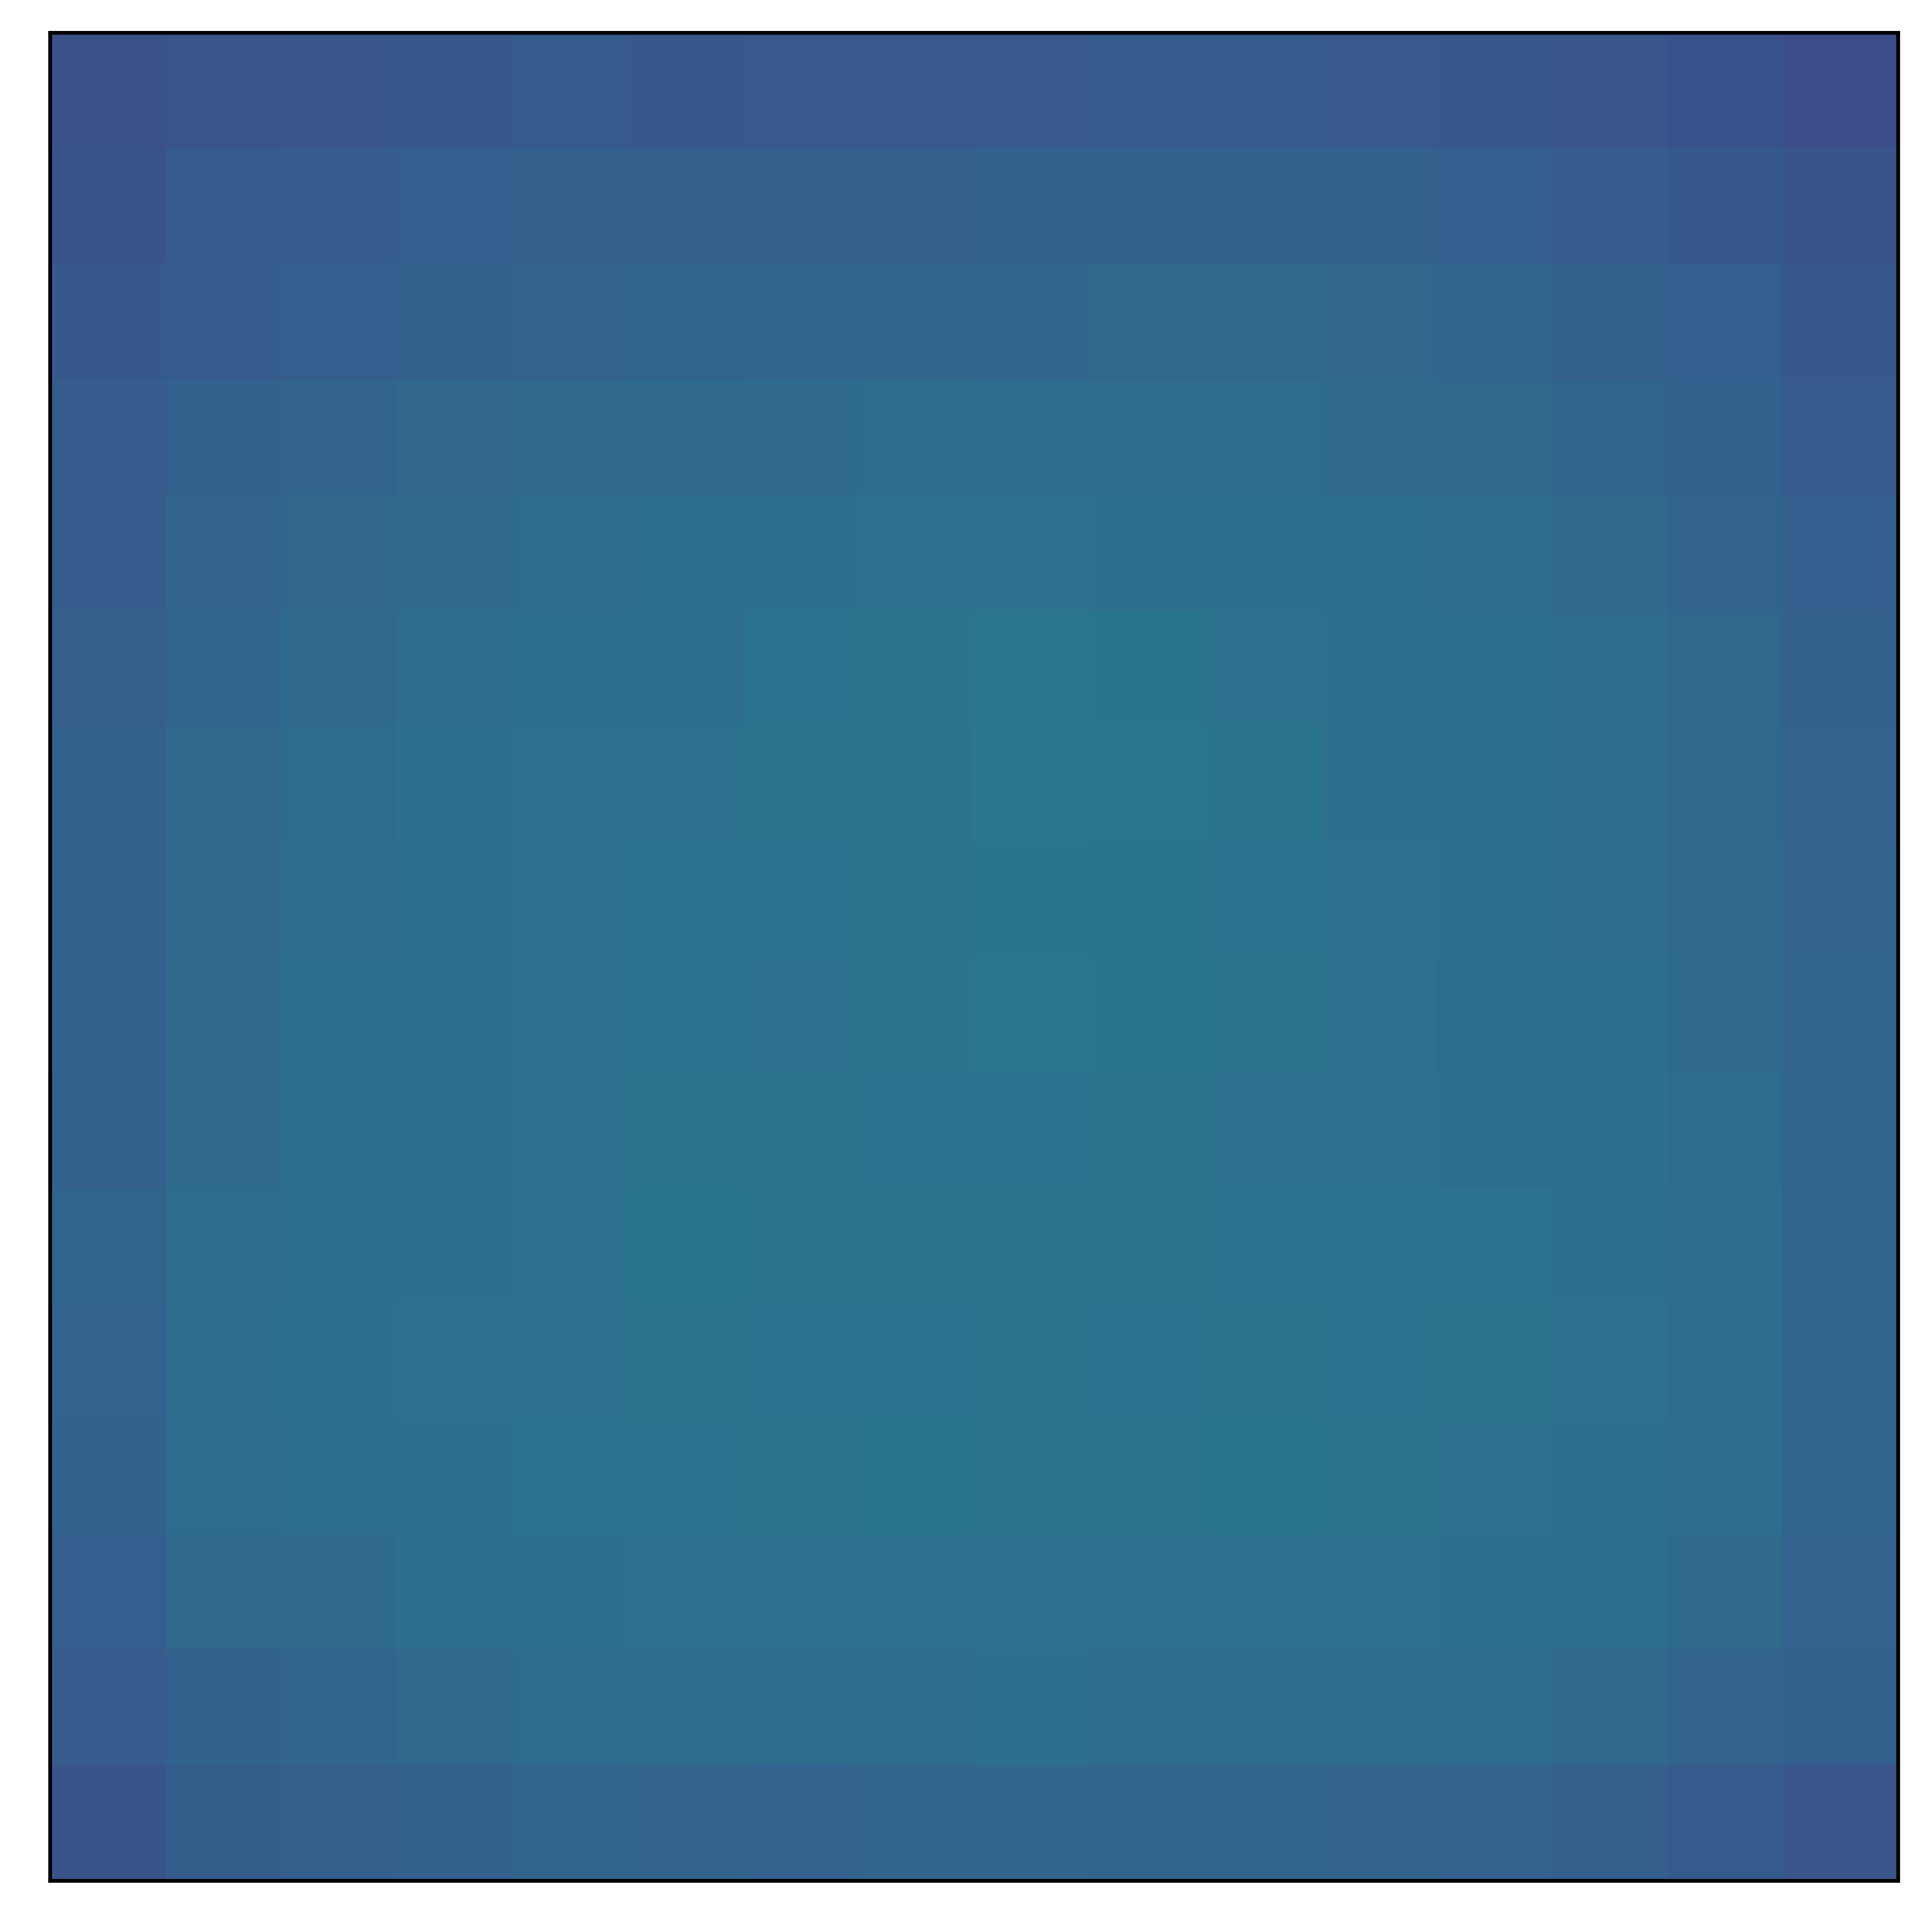

layer2-1-conv1


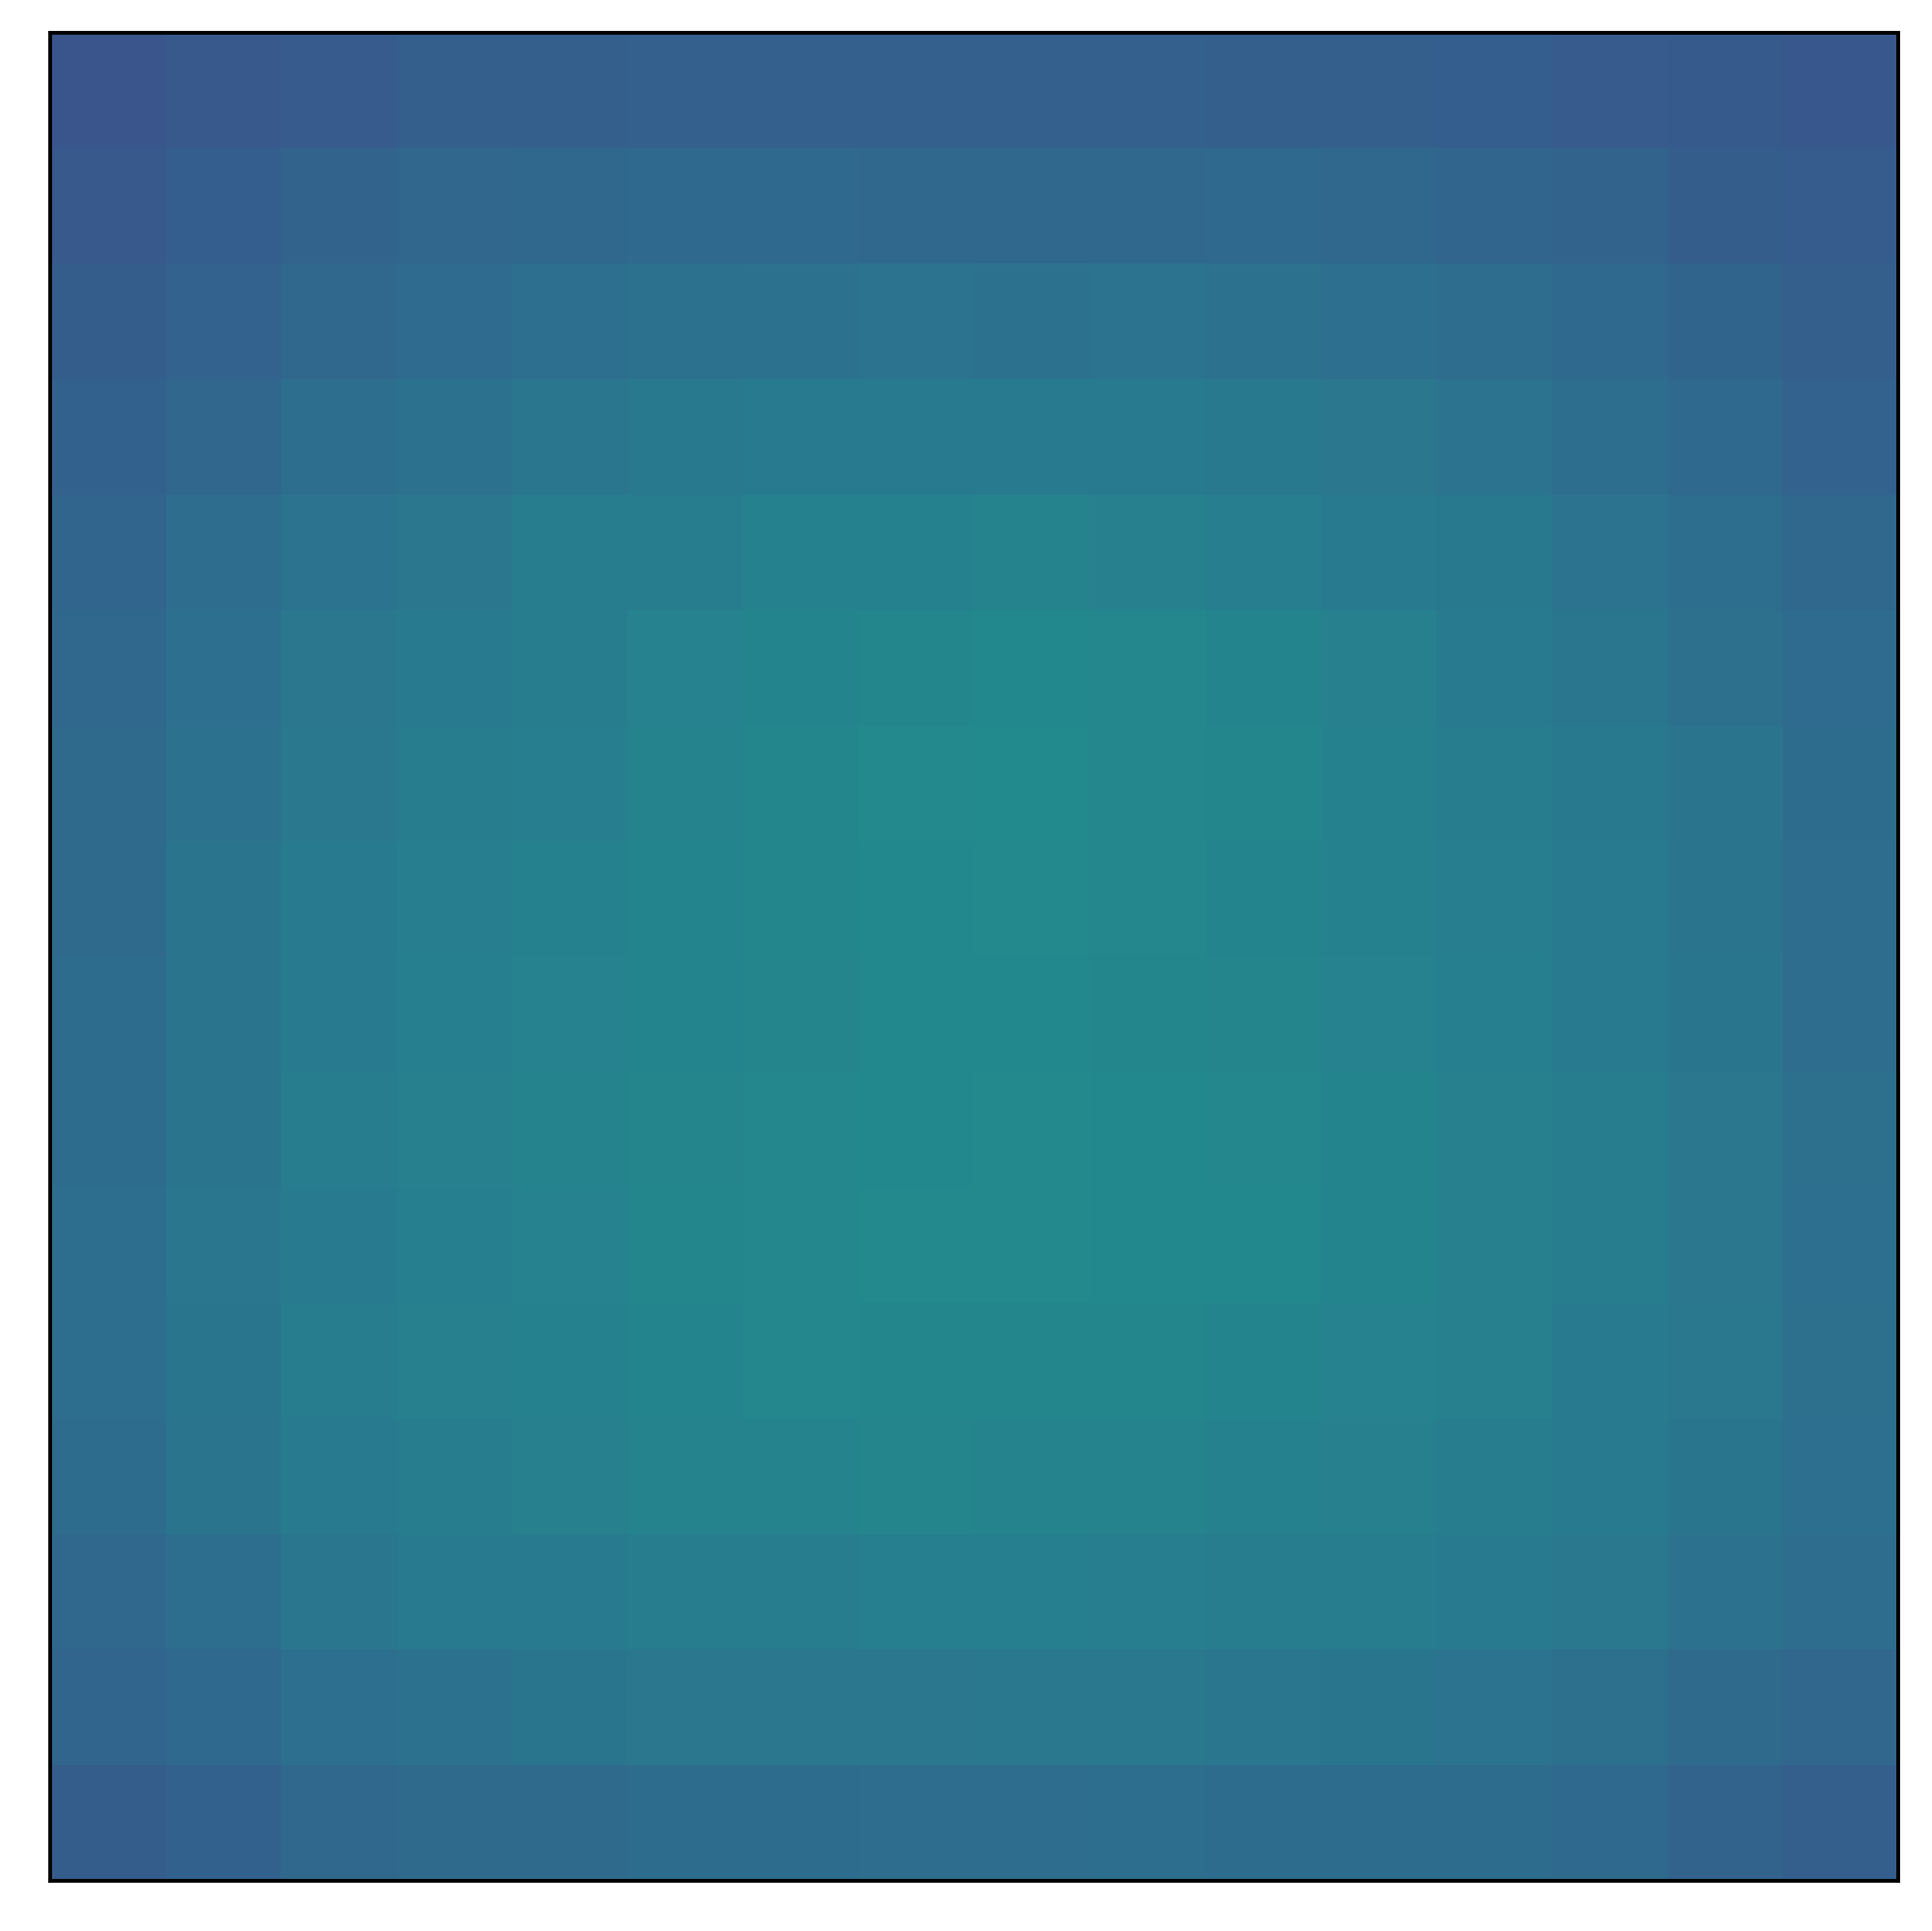

layer2-1-conv2


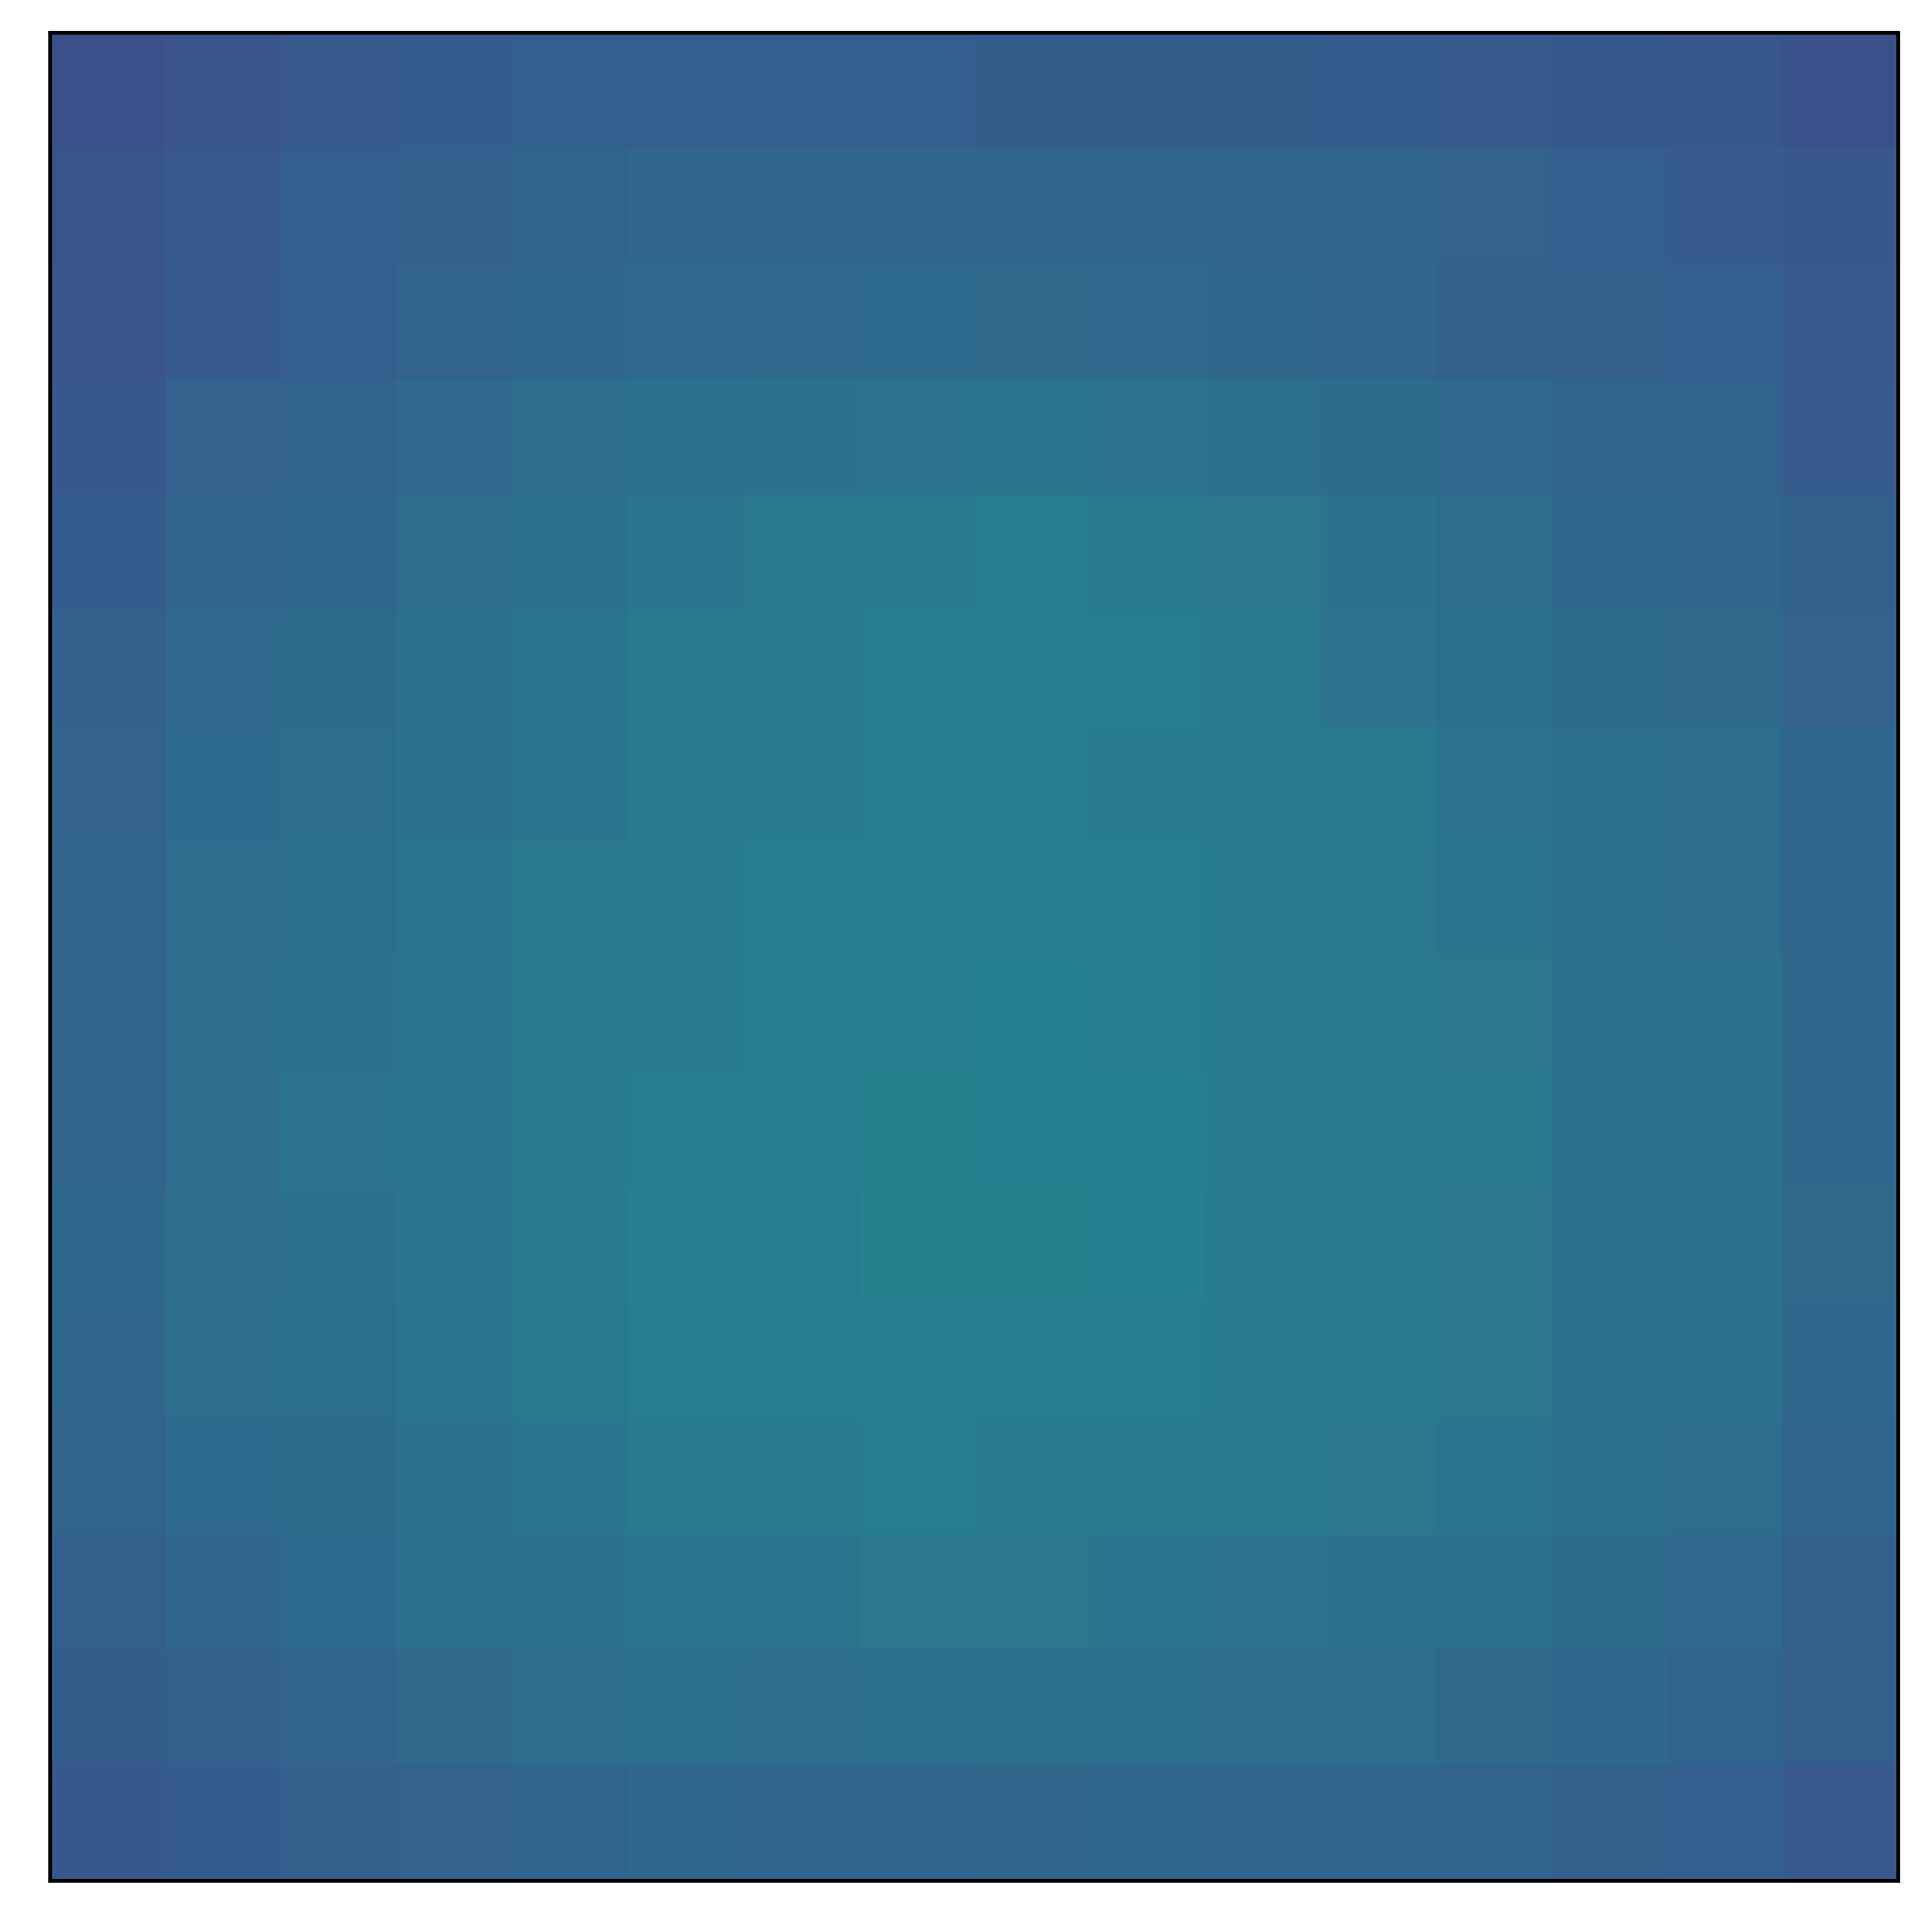

layer3-0-conv1


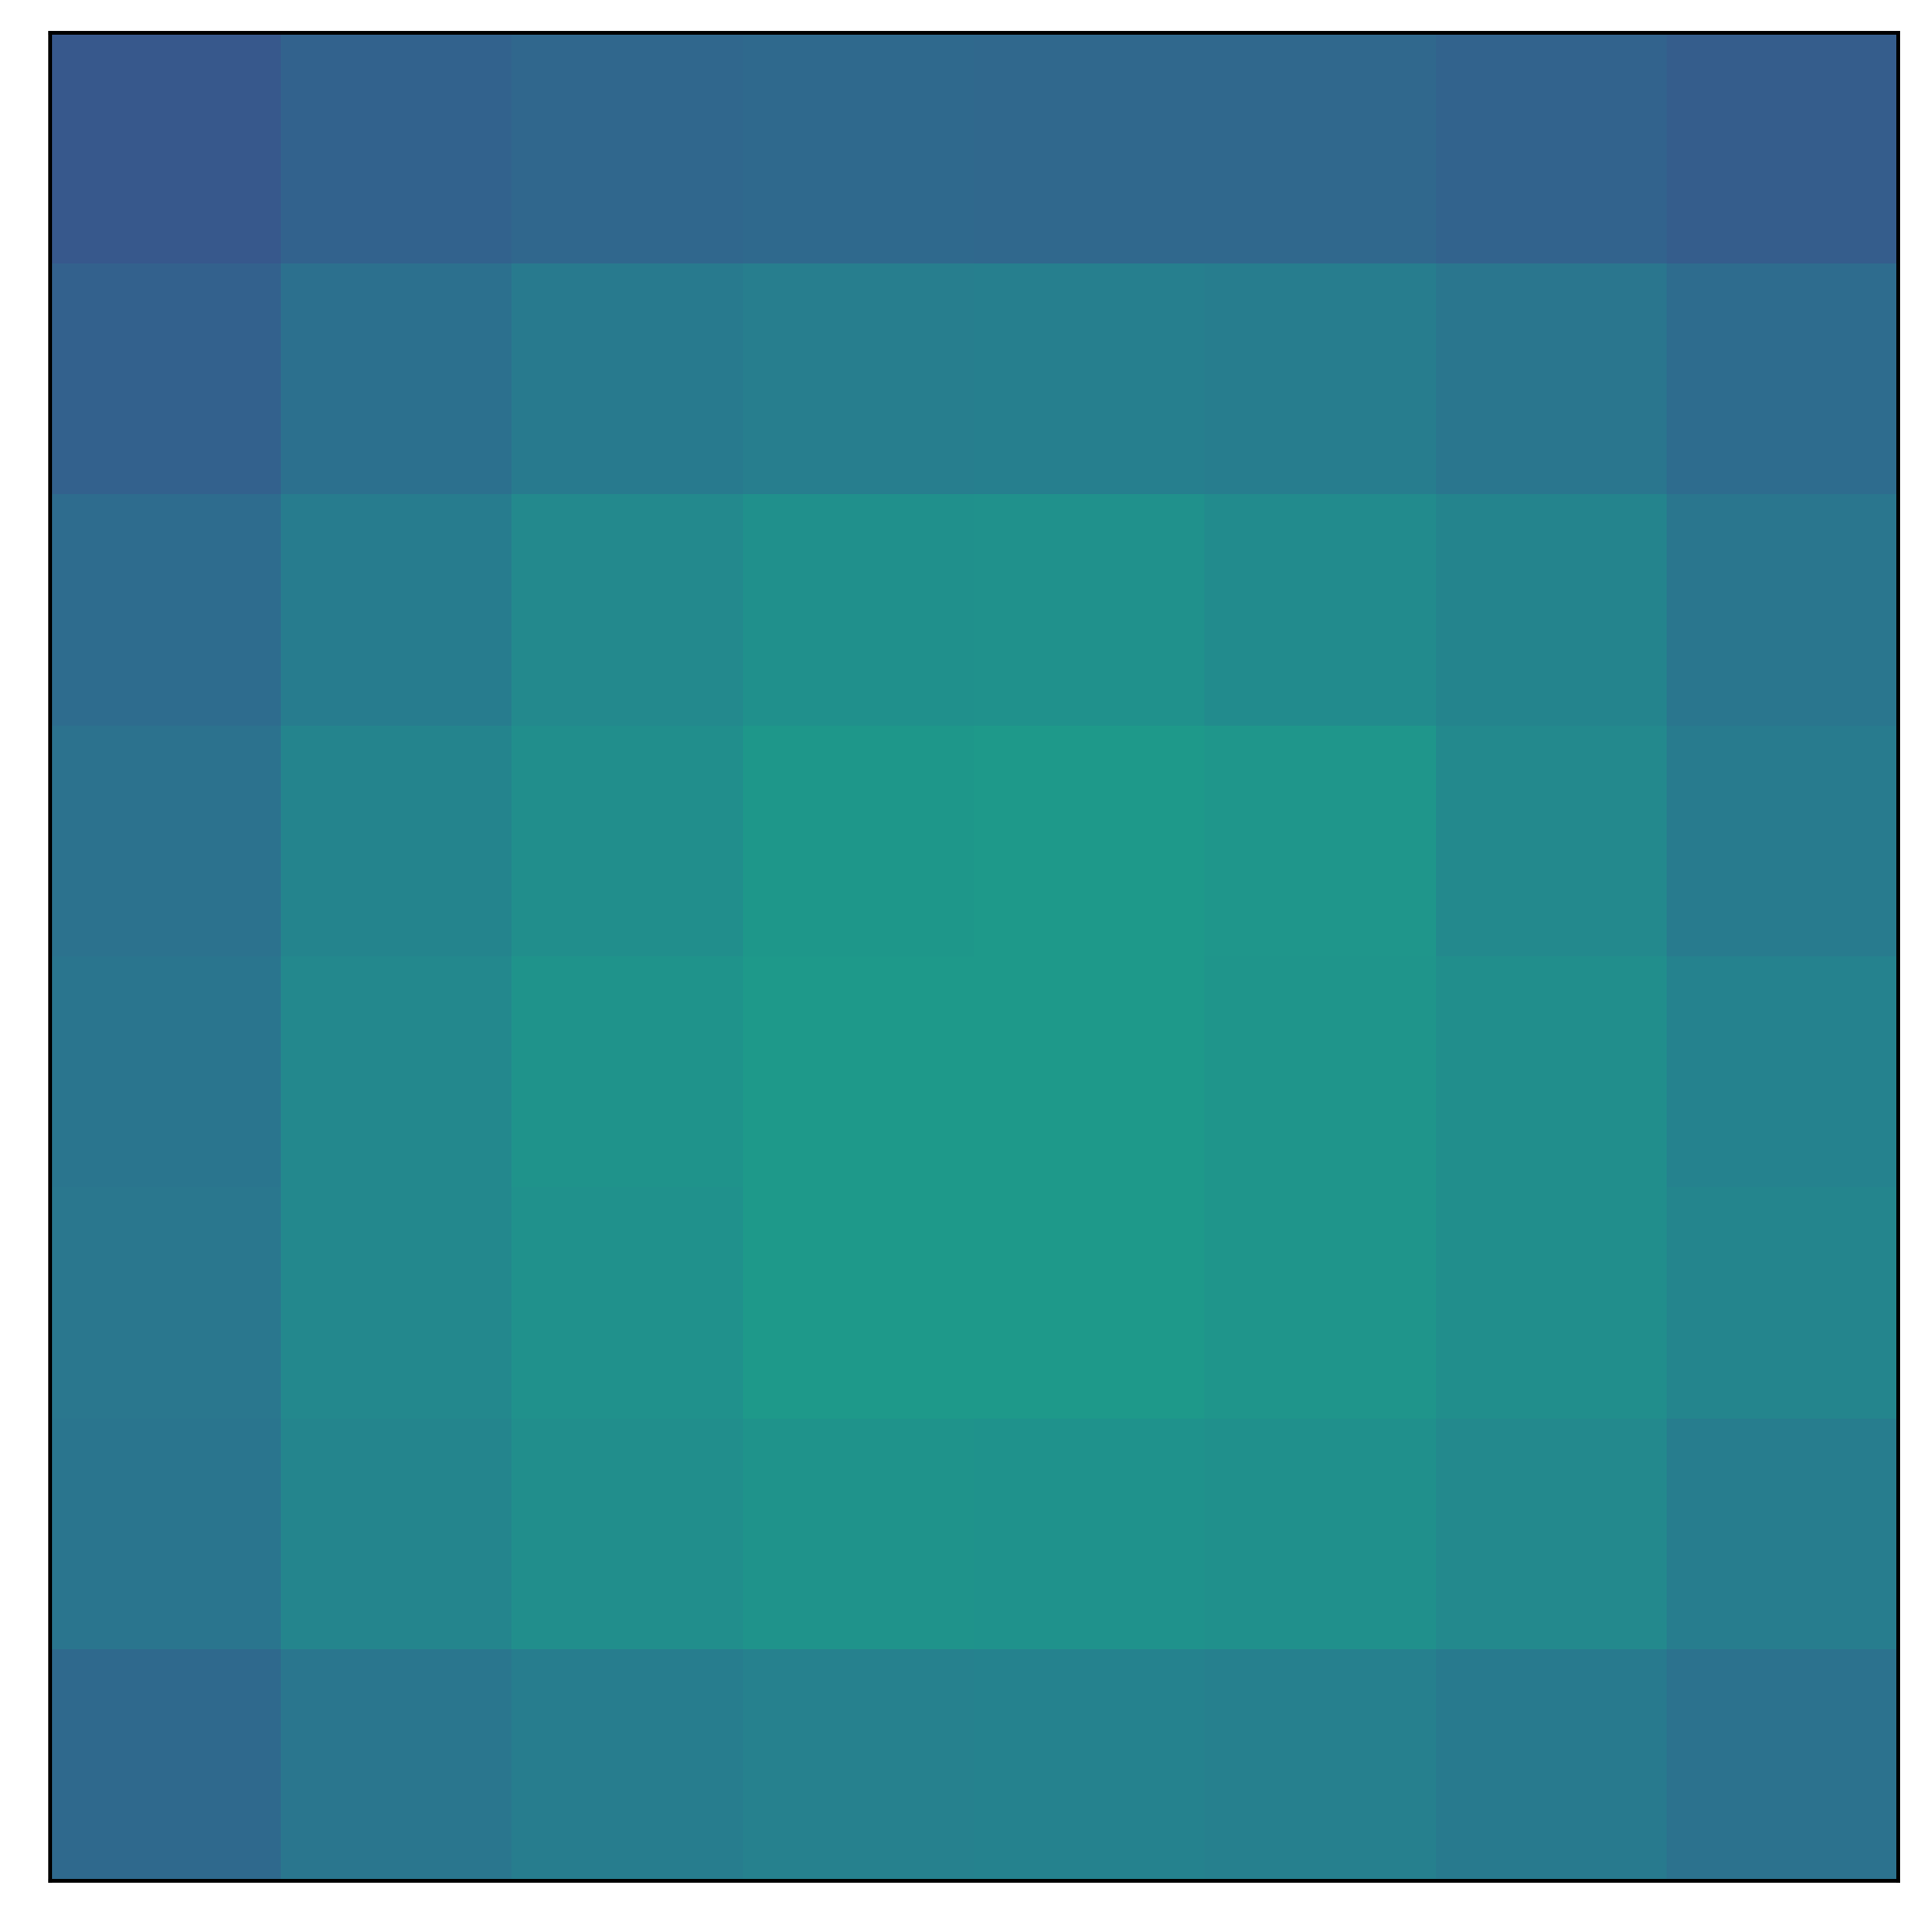

layer3-0-conv2


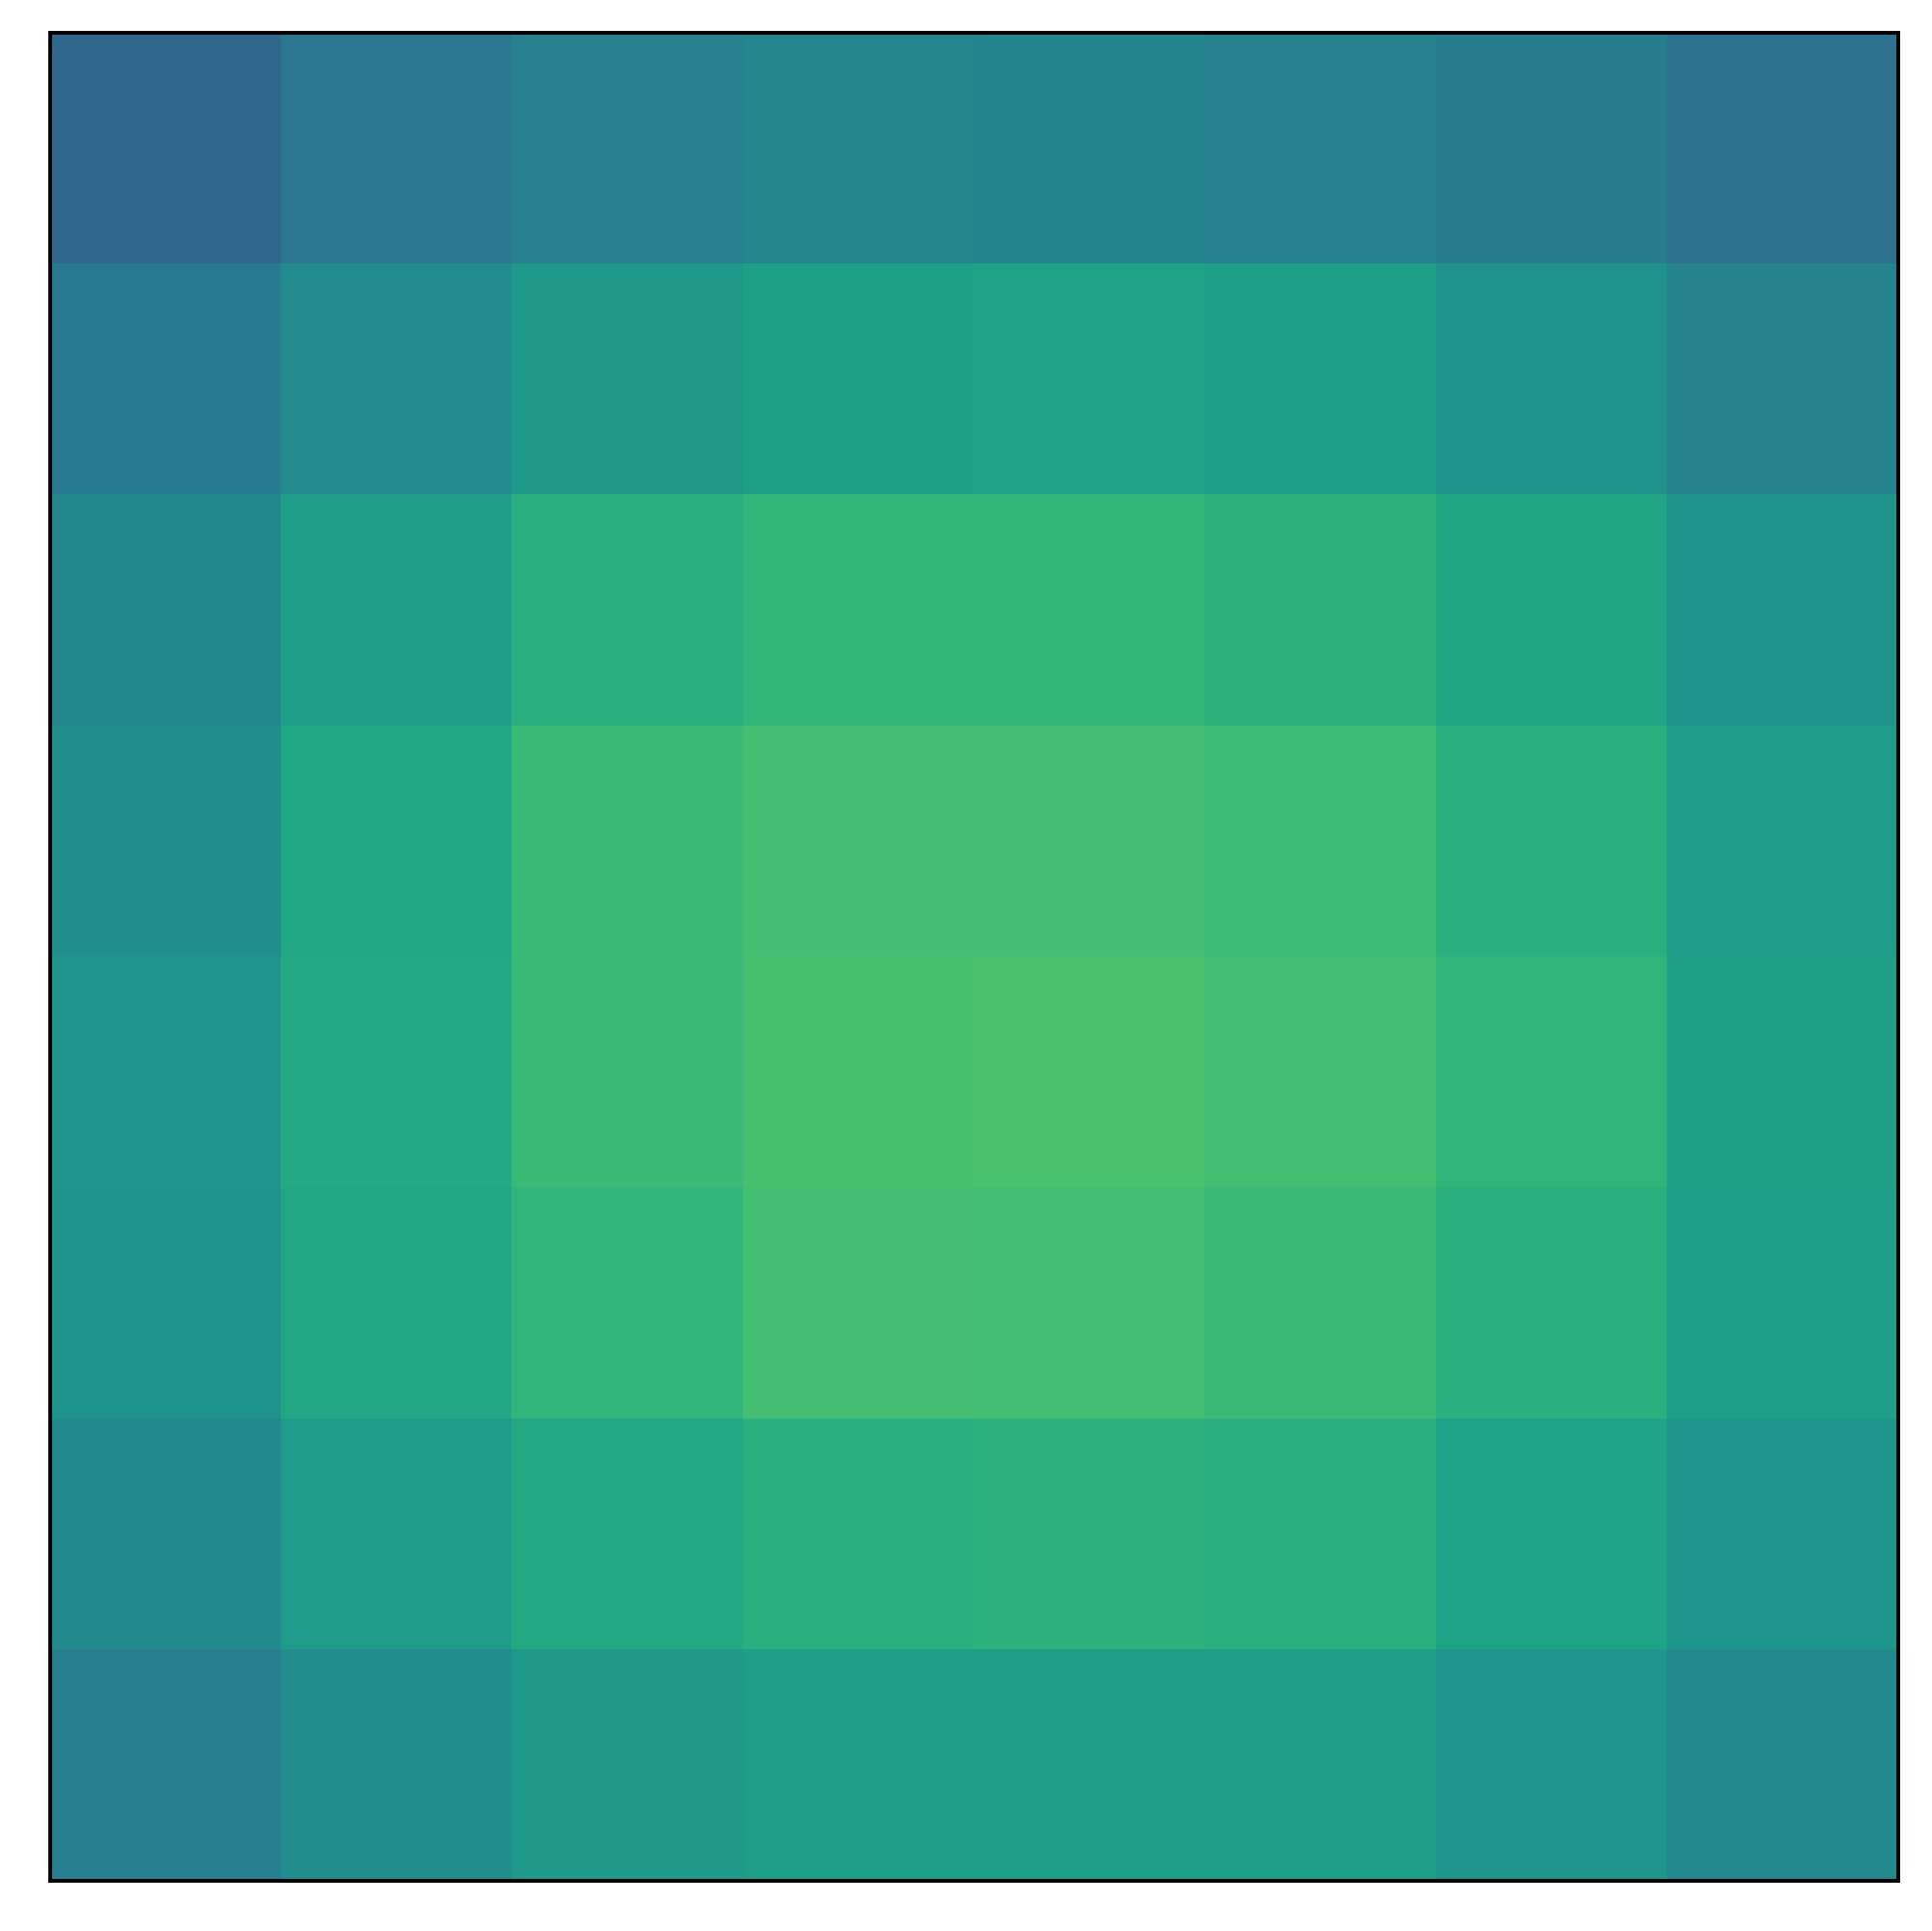

layer3-1-conv1


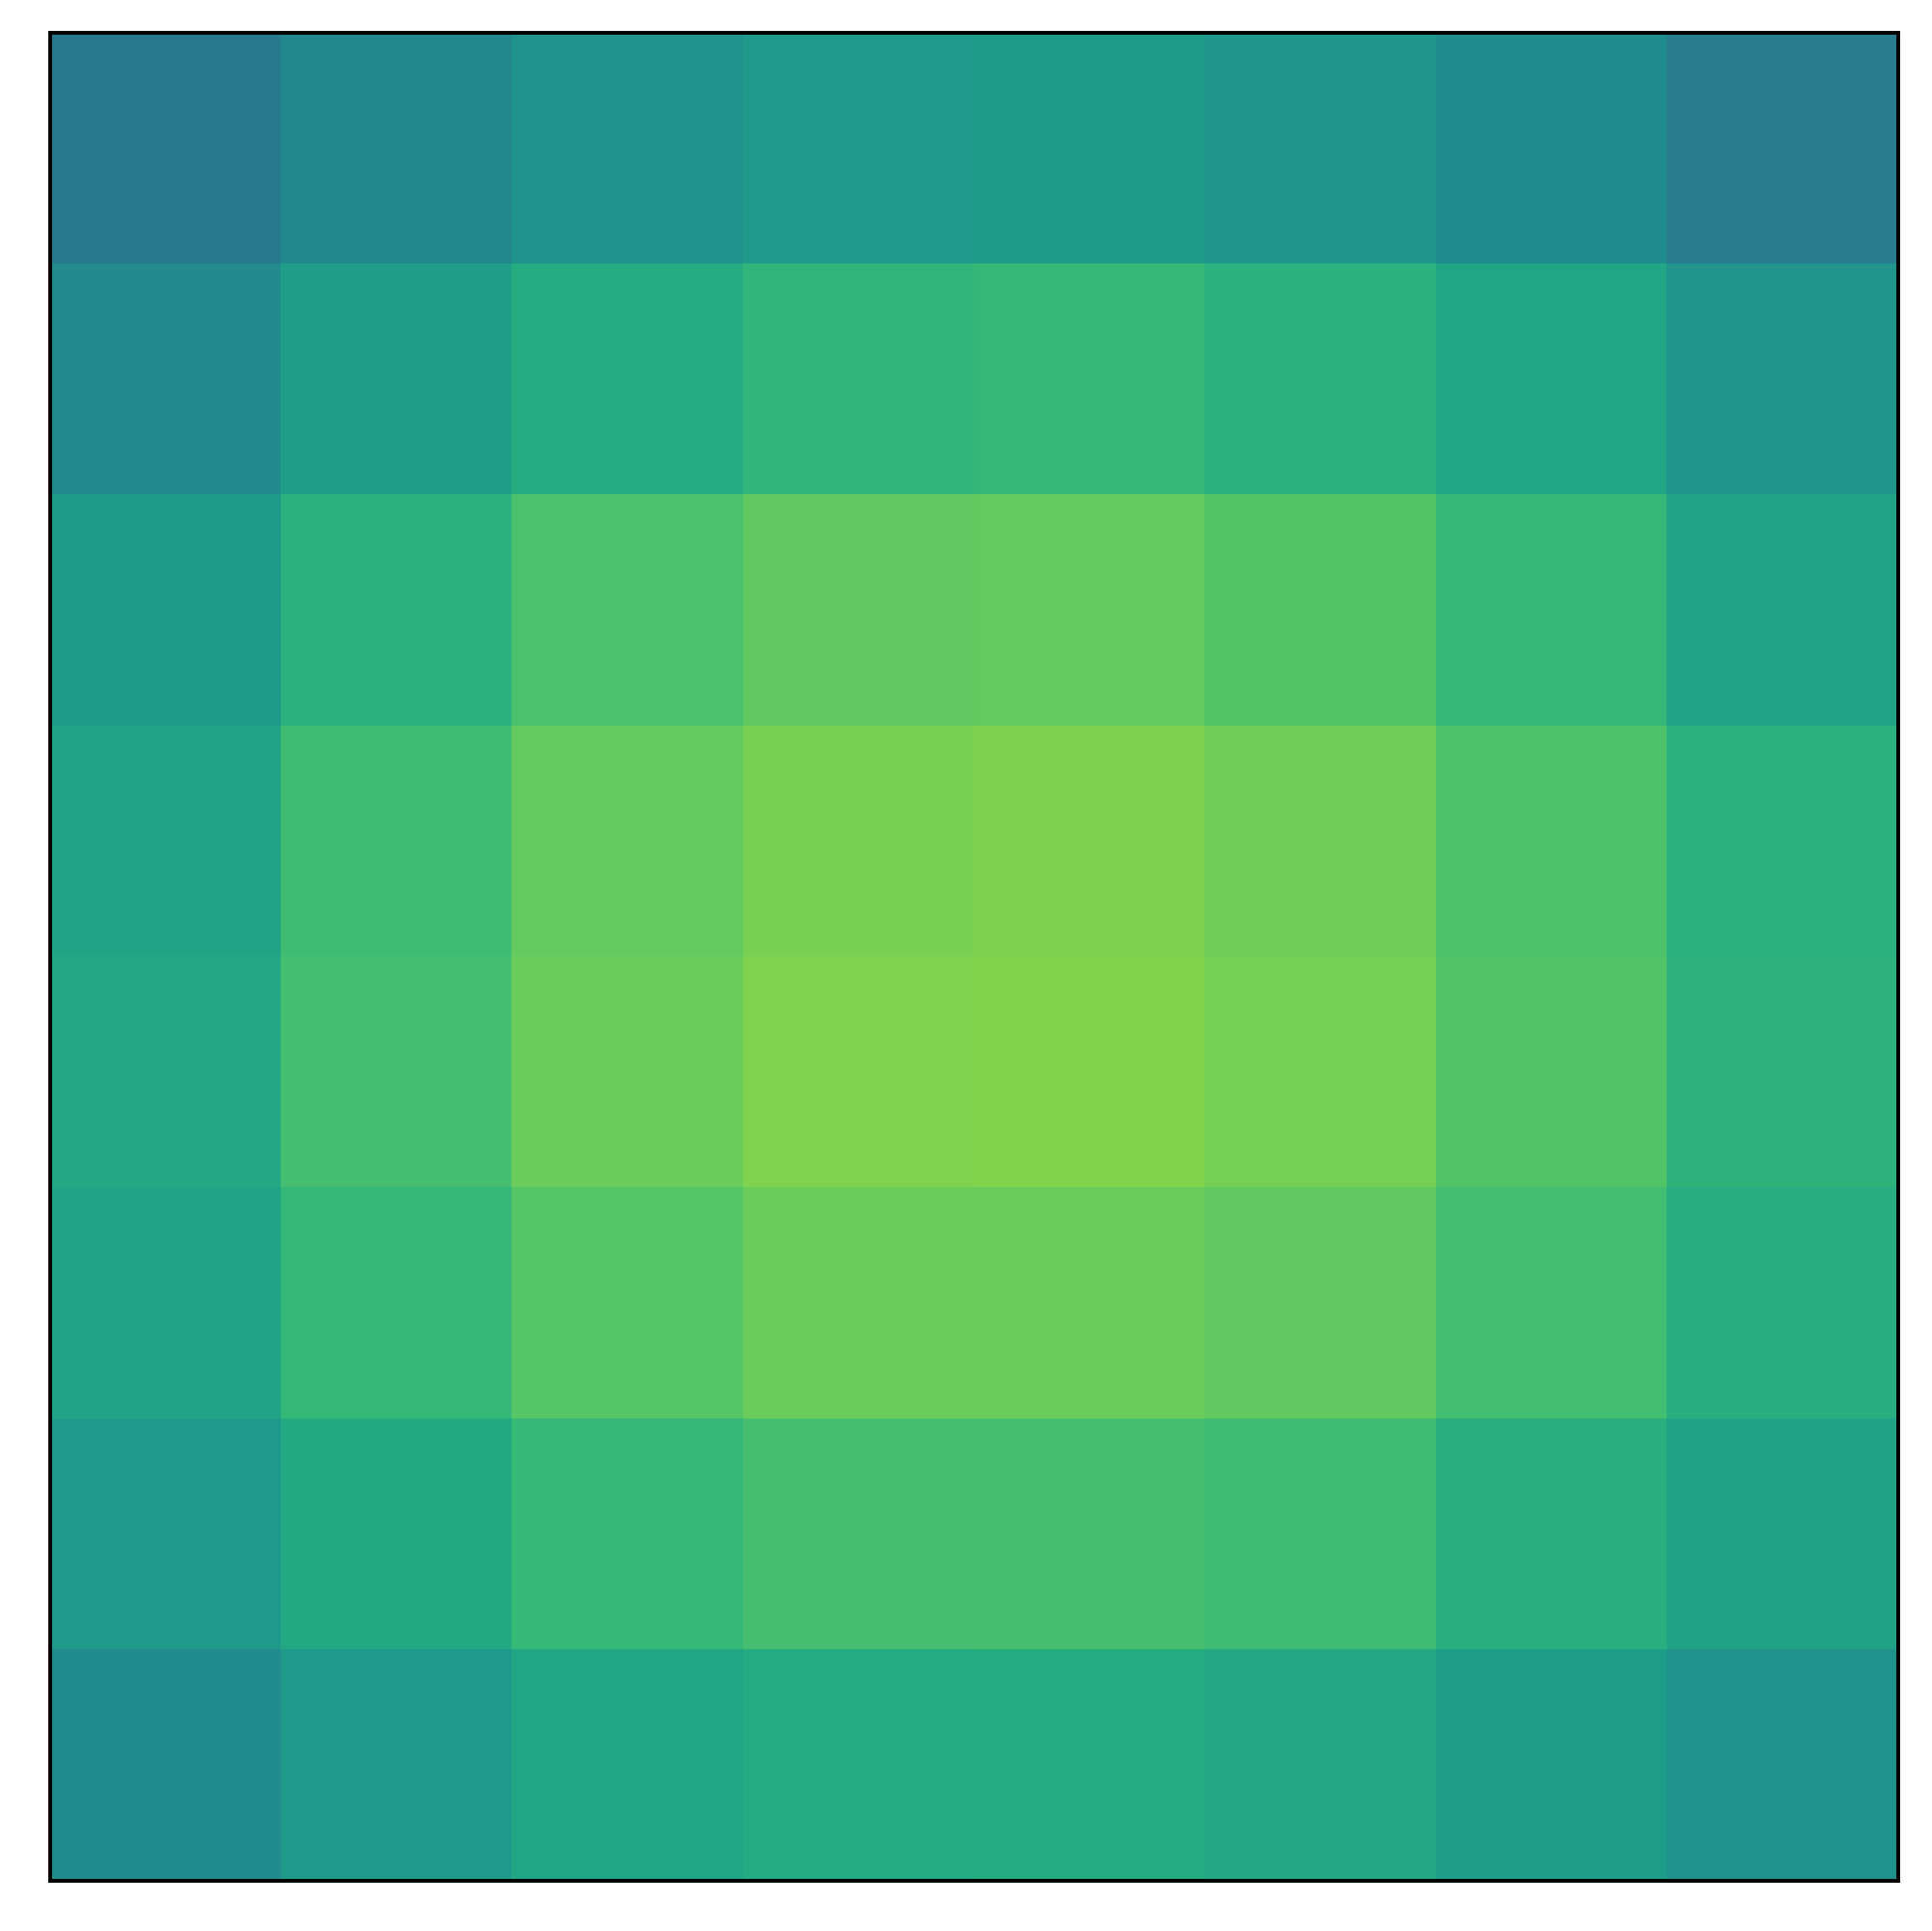

layer3-1-conv2


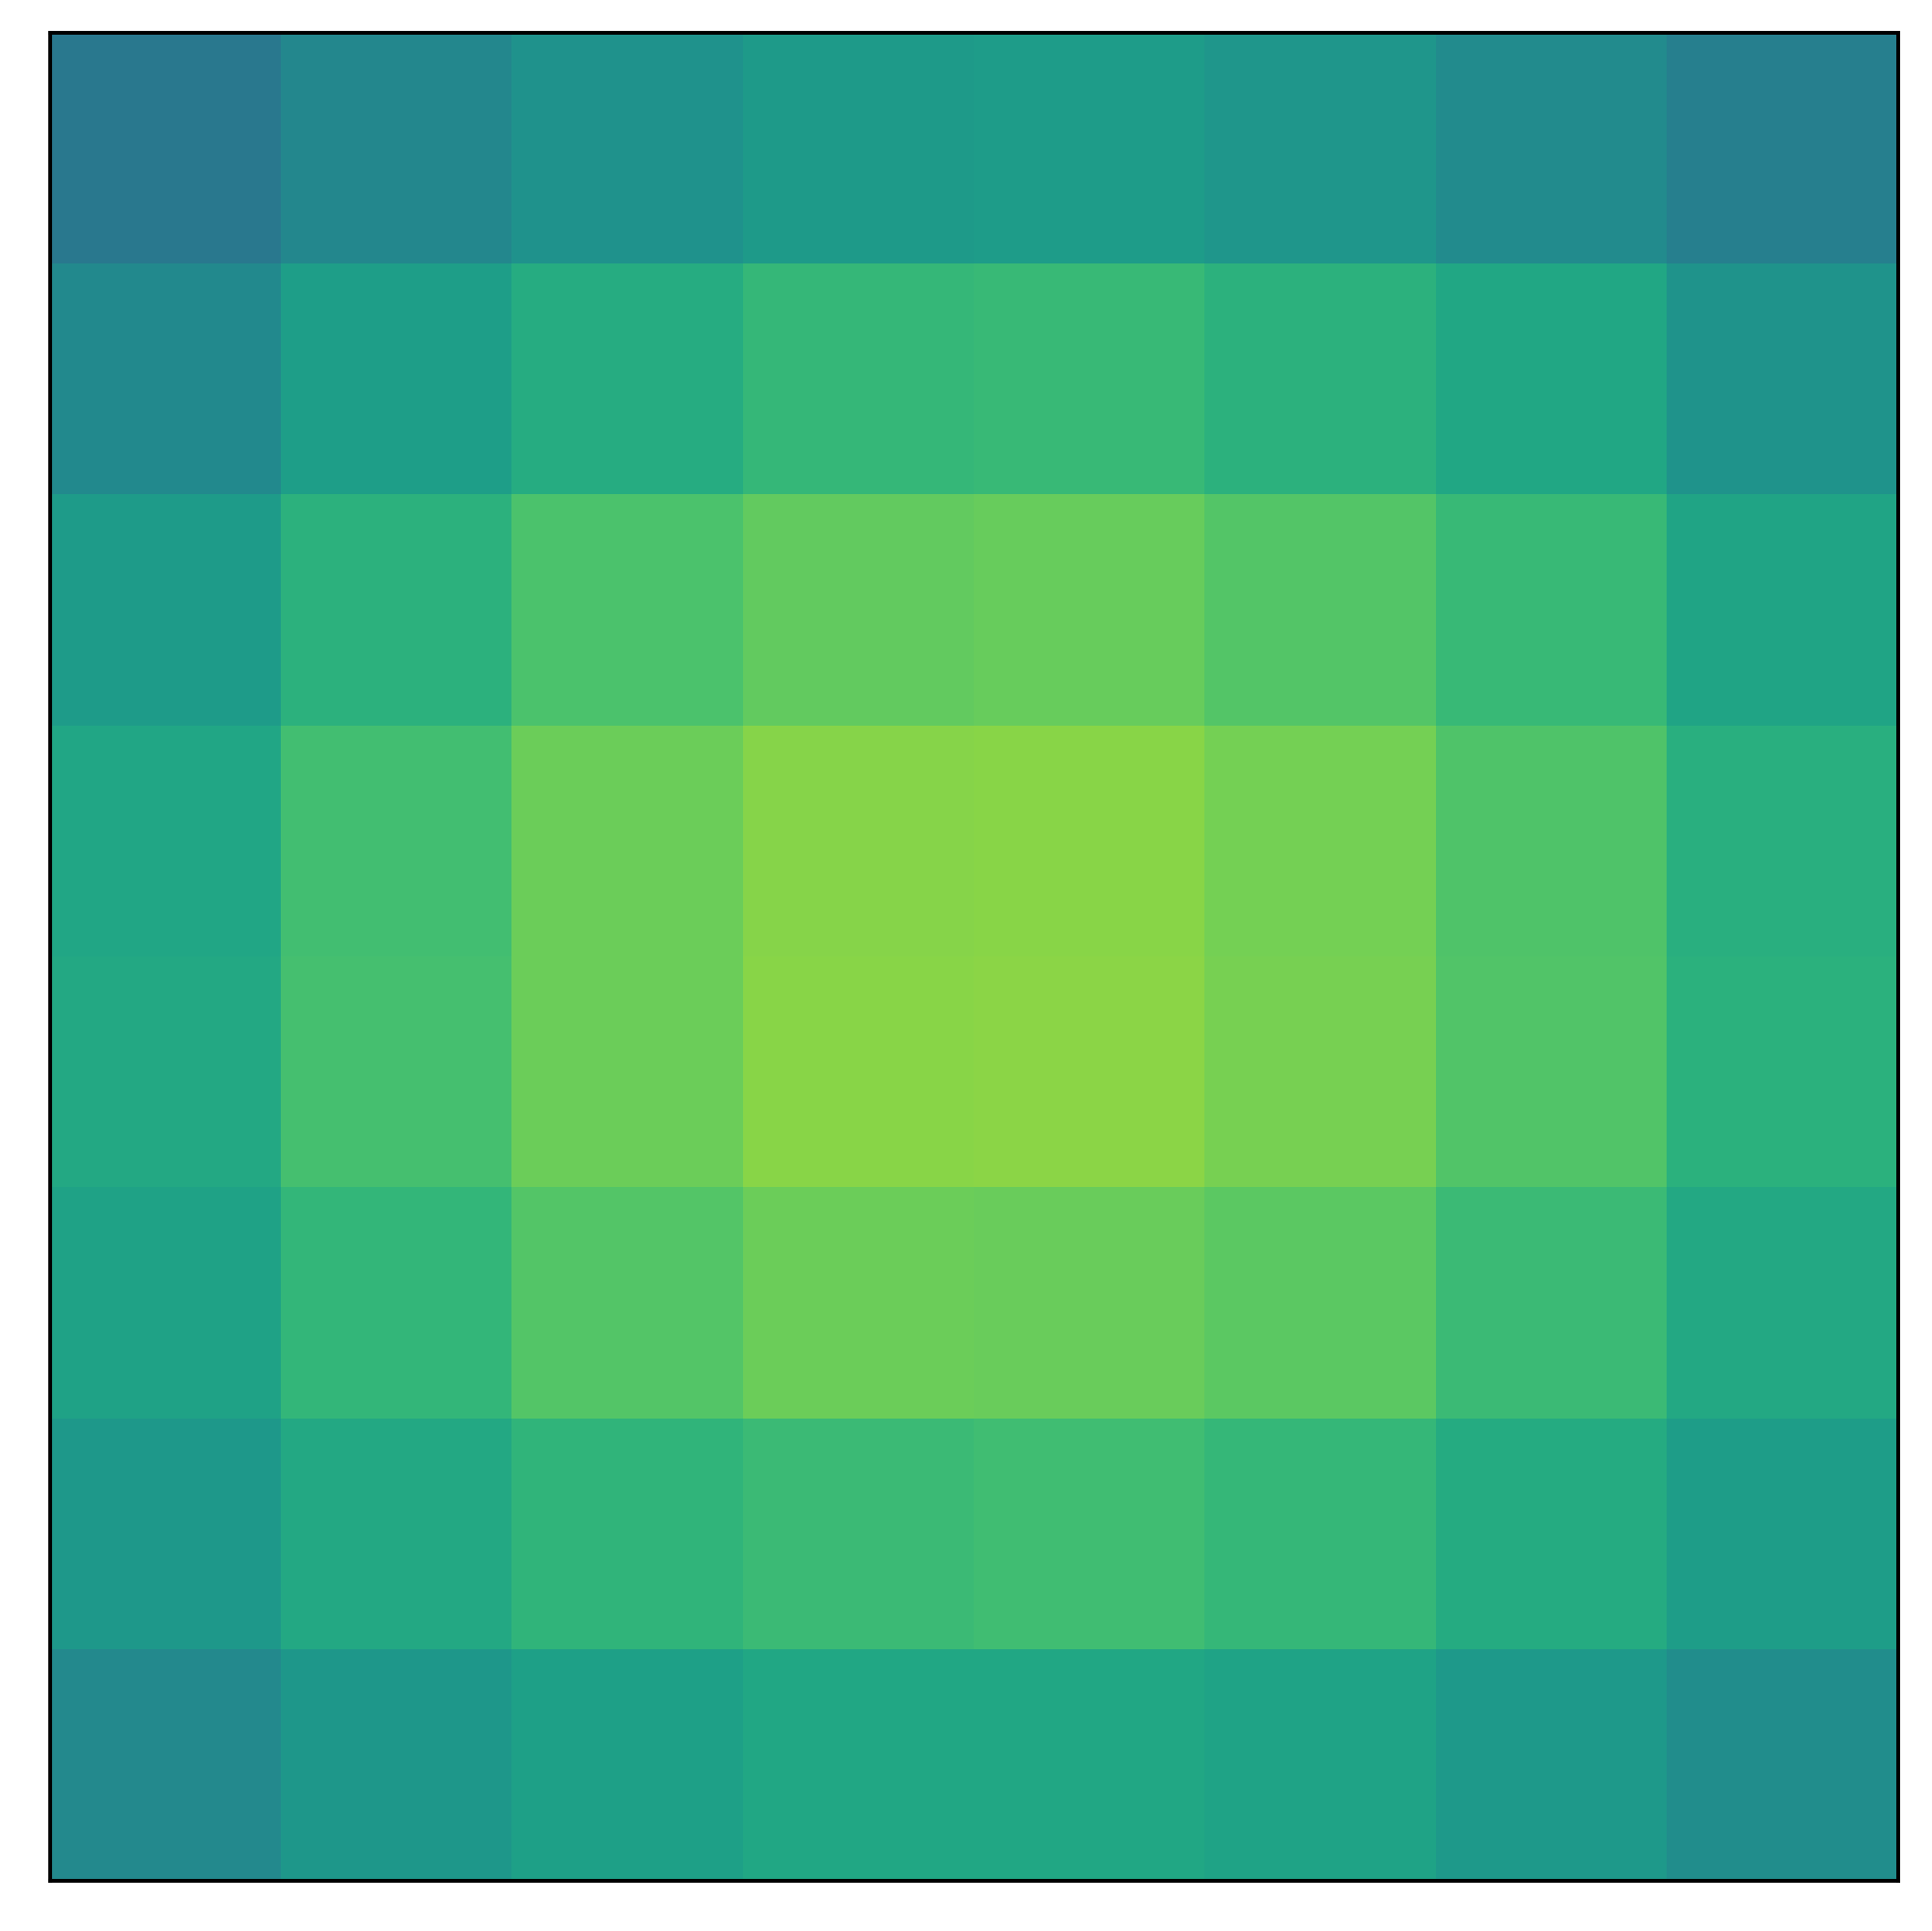

layer4-0-conv1


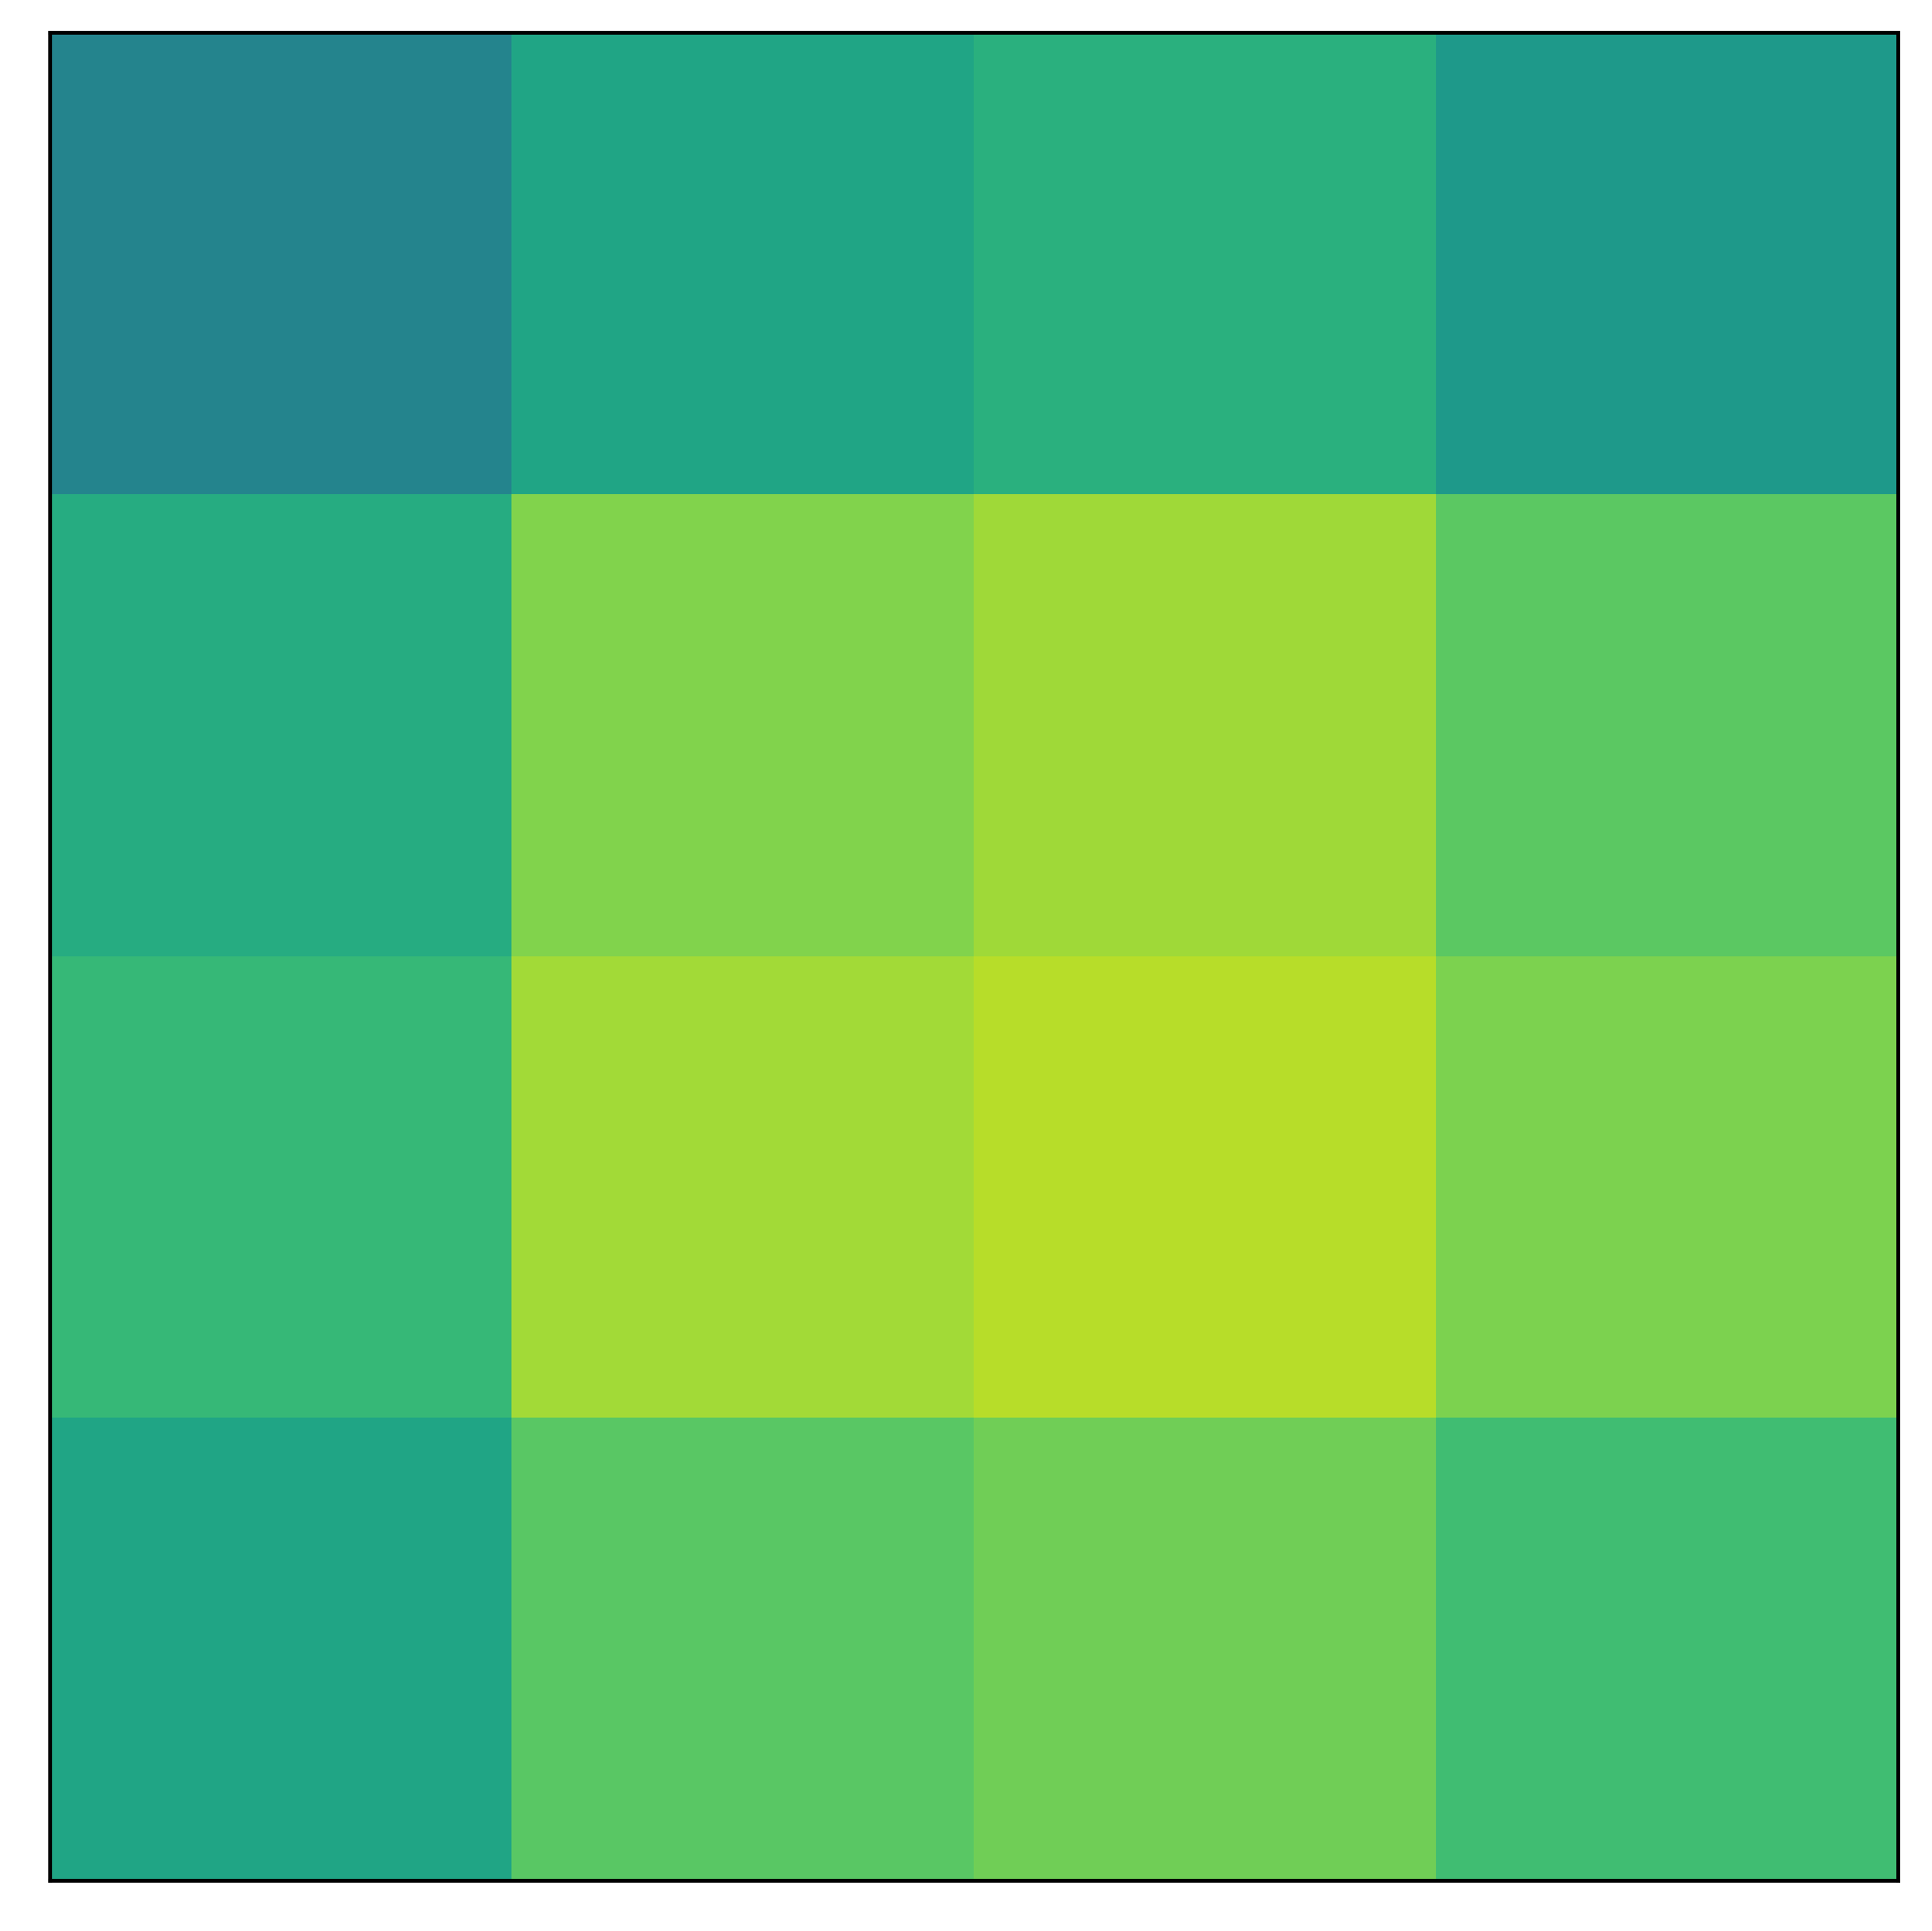

layer4-0-conv2


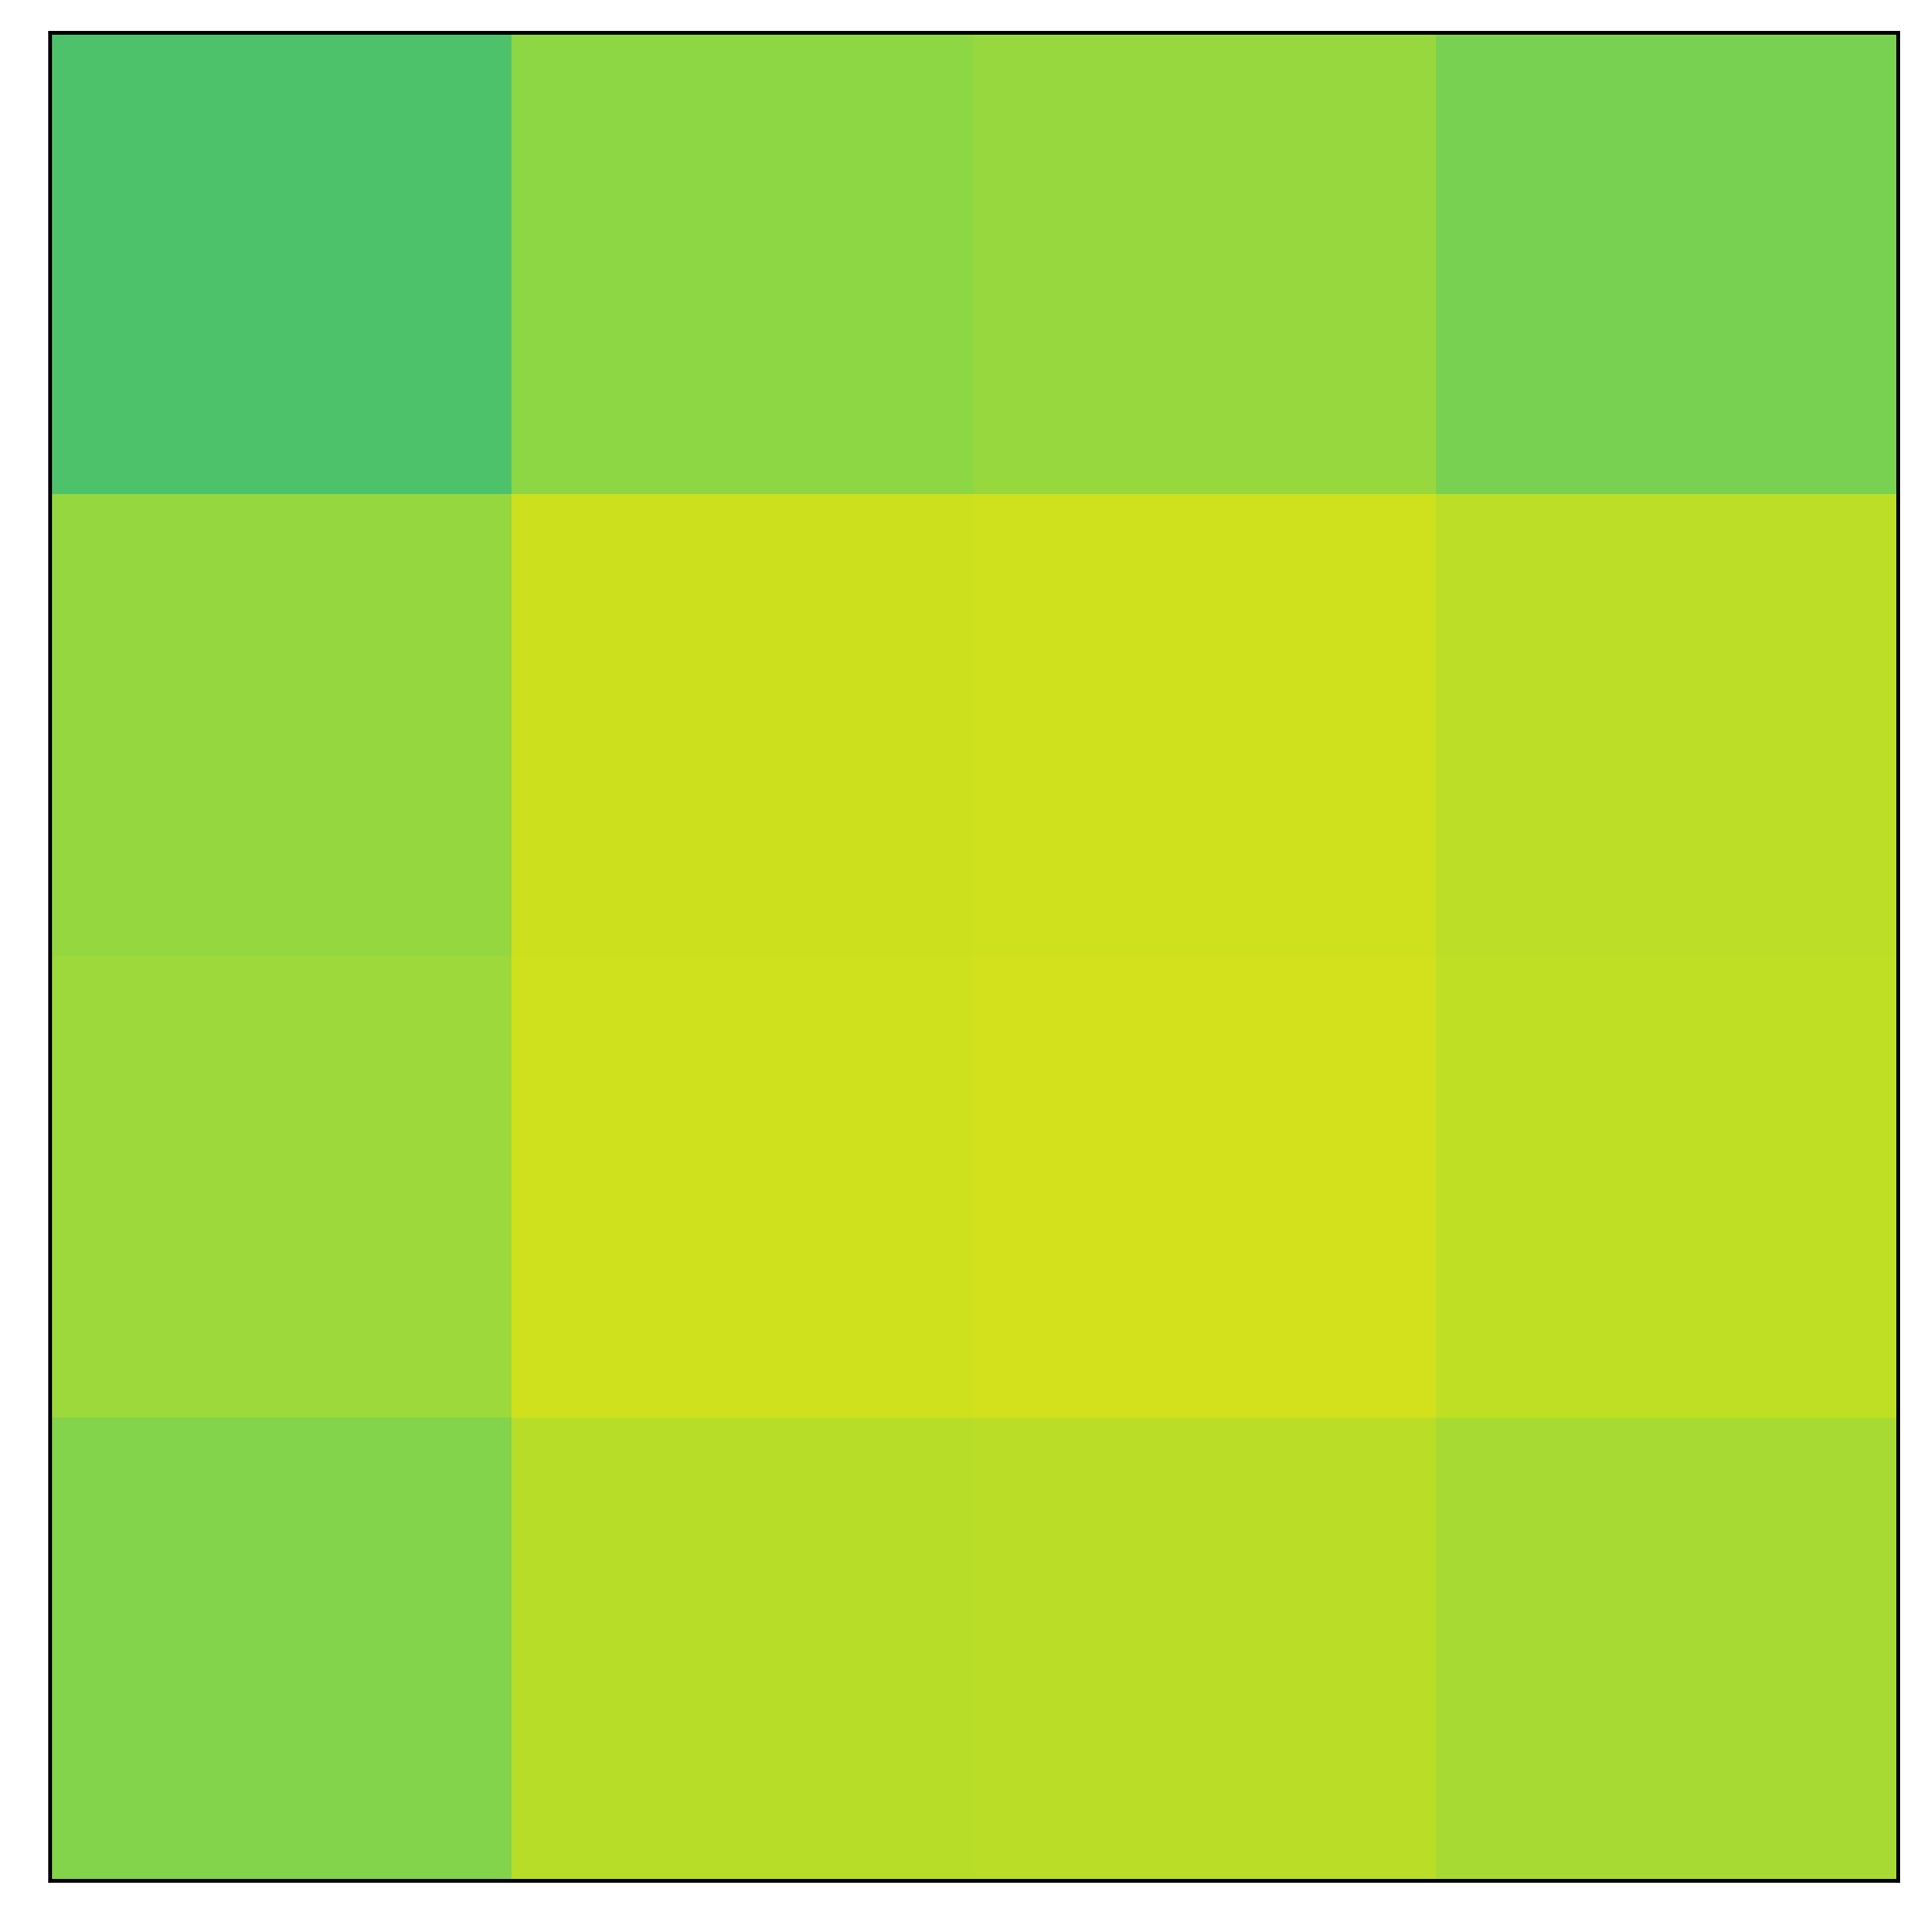

layer4-1-conv1


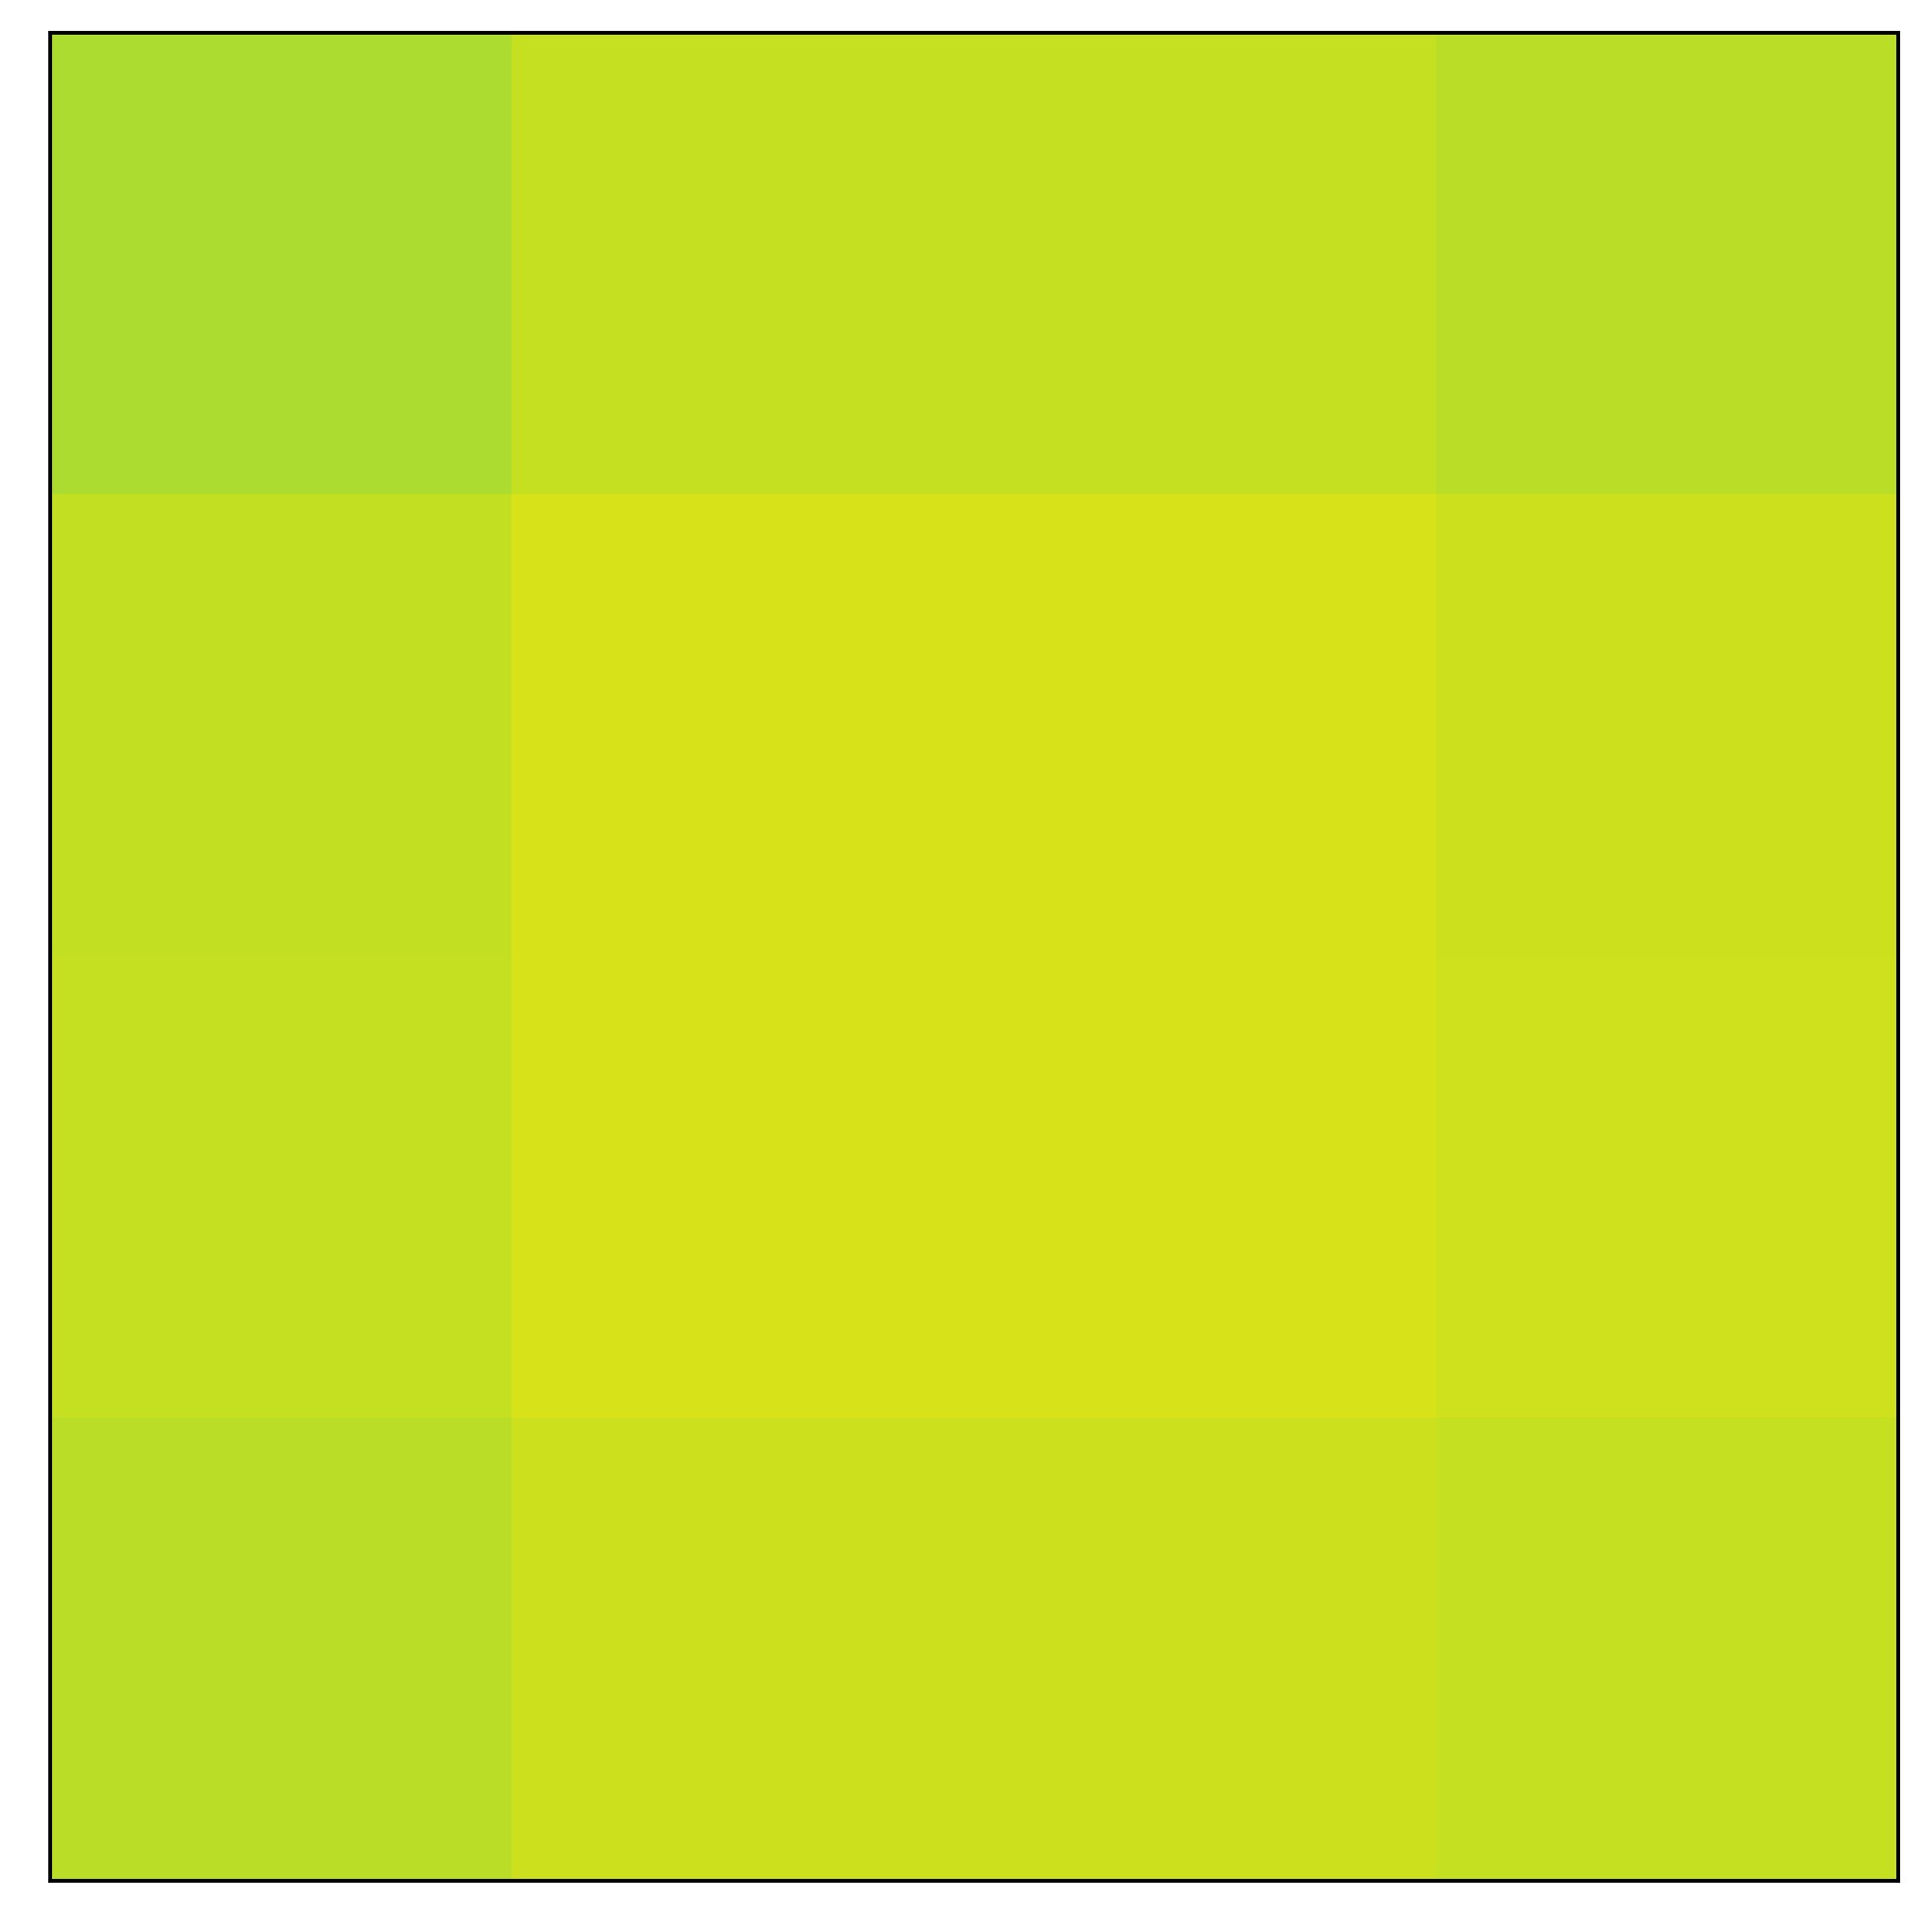

layer4-1-conv2


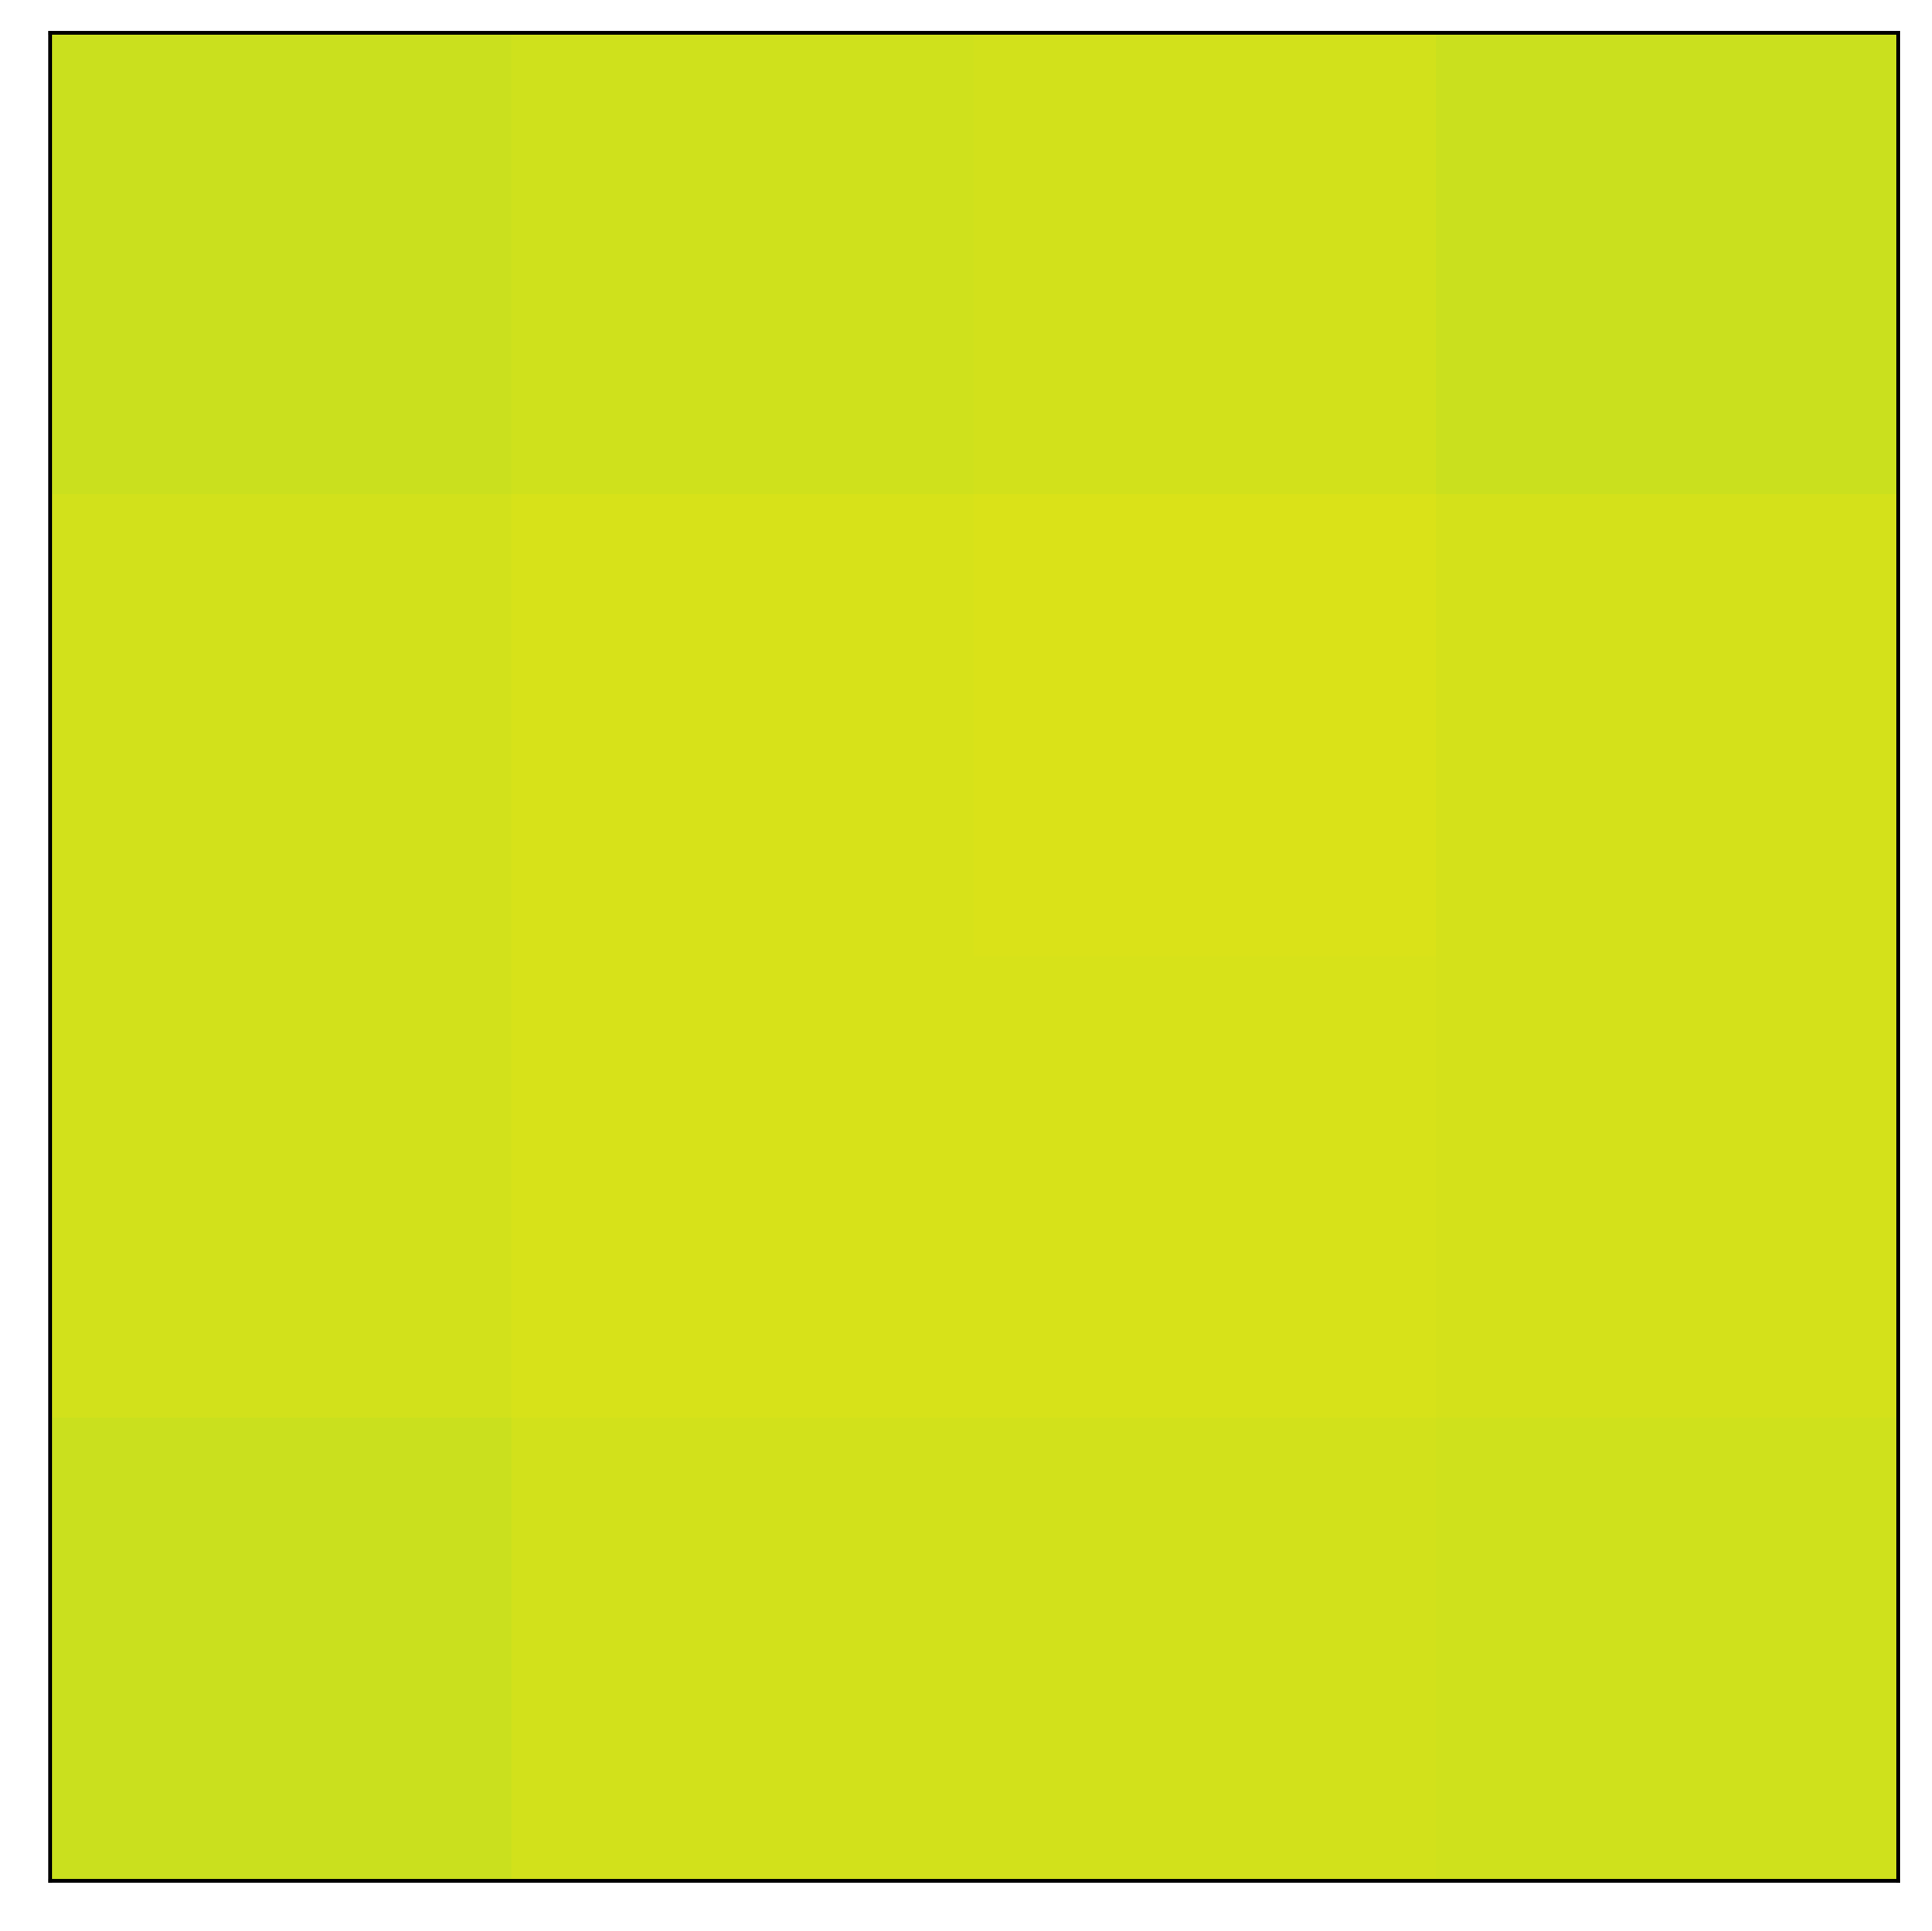

In [11]:
import imageio

heatmaps = get_heatmaps(resnet18pc)
layers = [
    'train-conv1', 
    'train-layer1-0-conv1',
    'train-layer1-0-conv2', 
    'train-layer1-1-conv1',
    'train-layer1-1-conv2', 
   # 'train-layer2-0-shortcut-0',
    'train-layer2-0-conv1',
    'train-layer2-0-conv2', 
    'train-layer2-1-conv1', 
    'train-layer2-1-conv2',
  #  'train-layer3-0-shortcut-0', 
    'train-layer3-0-conv1',
    'train-layer3-0-conv2',
    'train-layer3-1-conv1',
    'train-layer3-1-conv2',
 #   'train-layer4-0-shortcut-0',
    'train-layer4-0-conv1',
    'train-layer4-0-conv2',
    'train-layer4-1-conv1',
    'train-layer4-1-conv2',
]
images = []
for name in layers:
    heatmap = heatmaps[name]
    fig = plt.figure(figsize=(6,6))
    #plt.title(name.replace("train-", ""))
    print(name.replace("train-", ""))
    plt.imshow(heatmap)
    plt.clim((0.0, 1.0))
    plt.xticks([])
    plt.yticks([])
    #cbar = plt.colorbar()
    #cbar.set_label("Accuracy", rotation=270)
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.tight_layout()
    images.append(image)
    savepath = join(path, name.replace("train-", "") + ".png")
    plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
imageio.mimsave('./resnet18pc_receptive_field.gif',images, fps=1)

<ipython-input-5-7e58538604f9>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df["x"], layer_df["y"] = x, y


features-0


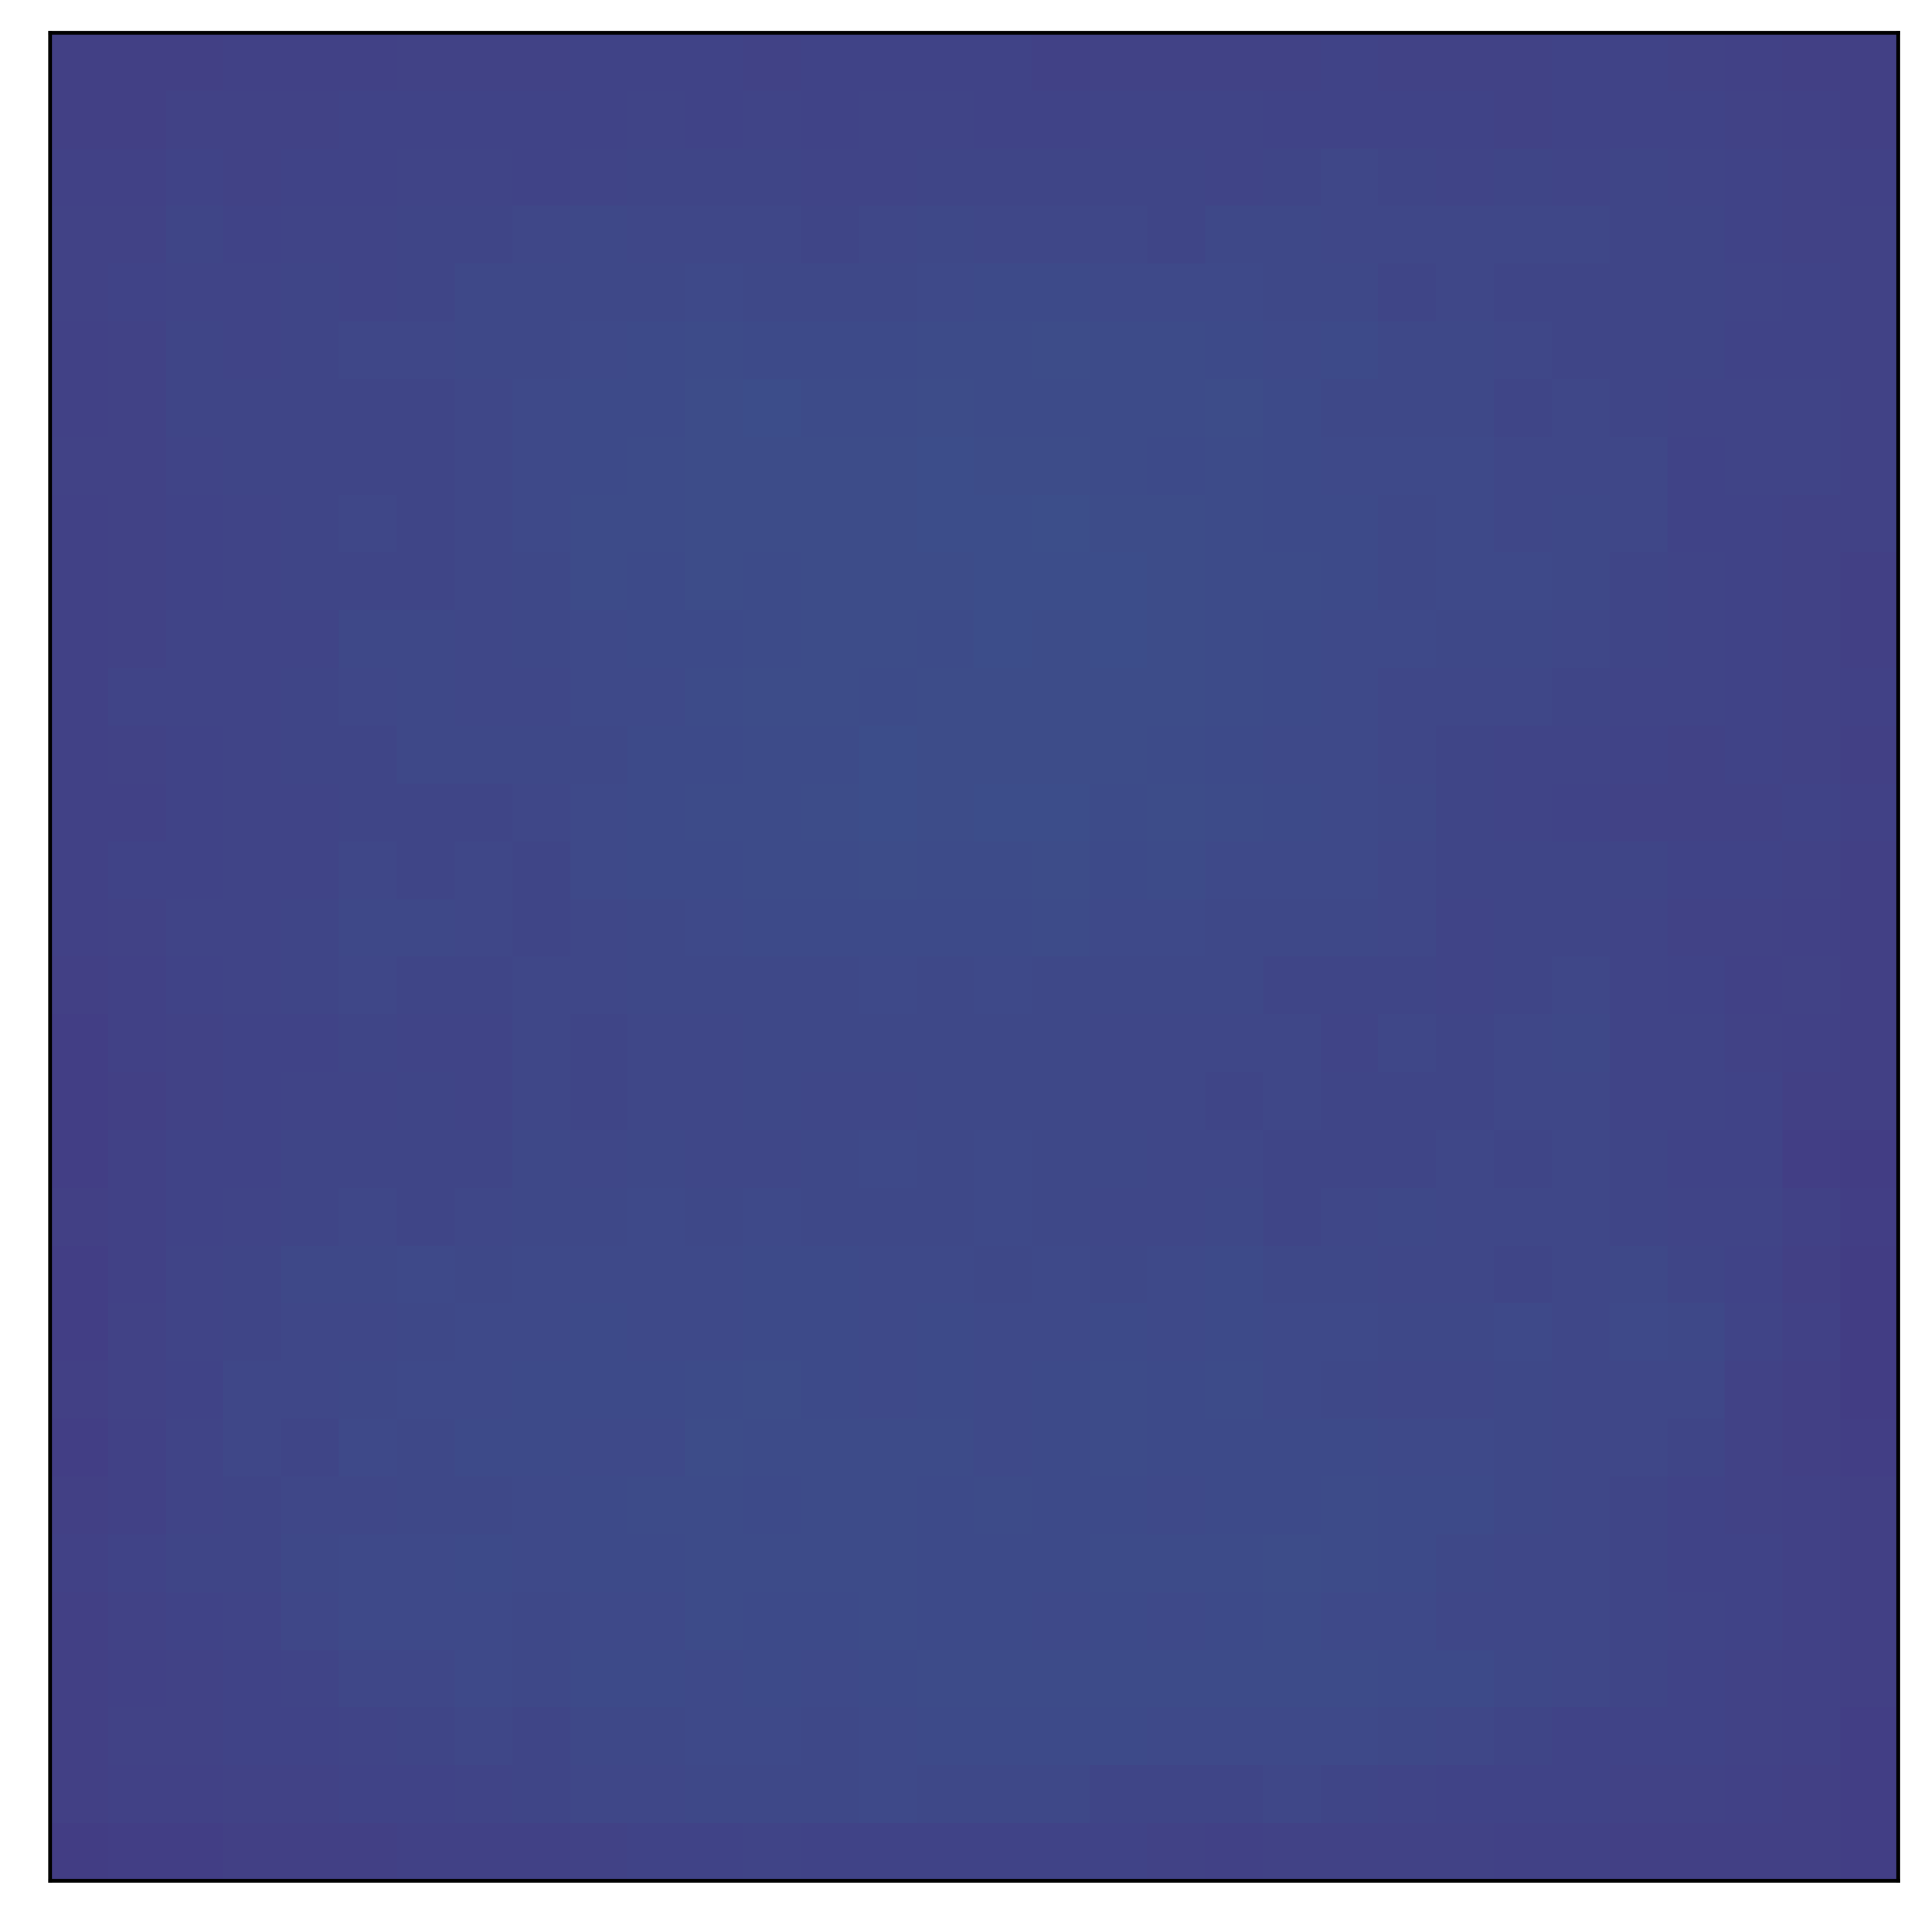

features-3


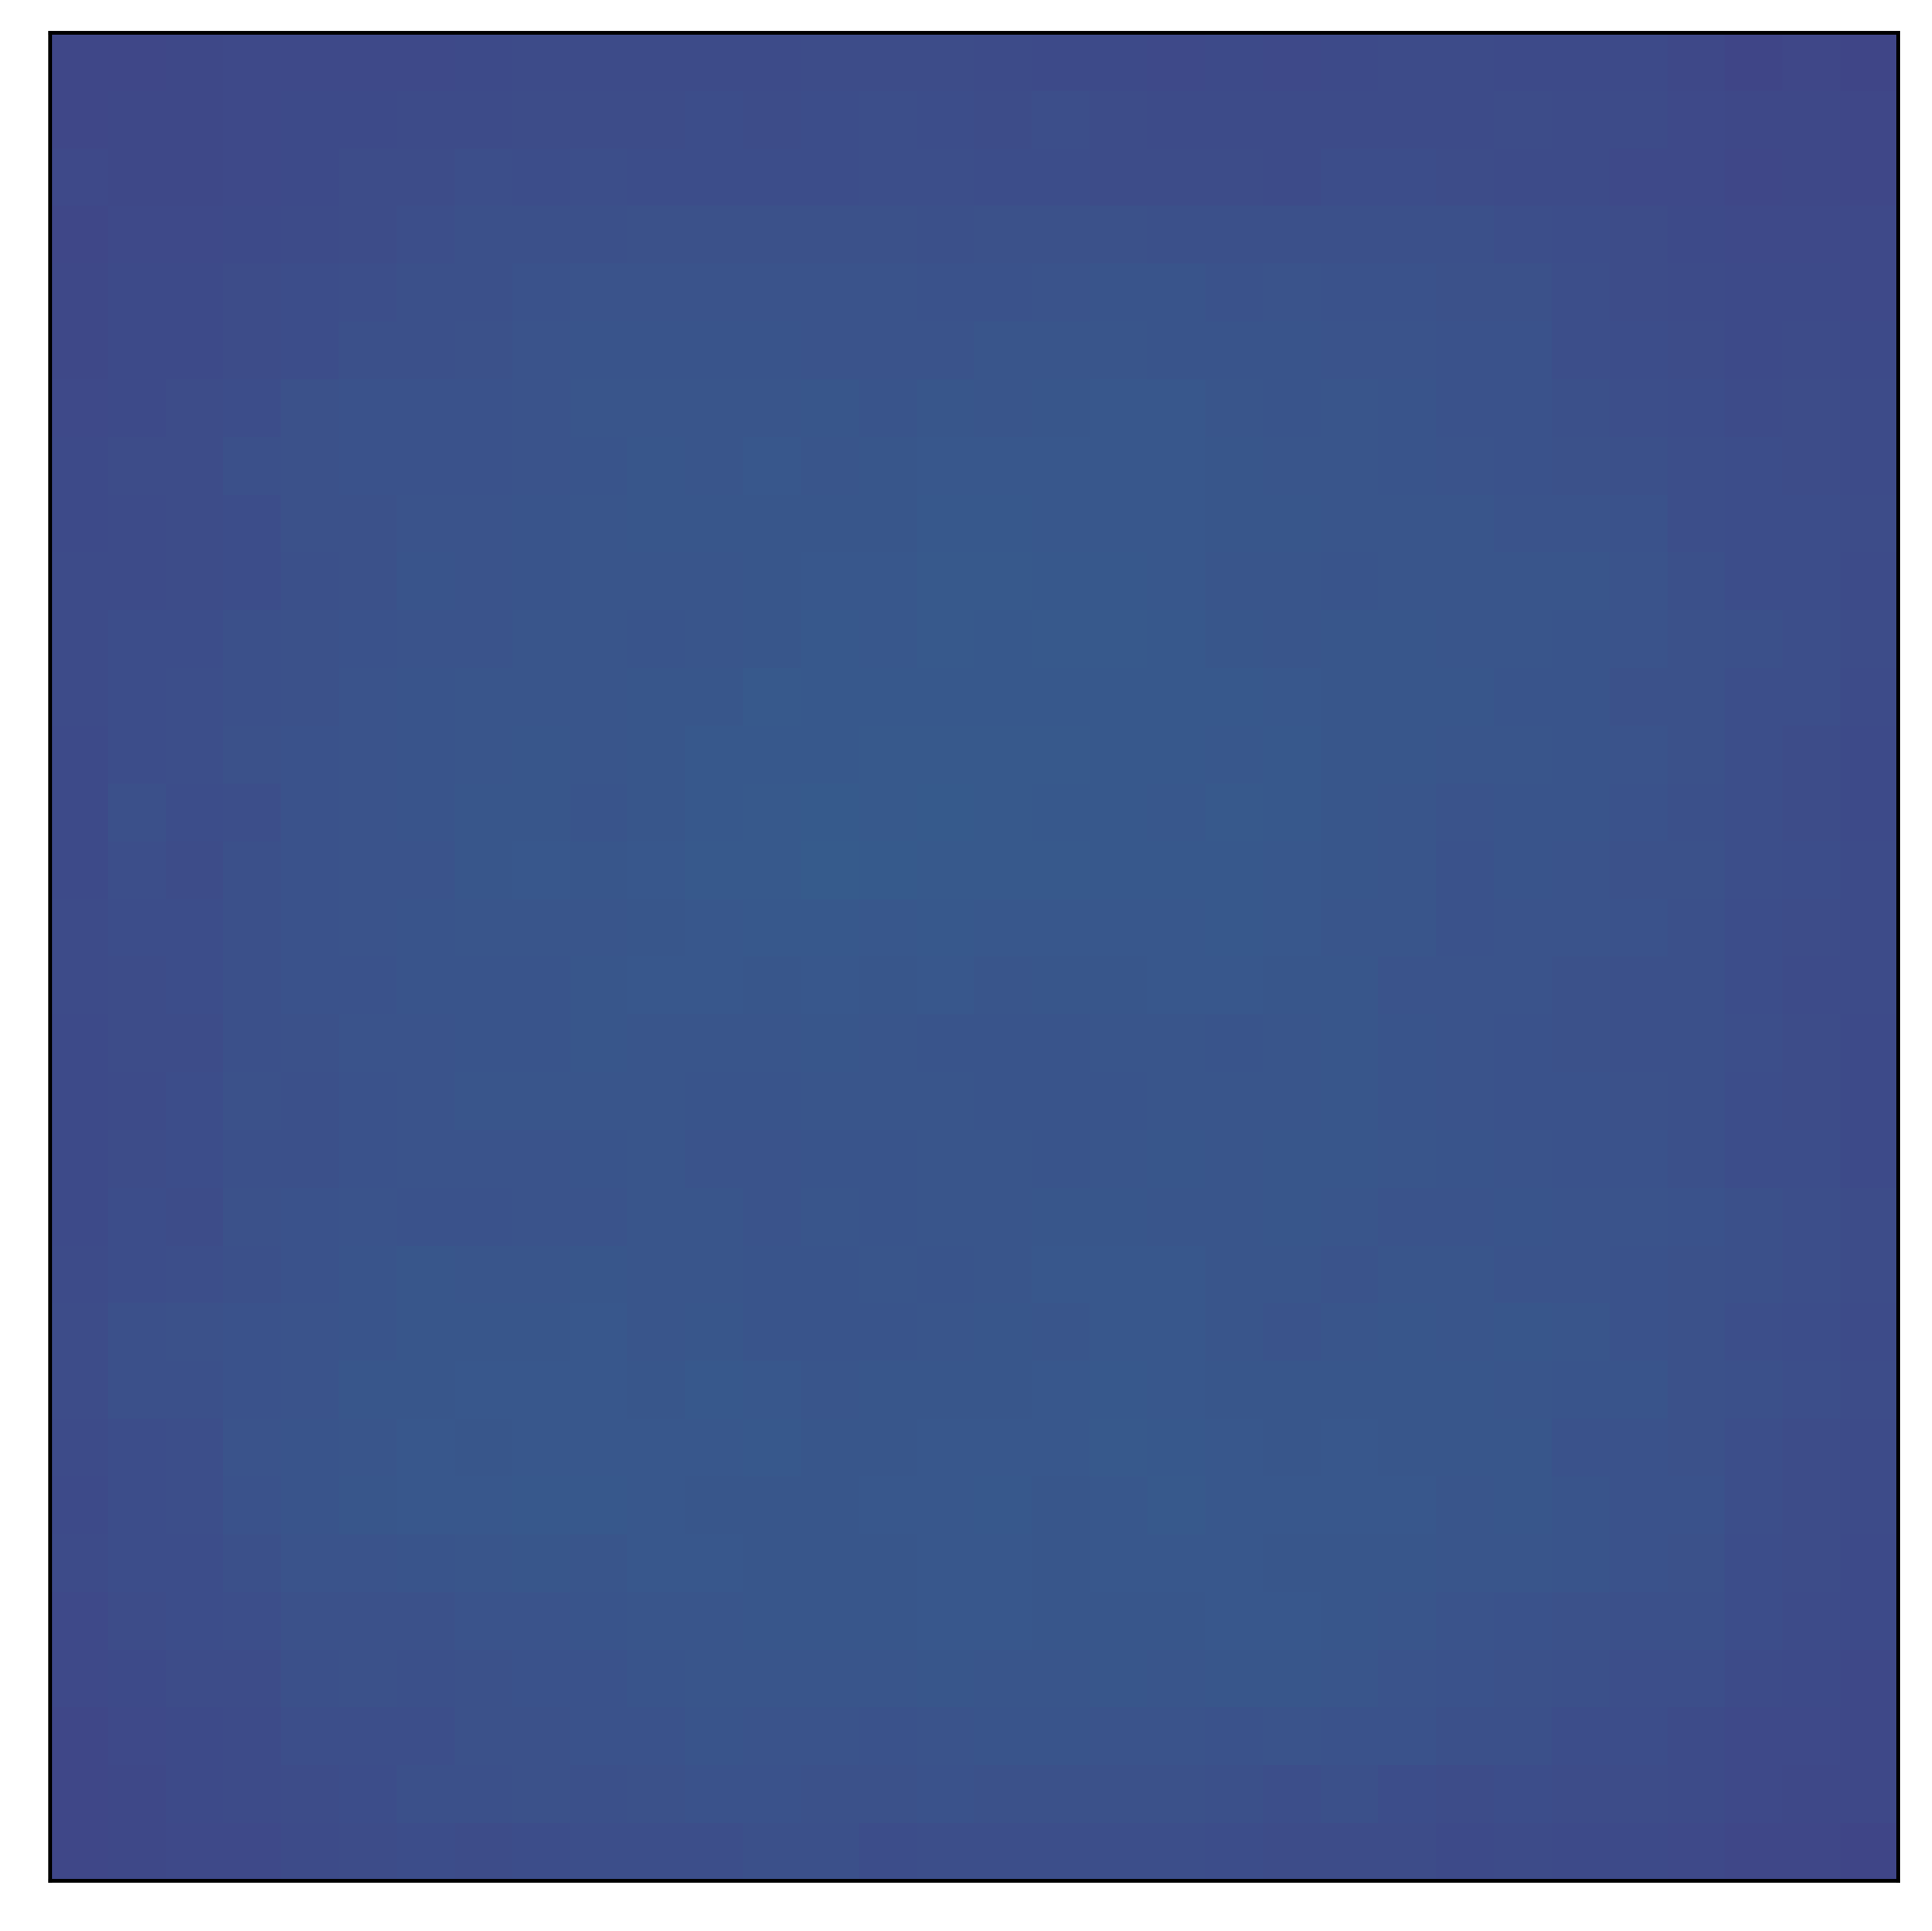

features-7


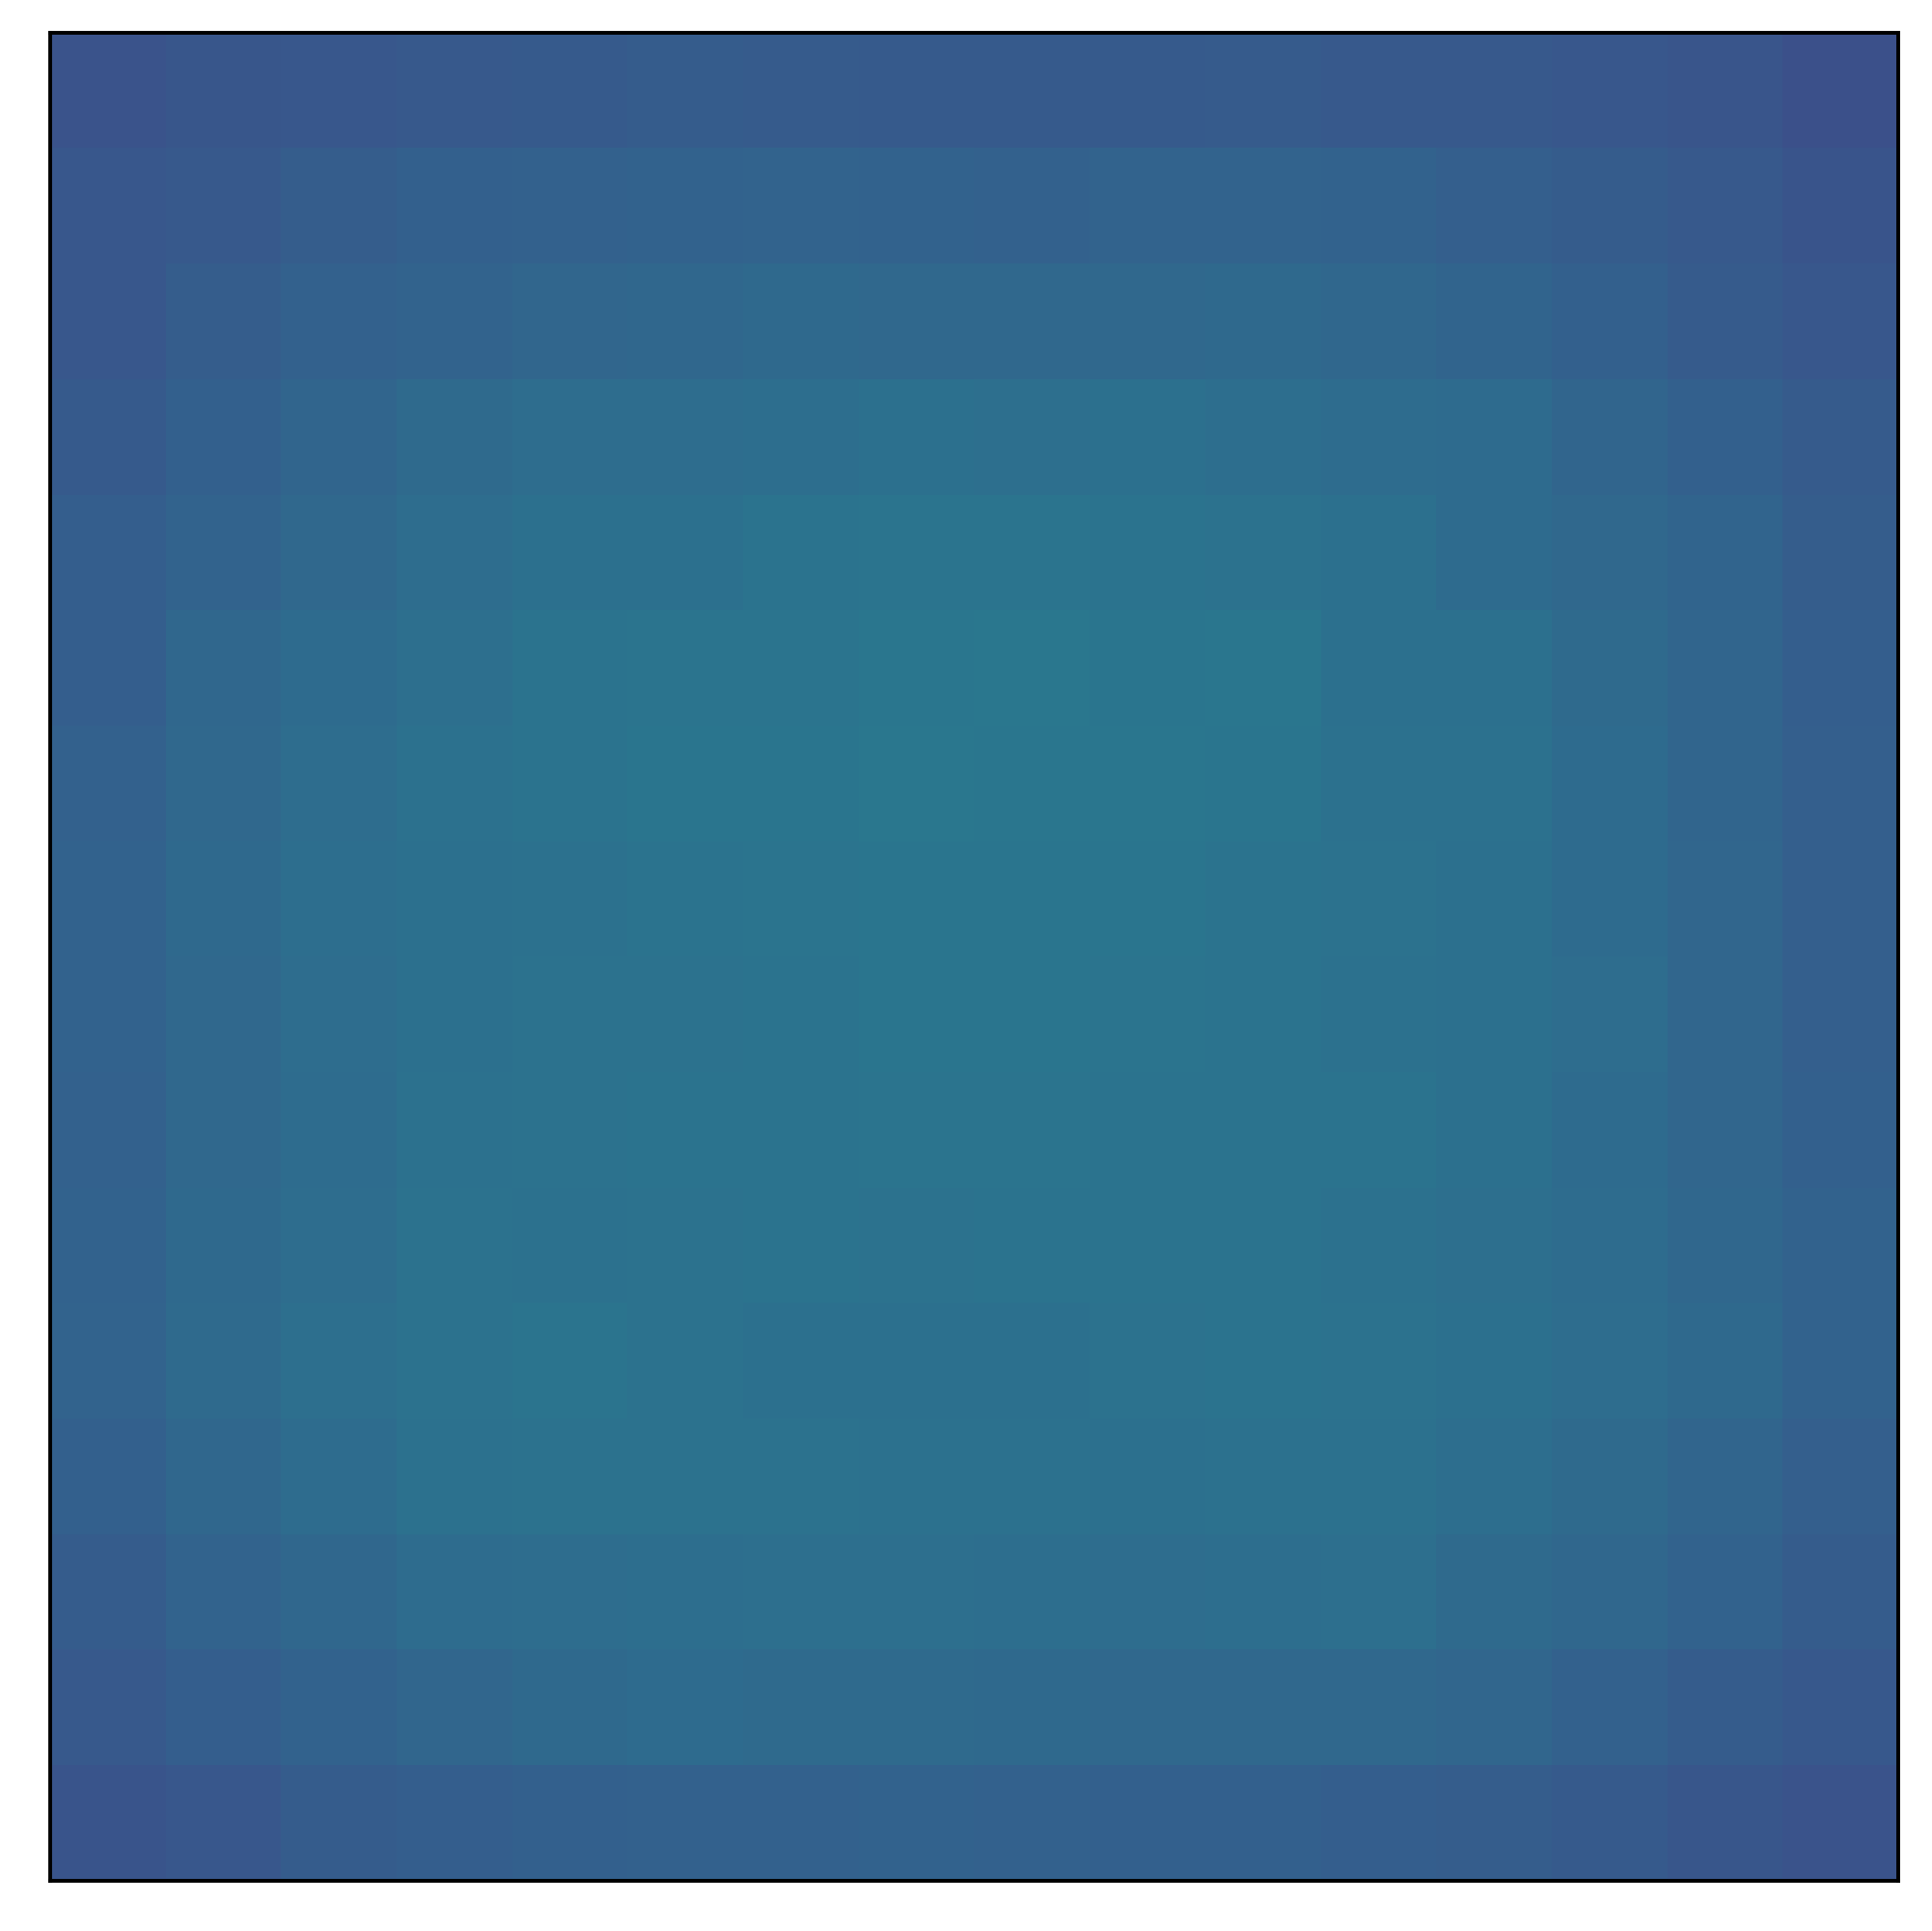

features-10


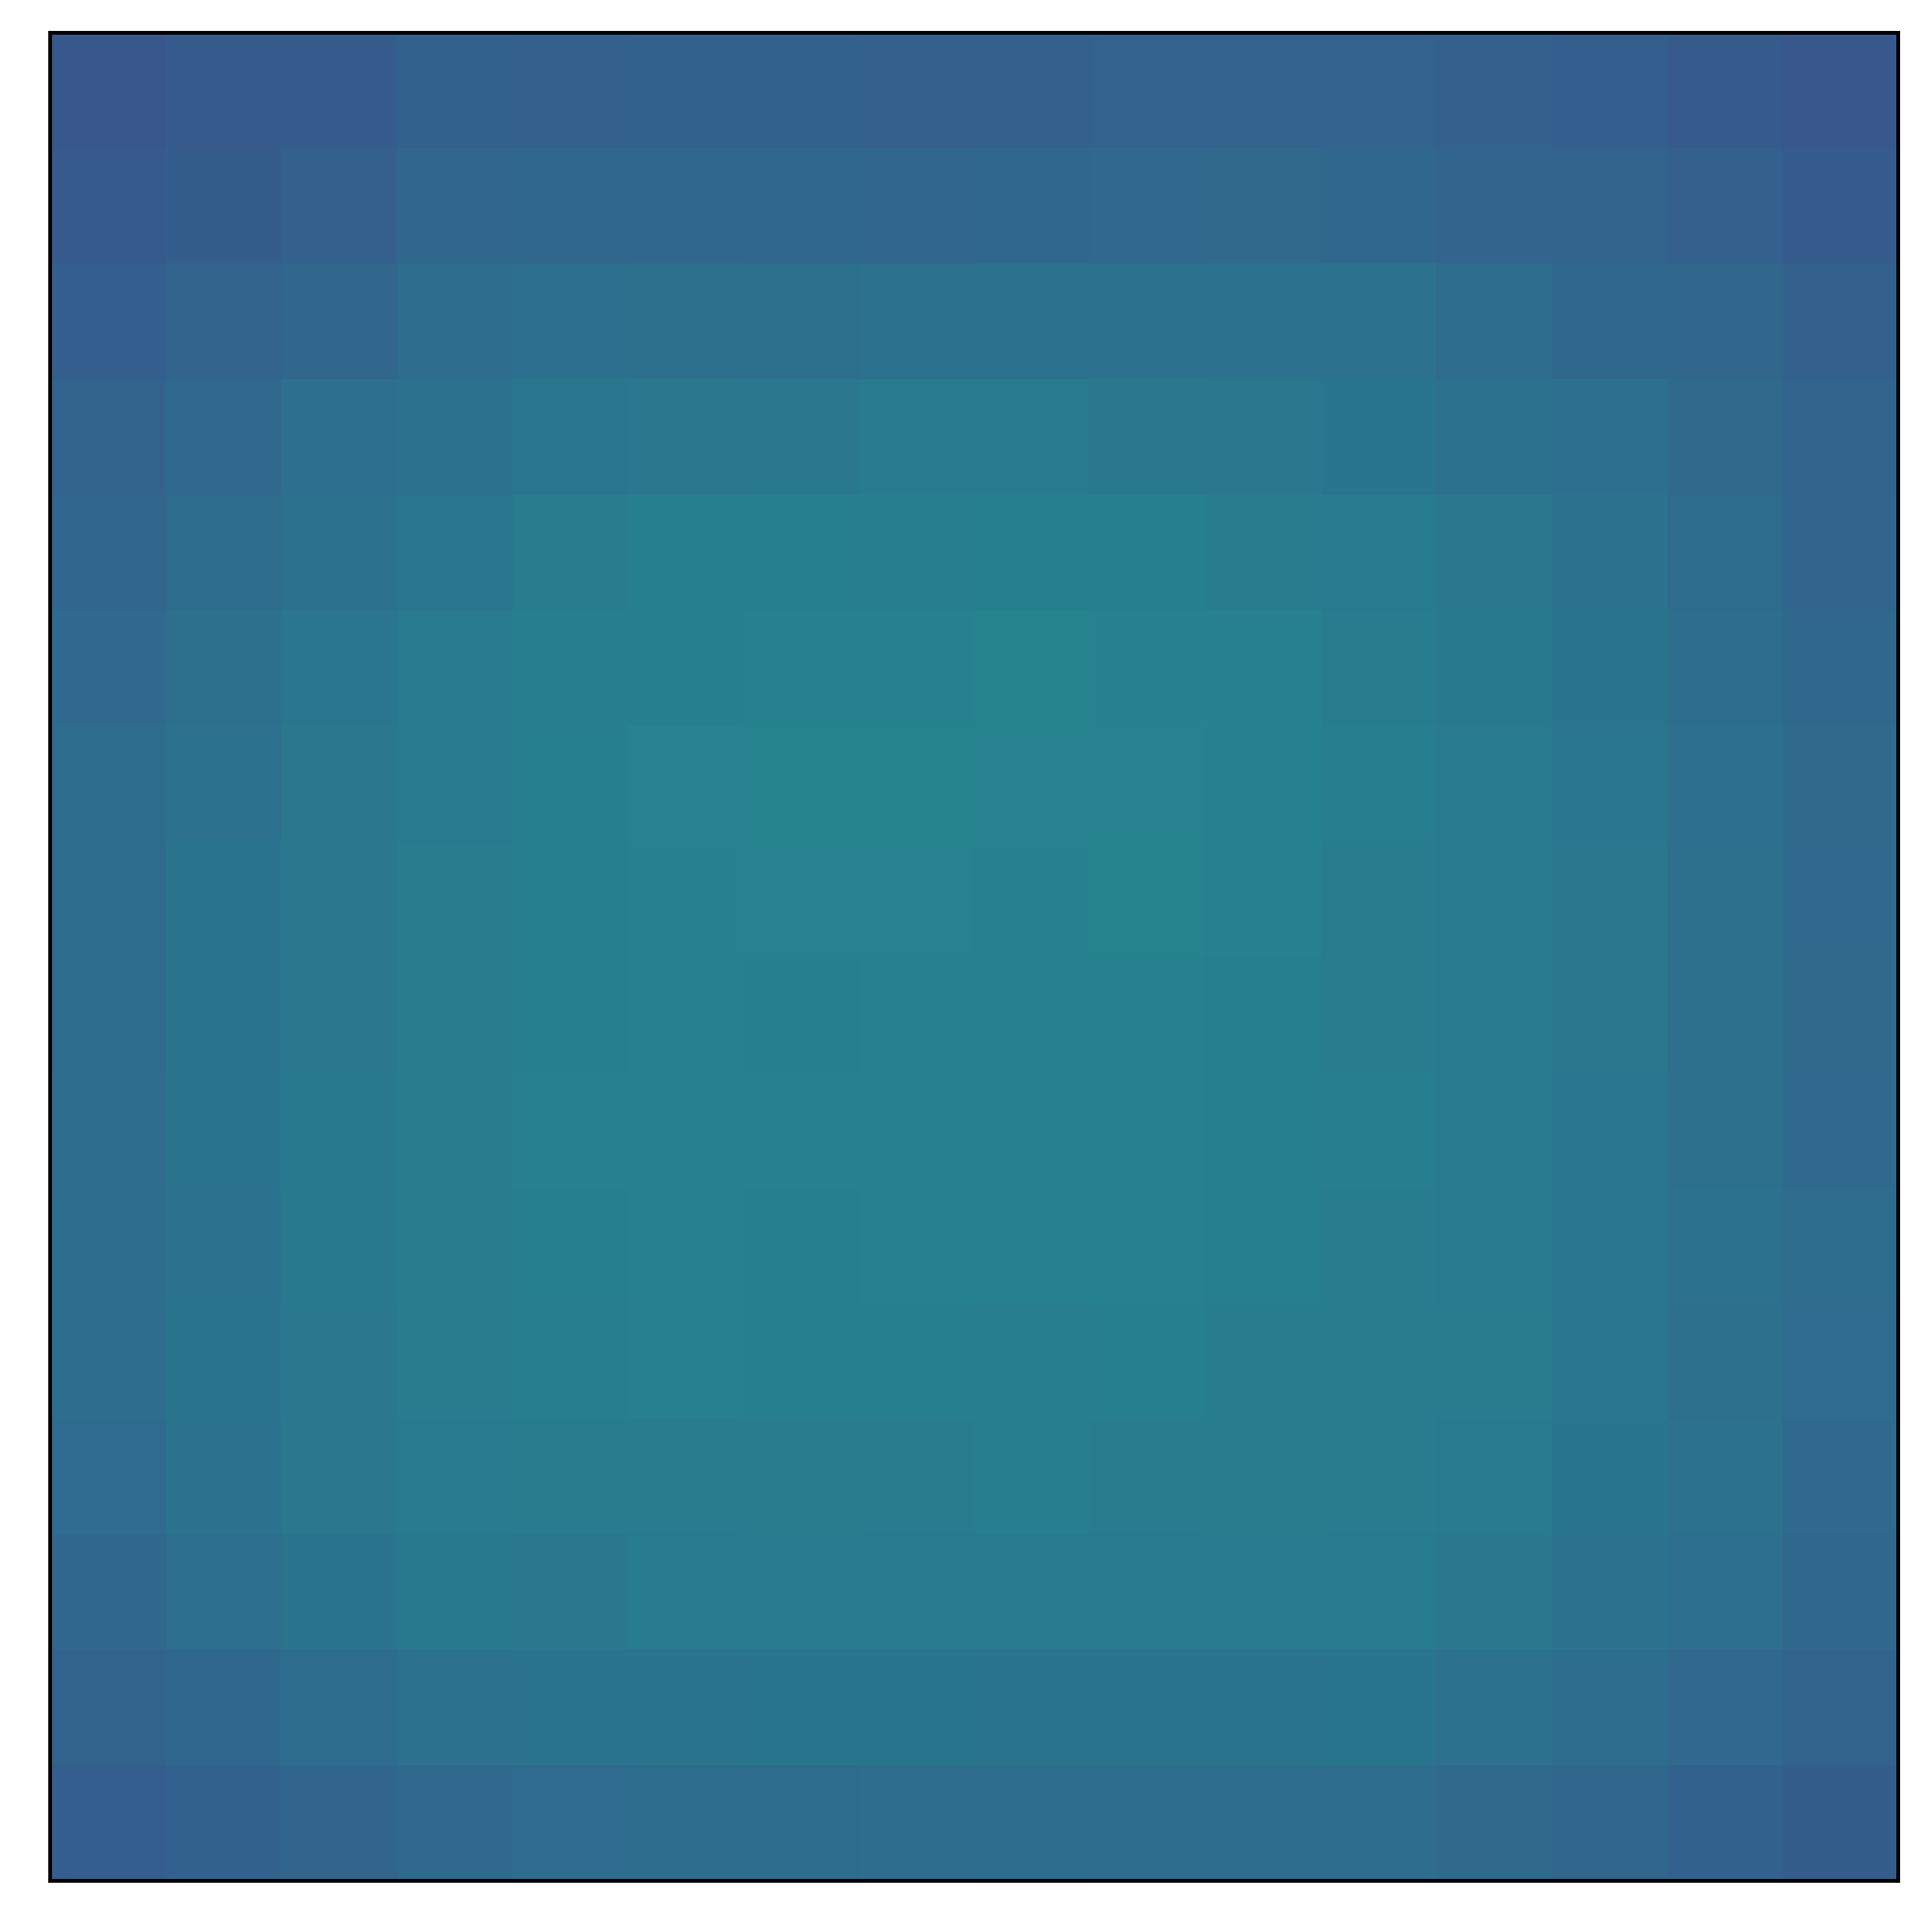

features-14


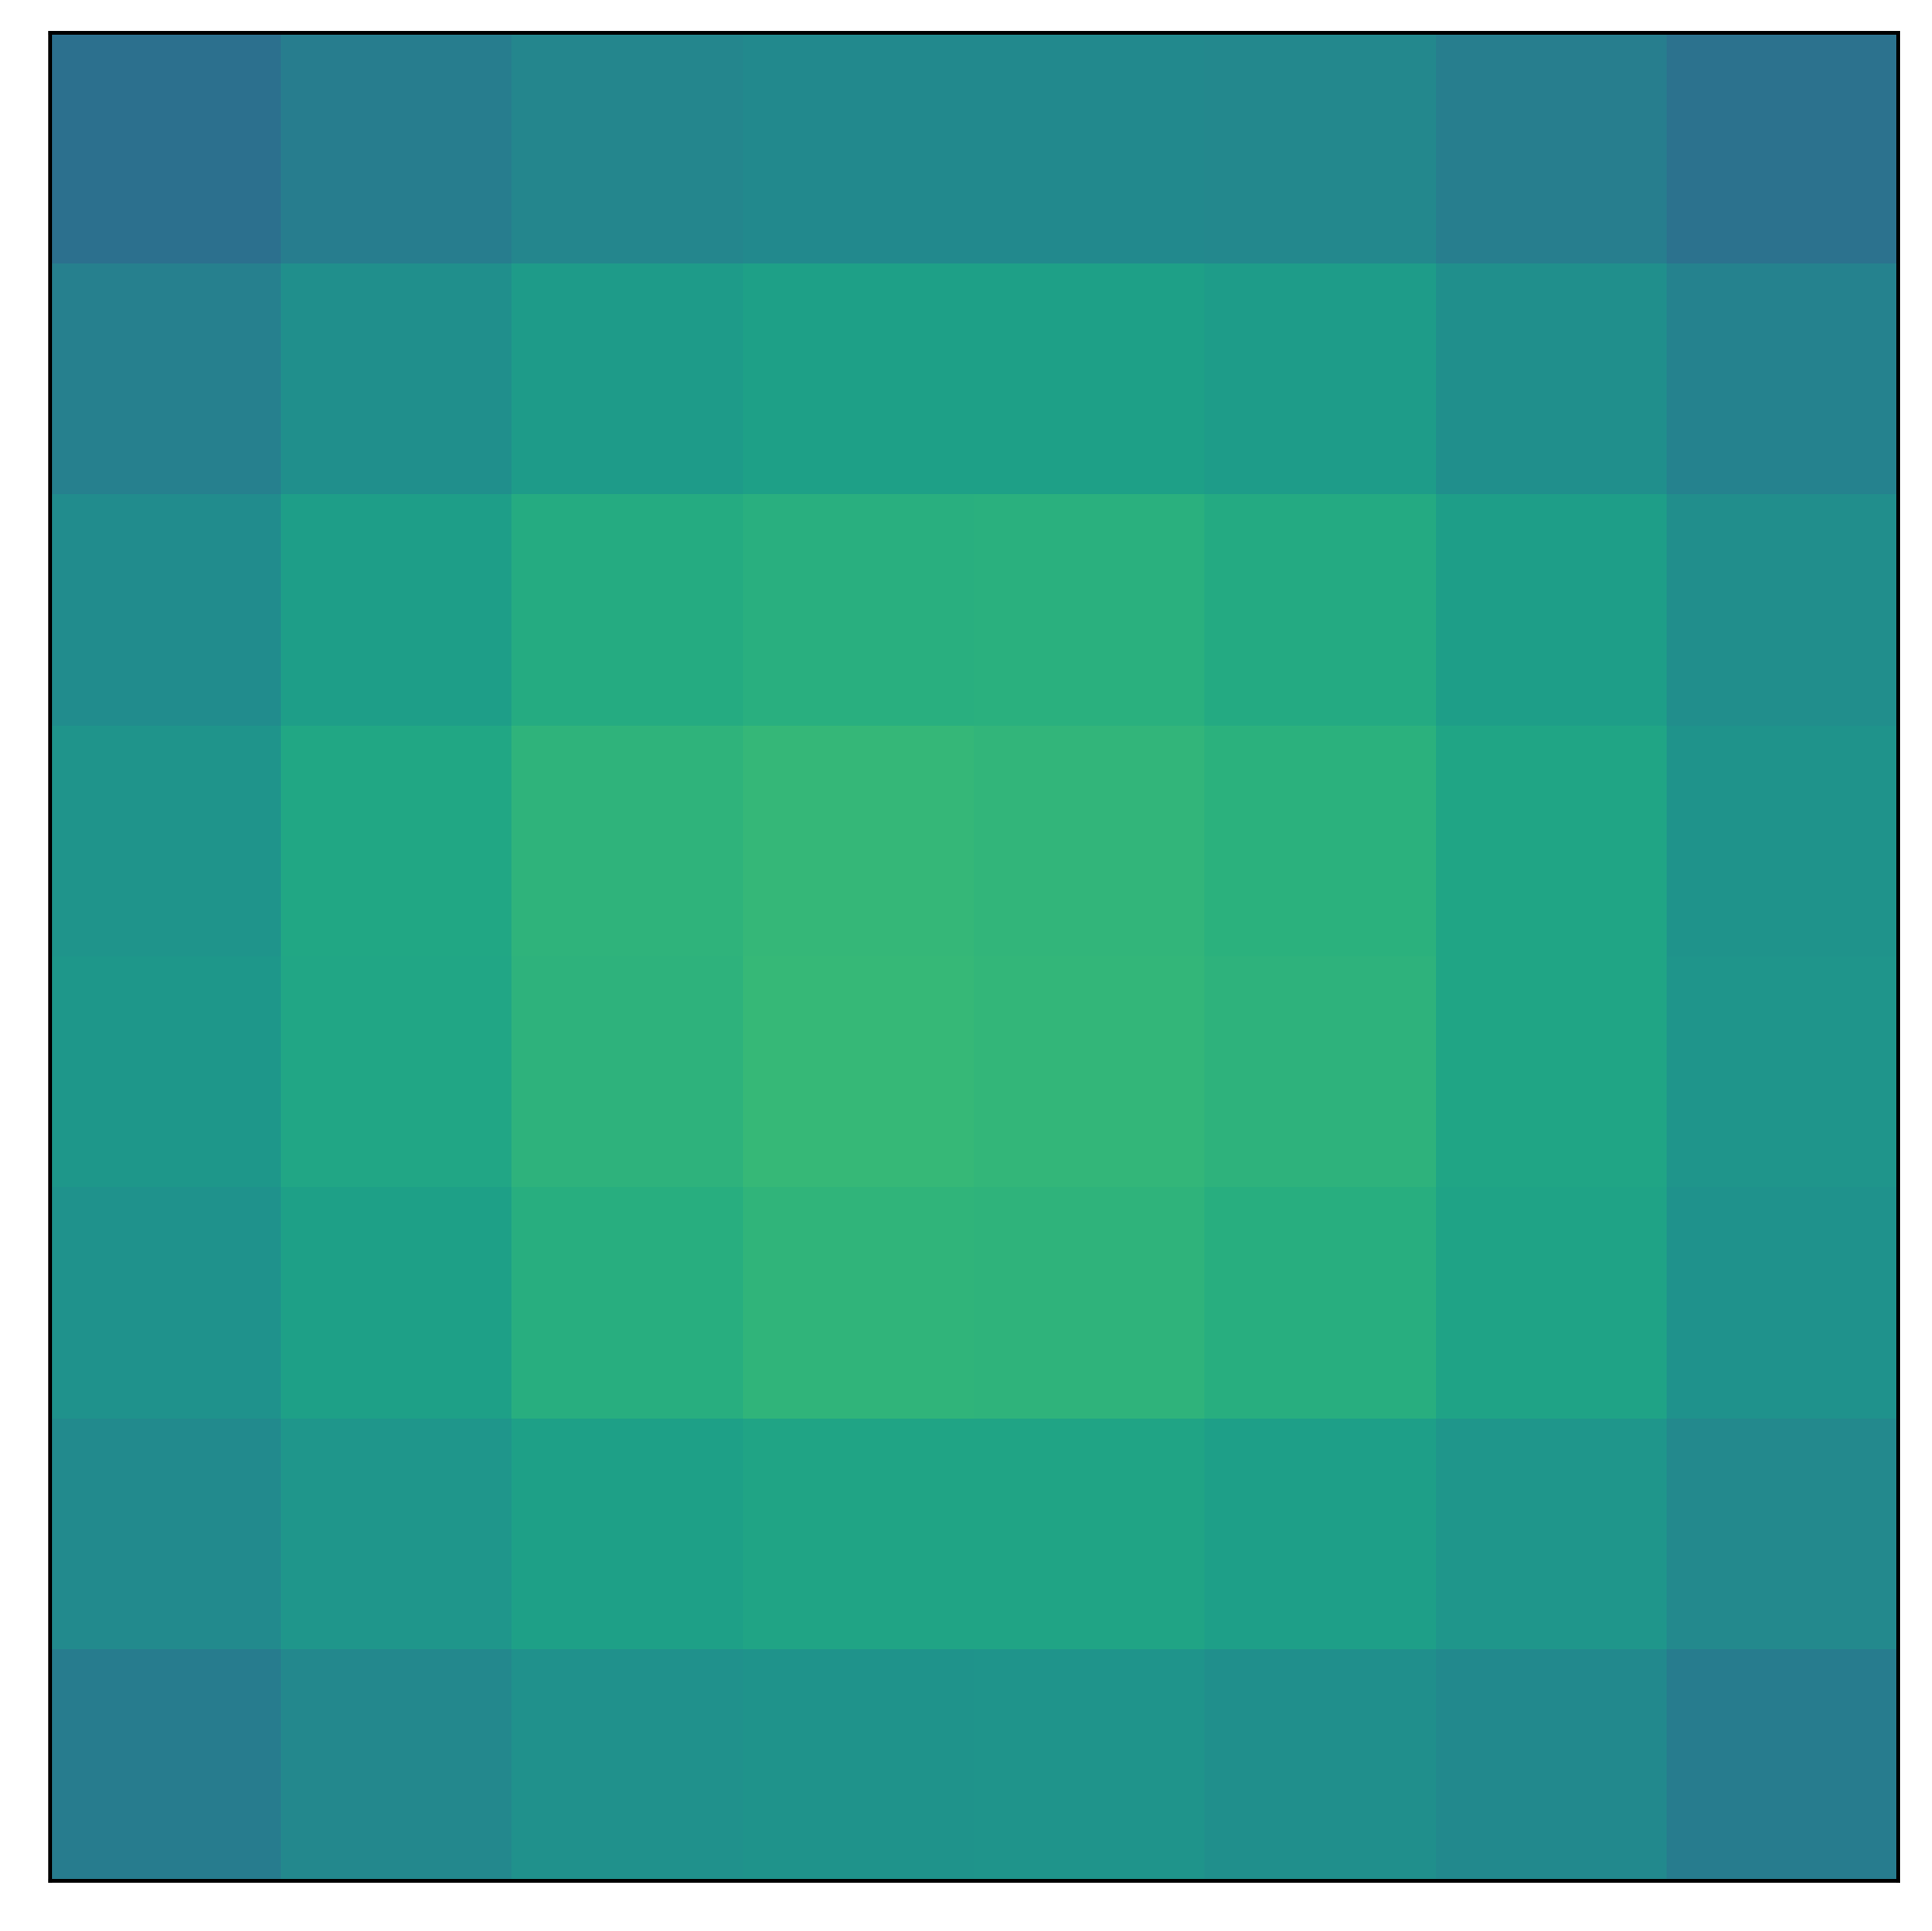

features-17


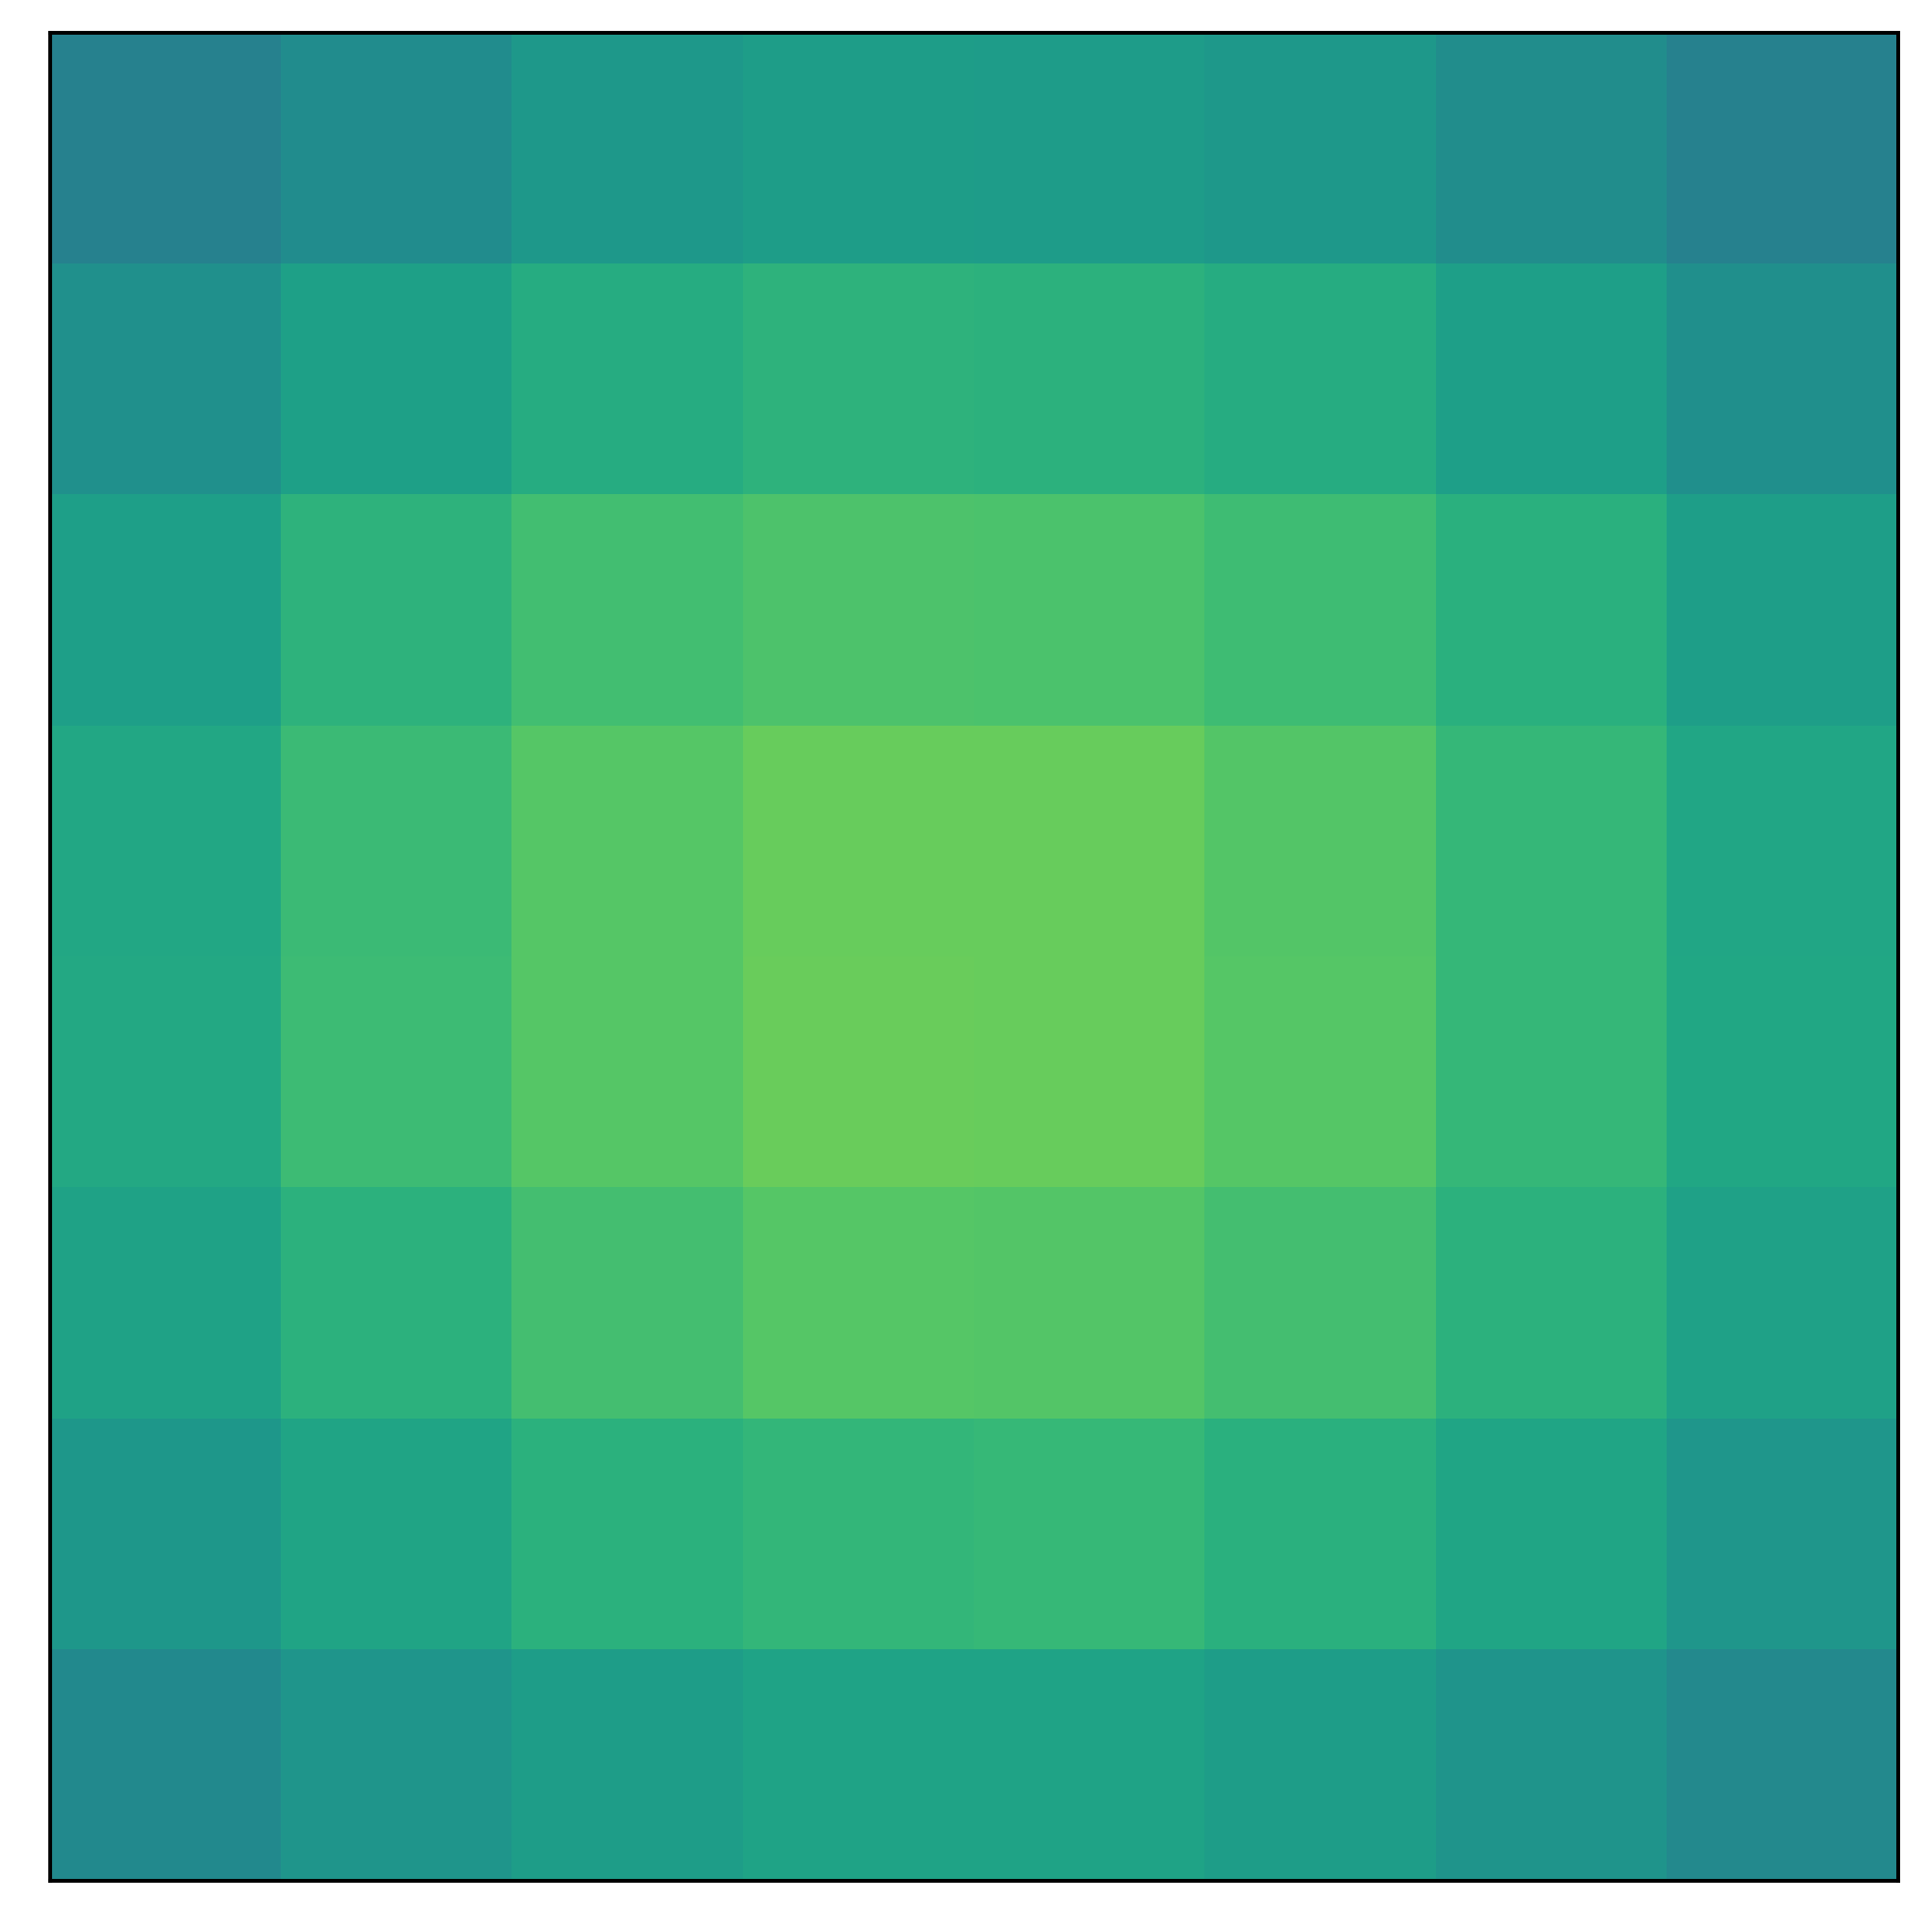

features-20


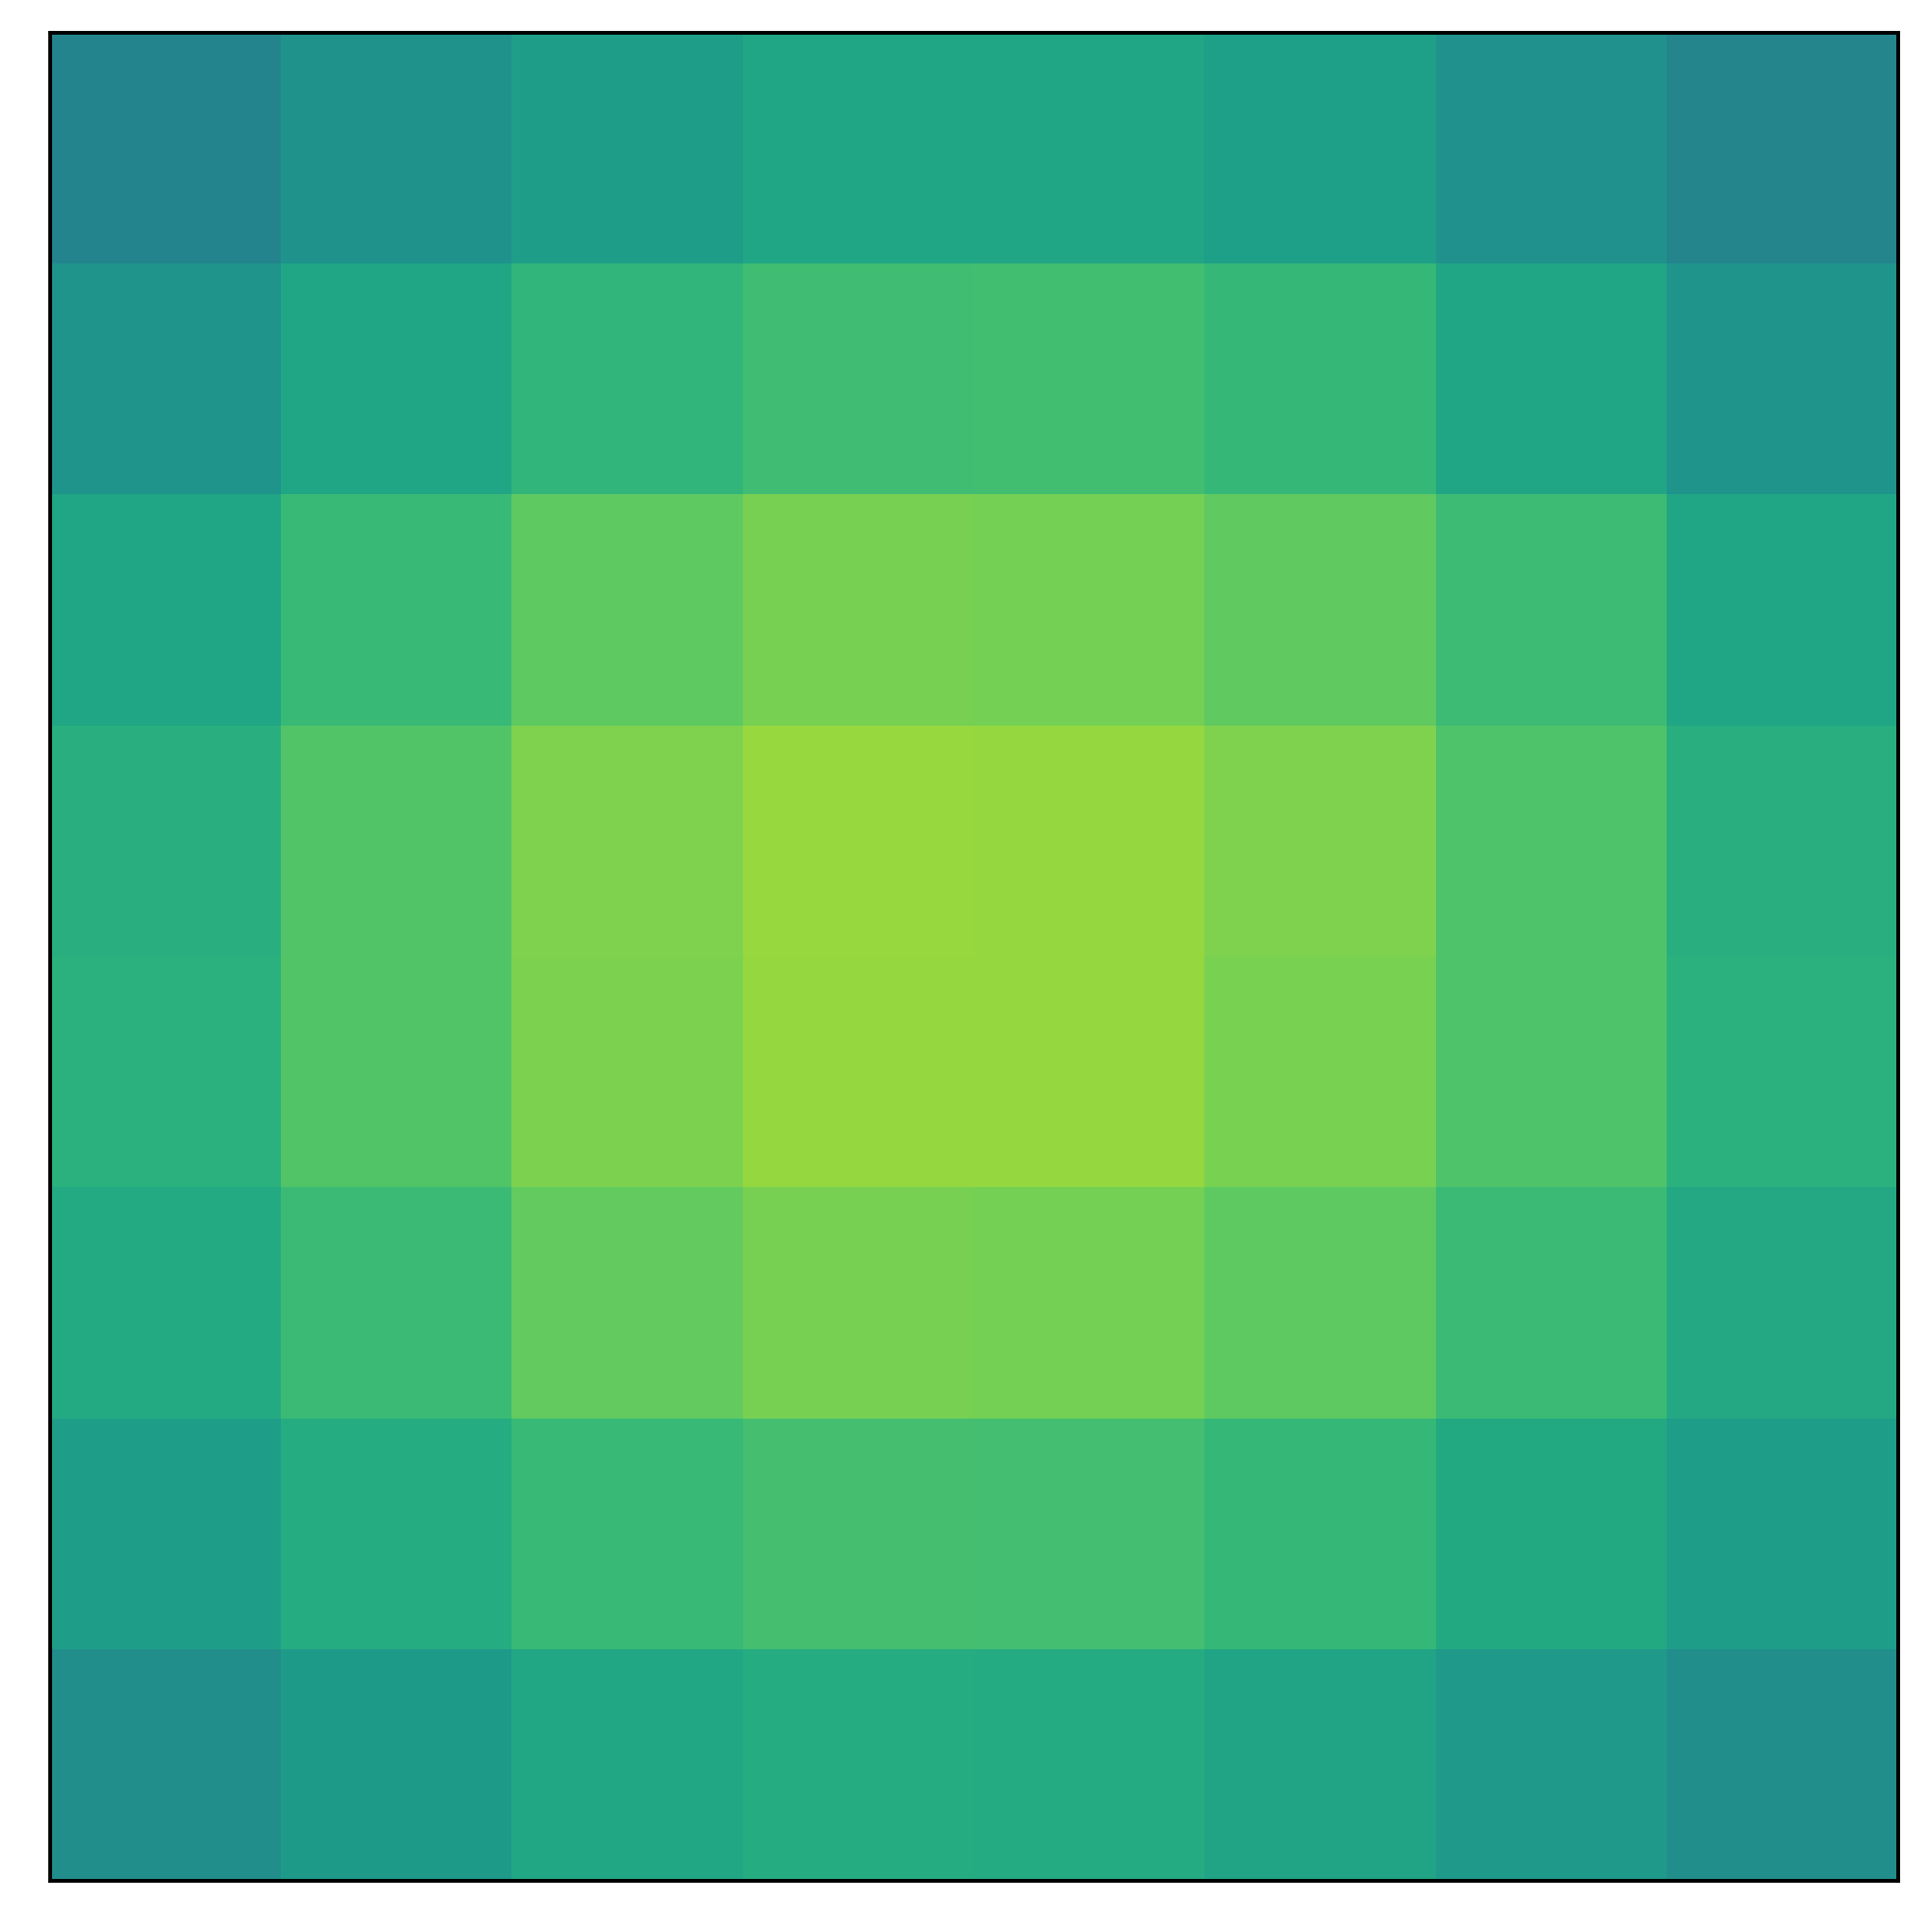

features-24


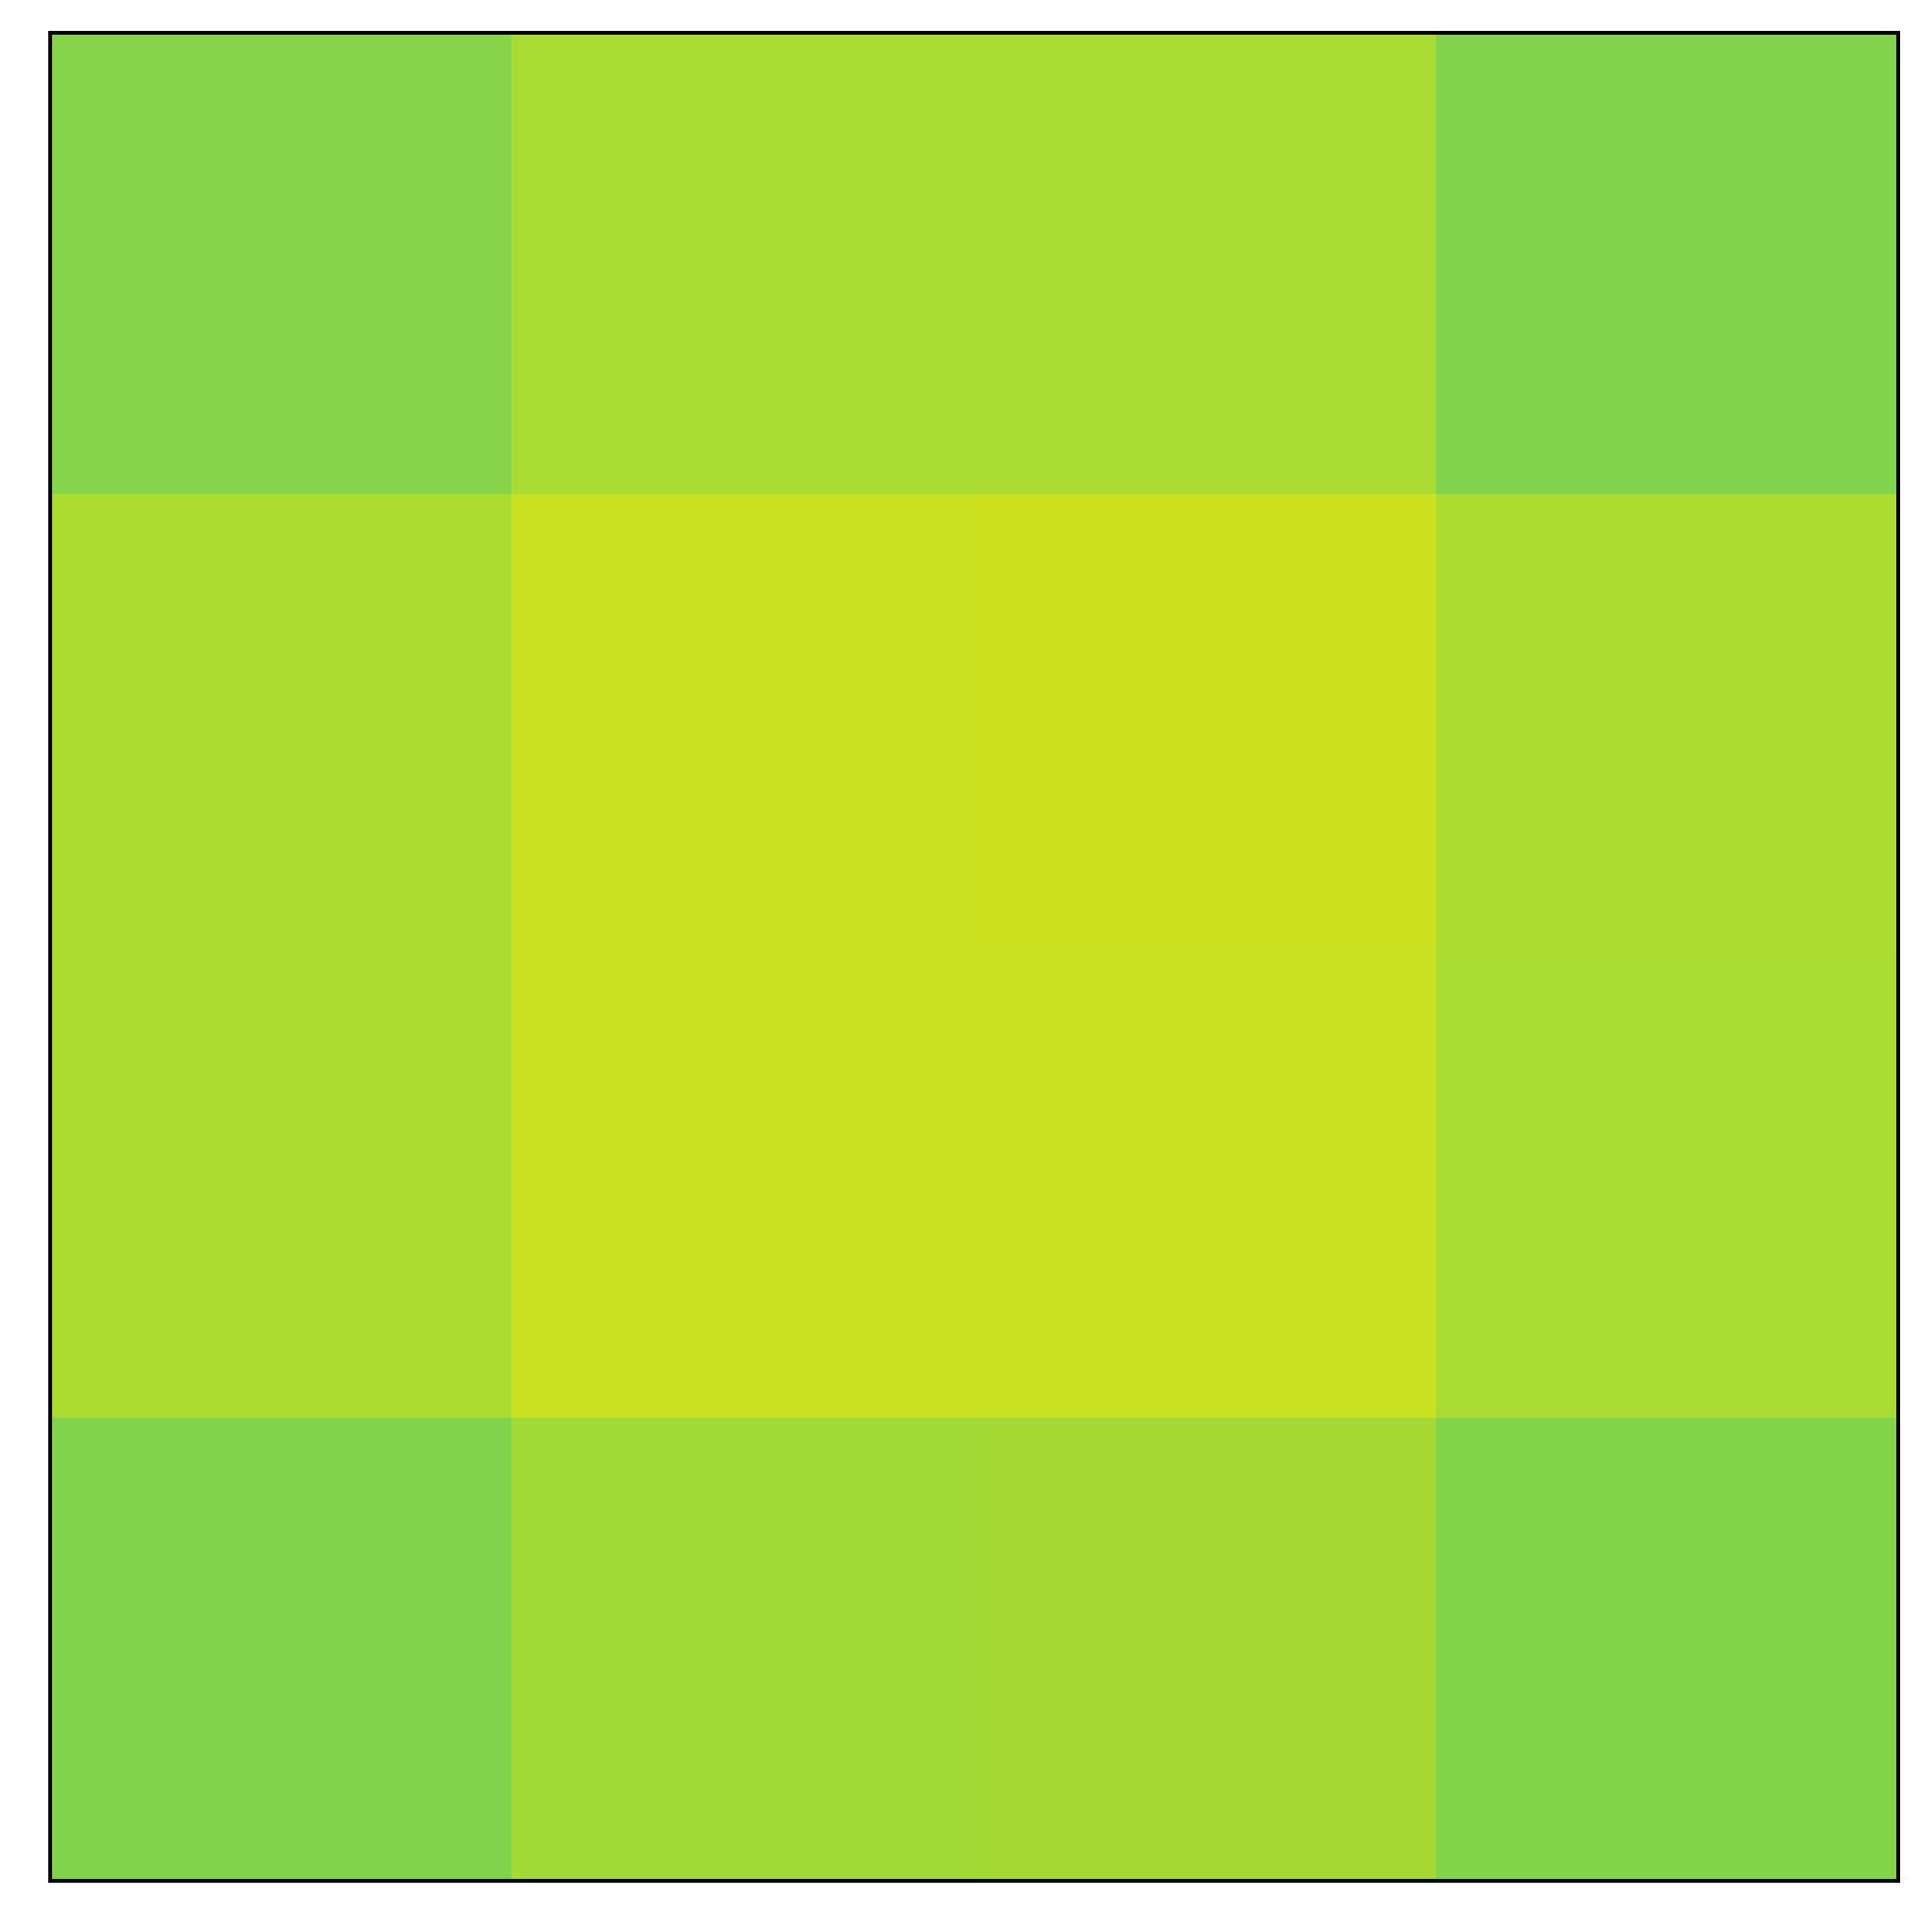

features-27


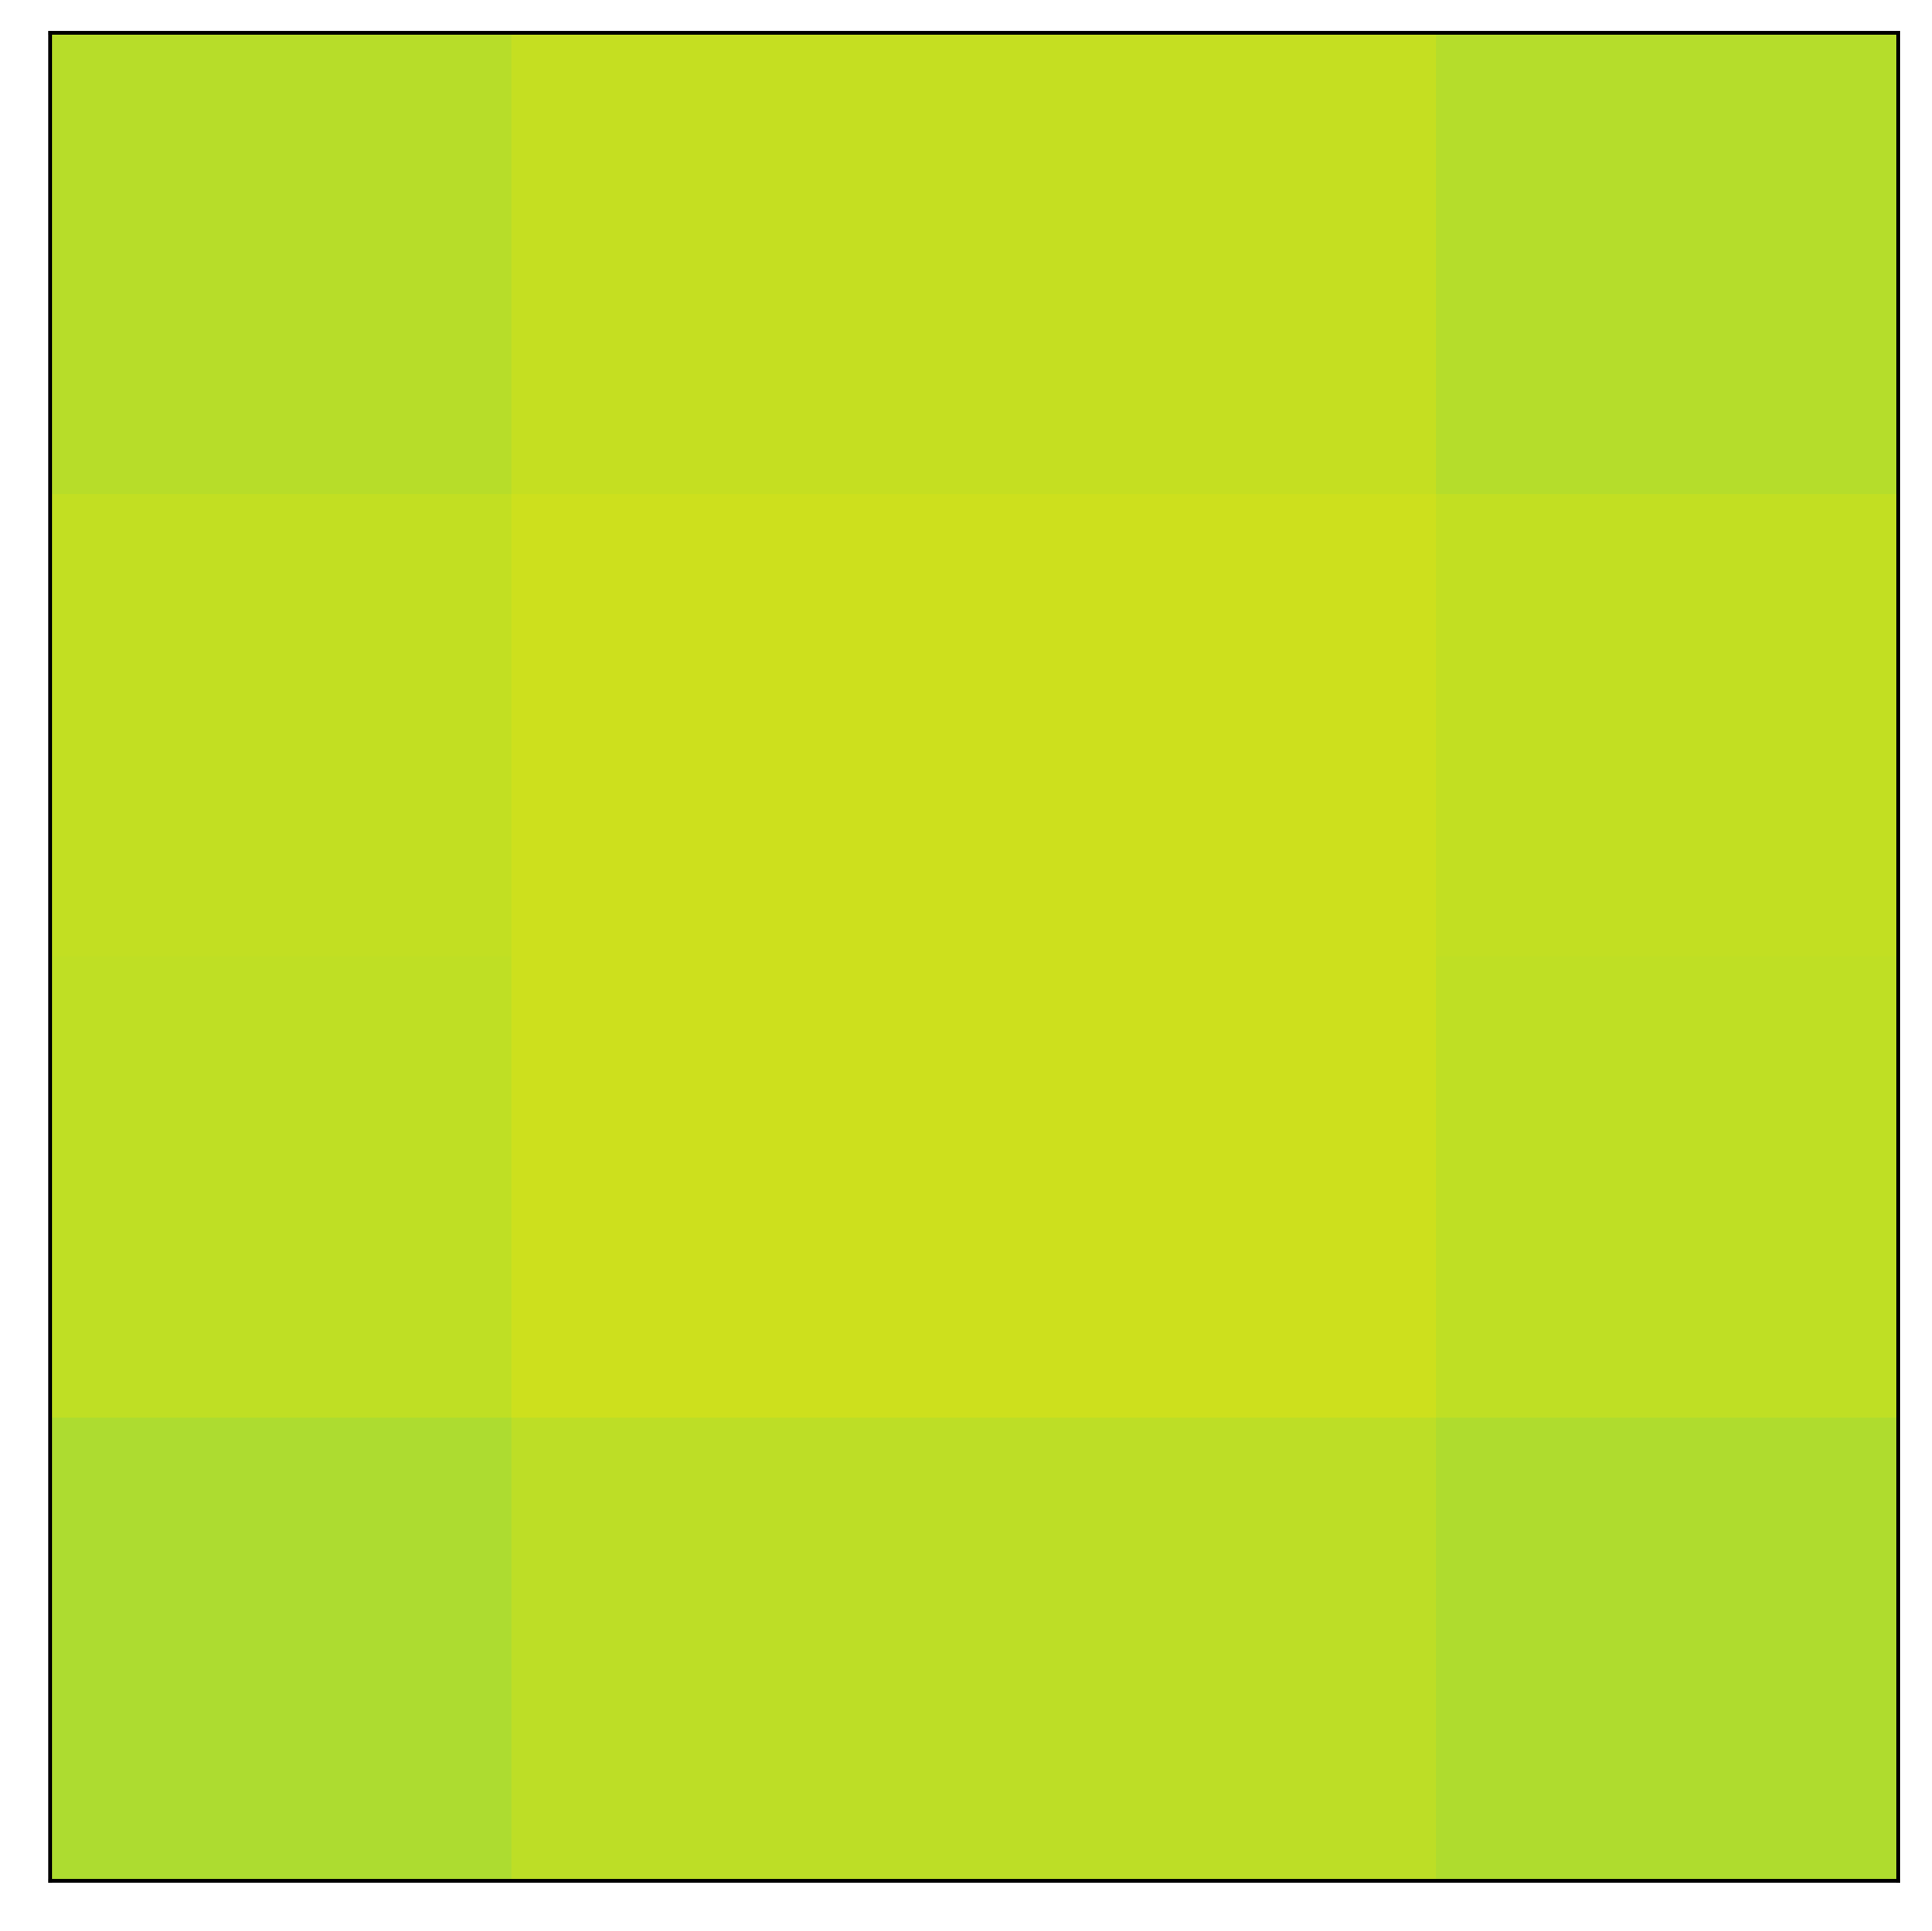

features-30


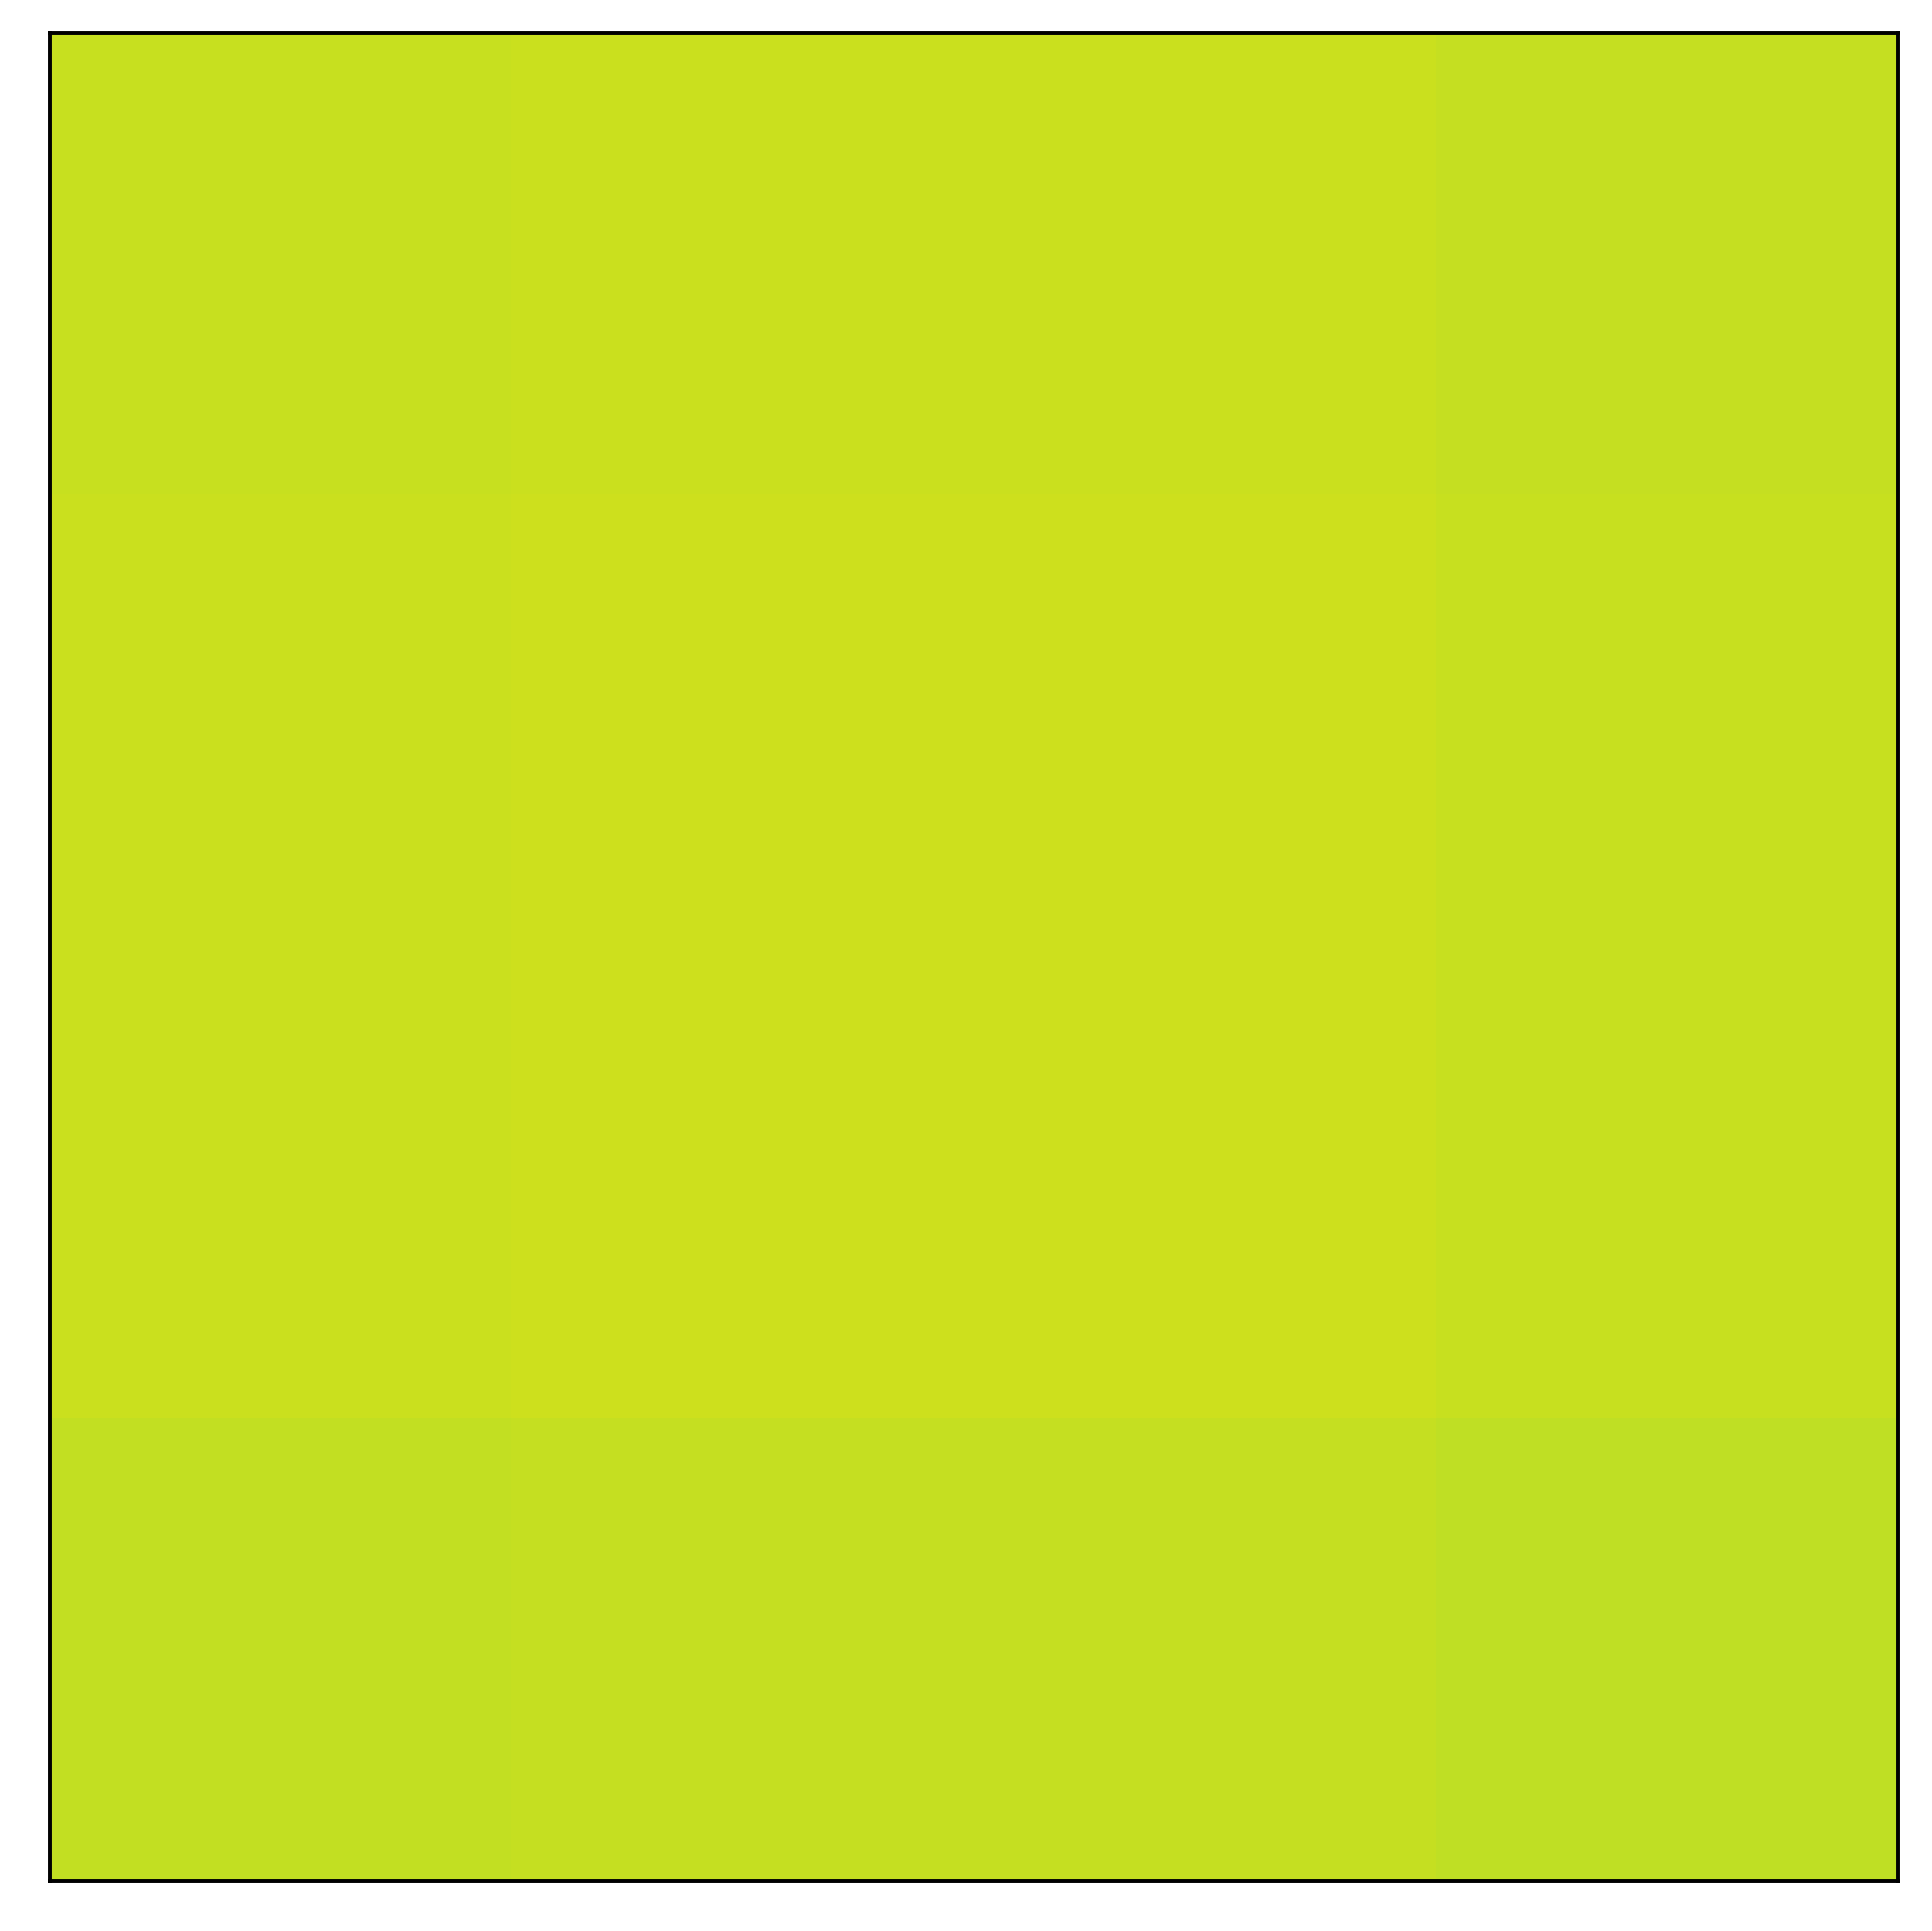

features-34


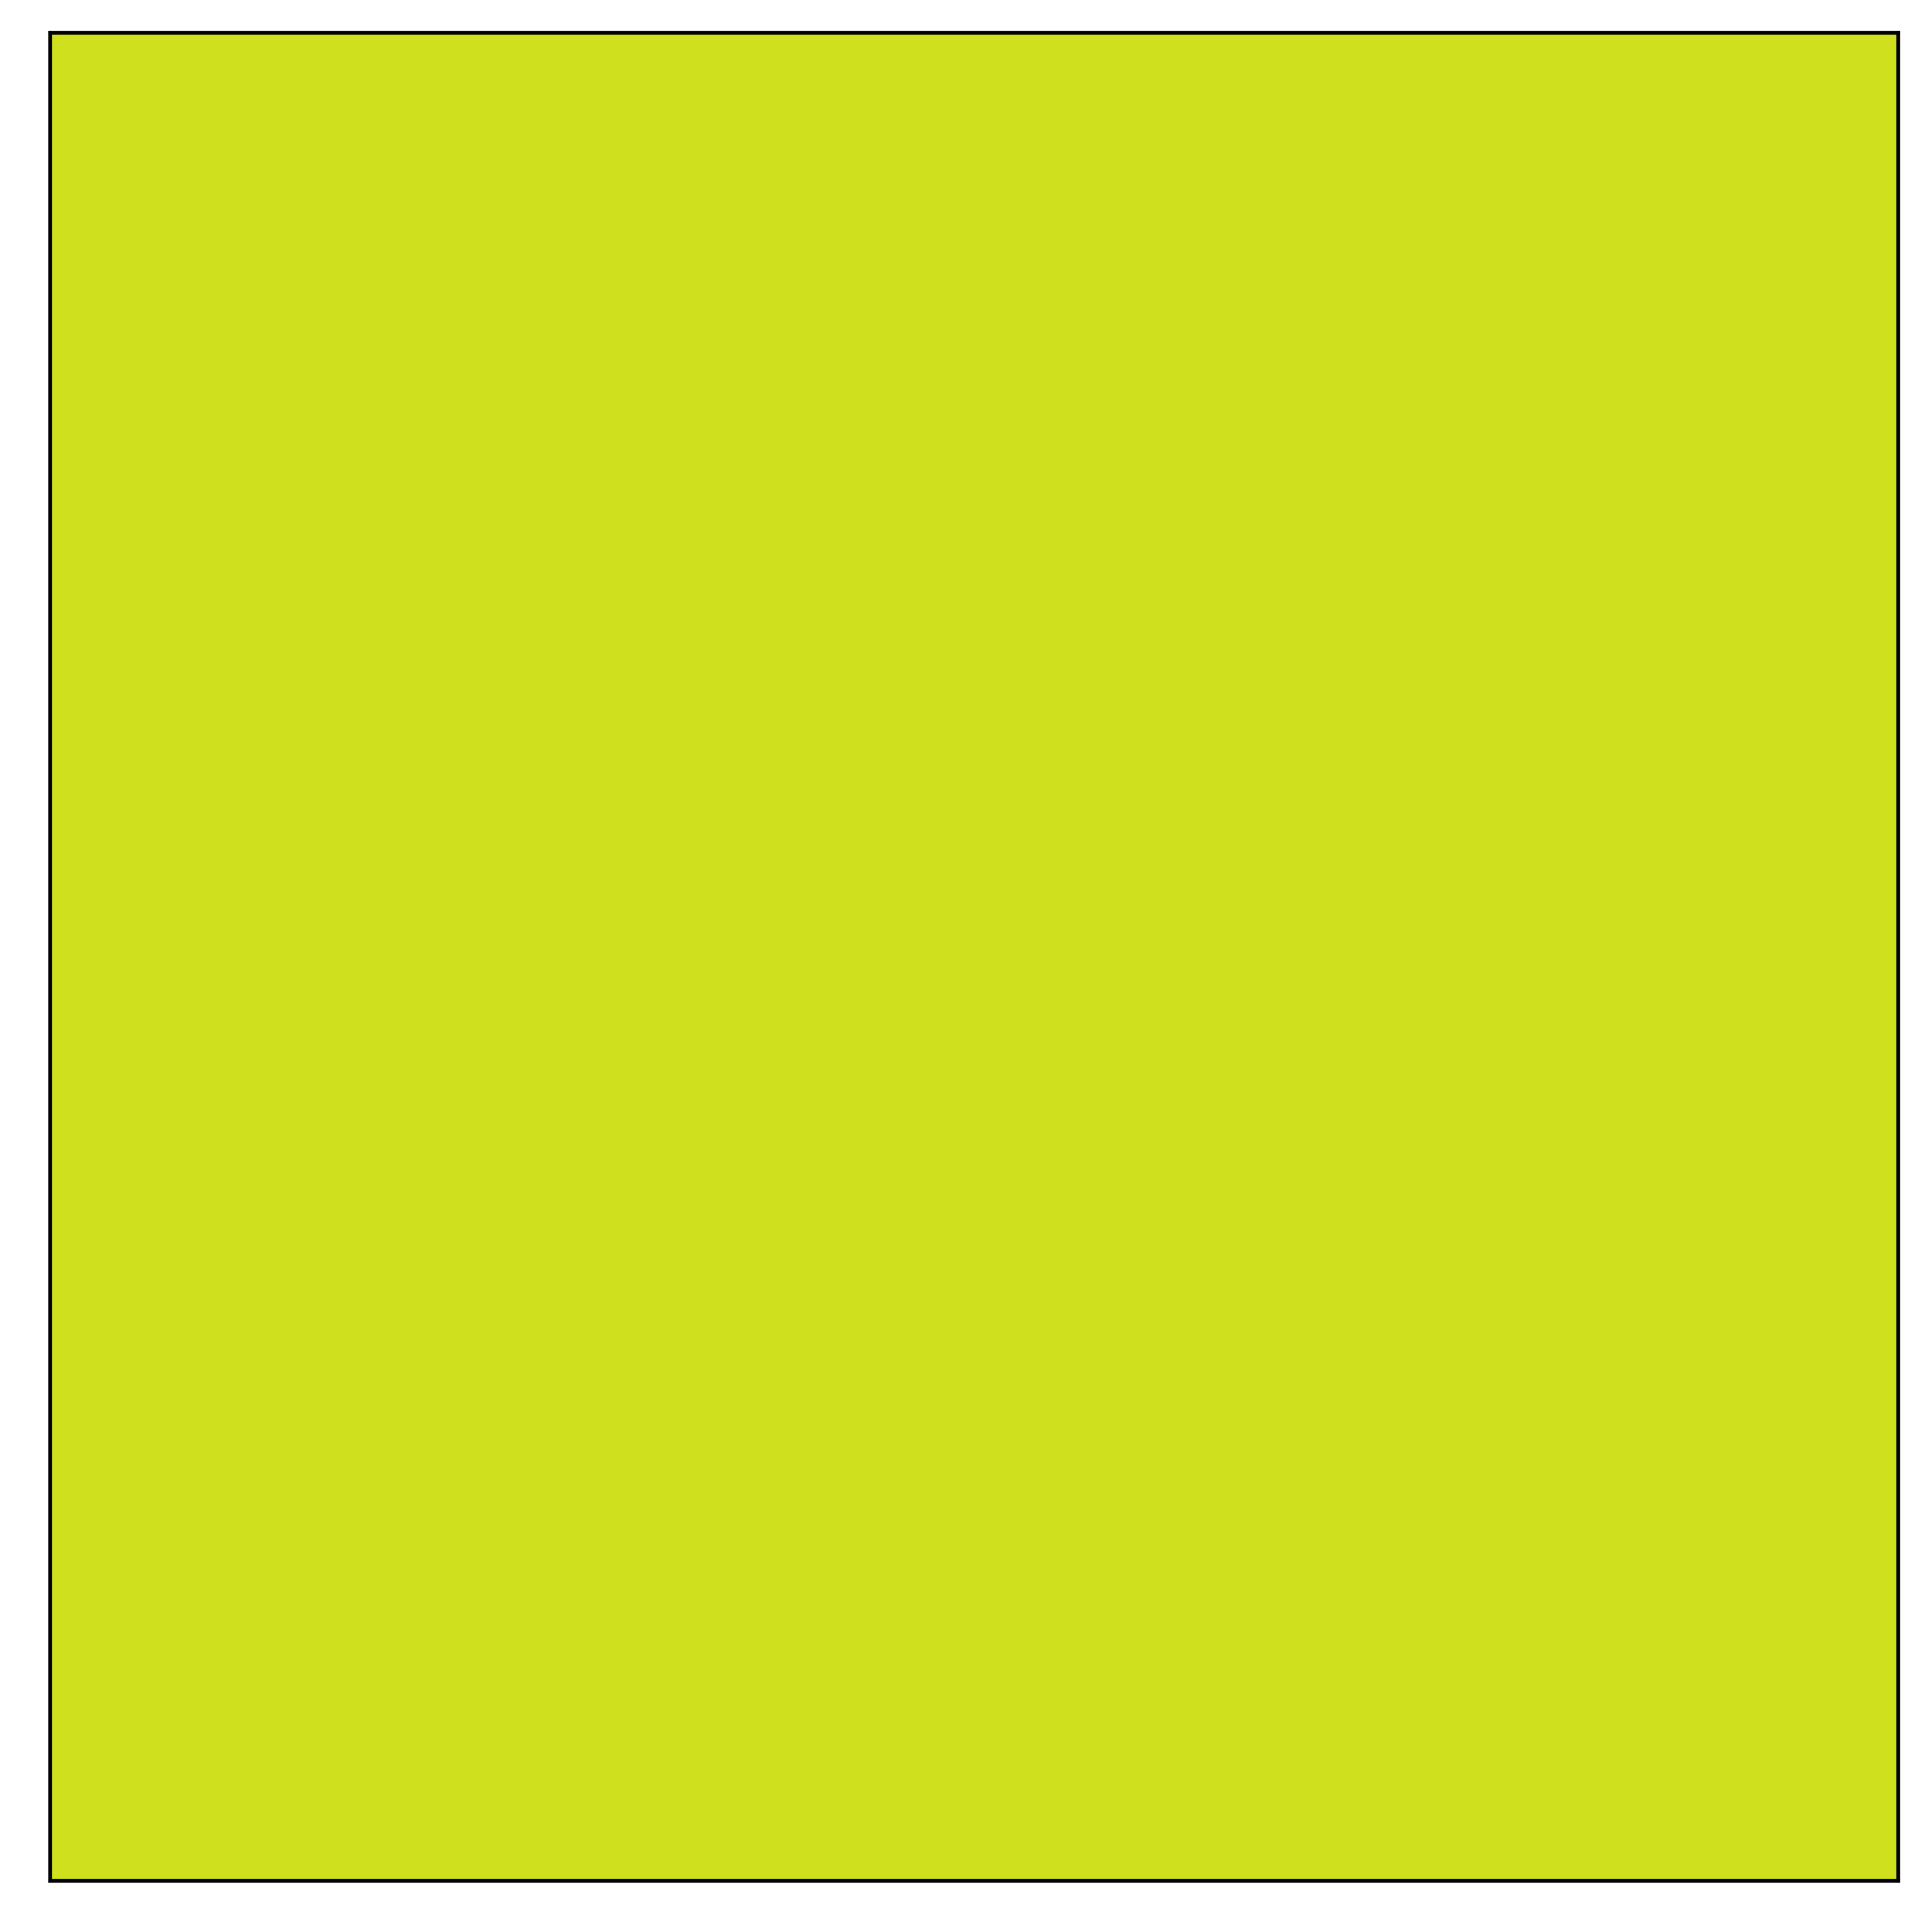

features-37


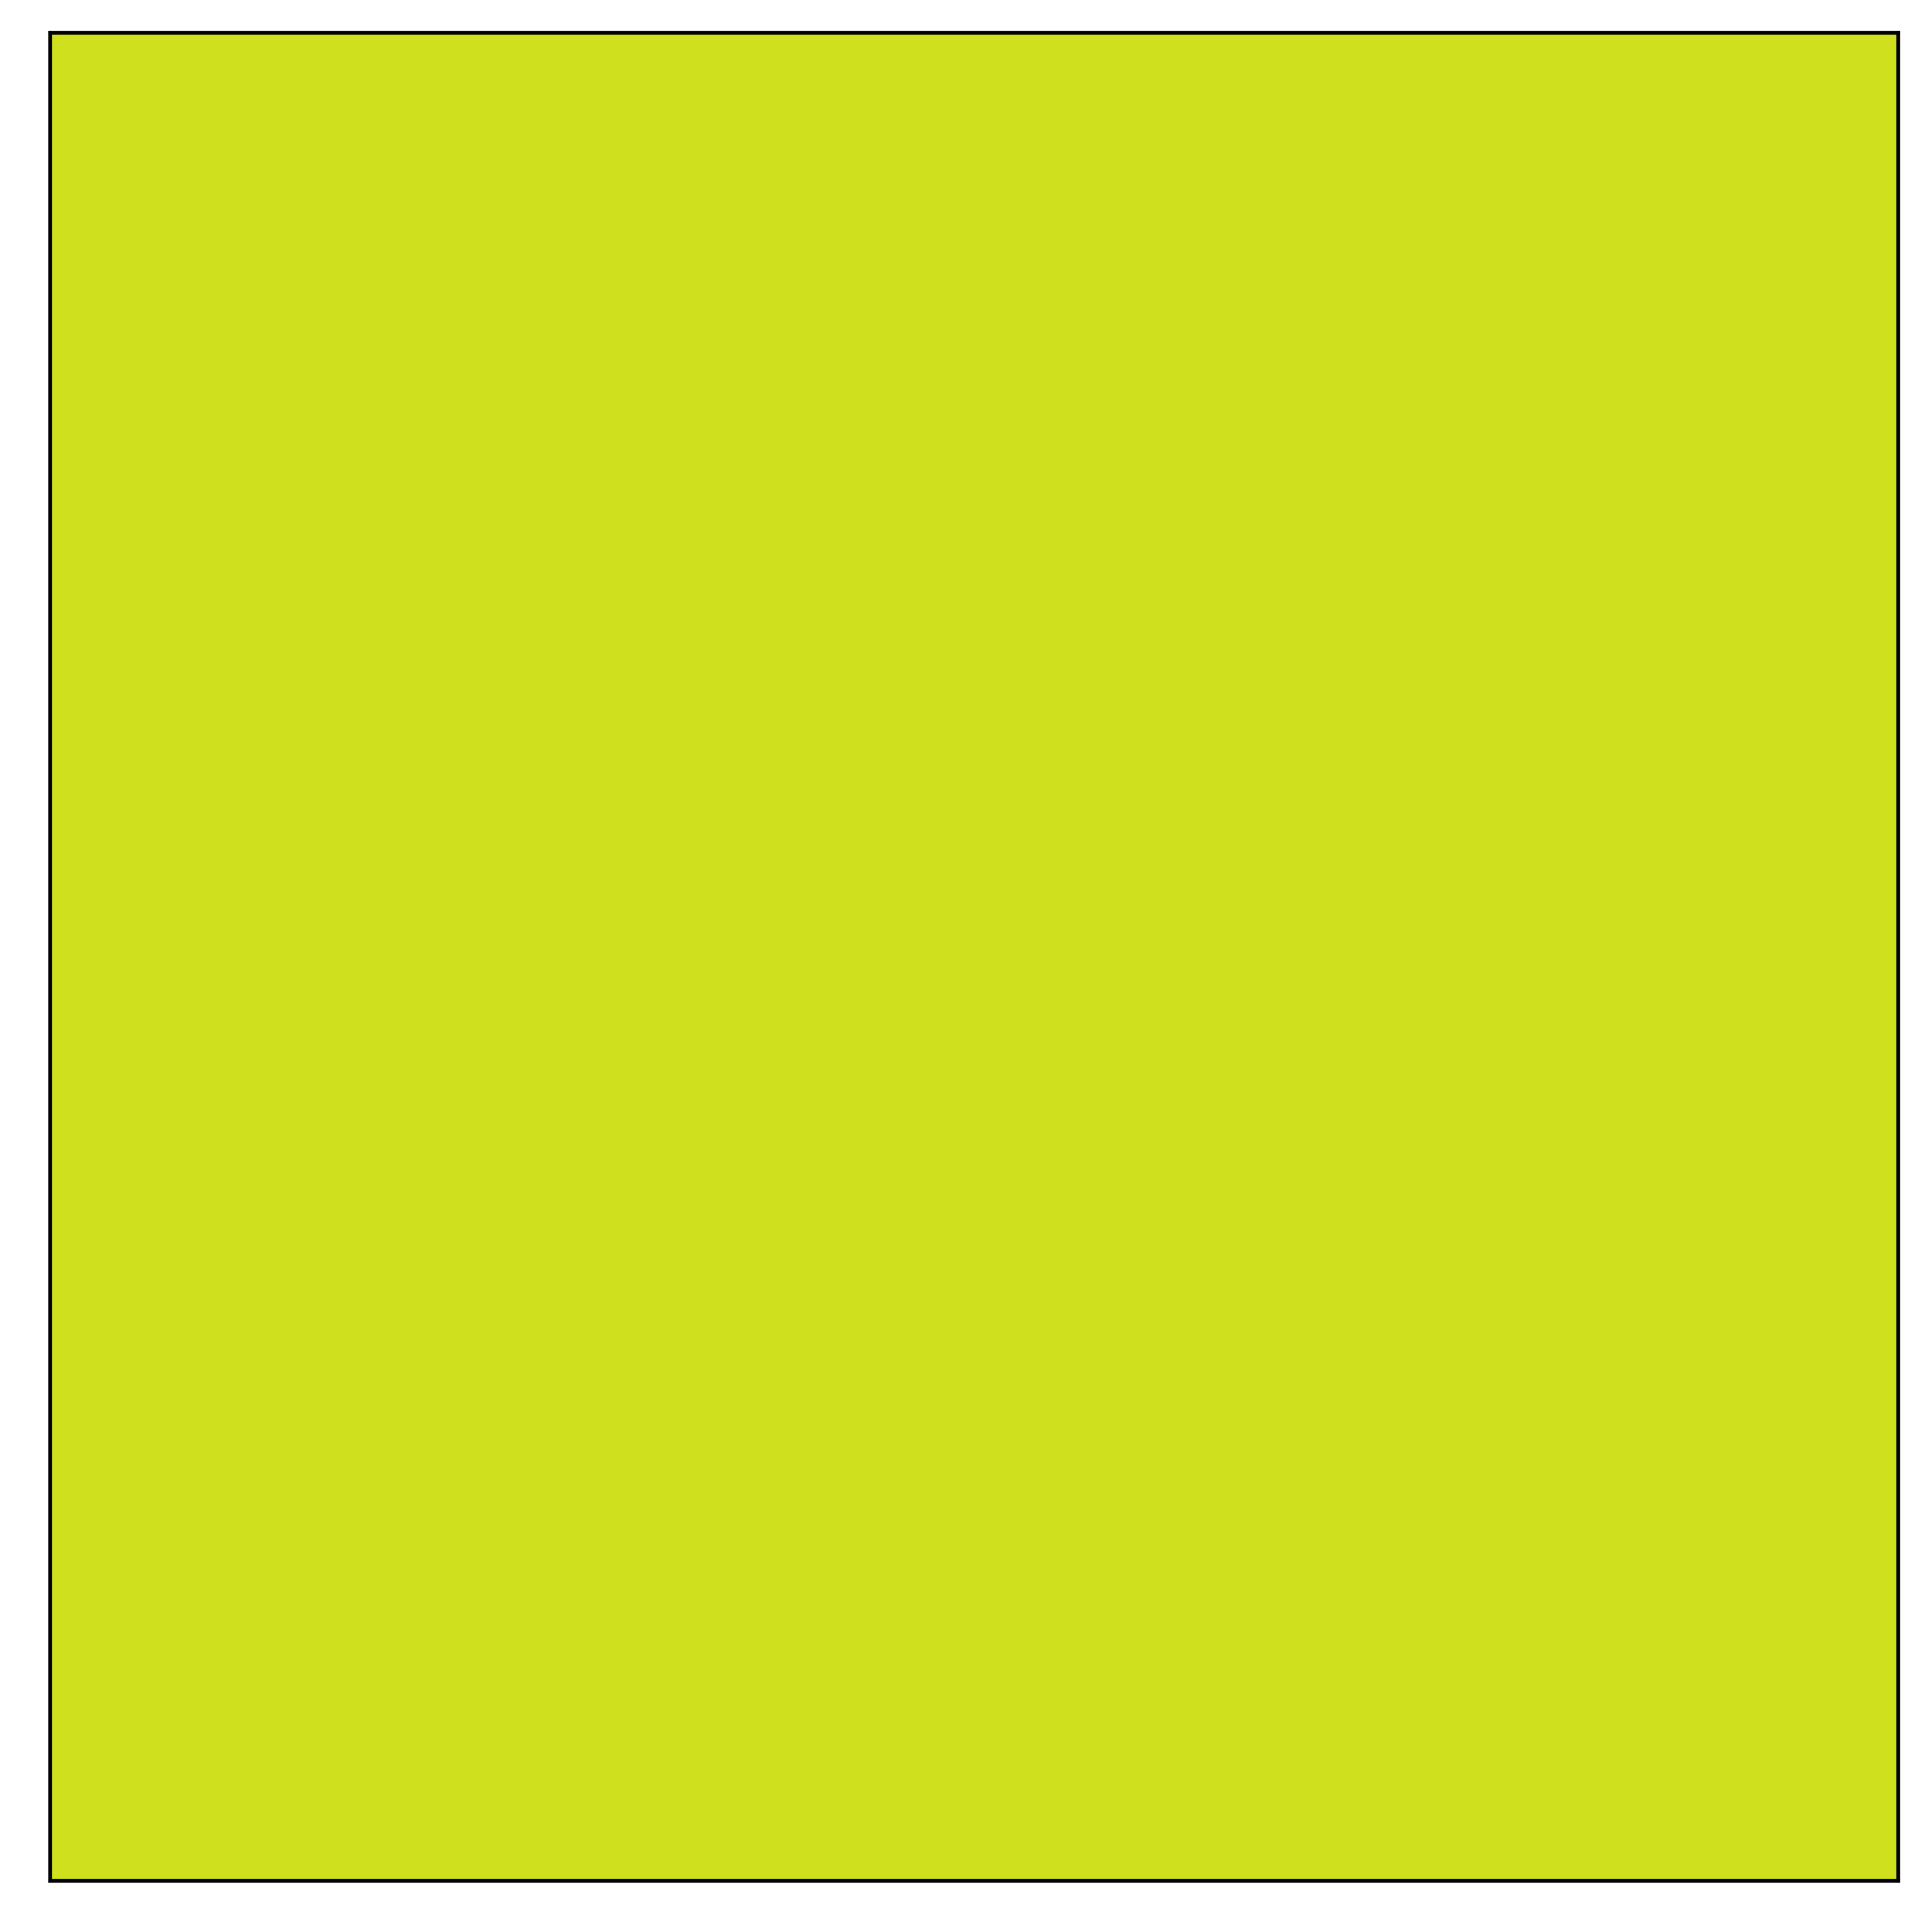

features-40


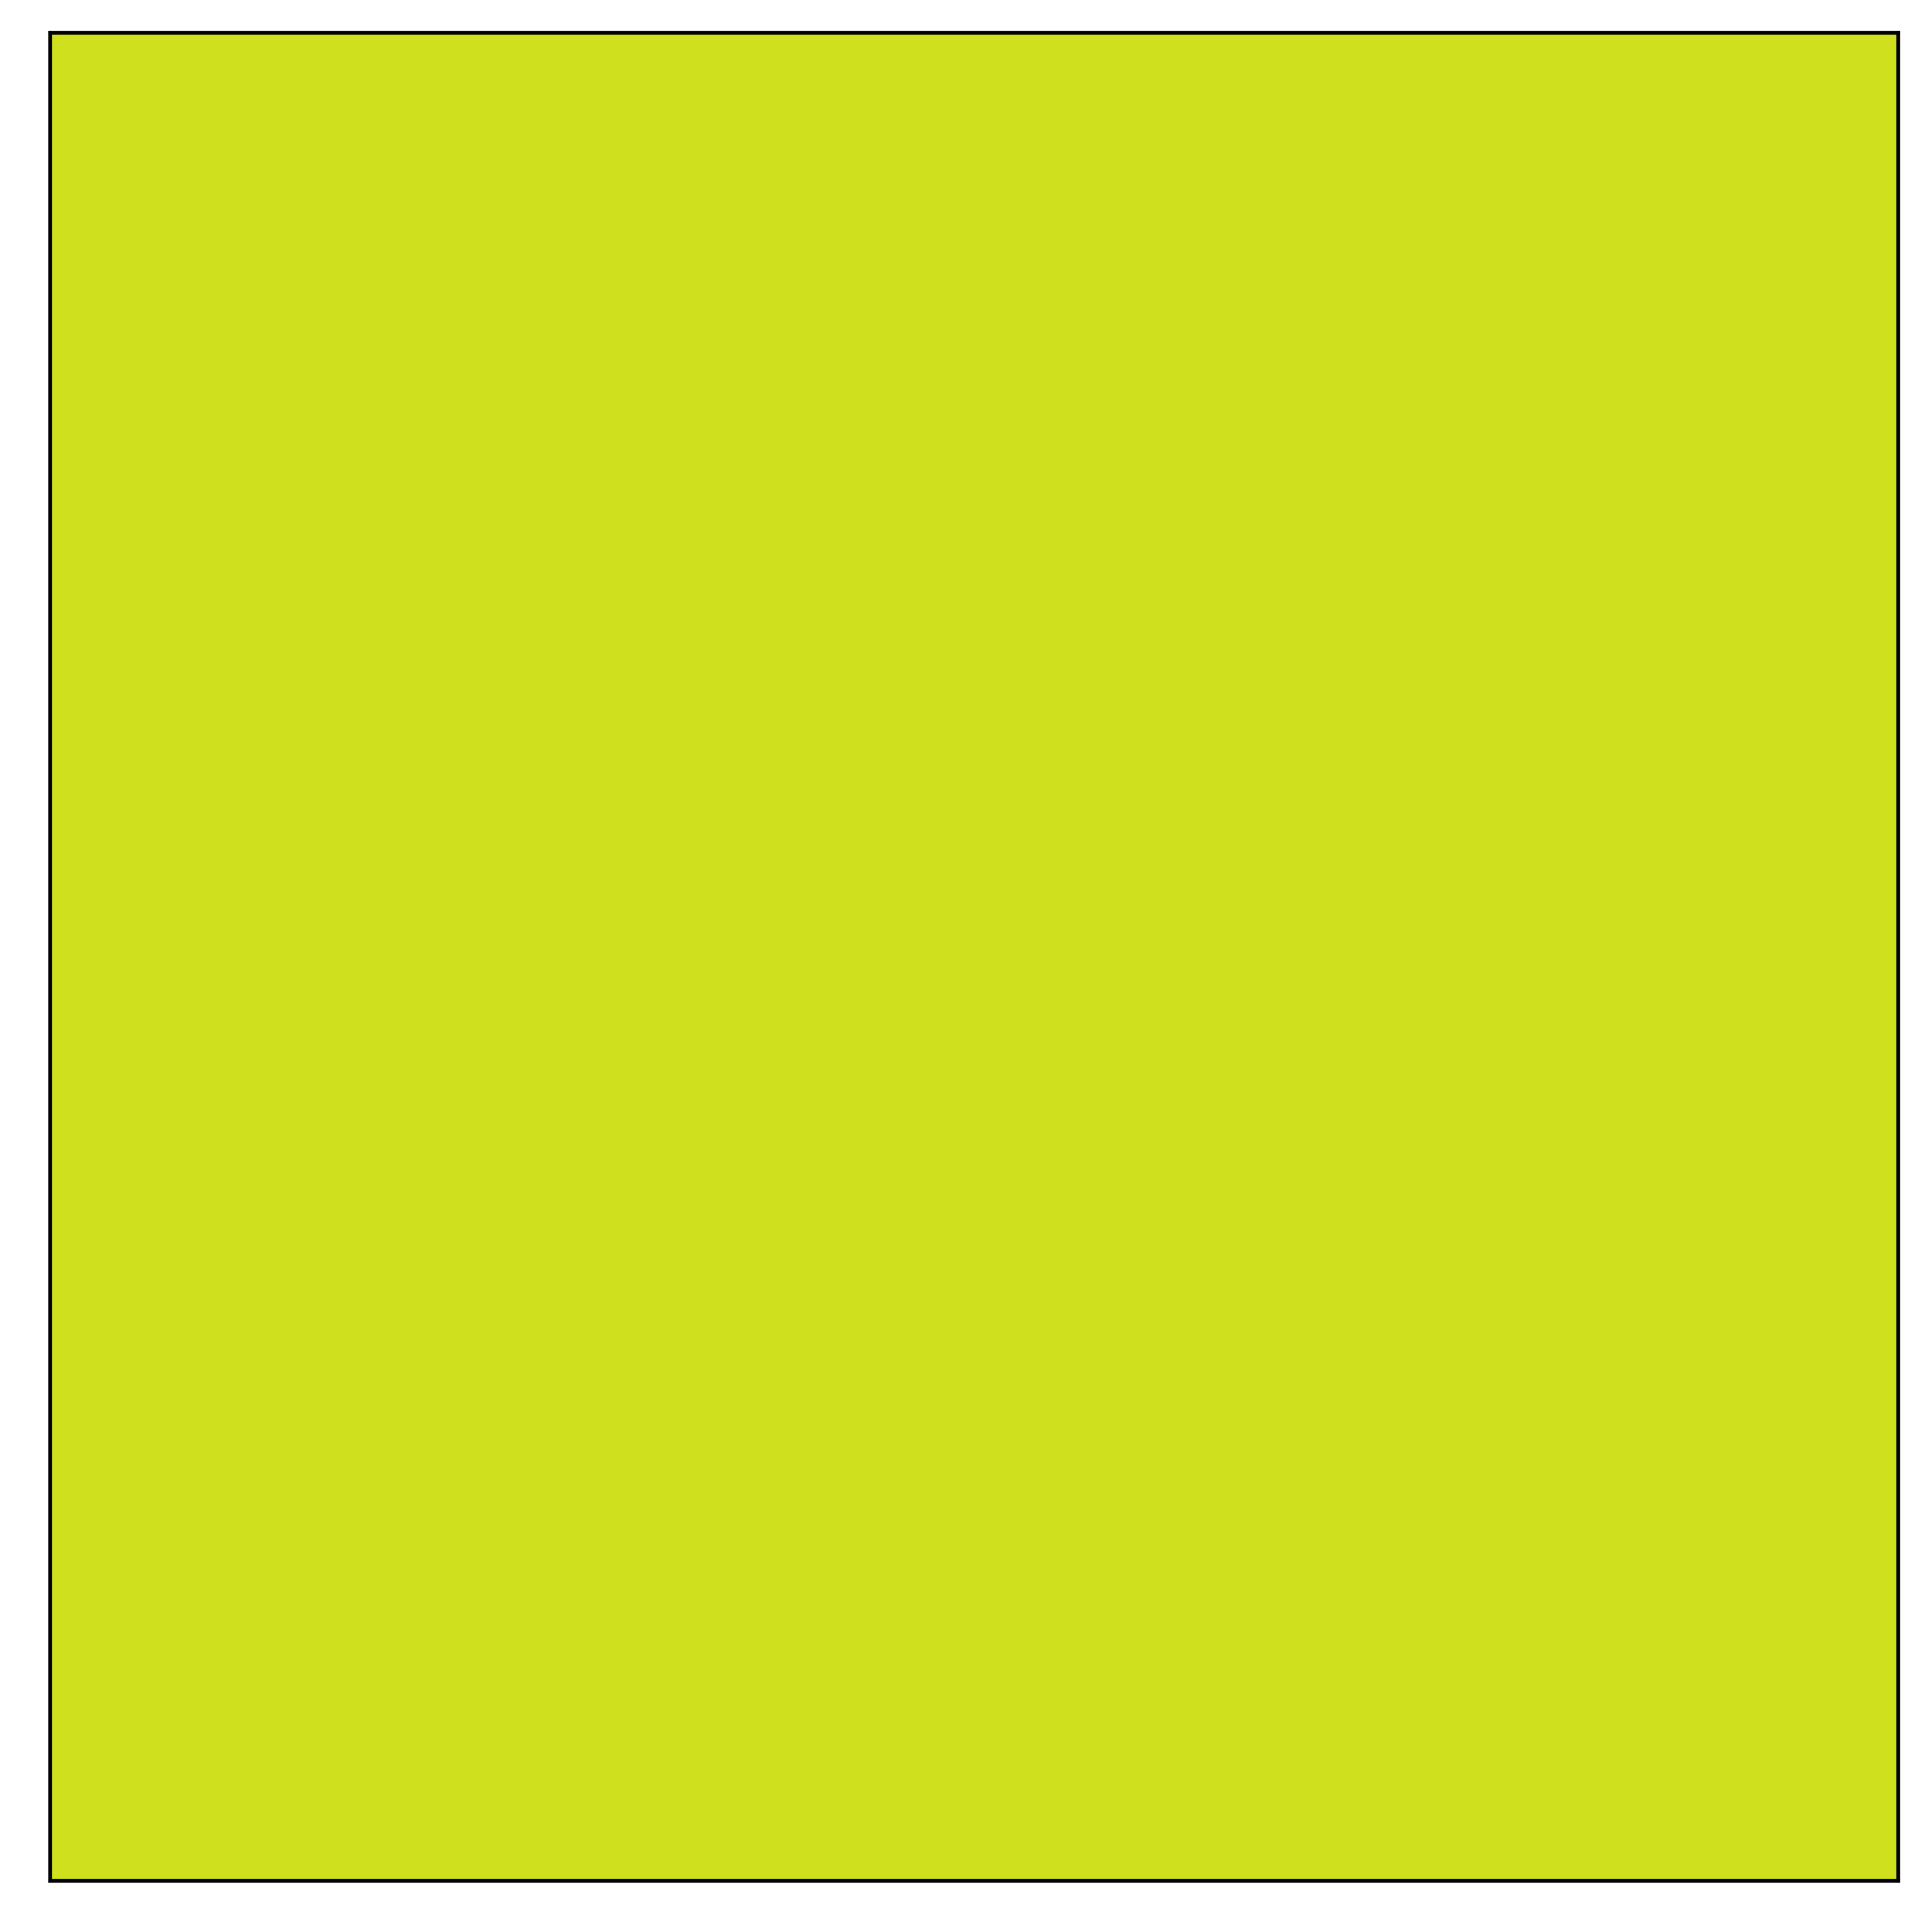

In [12]:
from pathlib import Path
layers = [
    'train-features-0',
    'train-features-3',
    'train-features-7',
    'train-features-10',
    'train-features-14',
    'train-features-17',
    'train-features-20',
    'train-features-24',
    'train-features-27',
    'train-features-30',
    'train-features-34',
    'train-features-37',
    'train-features-40',
   # 'train-classifier-2',
   # 'train-classifier-6'
    ]
heatmaps = get_heatmaps(vgg16)
savepath = Path("./feature_map_plots")
savepath.mkdir(exist_ok=True, parents=True)
images = []
for name in layers:
    heatmap = heatmaps[name]
    fig = plt.figure(figsize=(6,6))
    #plt.title(name.replace("train-", ""))
    print(name.replace("train-", ""))
    plt.imshow(heatmap)
    plt.clim((0.0, 1.0))
    plt.xticks([])
    plt.yticks([])
    #cbar = plt.colorbar()
    #cbar.set_label("Accuracy", rotation=270)
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.tight_layout()
    images.append(image)
    savepath = join(path, name.replace("train-", "") + ".png")
    plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
kwargs_write = {'fps':1.0, 'quantizer':'nq'}
#imageio.mimsave('./vgg16_receptive_field.gif',images, fps=1)